# Setup
Import relevant packages

In [1]:
import pandas
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Load data

In [2]:
original_data = pandas.read_csv('data/recs2009_public.csv')
original_data.head()

C:\Users\vbfal\.conda\envs\ProjectZ\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (717,718) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


DOEID  REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ   NWEIGHT  HDD65  \
0      1        2         4                 12        2   2471.68   4742   
1      2        4        10                 26        2   8599.17   2662   
2      3        1         1                  1        5   8969.92   6233   
3      4        2         3                  7        2  18003.64   6034   
4      5        1         1                  1        3   5999.61   5388   

   CDD65  HDD30YR  CDD30YR  ...  SCALEKER  IECC_Climate_Pub HDD50 CDD80  \
0   1080     4953     1271  ...        -2                4A  2117    56   
1    199     2688      143  ...        -2                3C    62    26   
2    505     5741      829  ...        -2                5A  2346    49   
3    672     5781      868  ...        -2                5A  2746     0   
4    702     5313      797  ...        -2                5A  2251     0   

   GND_HDD65   WSF  OA_LAT  GWT  DesignDBT99  DesignDBT1  
0       4250  0.48       6   56            9          96  
1       2393  0.61       0   64           38          73  
2       5654  0.48       3   52           12          88  
3       4941  0.55       4   55            7          87  
4       5426  0.61       4   50           13          90  

[5 rows x 940 columns]

In [3]:
layout = pandas.read_csv('data/public_layout.csv', index_col='Variable Name')
# layout.reset_index(drop=True, inplace=True)
layout.head()

Variable Label  \
Variable Name                                               
DOEID               Unique identifier for each respondent   
REGIONC                                     Census Region   
DIVISION                                  Census Division   
REPORTABLE_DOMAIN  Reportable states and groups of states   
TYPEHUQ                              Type of housing unit   

                   Variable Order in File Variable Type  Length  
Variable Name                                                    
DOEID                                   1     Character       5  
REGIONC                                 2       Numeric       8  
DIVISION                                3       Numeric       8  
REPORTABLE_DOMAIN                       4       Numeric       8  
TYPEHUQ                                 5       Numeric       8

In [4]:
layout['Variable Type'].unique()

array(['Character', 'Numeric'], dtype=object)

# Data exploration

In [5]:
#Dataset size
print('Dataset contains {0} features for {1} residencies'.format(len(original_data.columns), len(original_data)))

Dataset contains 940 features for 12083 residencies


In [6]:
#Is there missing data?
original_data.isnull().any().any()

False

No missing data in ANY column. Rare but no one's complaining.

In [7]:
# Prediction target is
target = 'KWH'
layout['Variable Label'][target]

'Total Site Electricity usage, in kilowatt-hours, 2009'

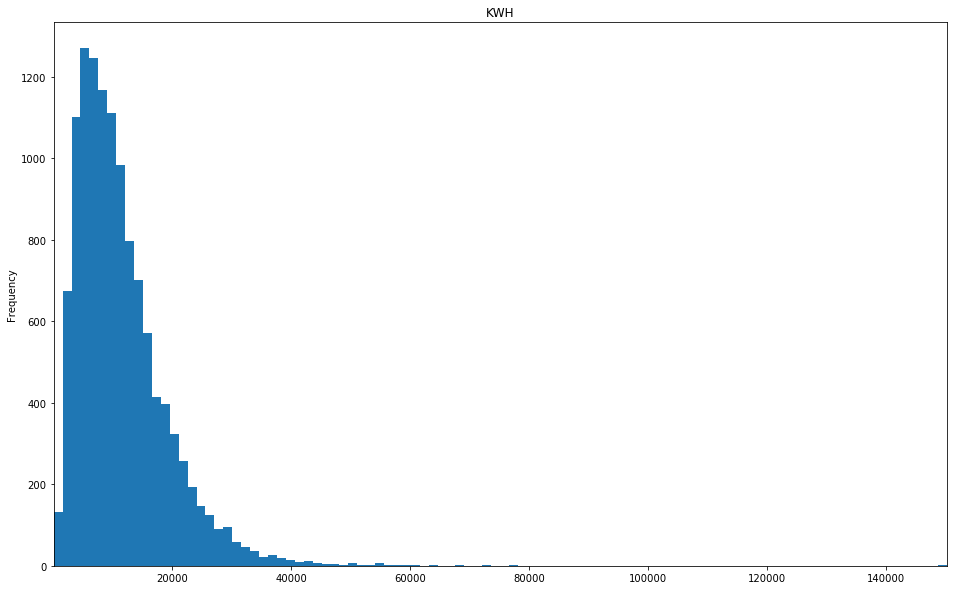

In [8]:
#Target overview
fig, axes = plt.subplots(nrows=1, ncols=1)
original_data[target].plot(kind='hist', figsize=(16, 10), title=target,
                           ax=axes, bins=100, xlim=(original_data[target].min(), original_data[target].max()))

In [9]:
original_data[target].describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

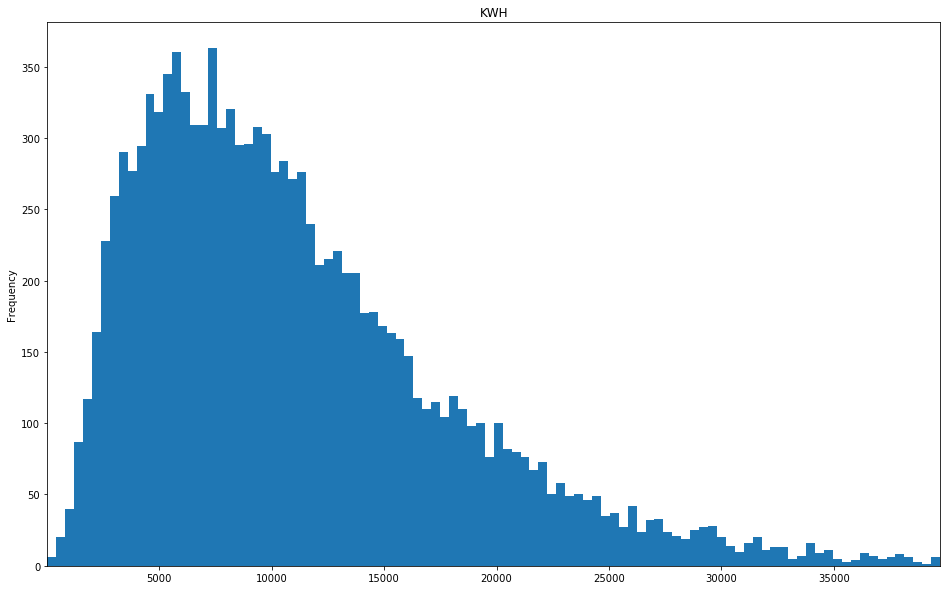

In [10]:
#How about a more focused histogram now?
fig, axes = plt.subplots(nrows=1, ncols=1)
focused_data = original_data[target][original_data[target] < 40000]
focused_data.plot(kind='hist', figsize=(16, 10), title=target,
                           ax=axes, bins=100, xlim=(focused_data.min(), focused_data.max()))

In [11]:
# How many available features are character vs numerical?
layout['Variable Type'].value_counts()

Numeric      930
Character     10
Name: Variable Type, dtype: int64

In [12]:
# Let's take a closer look at these 10 character-format
for c in layout.index[layout['Variable Type']=='Character']: 
    print('{0} - {1}'.format(c, layout['Variable Label'][c]))
    sample_categories = sorted(original_data[c].unique())[0:20]
    print(sample_categories, end='\n\n')

DOEID - Unique identifier for each respondent
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

METROMICRO - Housing unit in Census Metropolitan Statistical Area or Micropolitan Statistical Area
['METRO', 'MICRO', 'NONE']

UR - Housing unit classified as urban or rural by Census
['R', 'U']

ZTOTSQFT - Imputation flag for TOTSQFT
[0, 1]

ZTOTSQFT_EN - Imputation flag for TOTSQFT_EN
[0, 1]

ZTOTHSQFT - Imputation flag for TOTHSQFT
[0, 1]

ZTOTUSQFT - Imputation flag for TOTUSQFT
[0, 1]

ZTOTCSQFT - Imputation flag for TOTCSQFT
[0, 1]

ZTOTUCSQFT - Imputation flag for TOTUCSQFT
[0, 1]

IECC_Climate_Pub - International Energy Conservation Code (IECC) climate zone (collapsed for public file)
['1A-2A', '2B', '3A', '3B-4B', '3C', '4A', '4C', '5A', '5B-5C', '6A-6B', '7A-7B-7AK-8AK']



**Some insights**
- DOEID is the unique ID and should be dropped before modeling
- Some features are imputation flags, perhaps there are others among the numerics?

In [13]:
dump_columns = set()
dump_columns.add('DOEID')

In [14]:
# Let's look for the flags
flag_count = 0
flag_columns = []
for c in original_data.columns:
    if 'flag' in layout['Variable Label'][c].lower():
        flag_count += 1
        flag_columns.append(c)
        print('{0} - {1}'.format(c, layout['Variable Label'][c]))
print('\nFound a total of {0} features that are actually flags'.format(flag_count))

ZKOWNRENT - Imputation flag for KOWNRENT
ZCONDCOOP - Imputation flag for CONDCOOP
ZYEARMADE - Imputation flag for YEARMADE
ZYEARMADERANGE - Imputation flag for YEARMADERANGE
ZOCCUPYYRANGE - Imputation flag for OCCUPYYRANGE
ZCONVERSION - Imputation flag for CONVERSION
ZORIG1FAM - Imputation flag for ORIG1FAM
ZLOOKLIKE - Imputation flag for LOOKLIKE
ZNUMFLRS - Imputation flag for NUMFLRS
ZNUMAPTS - Imputation flag for NUMAPTS
ZWALLTYPE - Imputation flag for WALLTYPE
ZROOFTYPE - Imputation flag for ROOFTYPE
ZSTUDIO - Imputation flag for STUDIO
ZNAPTFLRS - Imputation flag for NAPTFLRS
ZSTORIES - Imputation flag for STORIES
ZTYPEHUQ4 - Imputation flag for TYPEHUQ4
ZBEDROOMS - Imputation flag for BEDROOMS
ZNCOMBATH - Imputation flag for NCOMBATH
ZNHAFBATH - Imputation flag for NHAFBATH
ZOTHROOMS - Imputation flag for OTHROOMS
ZCELLAR - Imputation flag for CELLAR
ZCRAWL - Imputation flag for CRAWL
ZCONCRETE - Imputation flag for CONCRETE
ZBASEFIN - Imputation flag for BASEFIN
ZFINBASERMS - Im

ZFUELHEAT - Imputation flag for FUELHEAT
ZMAINTHT - Imputation flag for MAINTHT
ZEQUIPAGE - Imputation flag for EQUIPAGE
ZHEATOTH - Imputation flag for HEATOTH
ZFURNFUEL - Imputation flag for FURNFUEL
ZRADFUEL - Imputation flag for RADFUEL
ZPIPEFUEL - Imputation flag for PIPEFUEL
ZRMHTFUEL - Imputation flag for RMHTFUEL
ZHSFUEL - Imputation flag for HSFUEL
ZFPFUEL - Imputation flag for FPFUEL
ZNGFPFLUE - Imputation flag for NGFPFLUE
ZUSENGFP - Imputation flag for USENGFP
ZRNGFUEL - Imputation flag for RNGFUEL
ZDIFFUEL - Imputation flag for DIFFUEL
ZEQMAMT - Imputation flag for EQMAMT
ZHEATROOM - Imputation flag for HEATROOM
ZTHERMAIN - Imputation flag for THERMAIN
ZNUMTHERM - Imputation flag for NUMTHERM
ZPROTHERM - Imputation flag for PROTHERM
ZAUTOHEATNITE - Imputation flag for AUTOHEATNITE
ZAUTOHEATDAY - Imputation flag for AUTOHEATDAY
ZTEMPHOME - Imputation flag for TEMPHOME
ZTEMPGONE - Imputation flag for TEMPGONE
ZTEMPNITE - Imputation flag for TEMPNITE
ZMOISTURE - Imputation fla

That's a lot! Nearly 38% of all features are actually imputation flags for other features. Let's take a closer look before taking a decision

In [15]:
# Just to be sure, are they all binary?
uniques = set()
for c in flag_columns:
    uniques.update(original_data[c].unique())
print(uniques)

{0, 1}


OK, having validated all flags are binary, let's move on to...

In [16]:
# How many rows have imputed values?
imputation = []
for index, row in tqdm(original_data.iterrows()):
    for c in flag_columns:
        if row[c] == 1:
            imputation.append(True)
            break
        else:
            imputation.append(False)
print('A total of {0} rows have imputed values - {1:.0f}% of the dataset'.\
      format(sum(imputation), 100*sum(imputation)/len(original_data)))

12083it [00:22, 531.29it/s]


A total of 6537 rows have imputed values - 54% of the dataset


Imputed values are clearly relevant - we can't just cut half of the dataset!

**ASSUMPTION**: imputations are reliable (in reality: side track to validate imputation quality and improve if necessary)
The flag columns, though may be discarded.

In [17]:
dump_columns.update(flag_columns)
assert(len(dump_columns) - len(flag_columns) == 1) 

Are there time-based features?

In [18]:
# Are there time-based features?
time_count = 0
time_columns = set()

potential_time_columns = set(original_data.columns).difference(dump_columns)

for c in potential_time_columns:
    
    if ('day' in layout['Variable Label'][c].lower()) or ('time' in layout['Variable Label'][c].lower()) or \
        ('hour' in layout['Variable Label'][c].lower()) or ('month' in layout['Variable Label'][c].lower()):
        time_count += 1
        time_columns.add(c)
        print('{0} - {1}'.format(c, layout['Variable Label'][c]))
print('\nFound a total of {0} features that may be time based'.format(time_count))

HDD50 - Heating degree days in 2009, base temperature 50F
CDD30YR - Cooling degree days, 30-year average 1981-2010, base 65F
CDD65 - Cooling degree days in 2009, base temperature 65F
TVONWD2 - Second most-used TV usage on weekdays
KWHOTH - Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in kilowatt-hours, 2009
TELLDAYS - Number of telecommuting days per month
USEMOISTURE - Number of months humidifier used in 2009
AUTOCOOLDAY - Programmable thermostat adjusts temperature during the day
HDD30YR - Heating degree days, 30-year average 1981-2010, base 65F
PERIODEL - Number of days covered by Energy Supplier Survey electricity billing data and used to calculate annual consumption and expenditures
LGT12 - Number of lights turned on 12 or more hours during a typical summer day
AUTOHEATDAY - Programmable thermostat lowers temperature during the day
TVONWDWATCH2 - Second most-used TV weekday usage spent playing video games
KWHRFG - Electricity usage for refrige

Going through labels it seems all are aggregates already.

Could other columns contain information from the target? Let's look for a few key terms in the descriptions

In [19]:
# Are there time-based features?
leak_count = 0
leak_columns = set()

potential_leak_columns = set(original_data.columns).difference(dump_columns)

for c in potential_leak_columns:
    
    if ('electricity' in layout['Variable Label'][c].lower()) or ('kilowatt-hours' in layout['Variable Label'][c].lower()) or \
        ('kwh' in layout['Variable Label'][c].lower()) or ('btu' in layout['Variable Label'][c].lower()) :
        leak_count += 1
        leak_columns.add(c)
        print('{0} - {1}'.format(c, layout['Variable Label'][c]))
print('\nFound a total of {0} features that may contain leaked information from target'.format(leak_count))

PELLIGHT - Who pays for electricity used for lighting and other appliances
PELAC - Who pays for electricity used for air conditioning
BTUELOTH - Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in thousand BTU, 2009
BTULPOTH - LPG/Propane usage for other purposes (all end-uses except SPH and WTH), in thousand BTU, 2009
BTUFOWTH - Fuel Oil usage for water heating, in thousand BTU, 2009
KWHOTH - Electricity usage for other purposes (all end-uses except SPH, COL, WTH, and RFG), in kilowatt-hours, 2009
BTUELCOL - Electricity usage for air-conditioning, central and window/wall (room), in thousand BTU, 2009
BTULPSPH - LPG/Propane usage for space heating, in thousand BTU, 2009
BTUFOSPH - Fuel Oil usage for space heating, in thousand BTU, 2009
DOLELOTH - Electricity cost for other purposes (all end-uses except SPH, COL, WTH, and RFG), in wholedollars, 2009
TOTALBTUOTH - Total usage for appliances, electronics, lighting, and miscellaneous uses, in thousand BTU,

Already it can be seen that most of these are directly related to the target. At least two (`BTUEL` and `DOLLAREL`) should be 100% correlated or close to that. At least one should be useless (`USEEL`), as it should be an always true flag. Many of the others could be summed up to compose the target completely, and would probably be unknown at the time of prediction.

Let's save the few ones which might still be good and dump the others.

In [20]:
keep_columns = ['KWH', # must keep target
                'BTUFO', 'BTUFOOTH', 'BTUFOSPH', 'BTUFOWTH', 'BTUKER', 'BTUKEROTH', 'BTUKERSPH', 'BTUKERWTH', 'BTULPOTH',
                'BTULP', 'BTULPSPH', 'BTULPWTH', 'BTUNG', 'BTUNGOTH', 'BTUNGSPH', 'BTUNGWTH', 'BTUWOOD',
                'CORDSWD', 'KAVALEL', 'PELAC', 'PELCOOK', 'PELHEAT', 'PELHOTWA', 'PELLIGHT', 'OTHERWAYEL', 
                ]
for c in keep_columns:
    leak_columns.discard(c)

In [21]:
dump_columns.update(leak_columns)
len(dump_columns)

392

Let's dump a few columns here then

In [22]:
clean_data = original_data.drop(dump_columns, axis=1)
clean_data.head()

REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ   NWEIGHT  HDD65  CDD65  \
0        2         4                 12        2   2471.68   4742   1080   
1        4        10                 26        2   8599.17   2662    199   
2        1         1                  1        5   8969.92   6233    505   
3        2         3                  7        2  18003.64   6034    672   
4        1         1                  1        3   5999.61   5388    702   

   HDD30YR  CDD30YR  Climate_Region_Pub  ...  SCALEKER IECC_Climate_Pub HDD50  \
0     4953     1271                   4  ...        -2               4A  2117   
1     2688      143                   5  ...        -2               3C    62   
2     5741      829                   1  ...        -2               5A  2346   
3     5781      868                   1  ...        -2               5A  2746   
4     5313      797                   1  ...        -2               5A  2251   

   CDD80  GND_HDD65   WSF  OA_LAT  GWT  DesignDBT99  DesignDBT1  
0     56       4250  0.48       6   56            9          96  
1     26       2393  0.61       0   64           38          73  
2     49       5654  0.48       3   52           12          88  
3      0       4941  0.55       4   55            7          87  
4      0       5426  0.61       4   50           13          90  

[5 rows x 548 columns]

Let's check for bad encoded data

In [23]:
for c in clean_data.columns:
    if layout['Variable Type'][c] == 'Character':
        continue
    for u in clean_data[c].unique():
        if type(u) == str:
            print(c, ':', clean_data[c].unique())
            break        

NOCRCASH : [-2 1 6 15 4 '-2' '1' '20' '.' '12' '4' '10' '3' '24' '55' '6' 8 28 5 55 3
 16 2 20 10 24 40 12 25]
NKRGALNC : [-2 1 5 10 '-2' '10' '15' '1' '8' '.' '5' '3' '2' '77' 30 3 15 8 55 2 20]


So two columns contain strings mixed in with numerics.

In [24]:
# but how many rows?
# but how many?
bad_data = clean_data[(clean_data['NOCRCASH']=='.') | (clean_data['NKRGALNC']=='.')]
bad_data

REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ   NWEIGHT  HDD65  CDD65  \
1387        1         2                  3        5  10806.57   6810    436   
2092        1         1                  1        5   8833.60   6069    615   

      HDD30YR  CDD30YR  Climate_Region_Pub  ...  SCALEKER IECC_Climate_Pub  \
1387     7214      442                   1  ...         3               5A   
2092     5722      834                   1  ...         3               5A   

     HDD50  CDD80  GND_HDD65   WSF  OA_LAT  GWT  DesignDBT99  DesignDBT1  
1387  3123      0       6052  0.50       3   50            6          90  
2092  2420      0       6299  0.49       3   53            5          91  

[2 rows x 548 columns]

2 rows can be dropped without great harm to final results

In [25]:
previous_len = len(clean_data)
clean_data = clean_data[(clean_data['NOCRCASH']!='.') & (clean_data['NKRGALNC']!='.')]
new_len = len(clean_data)
assert((previous_len - new_len) == 2)

In [26]:
# and finally convert everything to int
clean_data['NOCRCASH'] = clean_data['NOCRCASH'].astype(int)
clean_data['NKRGALNC'] = clean_data['NKRGALNC'].astype(int)

In [27]:
#Maybe a quick look at plots will provide more insight??
plot_data = clean_data.drop(['METROMICRO', 'UR', 'IECC_Climate_Pub'], axis=1) #drop remaining categorical columns

In [28]:
plot_data.head()

REGIONC  DIVISION  REPORTABLE_DOMAIN  TYPEHUQ   NWEIGHT  HDD65  CDD65  \
0        2         4                 12        2   2471.68   4742   1080   
1        4        10                 26        2   8599.17   2662    199   
2        1         1                  1        5   8969.92   6233    505   
3        2         3                  7        2  18003.64   6034    672   
4        1         1                  1        3   5999.61   5388    702   

   HDD30YR  CDD30YR  Climate_Region_Pub  ...  PERIODKR  SCALEKER  HDD50  \
0     4953     1271                   4  ...        -2        -2   2117   
1     2688      143                   5  ...        -2        -2     62   
2     5741      829                   1  ...        -2        -2   2346   
3     5781      868                   1  ...        -2        -2   2746   
4     5313      797                   1  ...        -2        -2   2251   

   CDD80  GND_HDD65   WSF  OA_LAT  GWT  DesignDBT99  DesignDBT1  
0     56       4250  0.48       6   56            9          96  
1     26       2393  0.61       0   64           38          73  
2     49       5654  0.48       3   52           12          88  
3      0       4941  0.55       4   55            7          87  
4      0       5426  0.61       4   50           13          90  

[5 rows x 545 columns]

C:\Users\vbfal\.conda\envs\ProjectZ\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


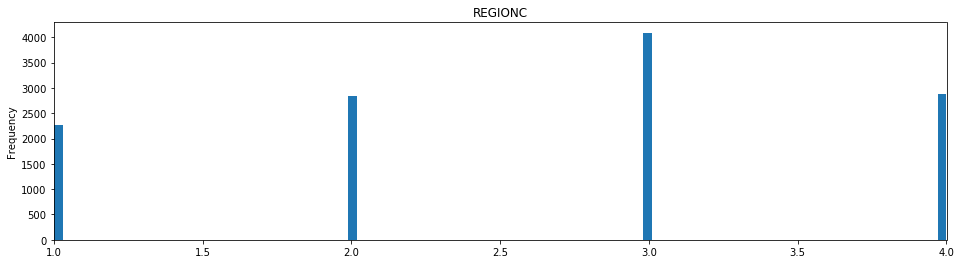

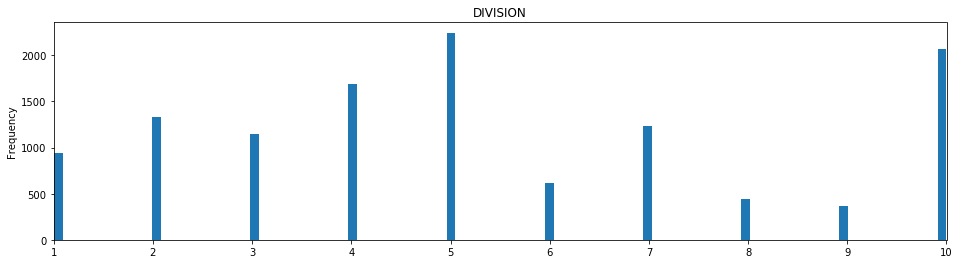

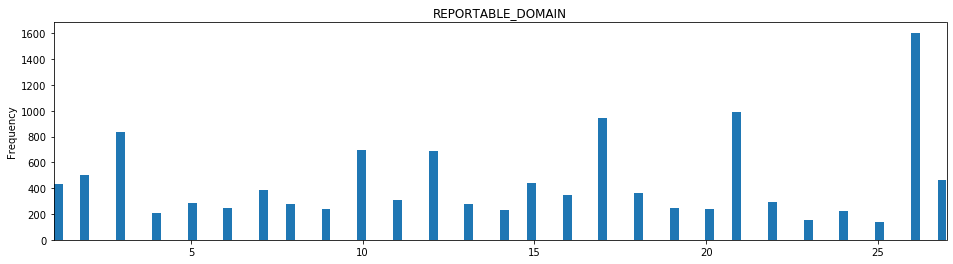

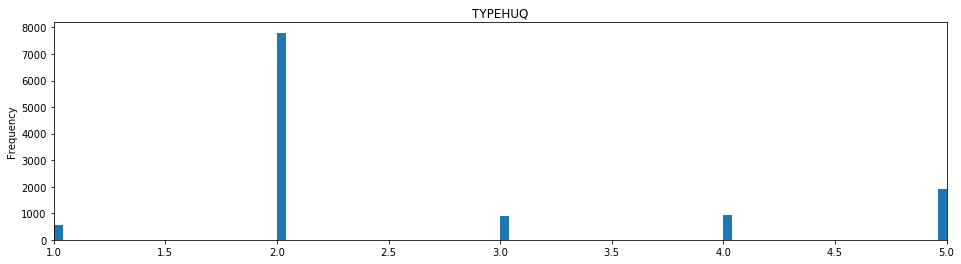

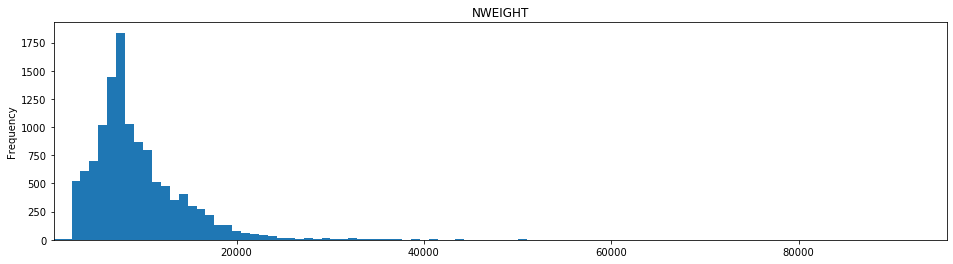

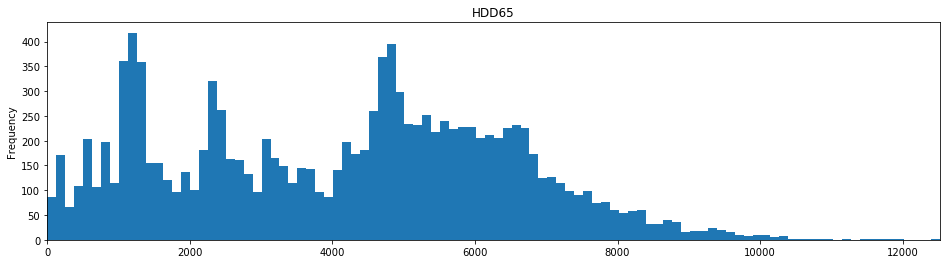

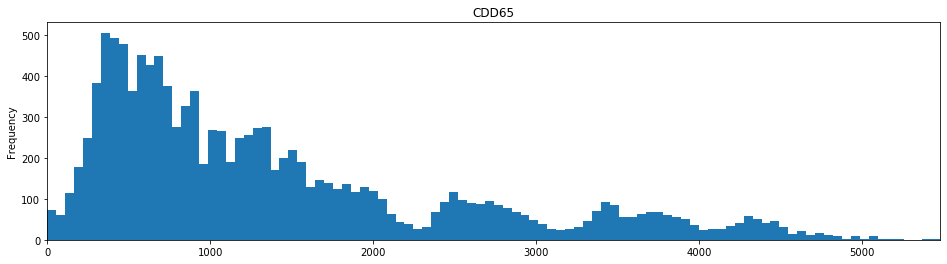

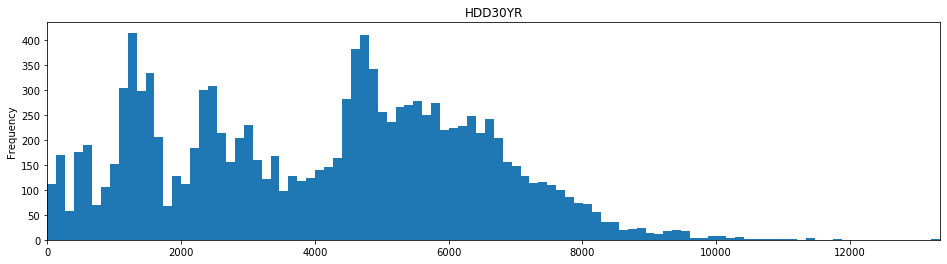

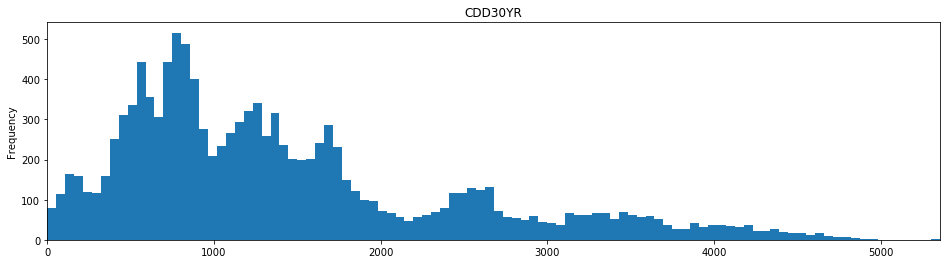

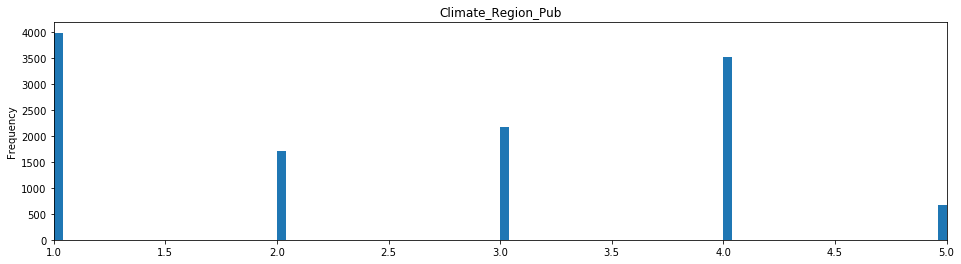

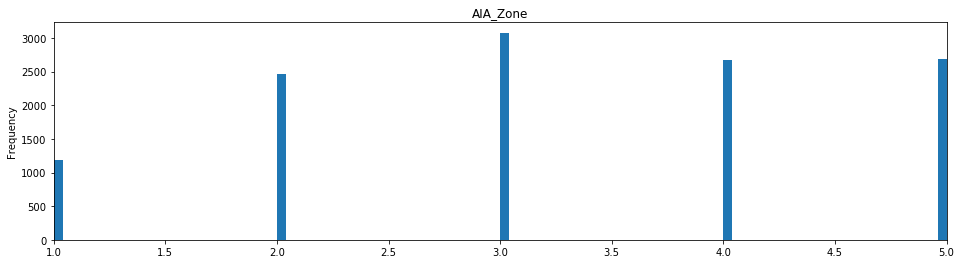

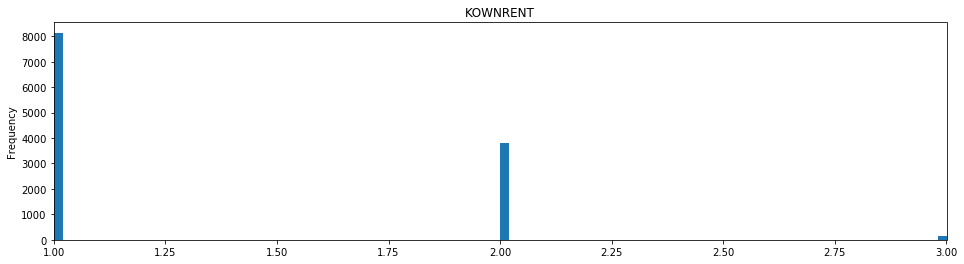

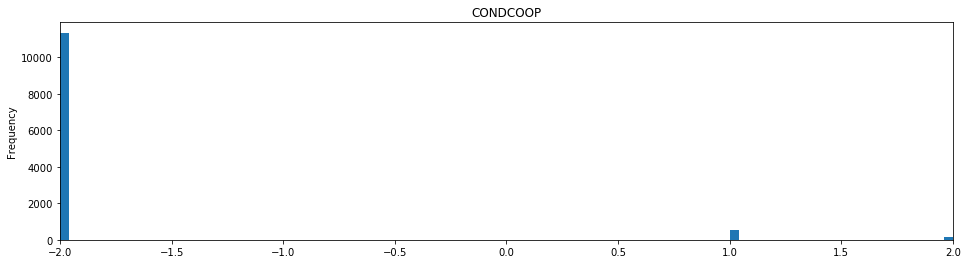

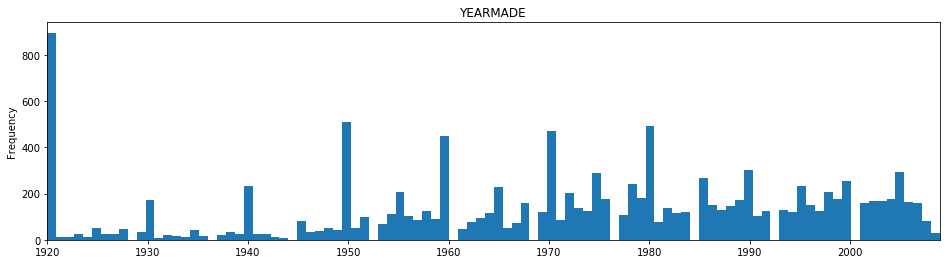

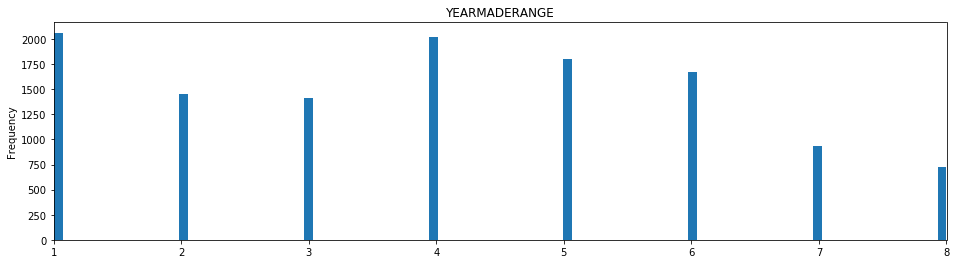

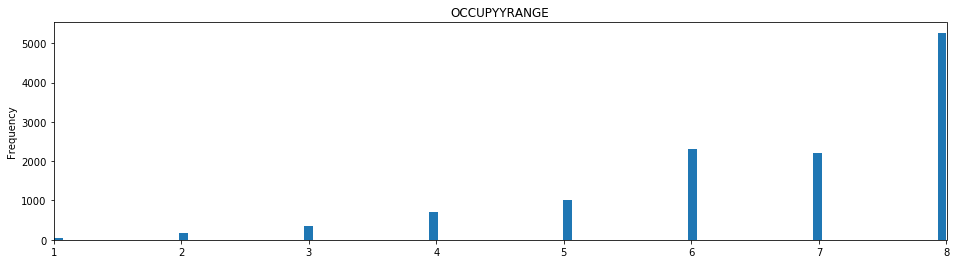

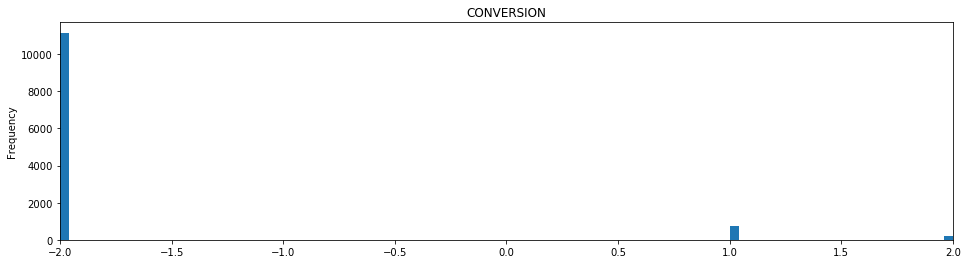

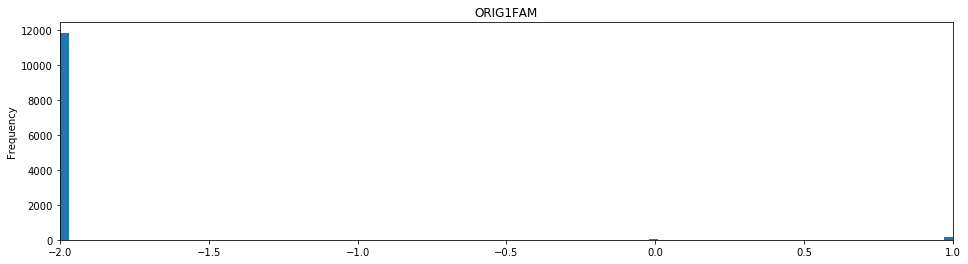

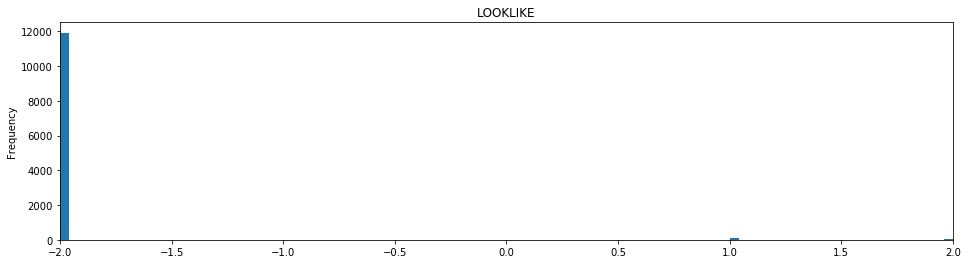

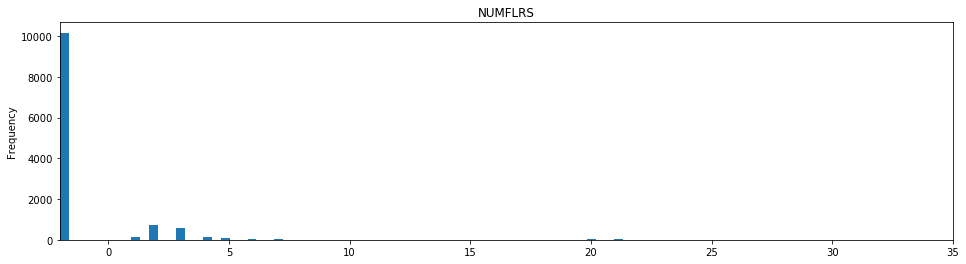

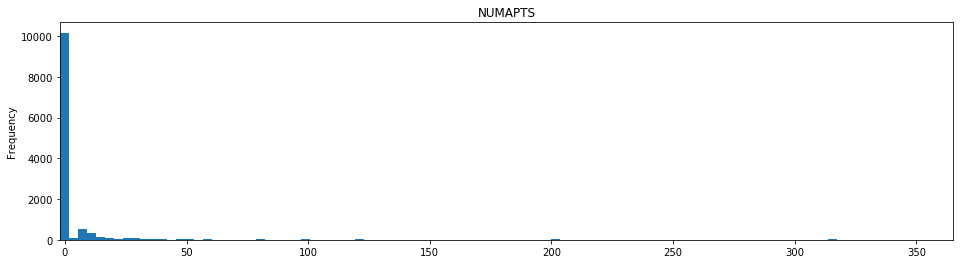

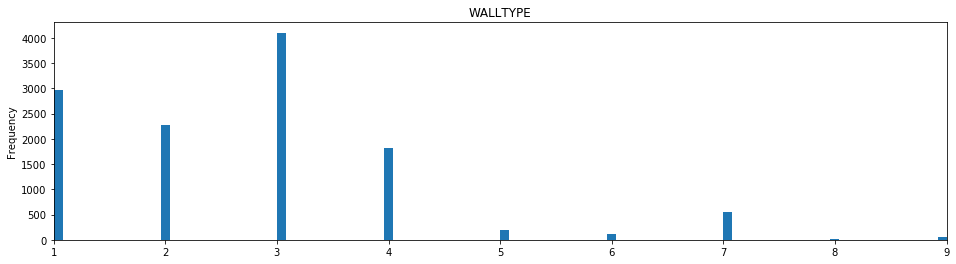

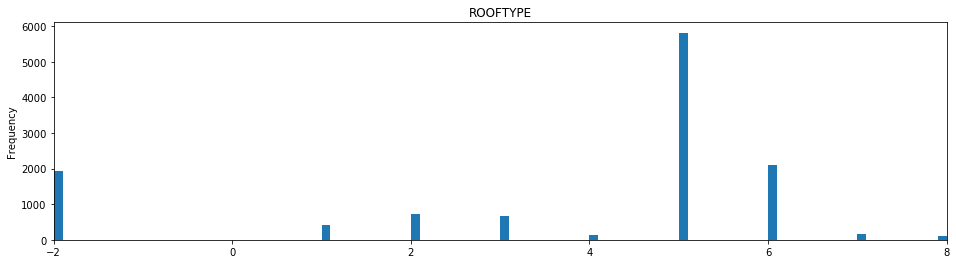

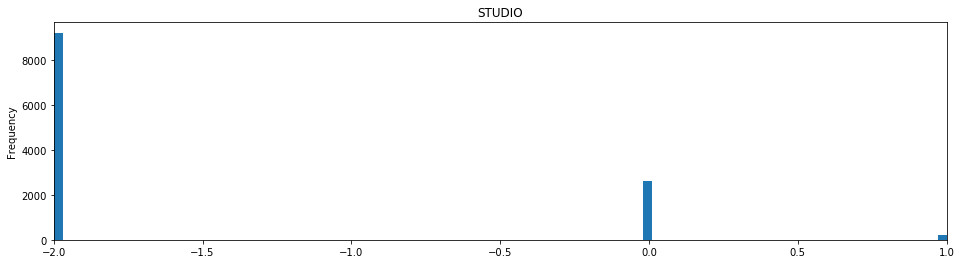

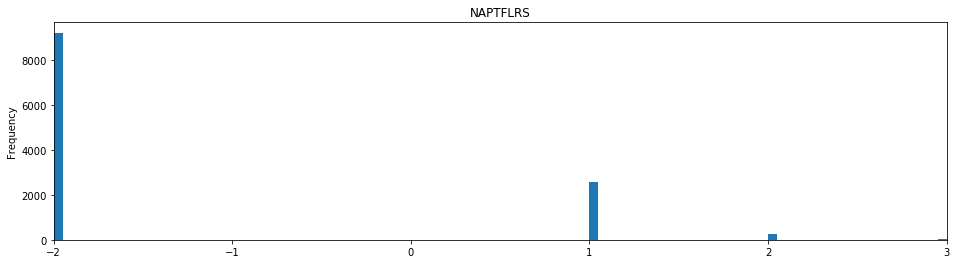

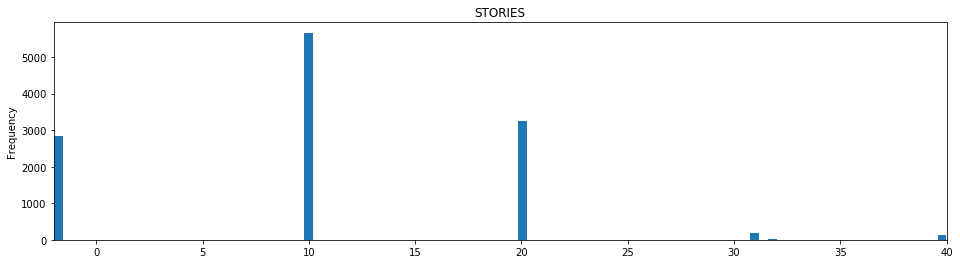

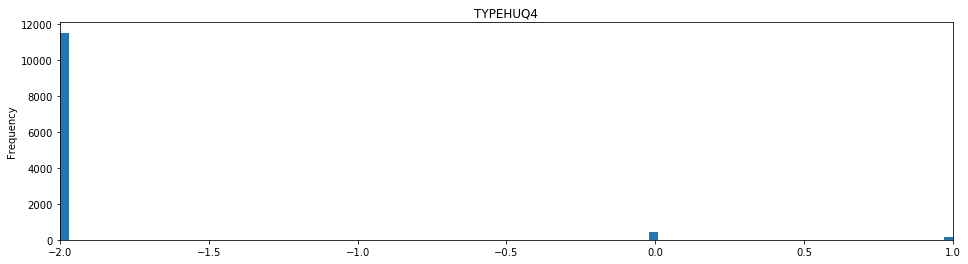

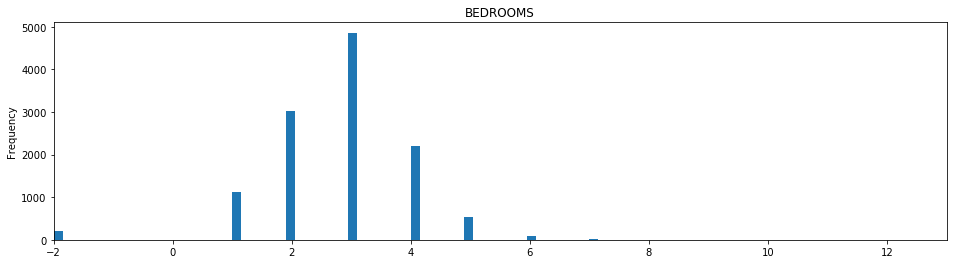

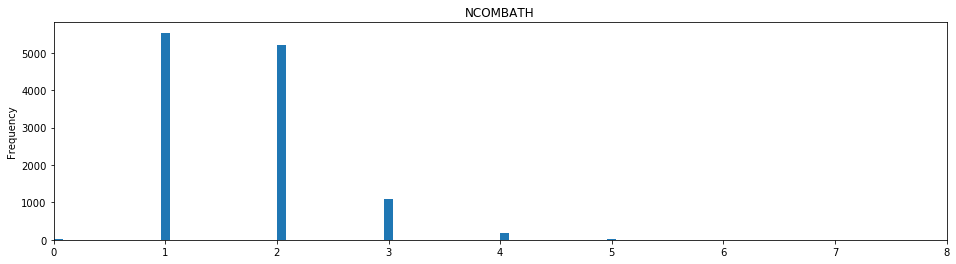

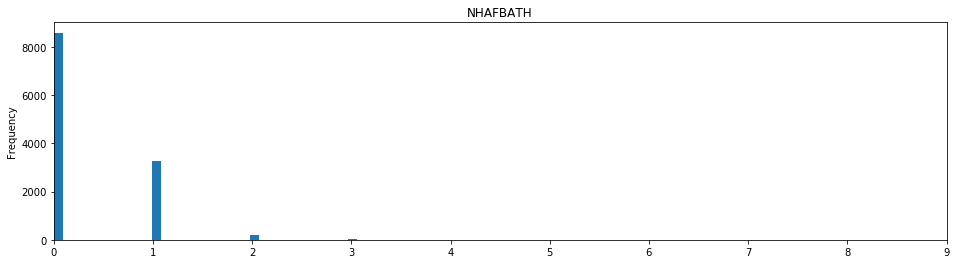

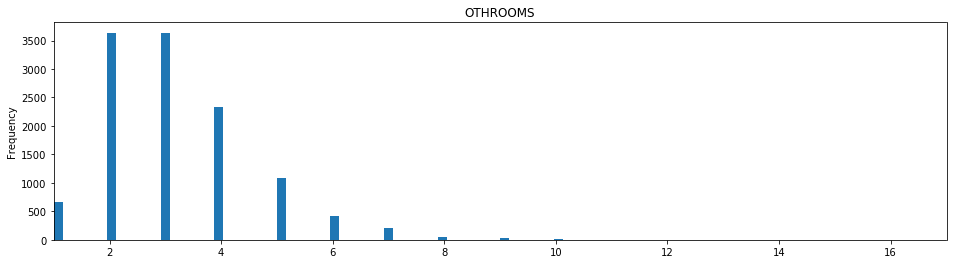

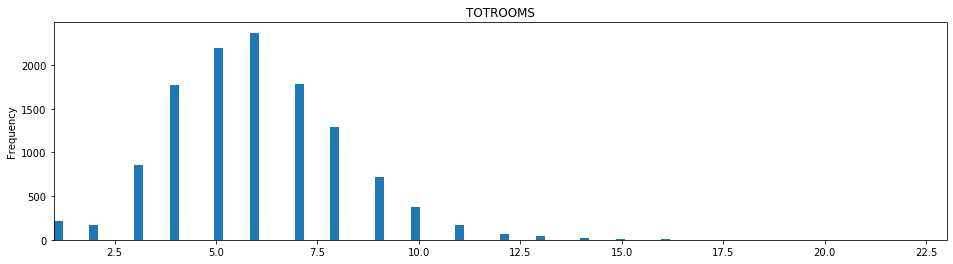

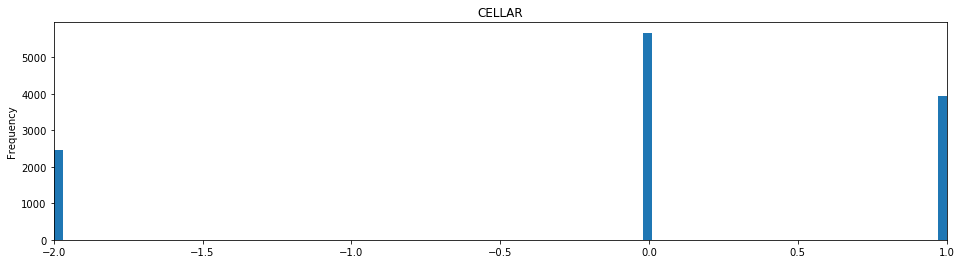

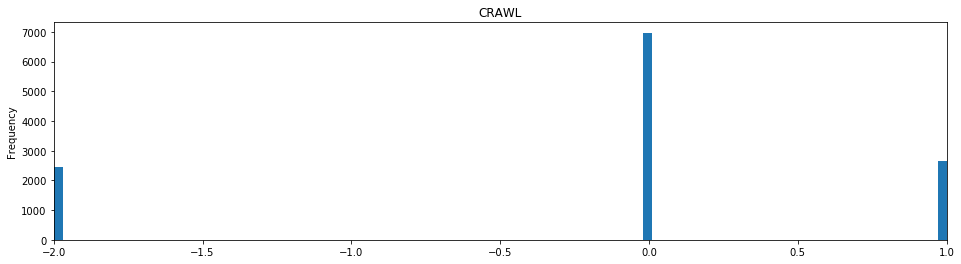

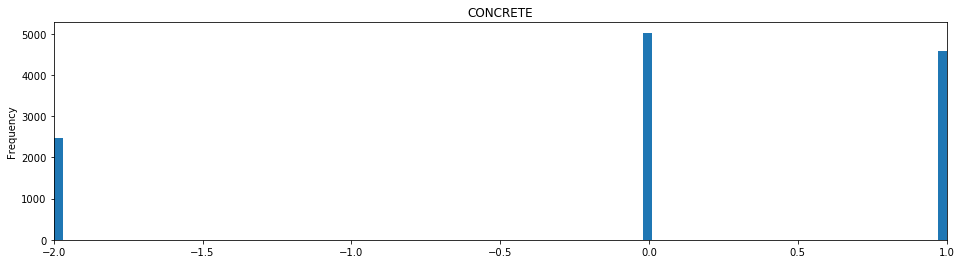

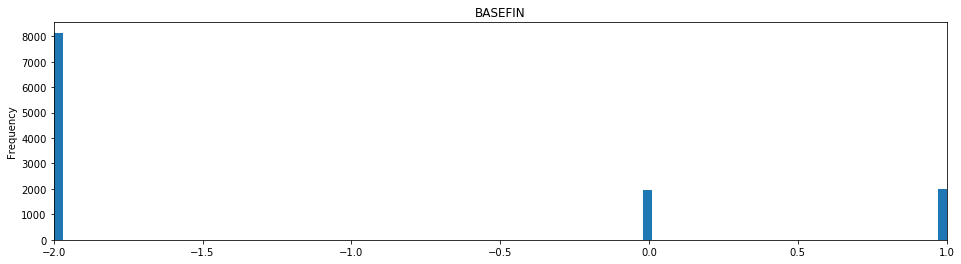

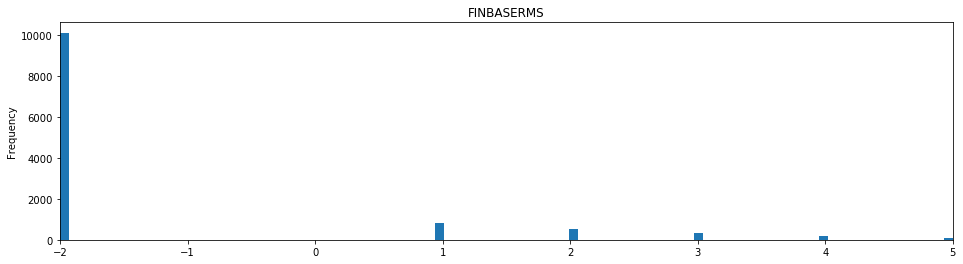

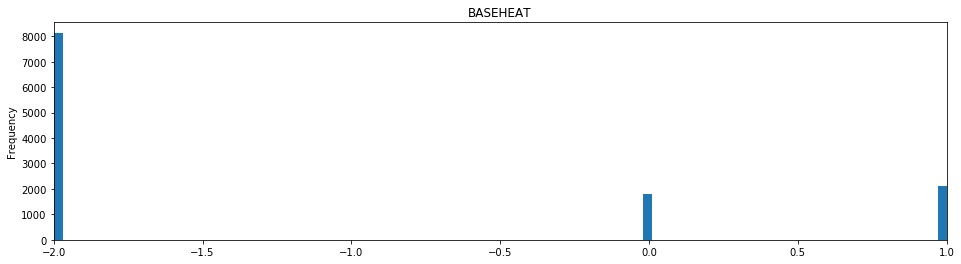

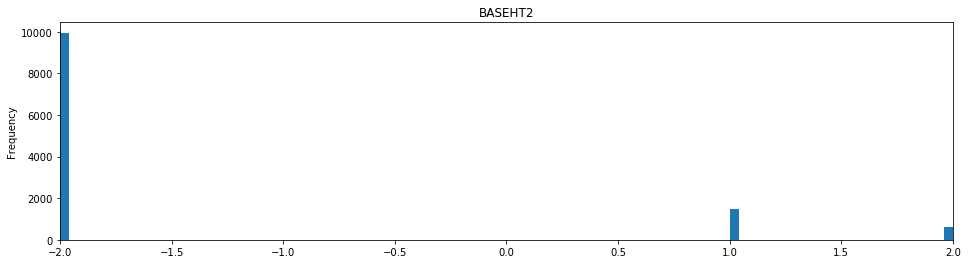

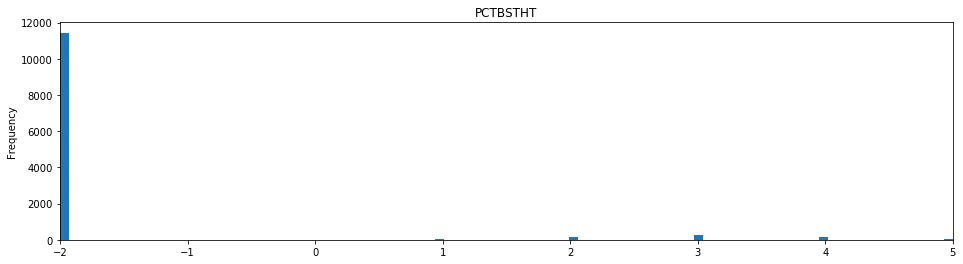

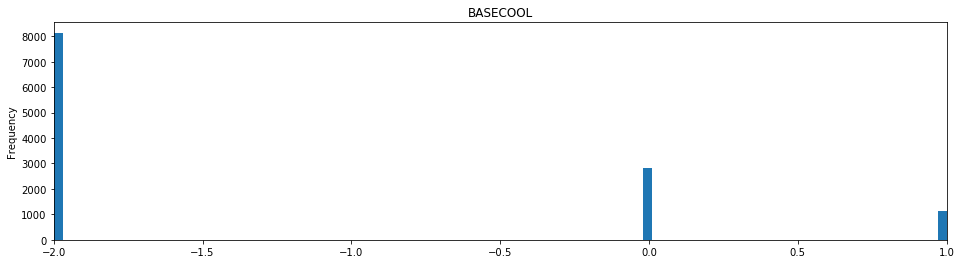

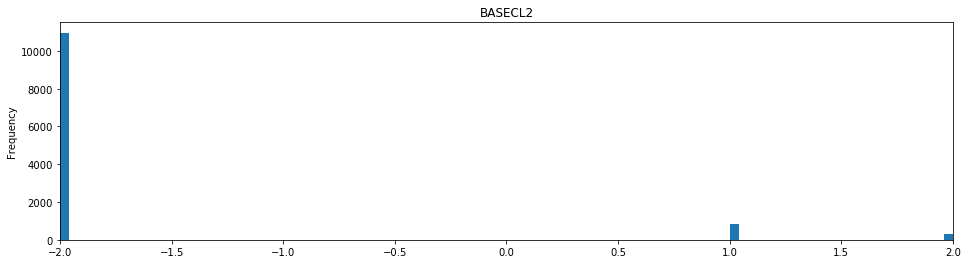

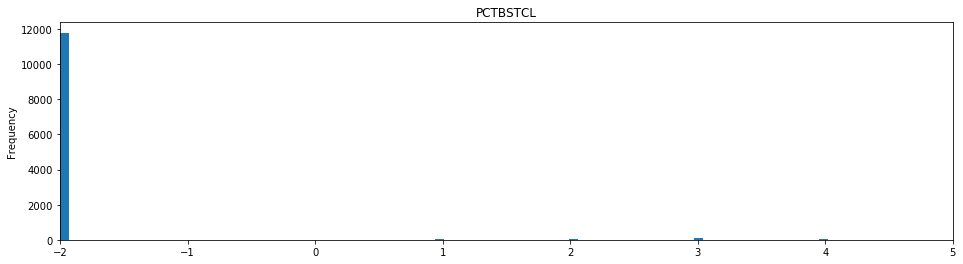

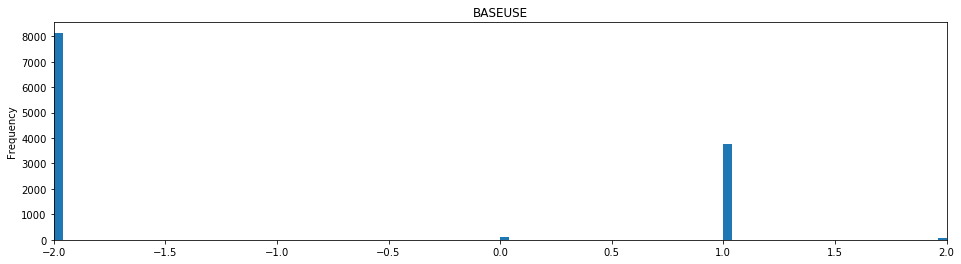

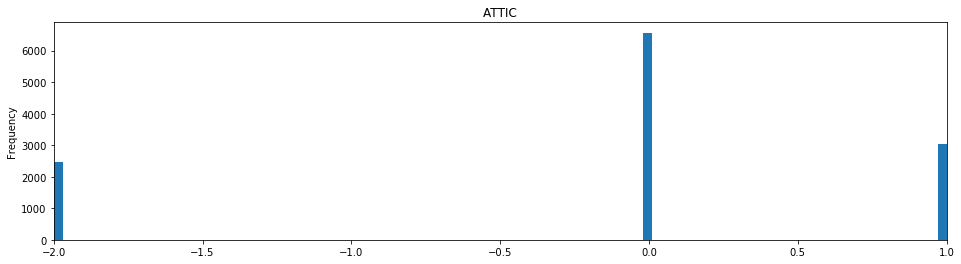

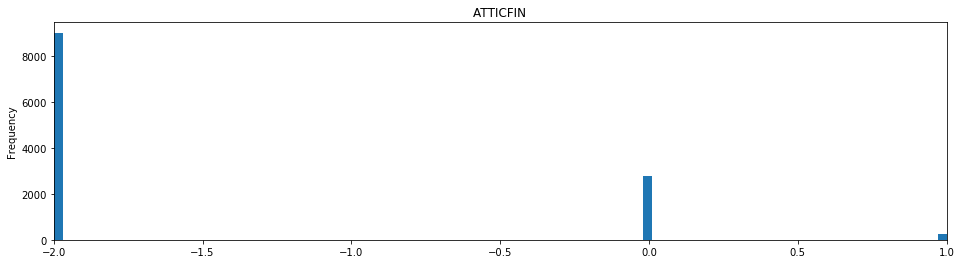

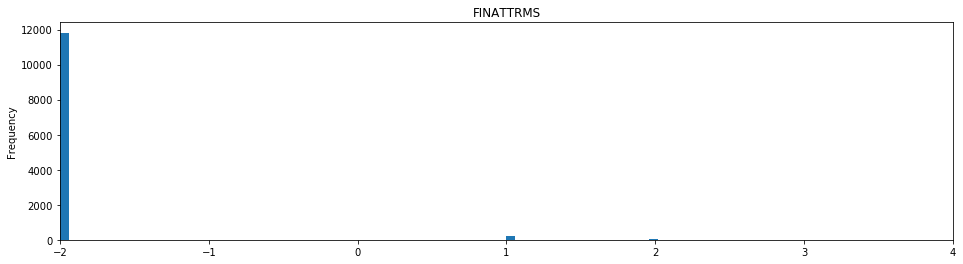

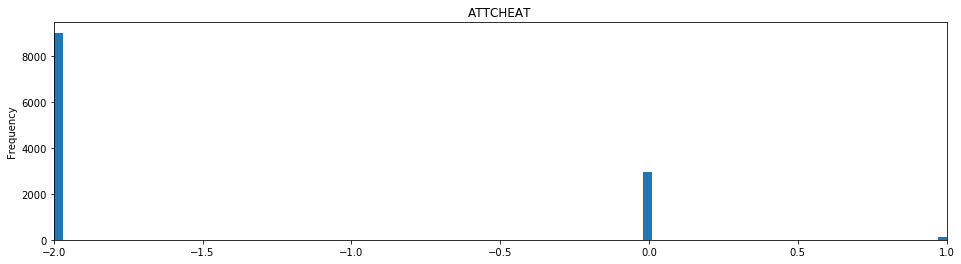

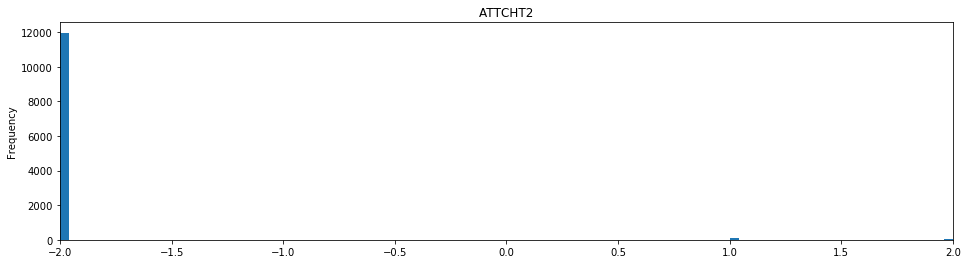

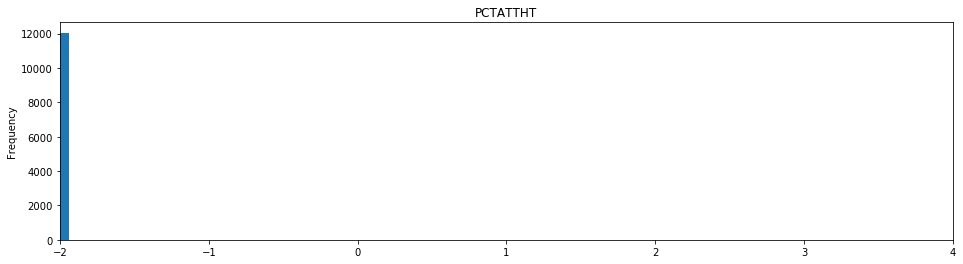

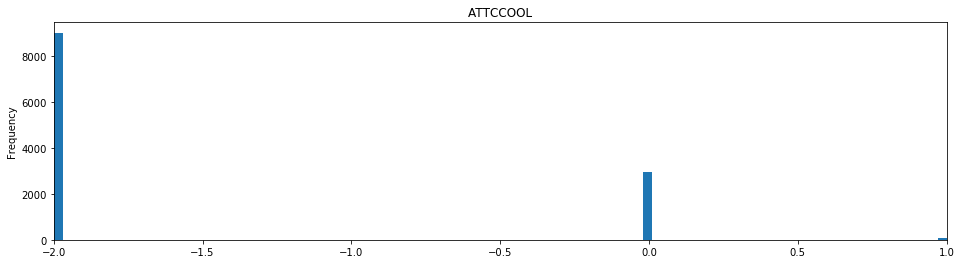

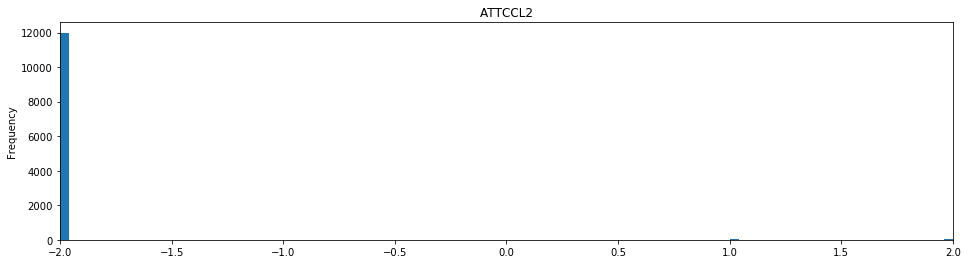

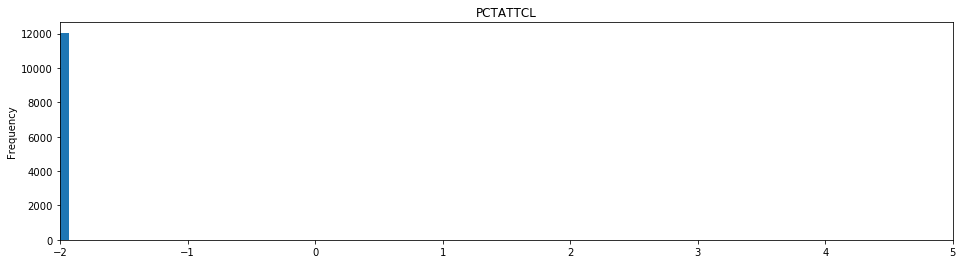

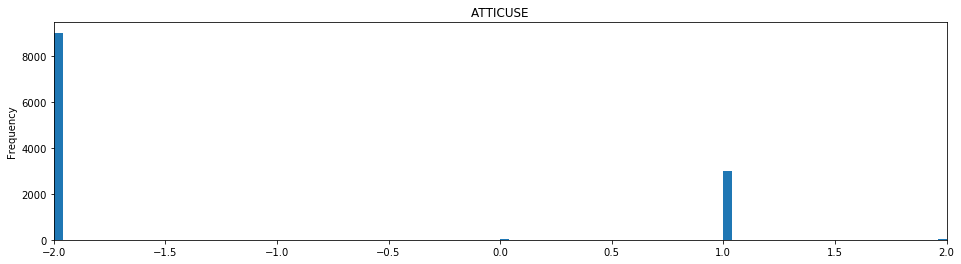

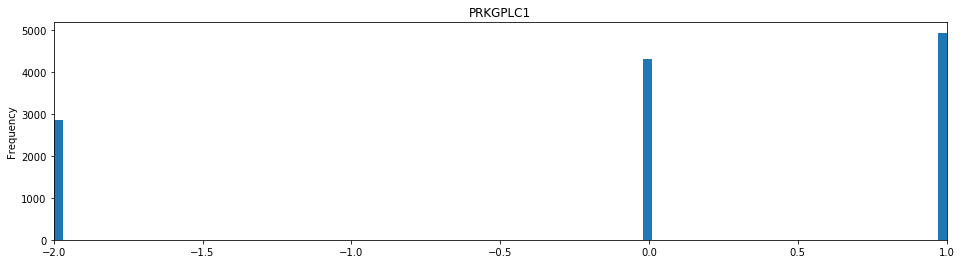

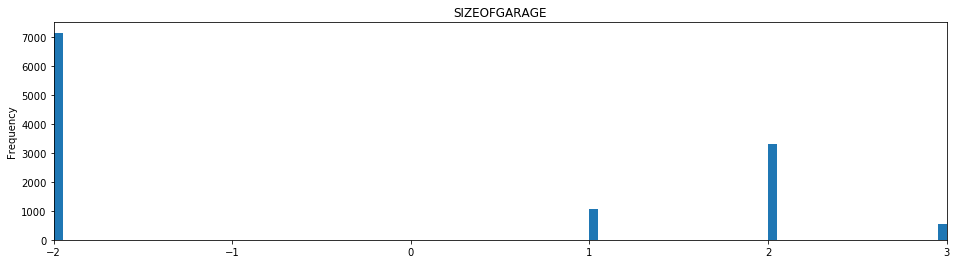

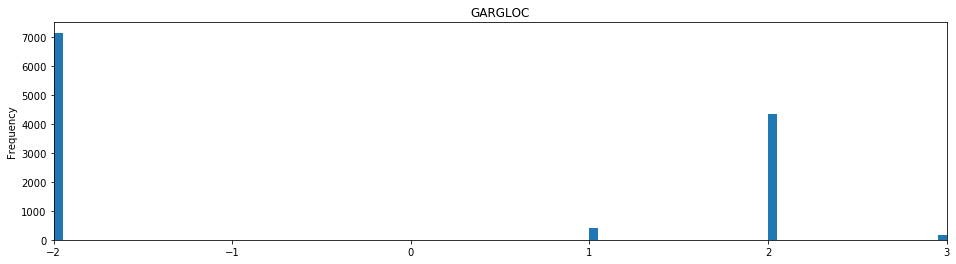

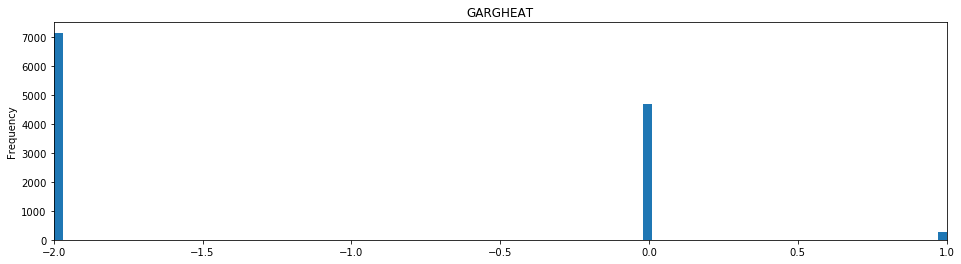

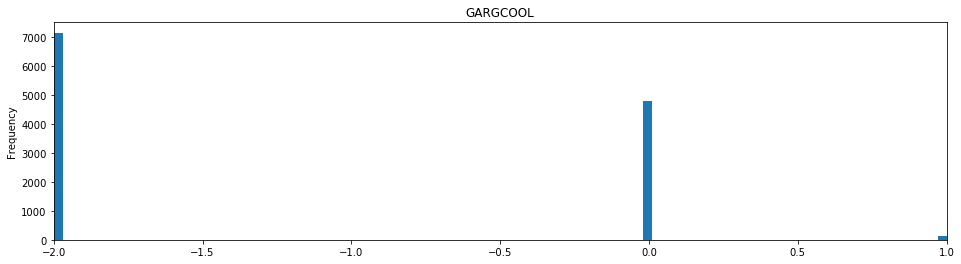

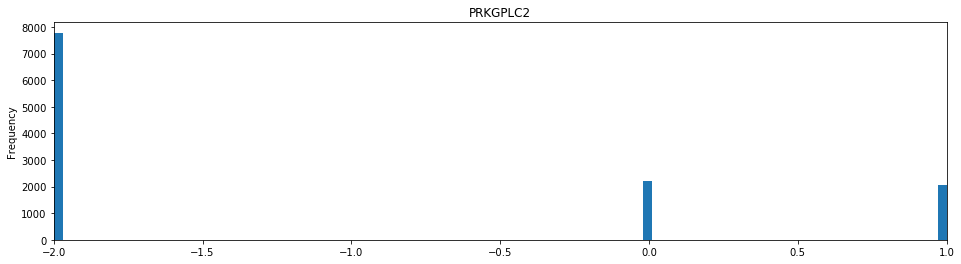

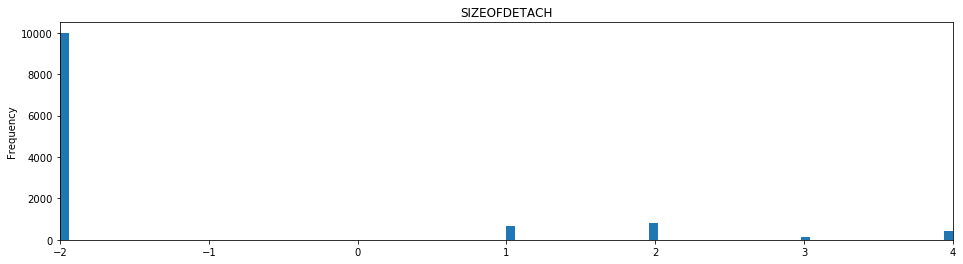

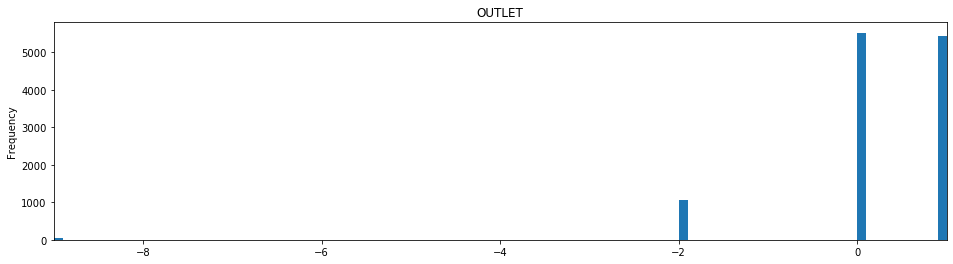

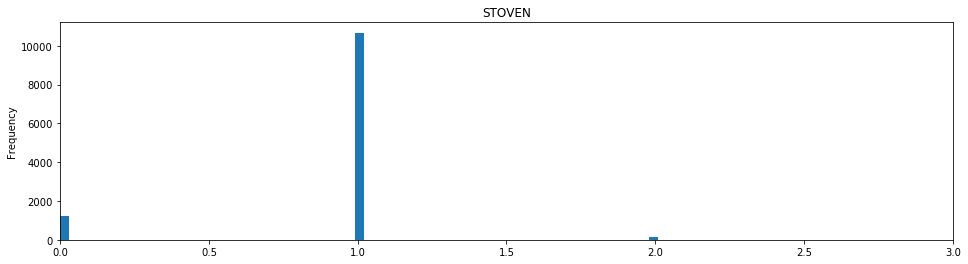

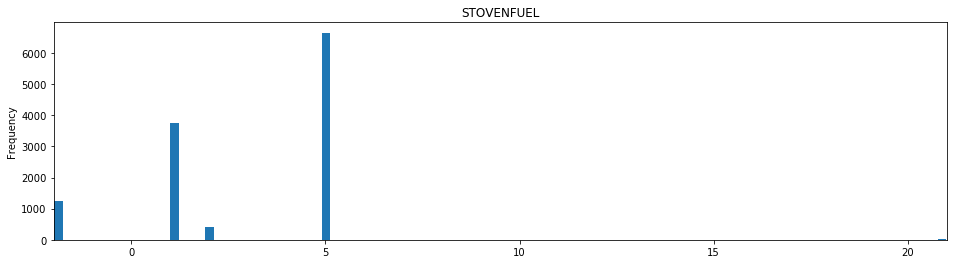

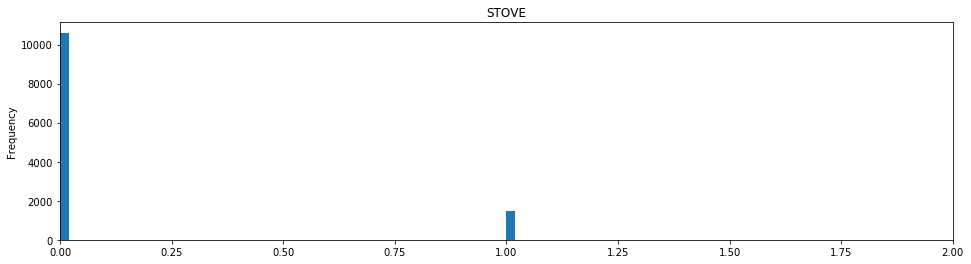

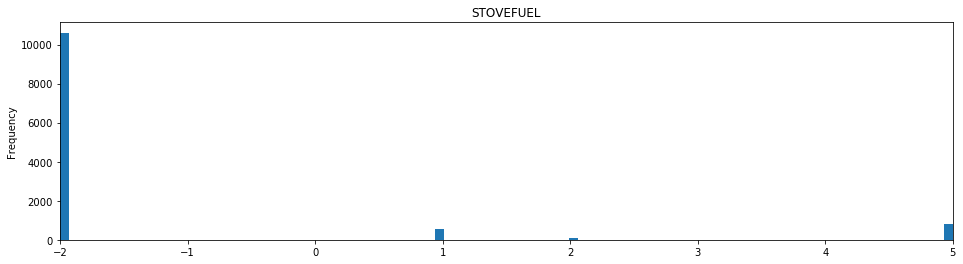

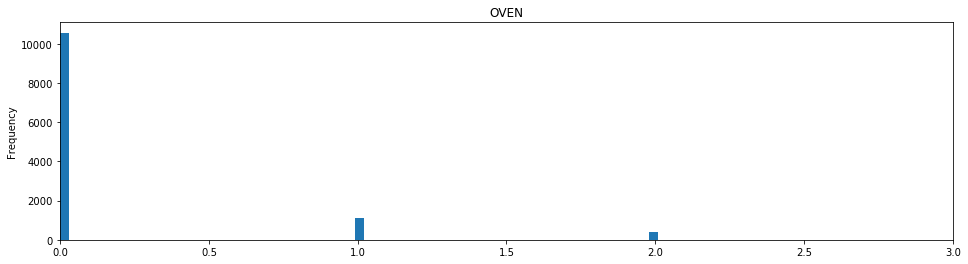

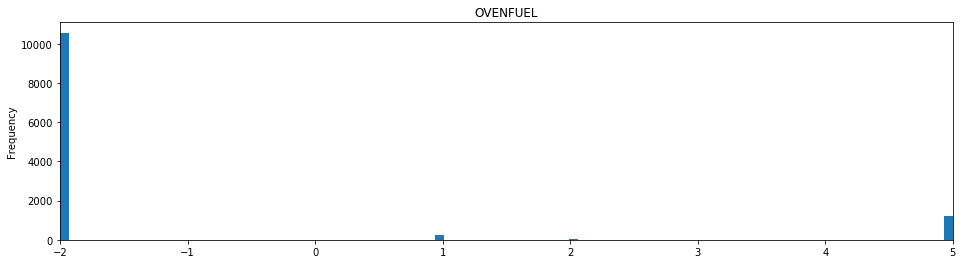

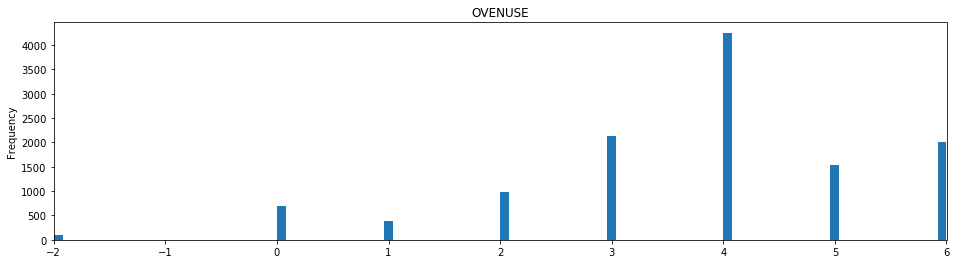

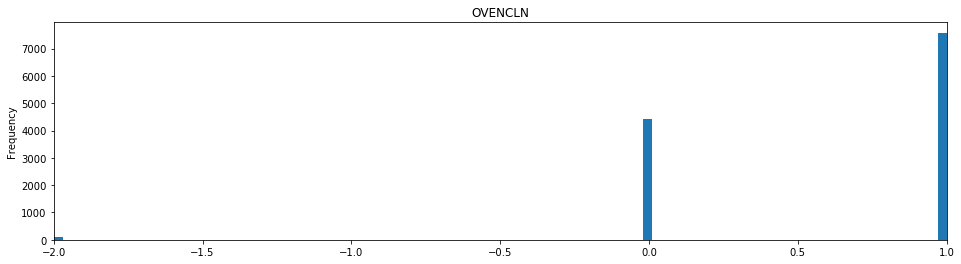

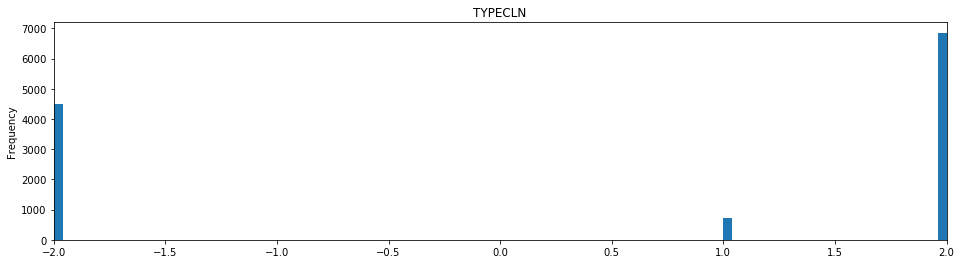

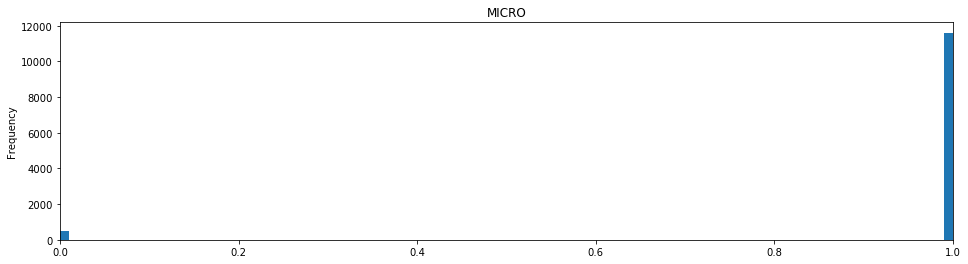

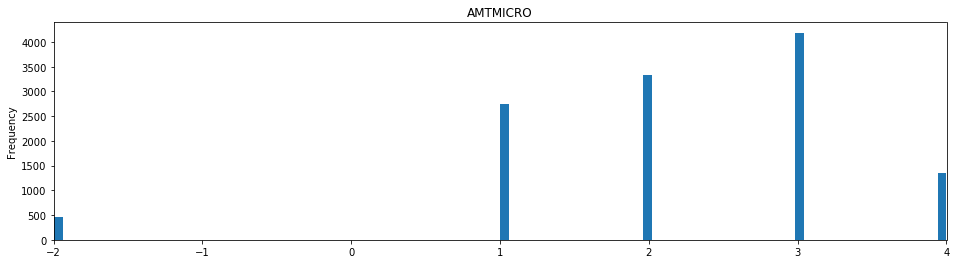

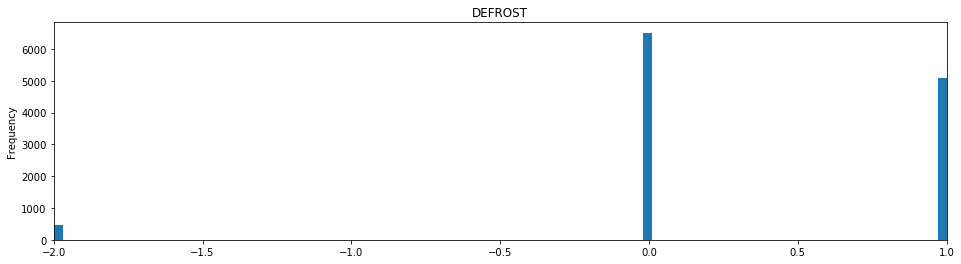

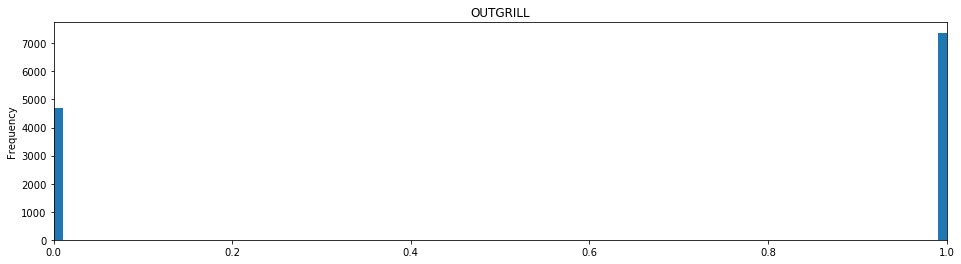

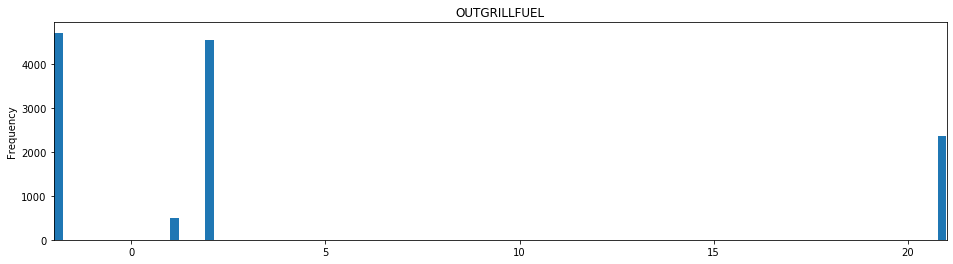

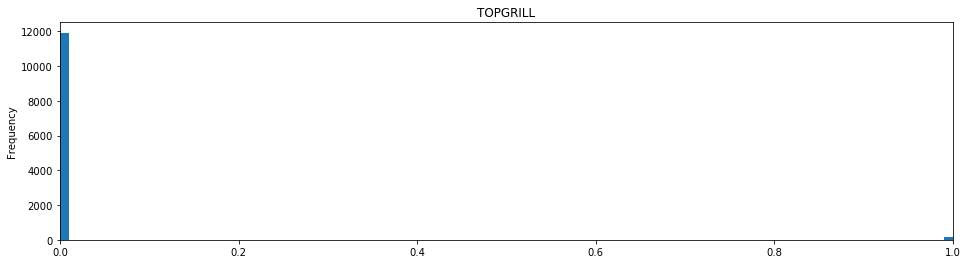

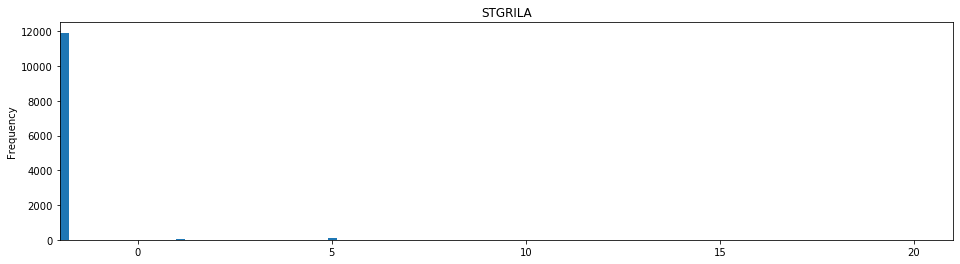

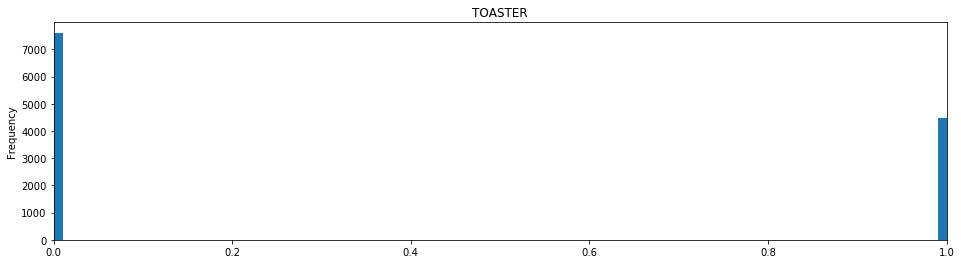

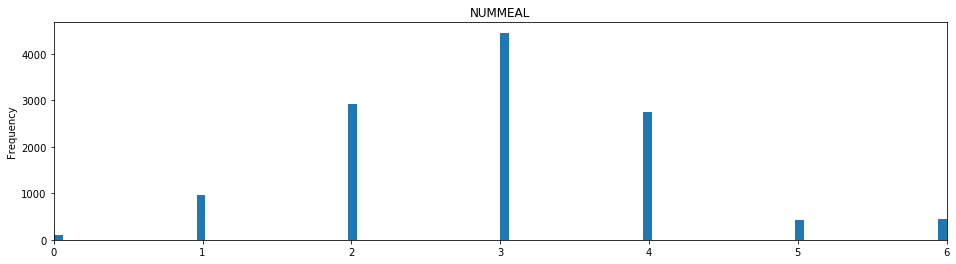

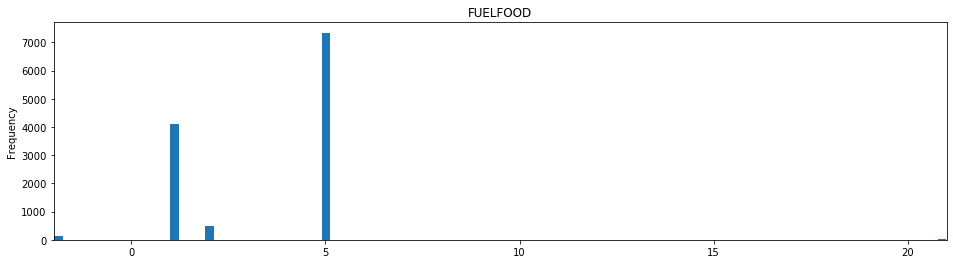

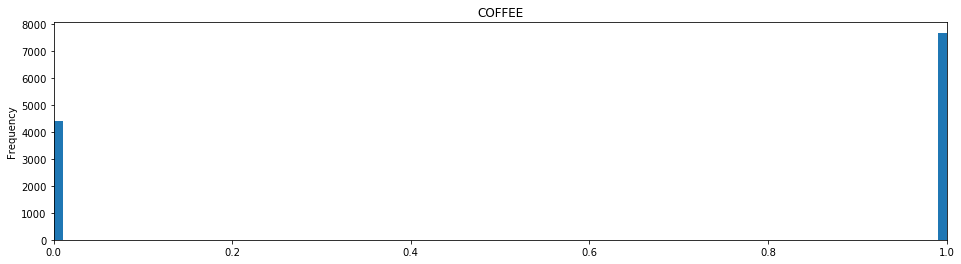

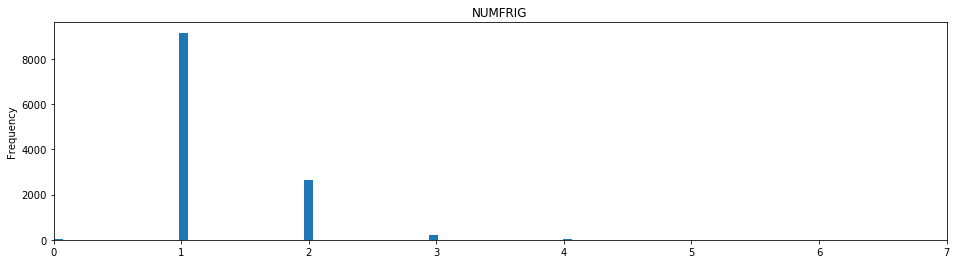

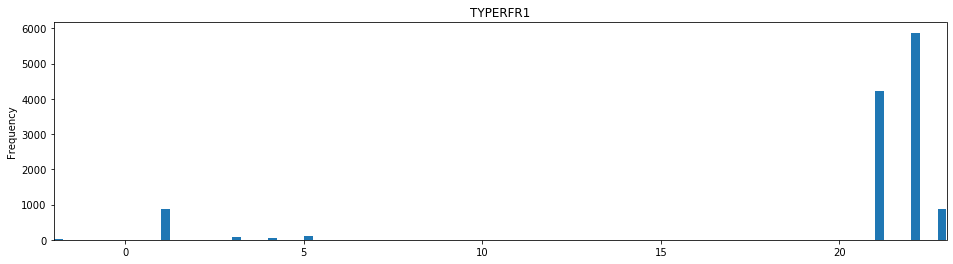

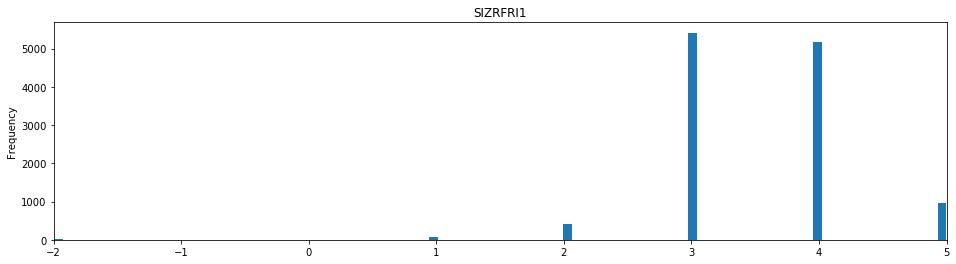

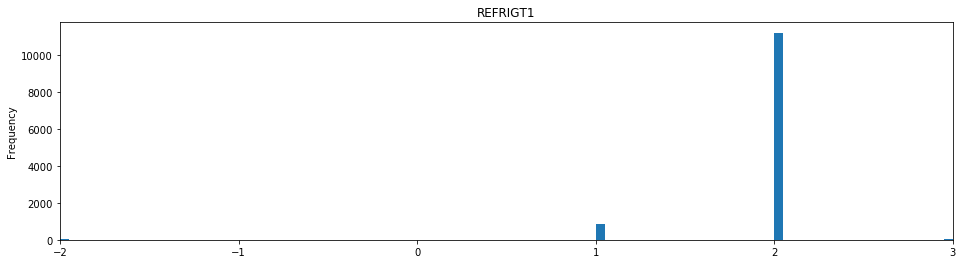

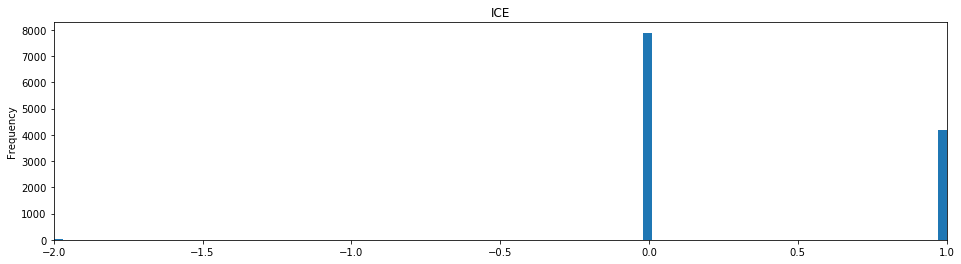

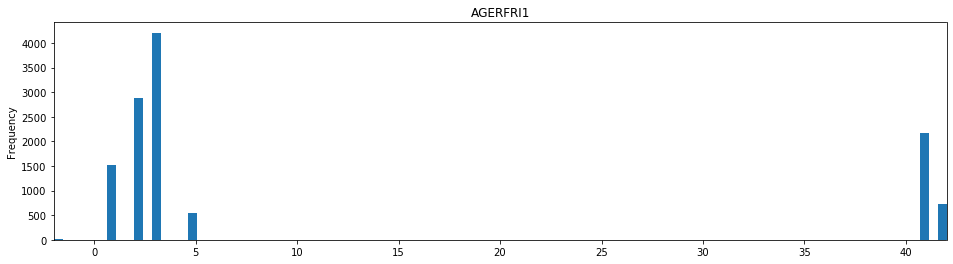

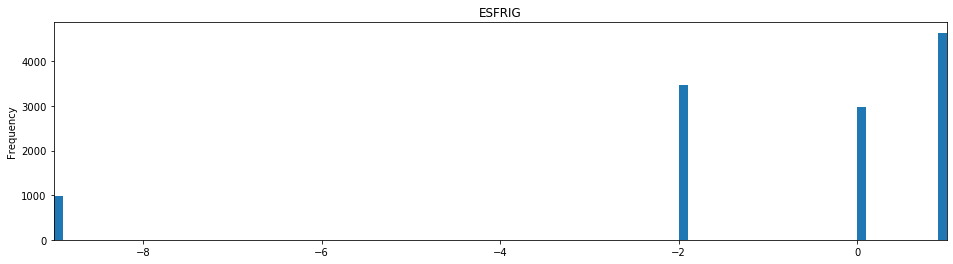

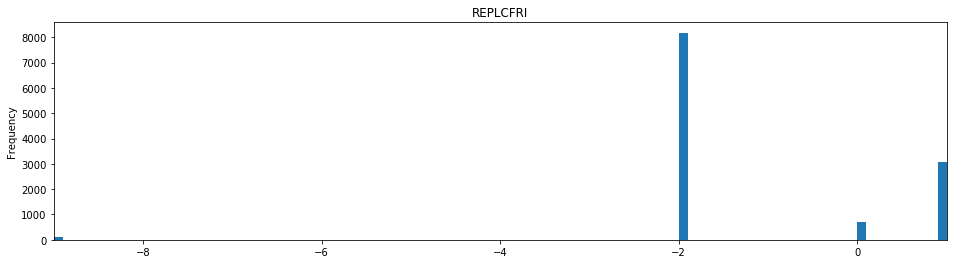

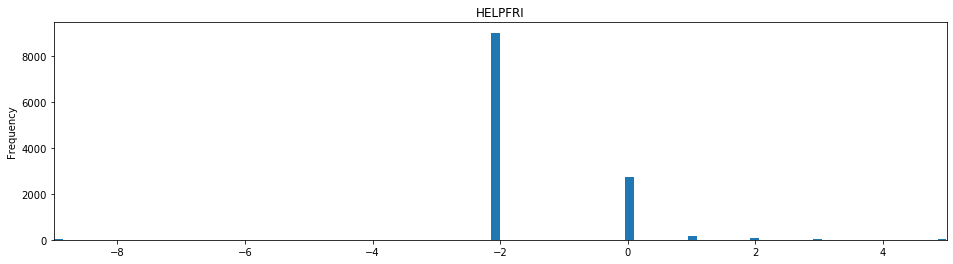

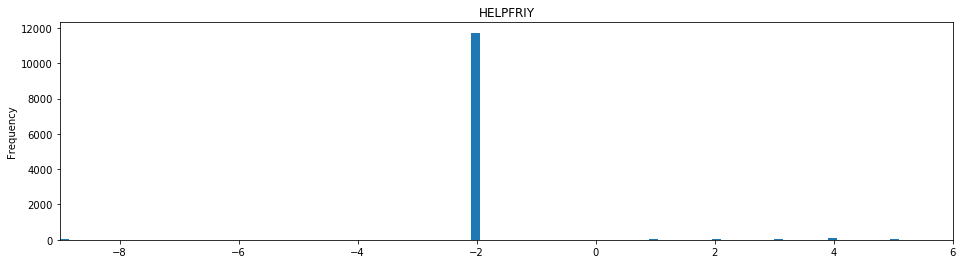

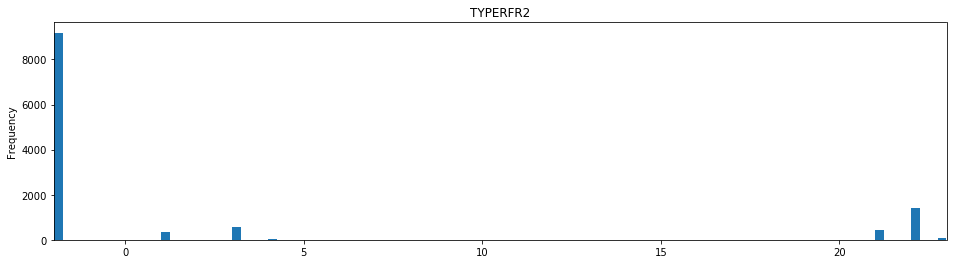

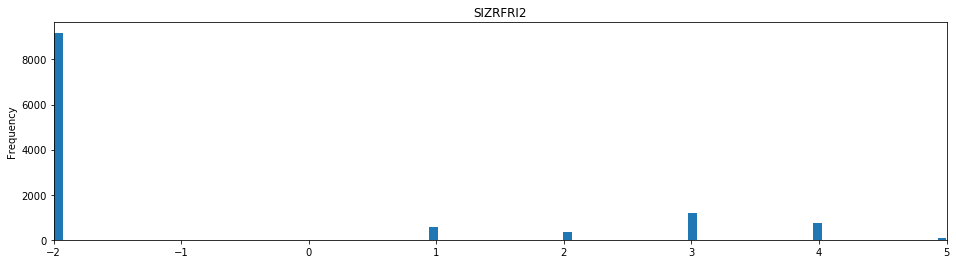

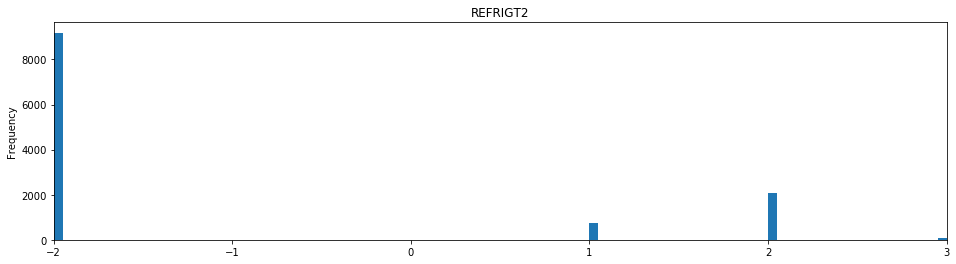

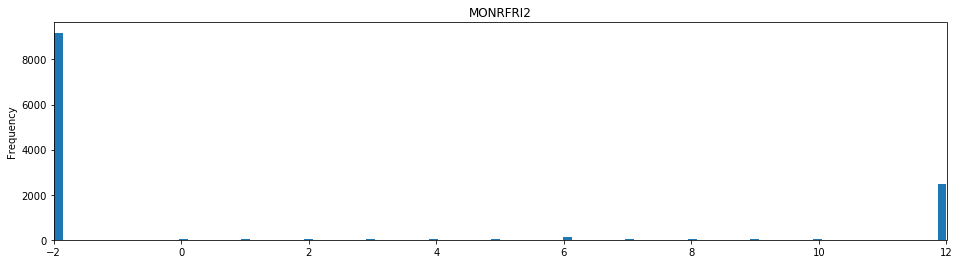

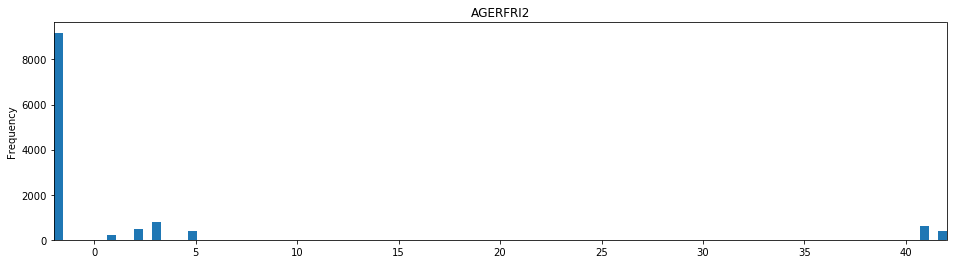

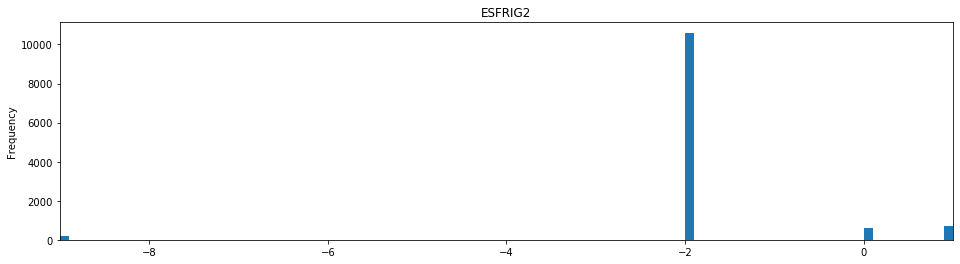

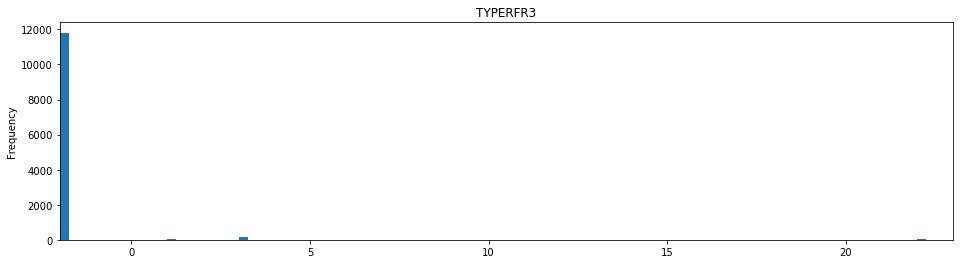

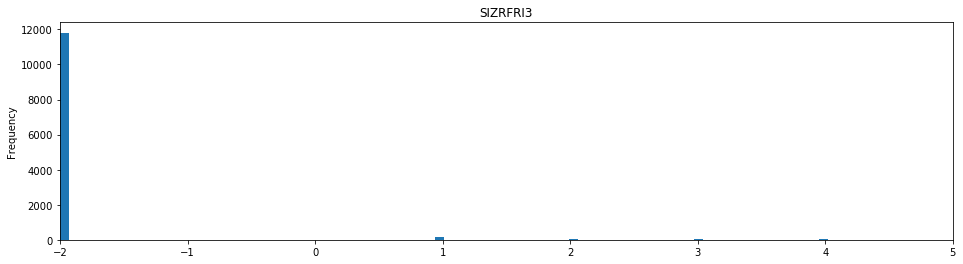

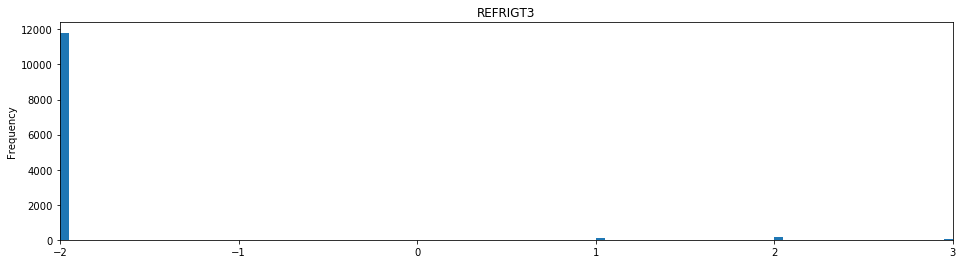

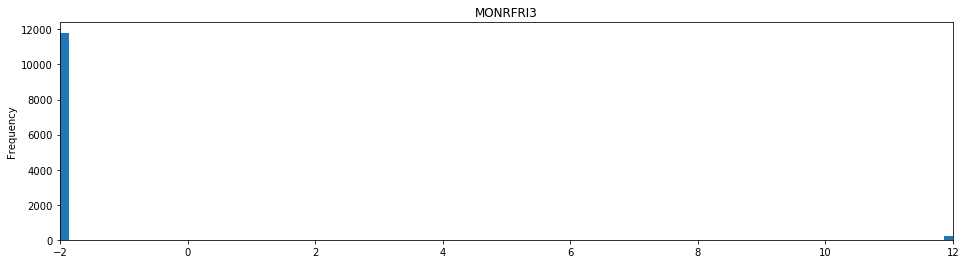

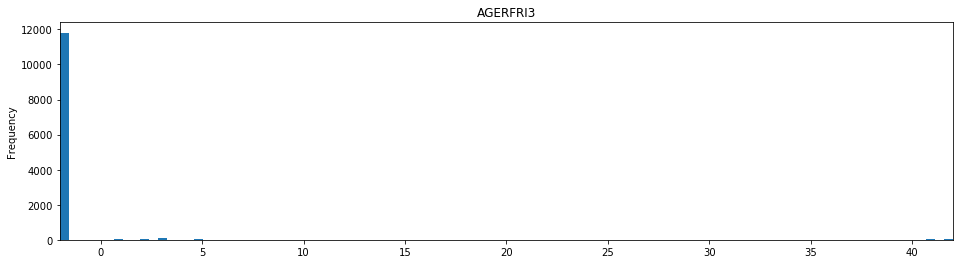

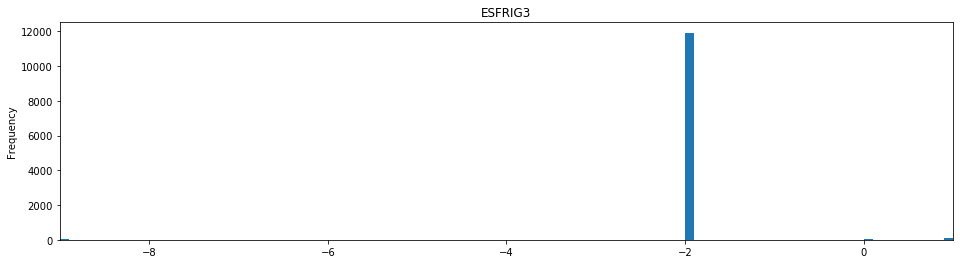

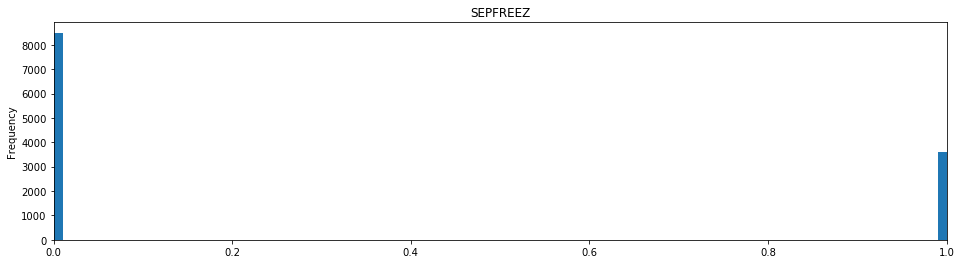

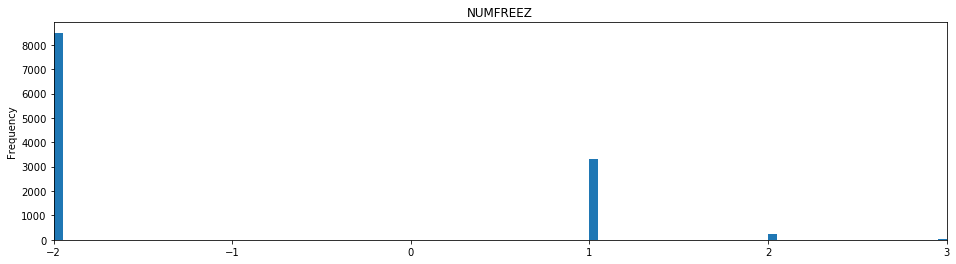

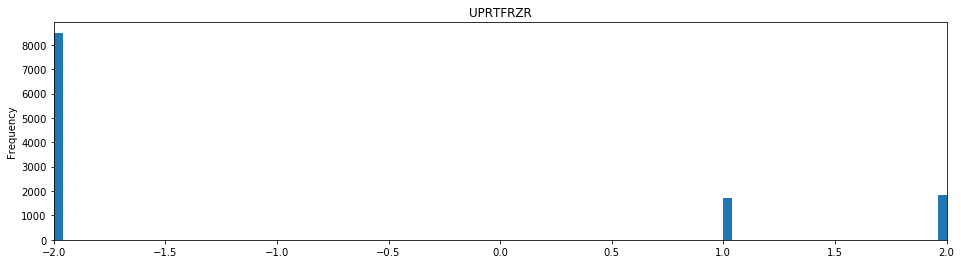

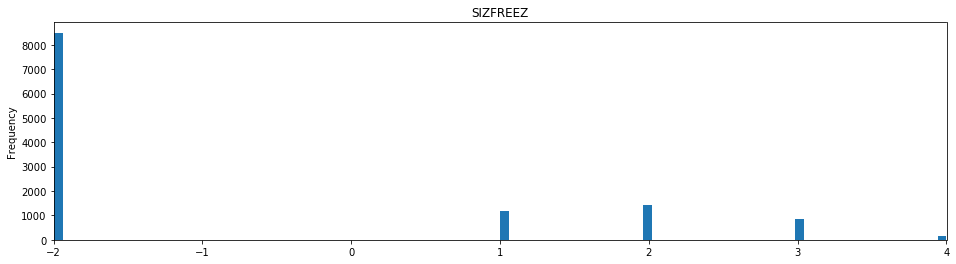

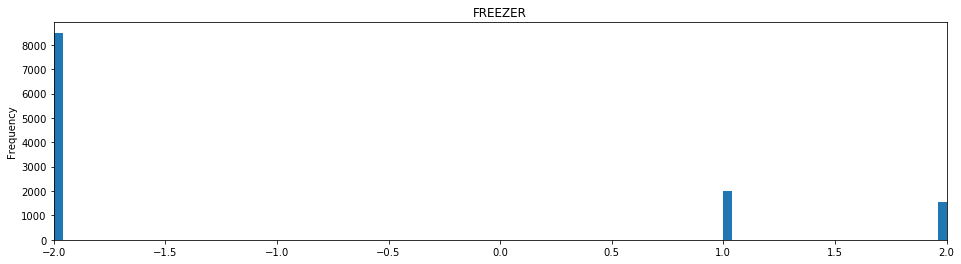

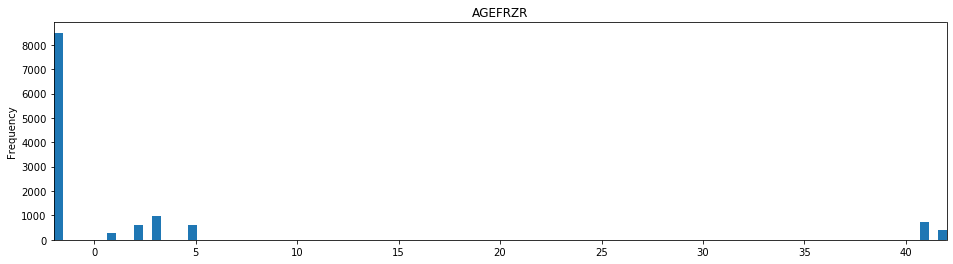

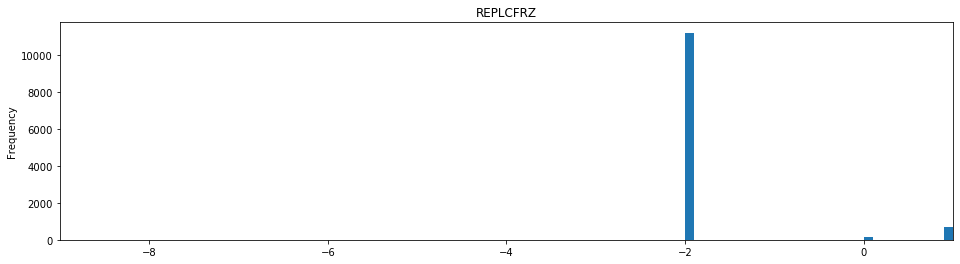

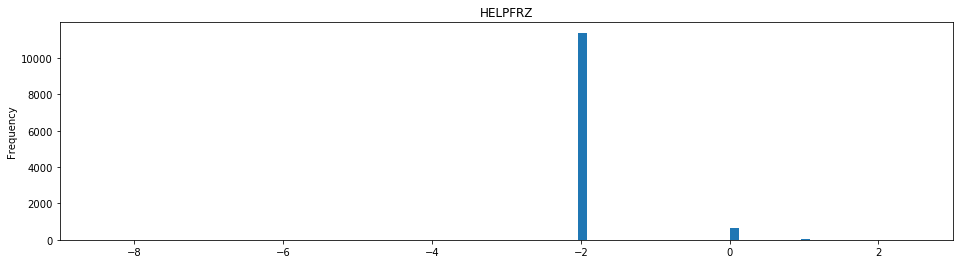

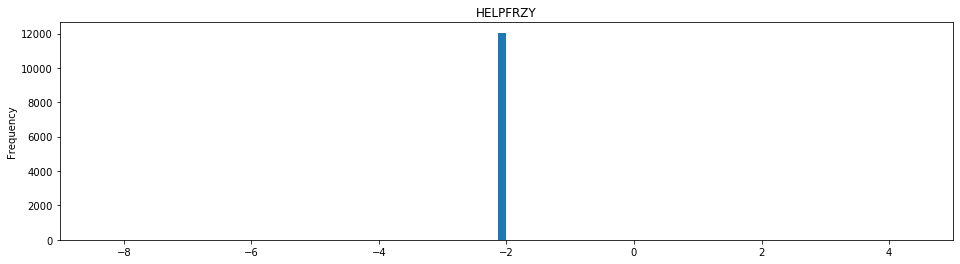

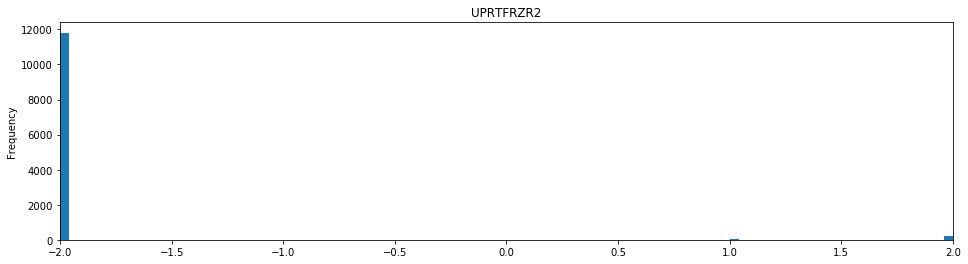

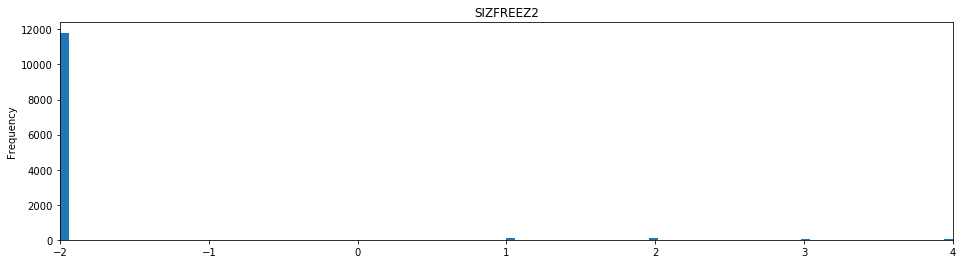

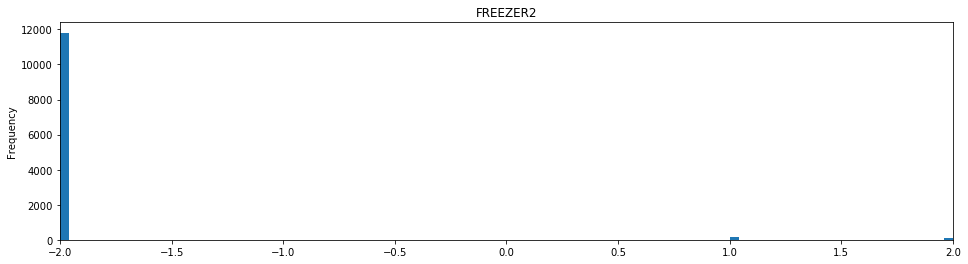

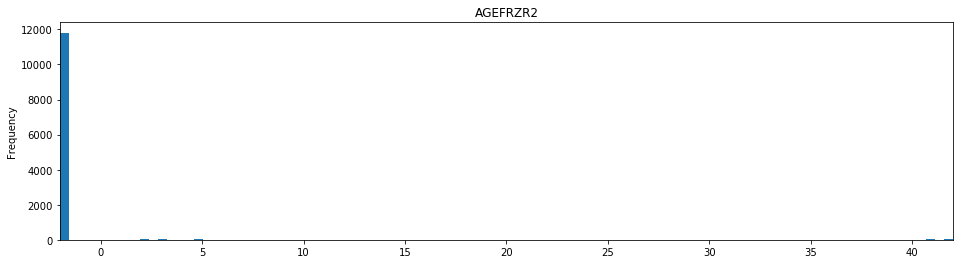

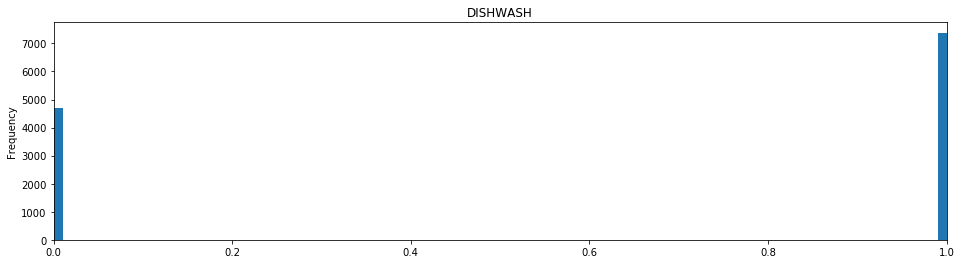

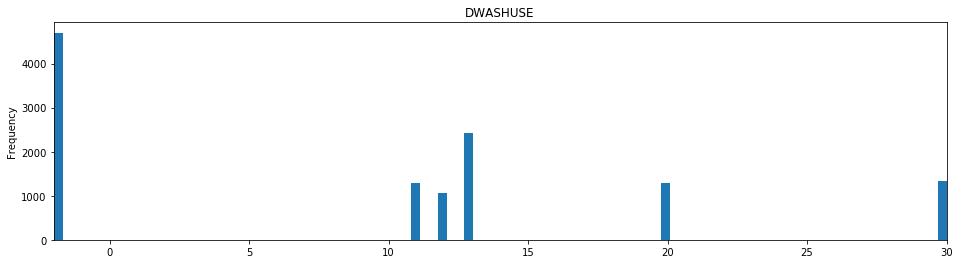

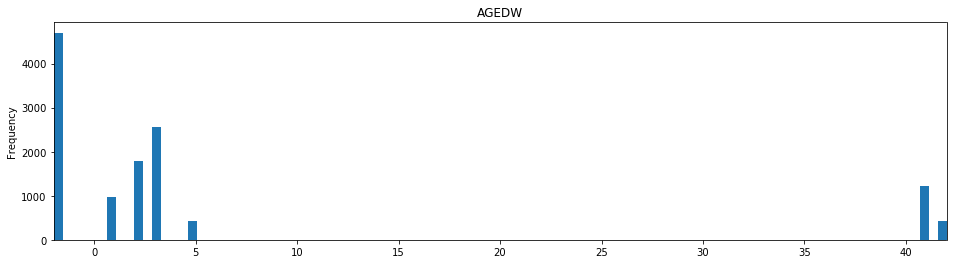

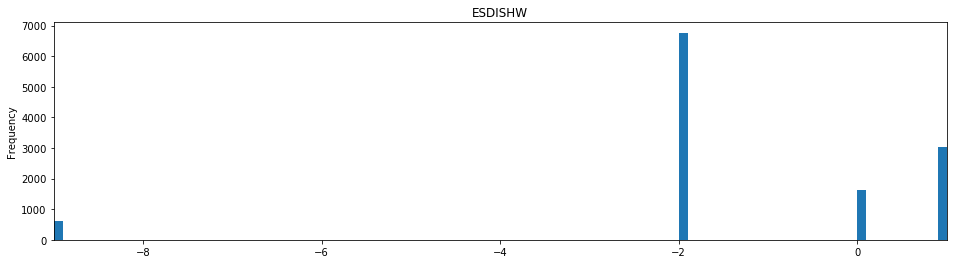

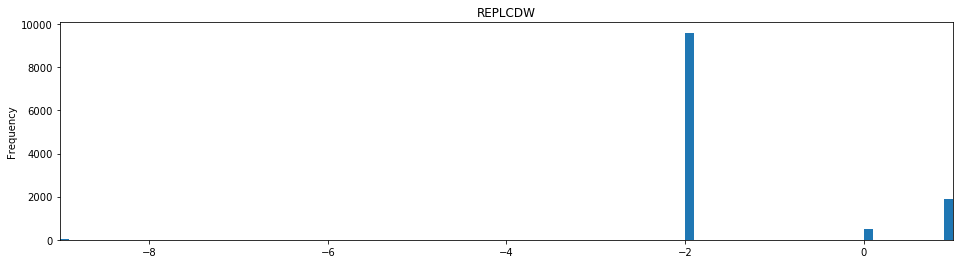

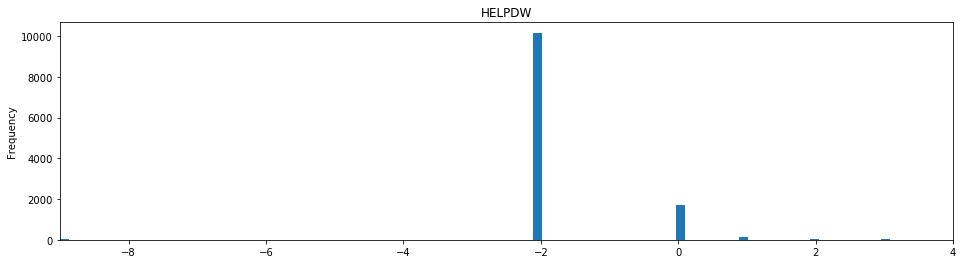

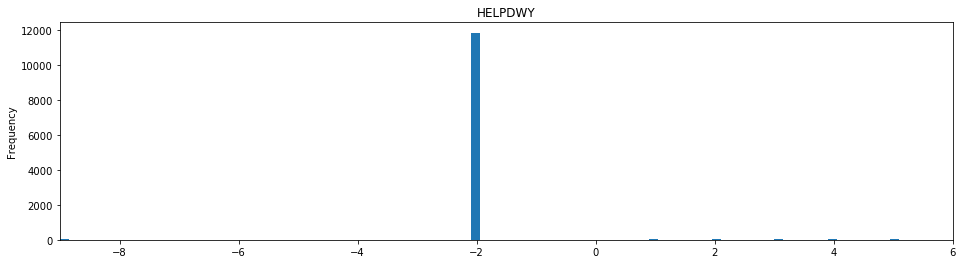

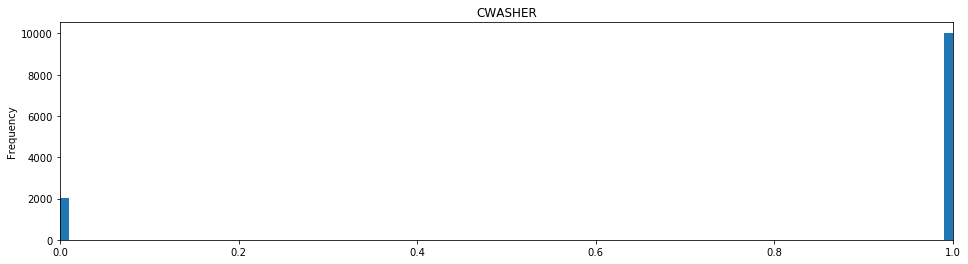

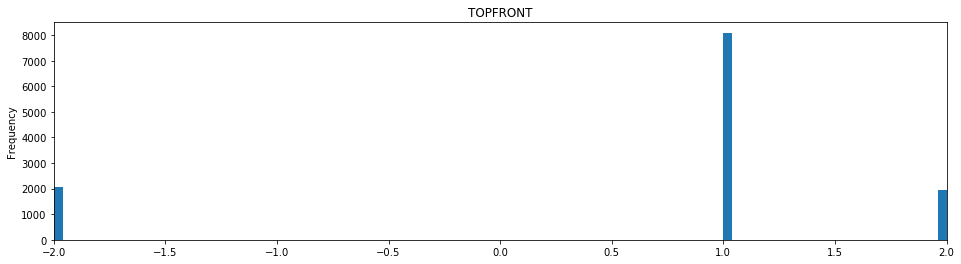

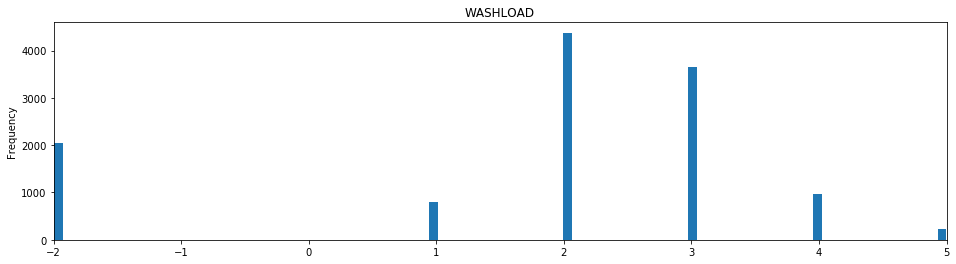

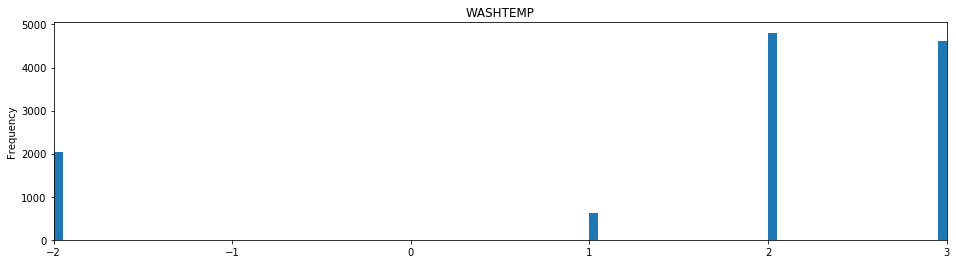

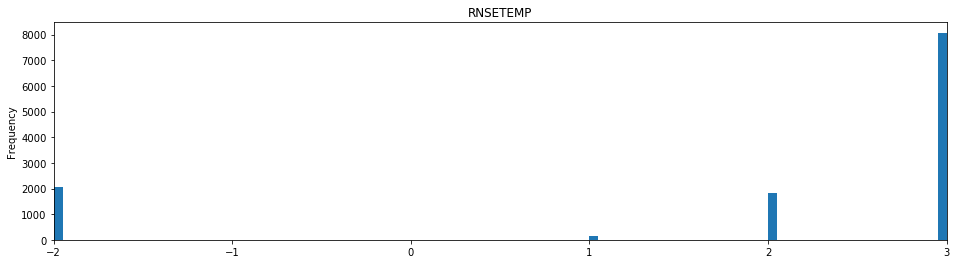

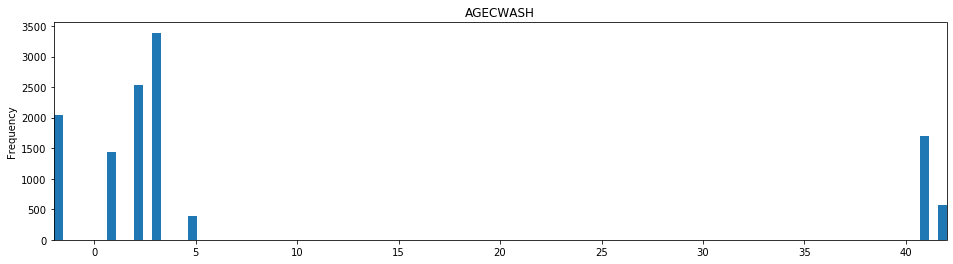

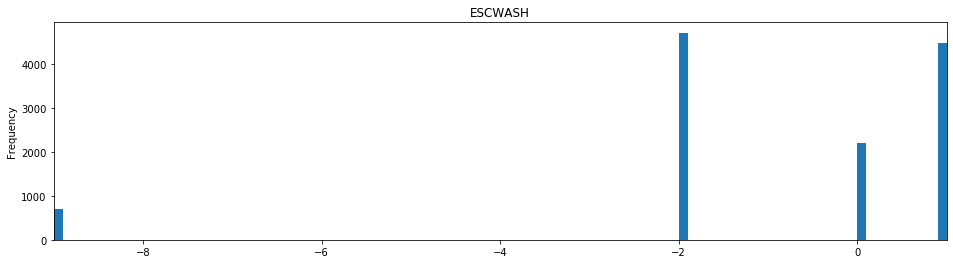

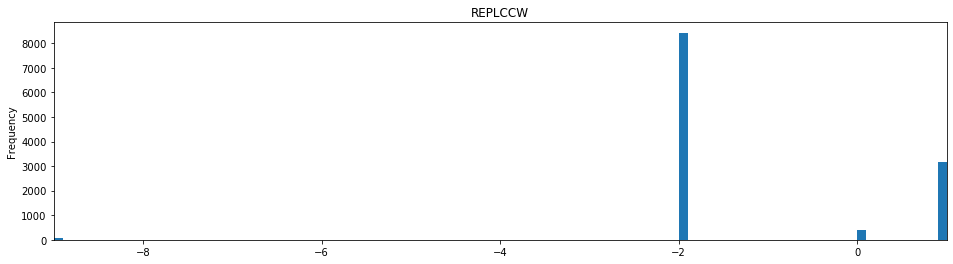

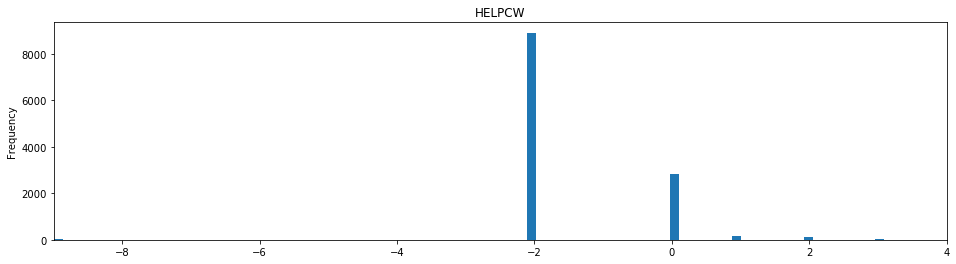

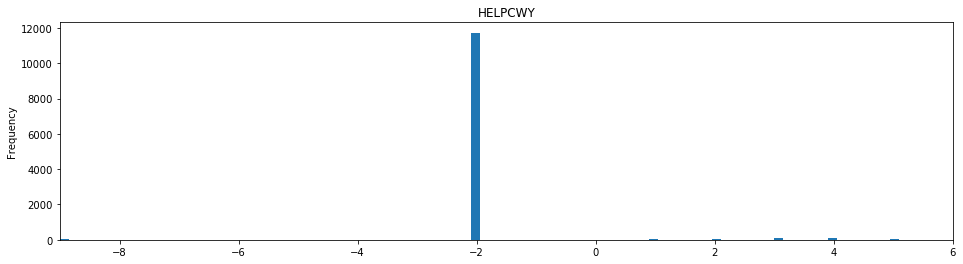

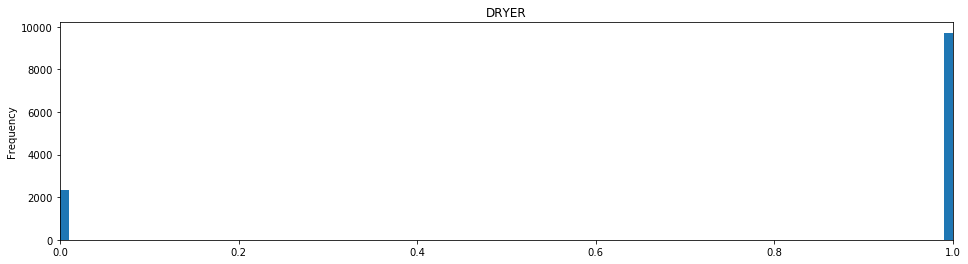

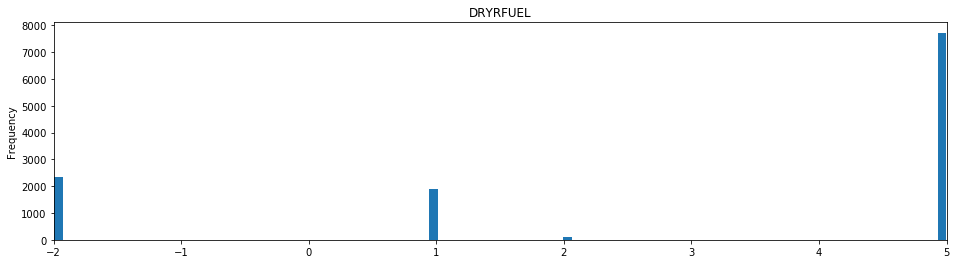

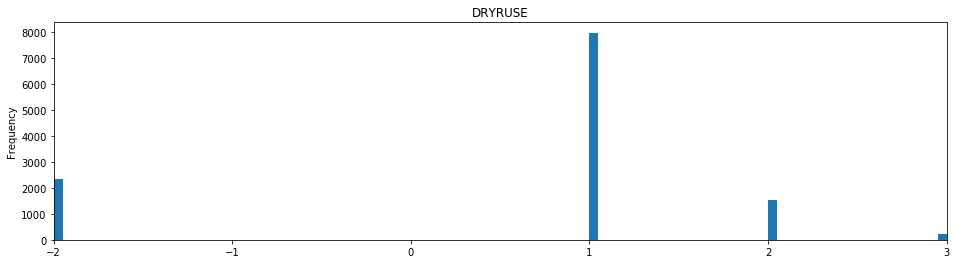

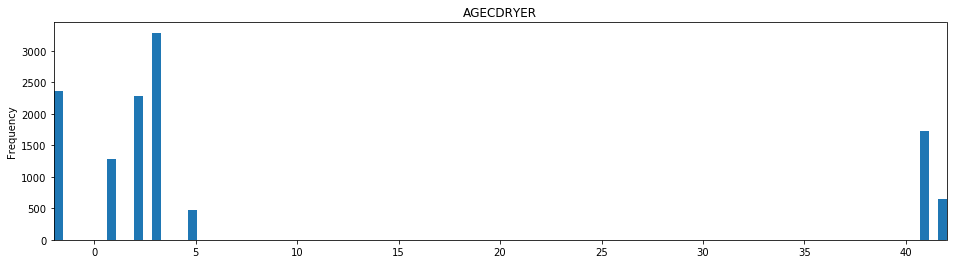

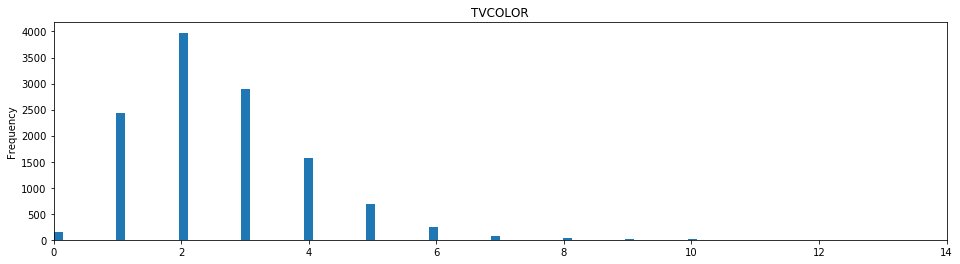

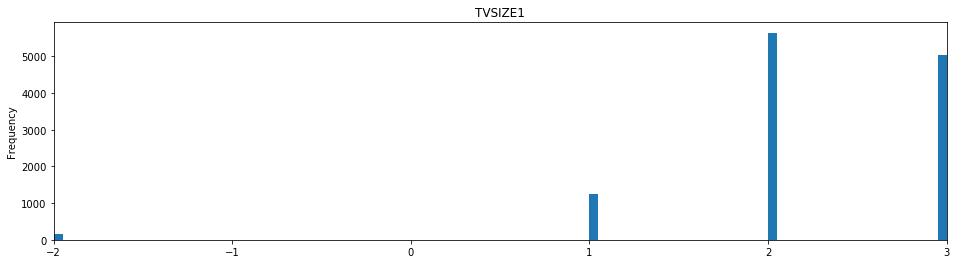

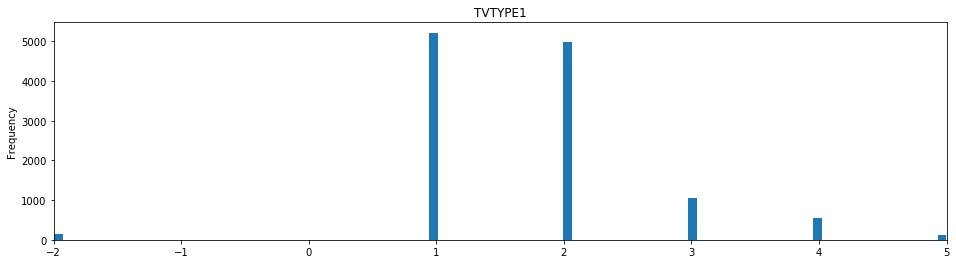

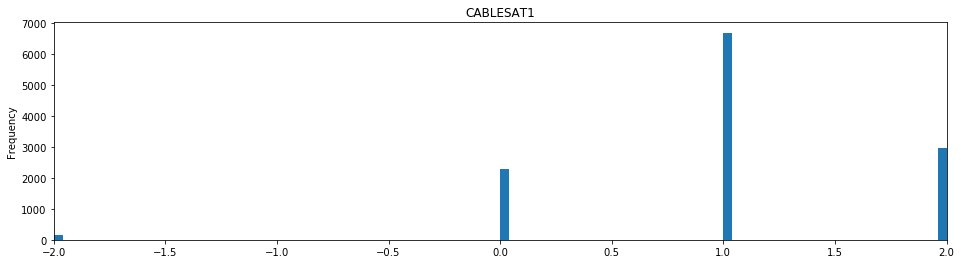

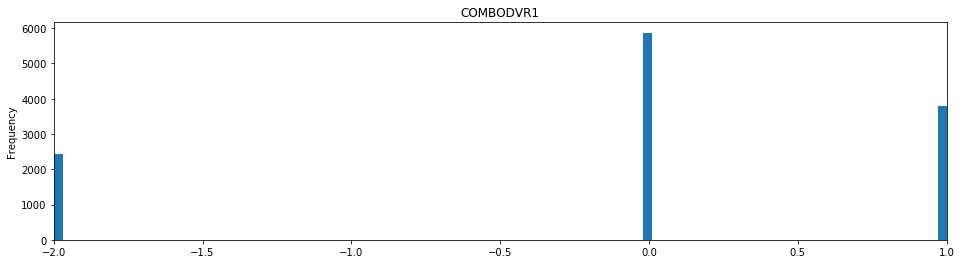

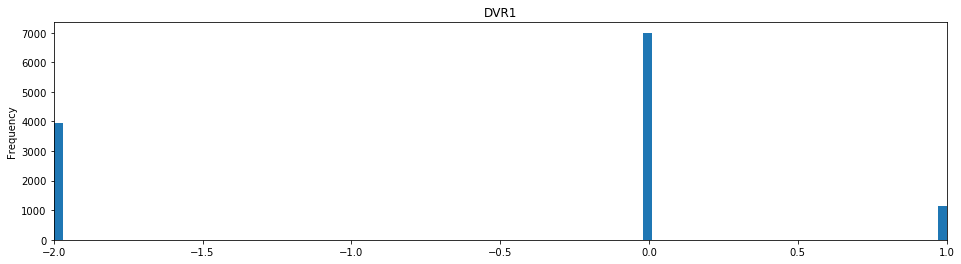

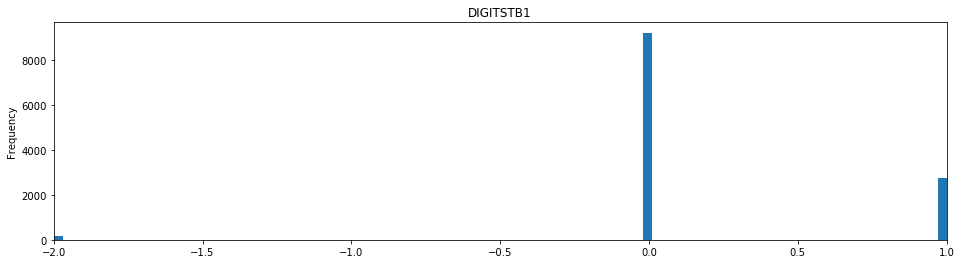

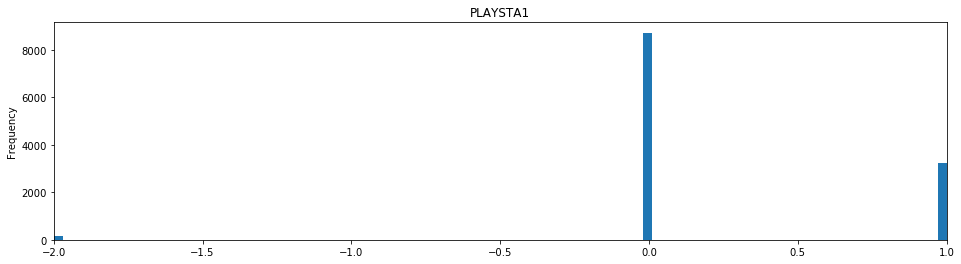

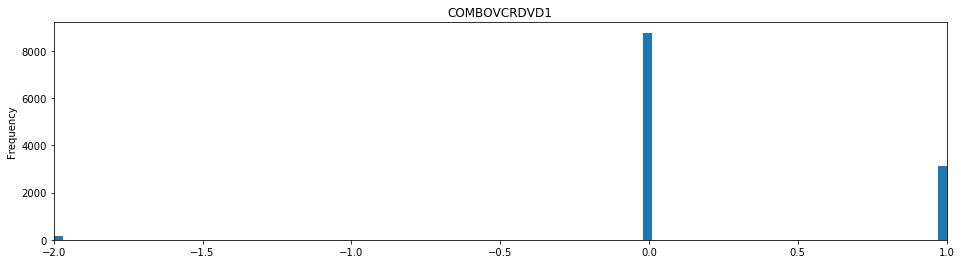

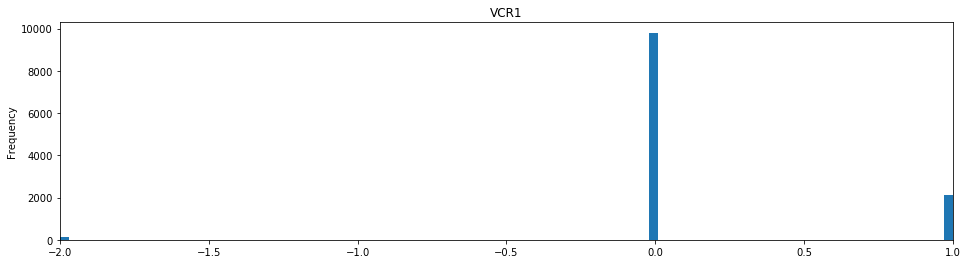

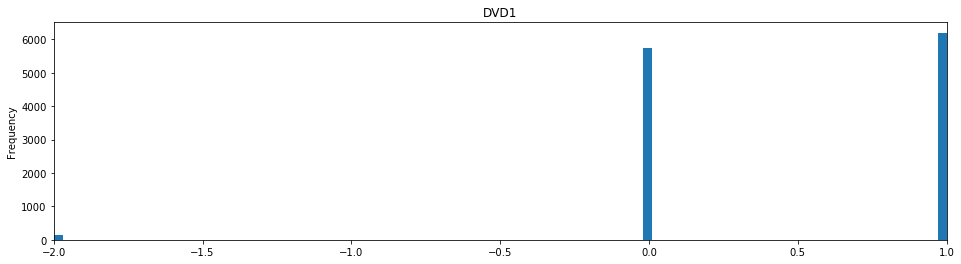

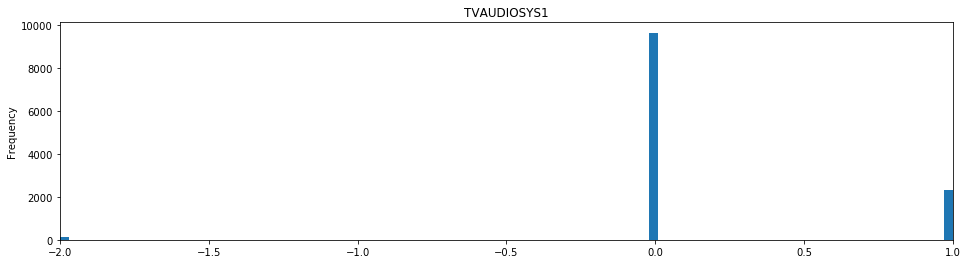

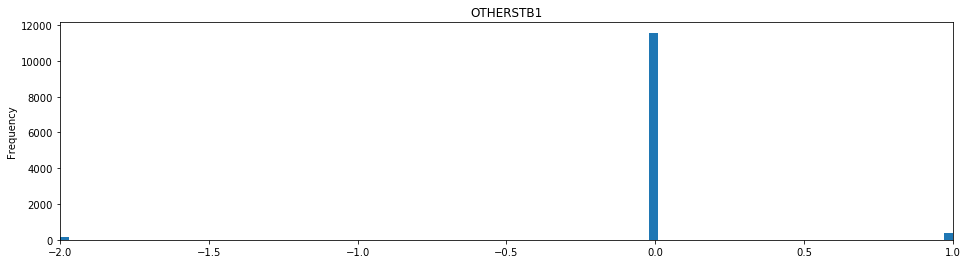

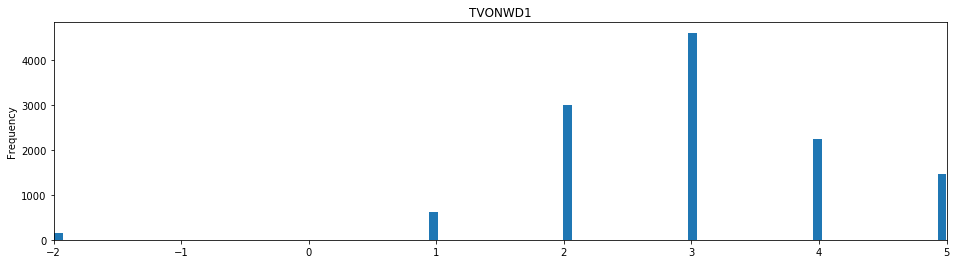

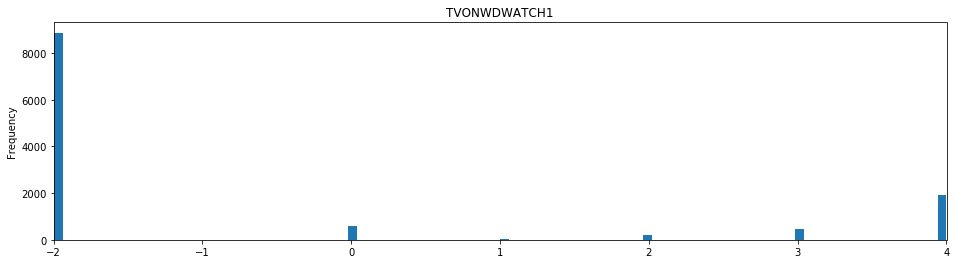

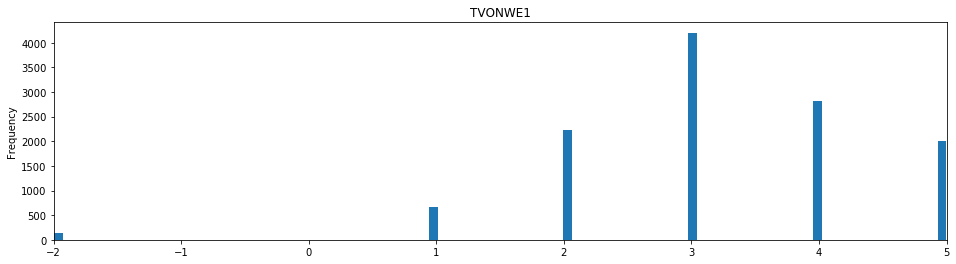

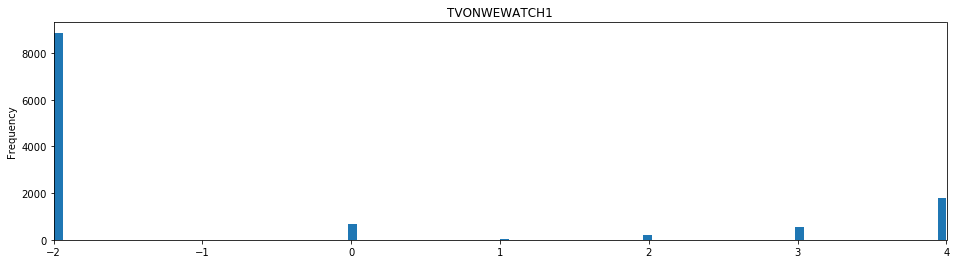

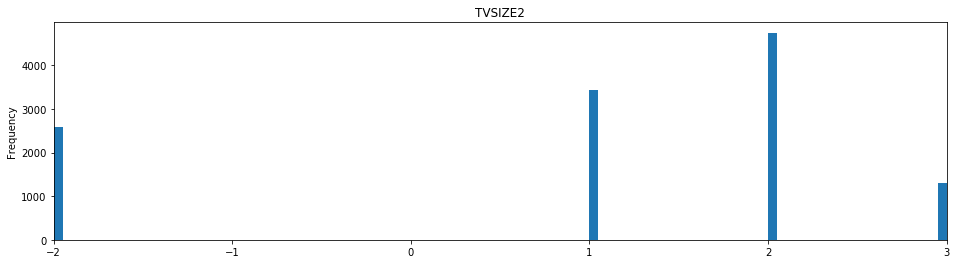

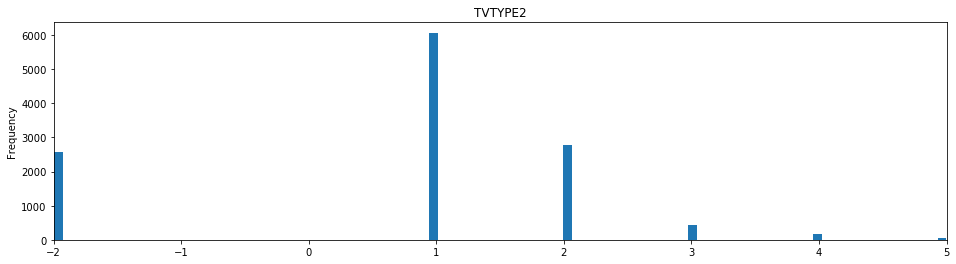

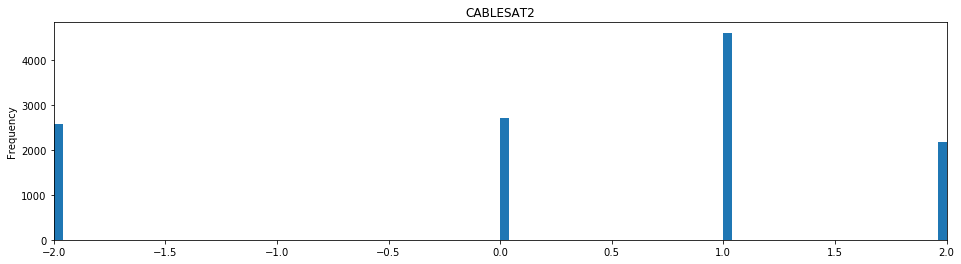

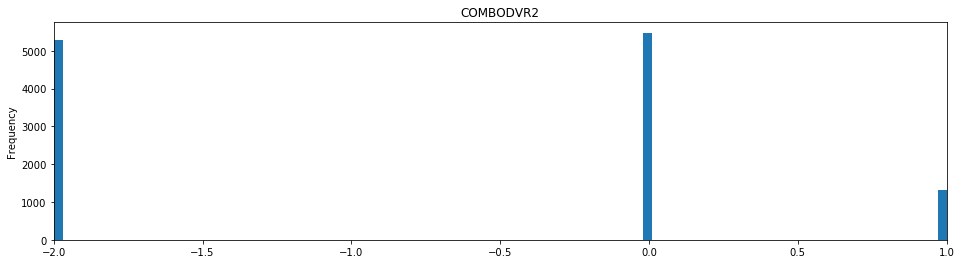

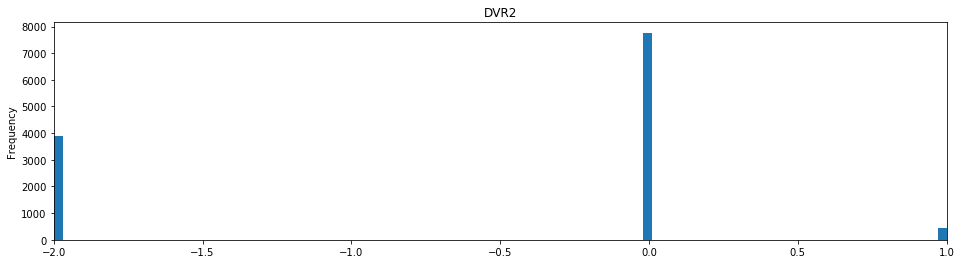

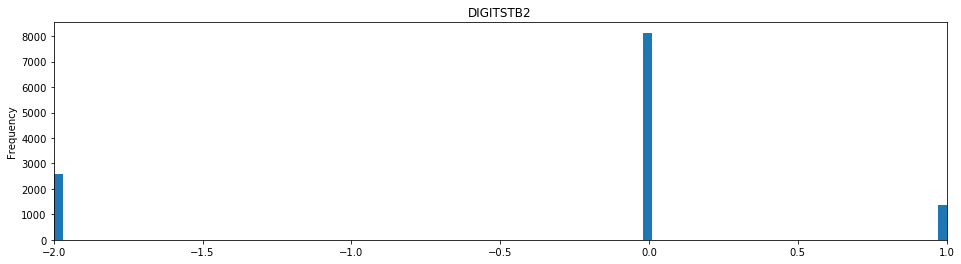

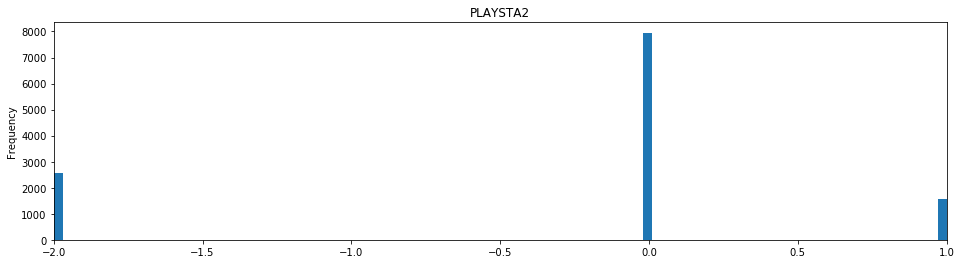

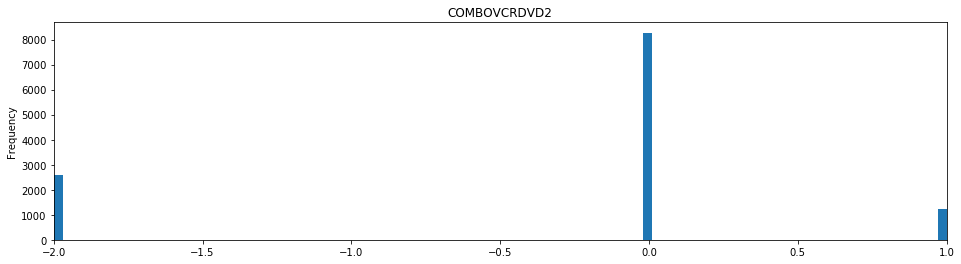

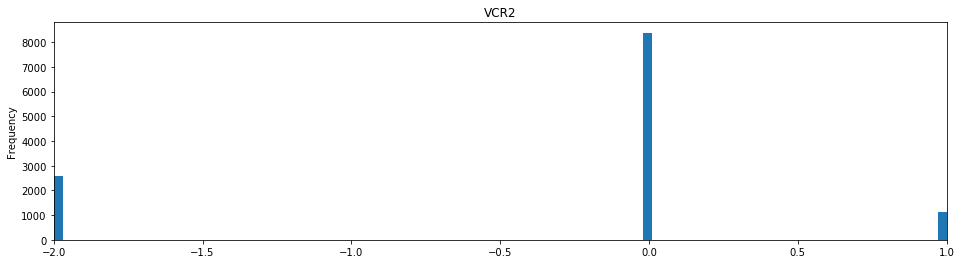

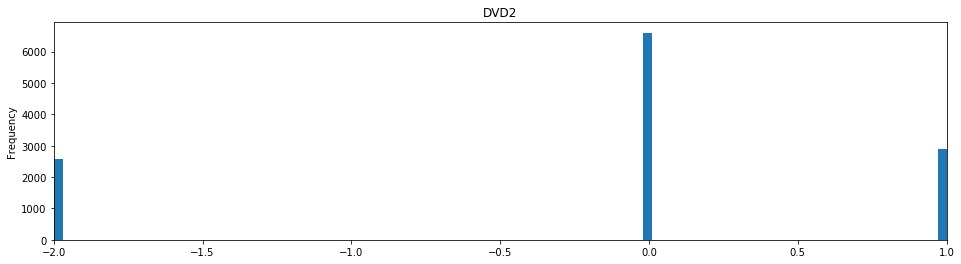

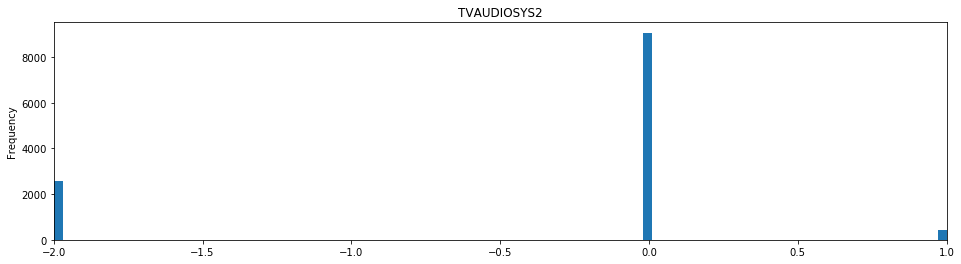

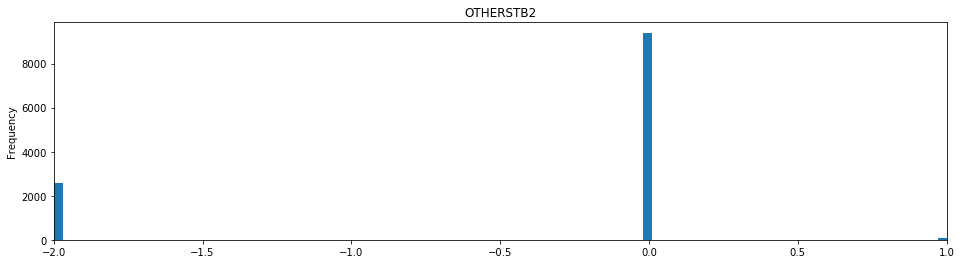

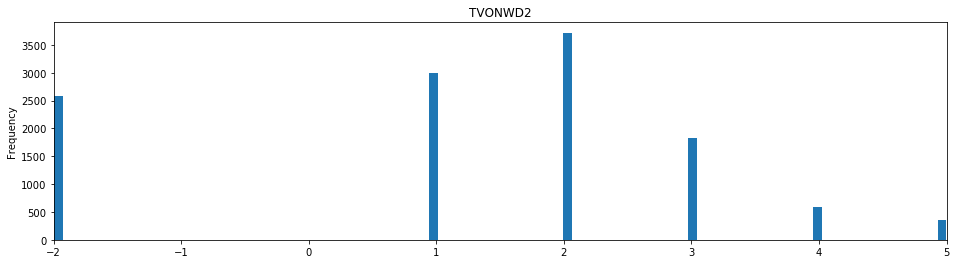

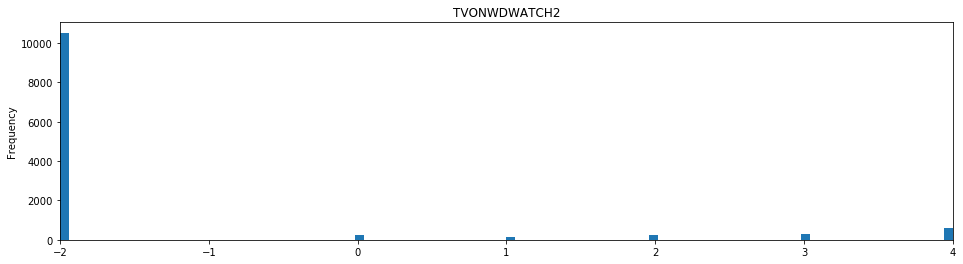

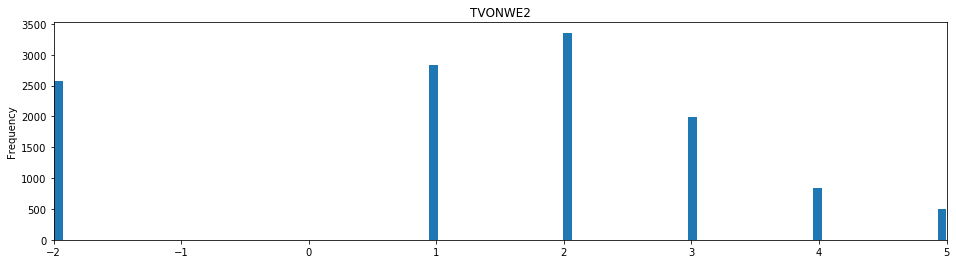

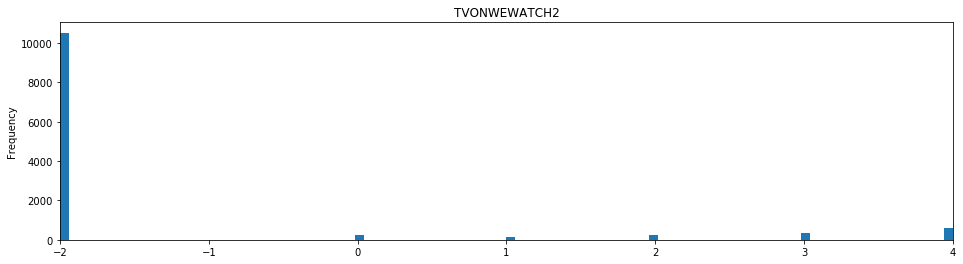

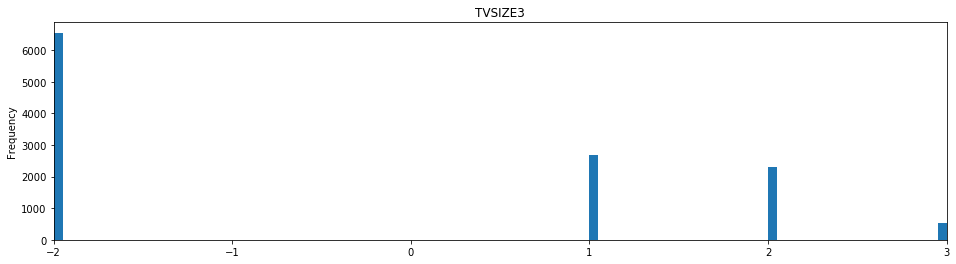

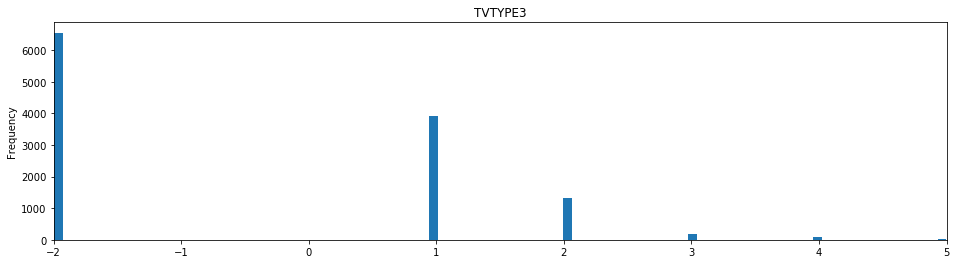

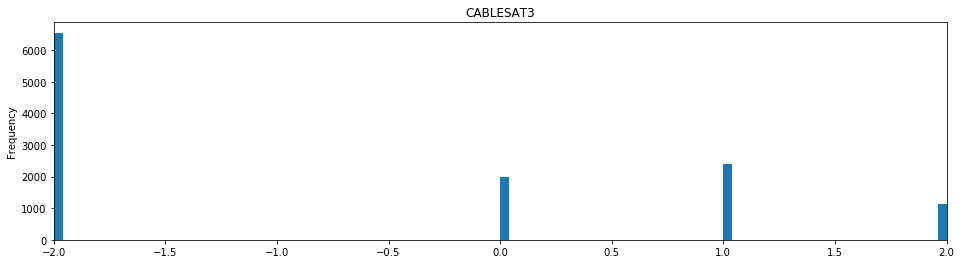

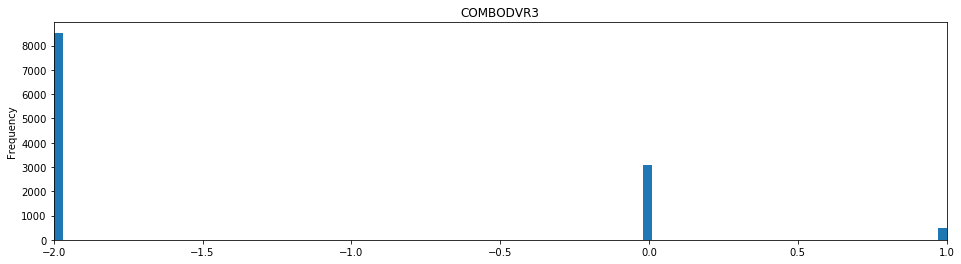

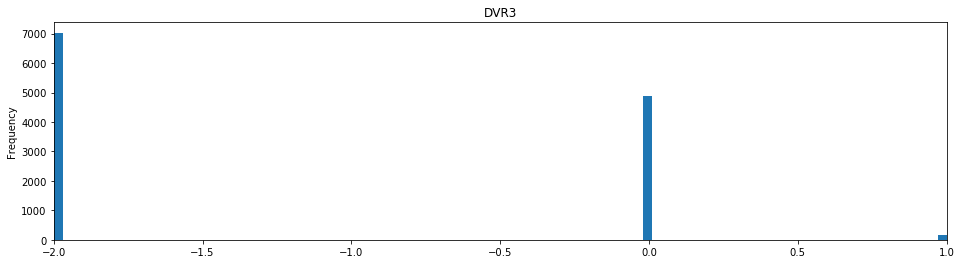

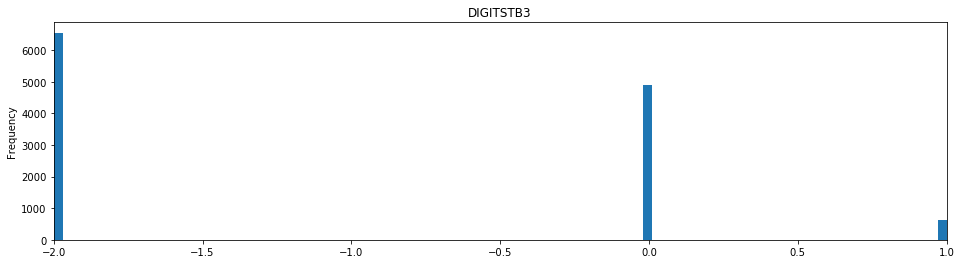

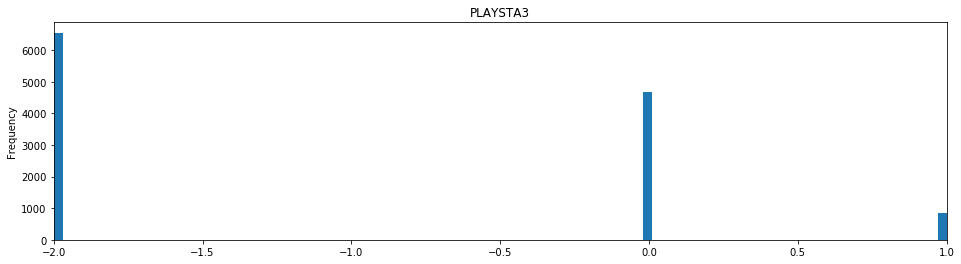

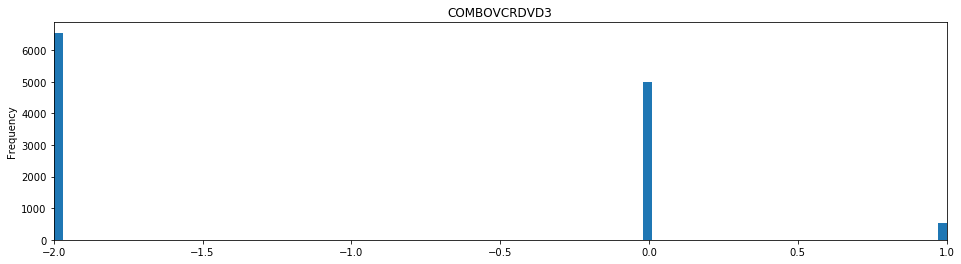

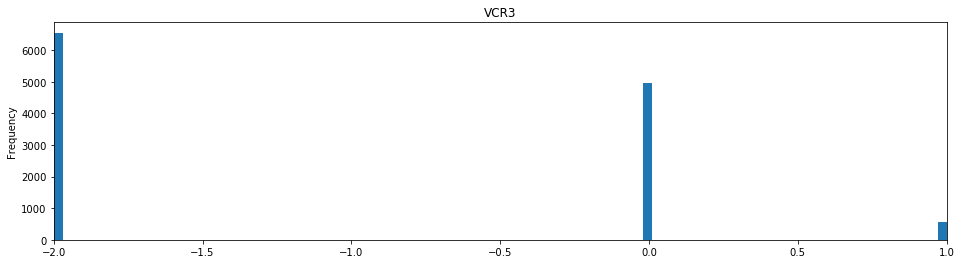

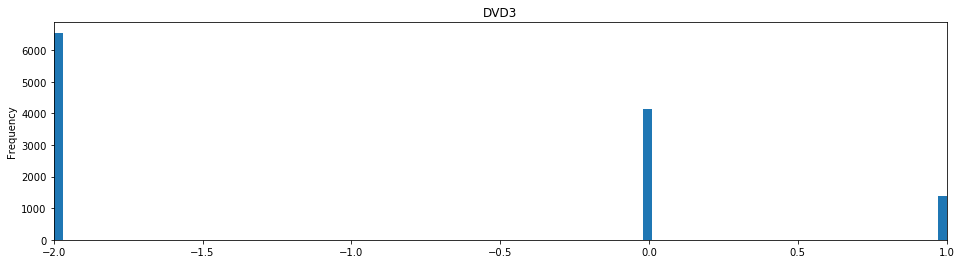

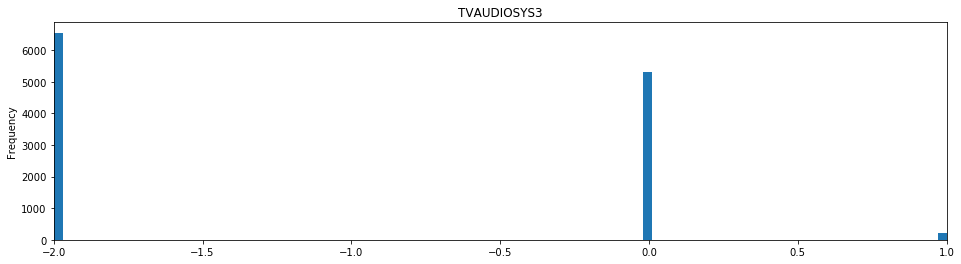

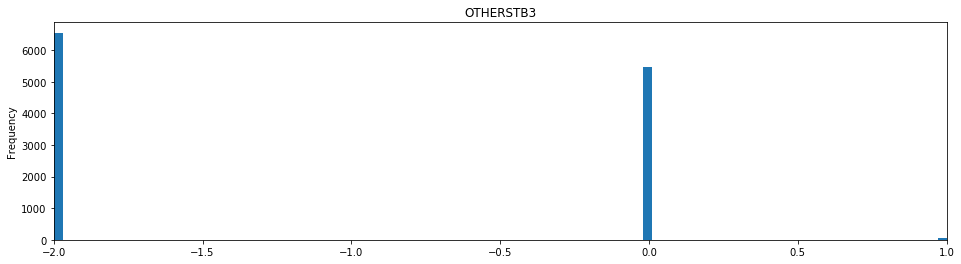

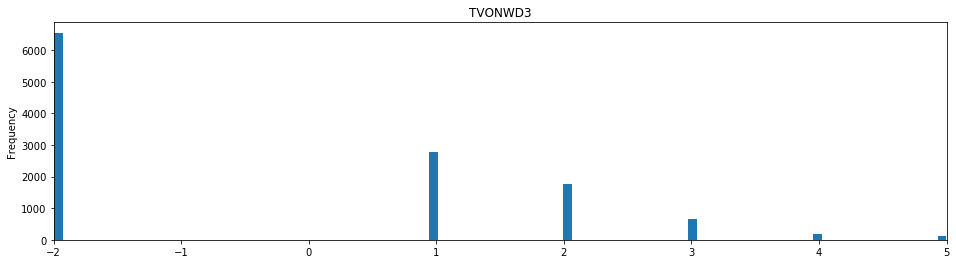

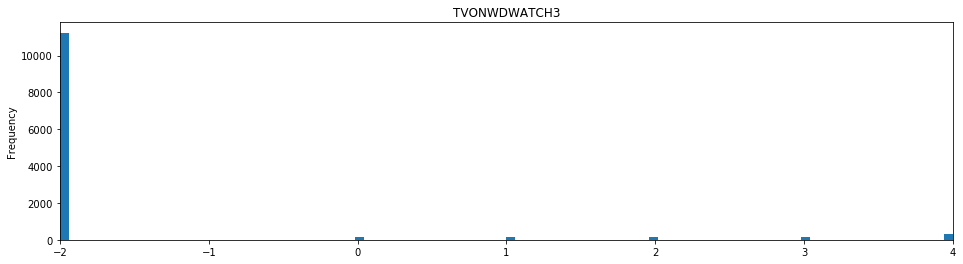

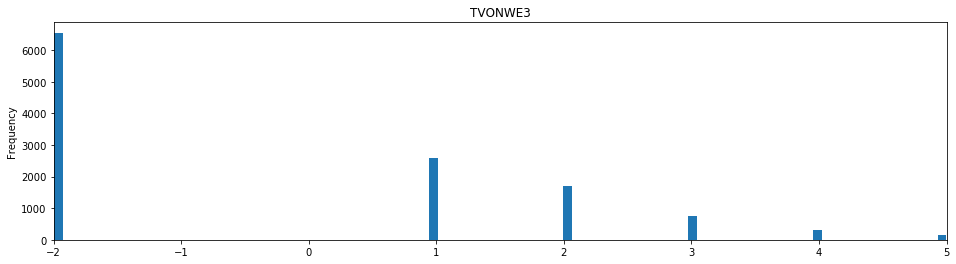

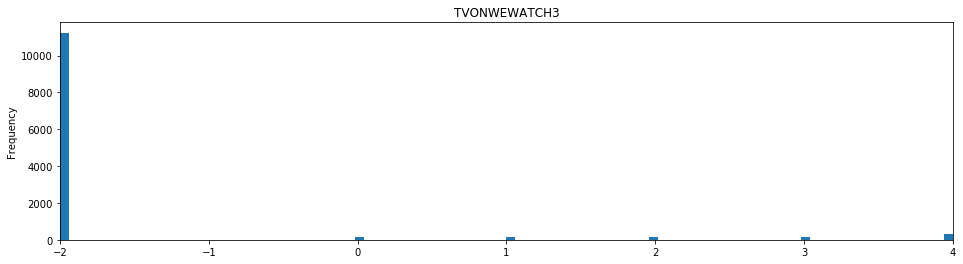

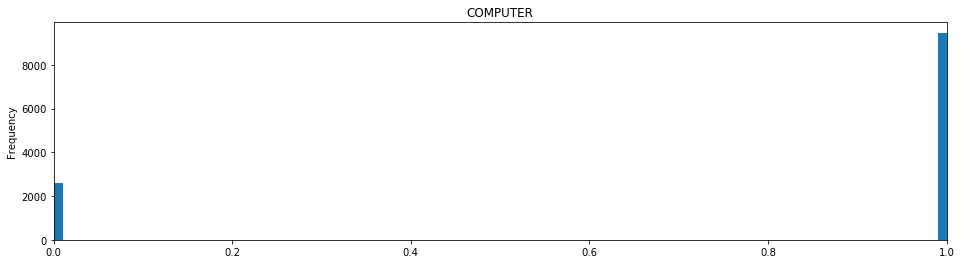

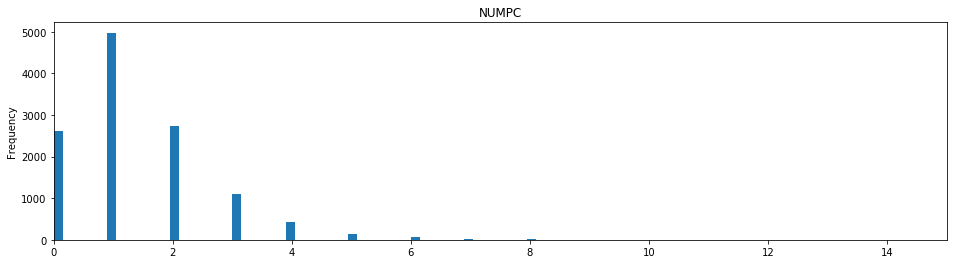

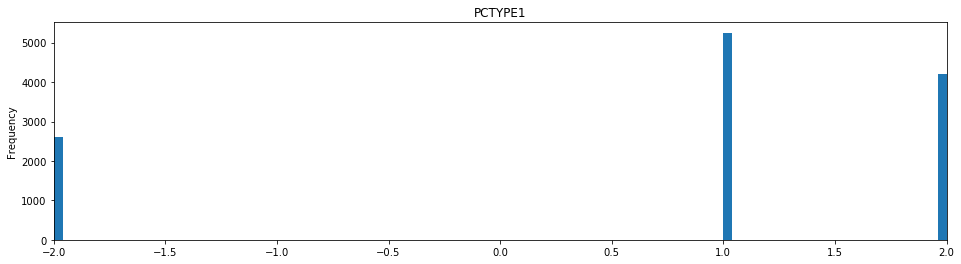

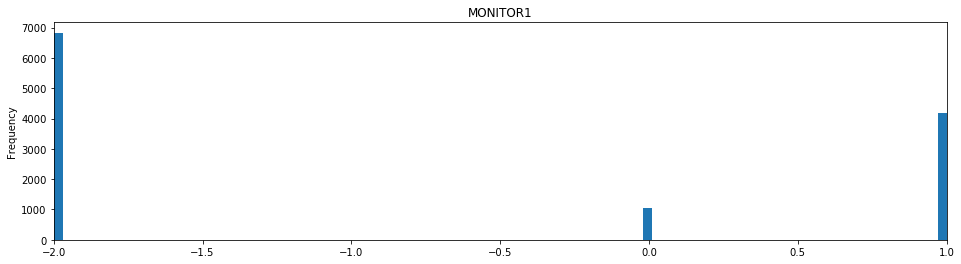

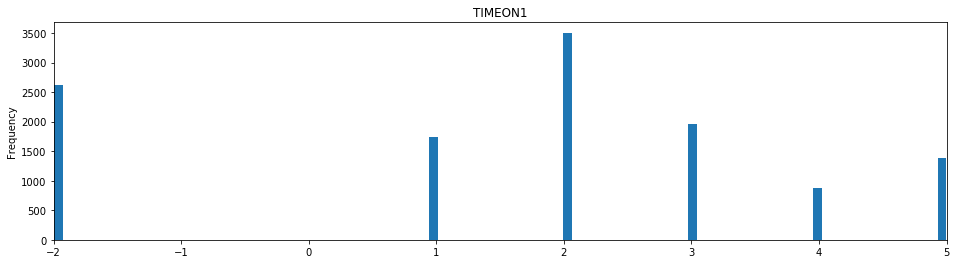

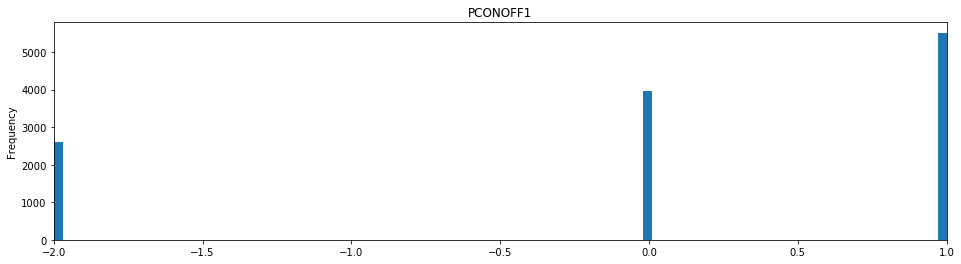

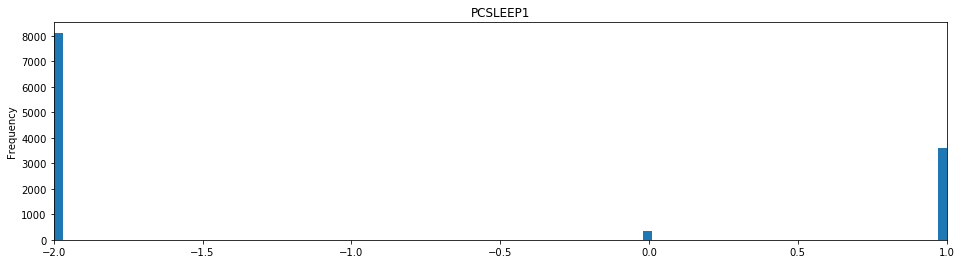

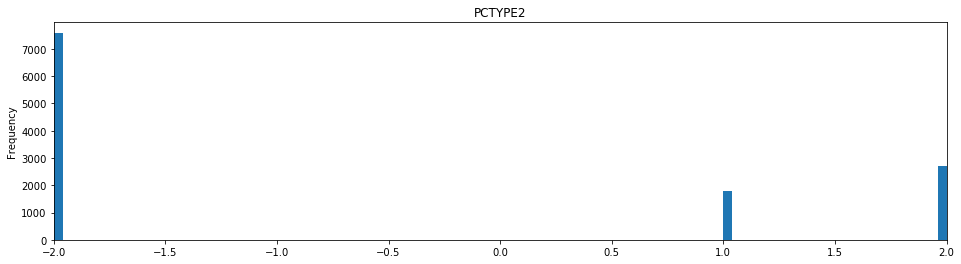

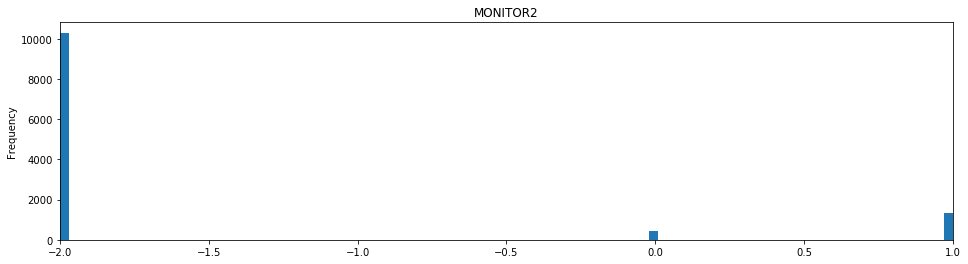

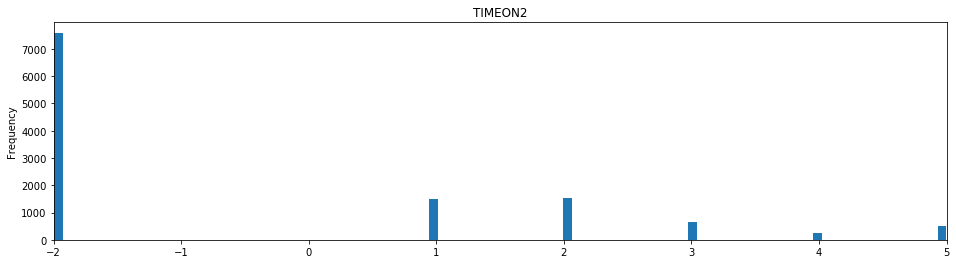

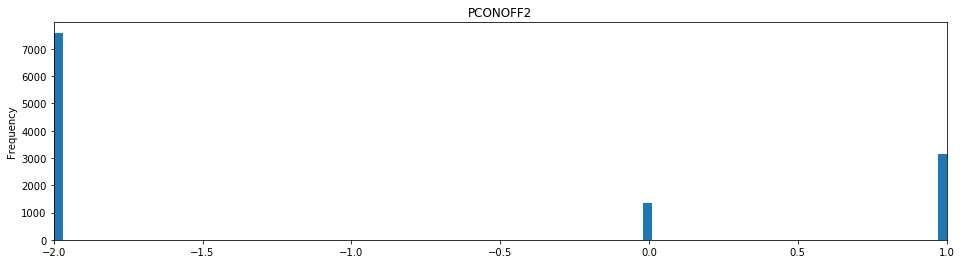

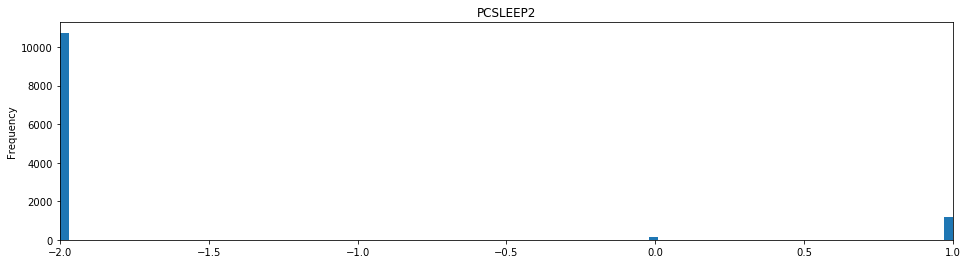

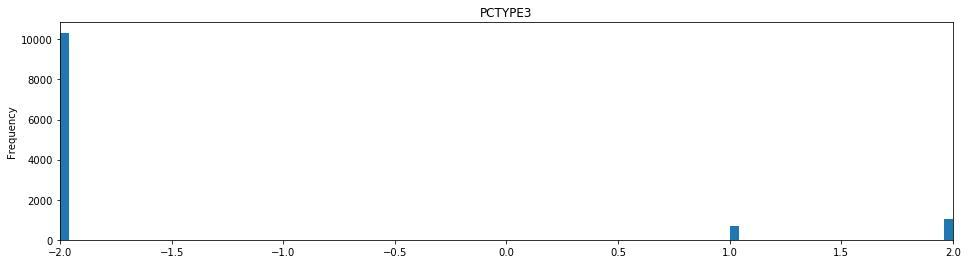

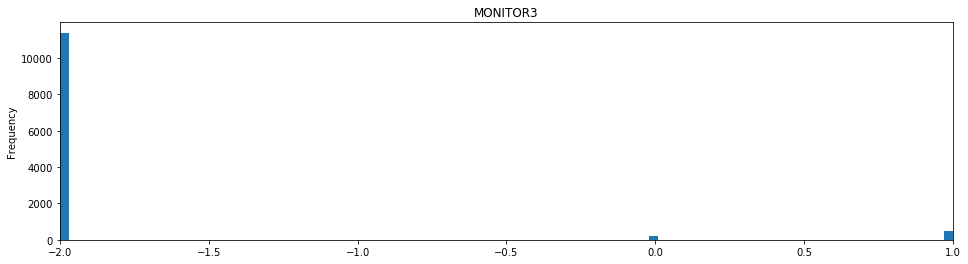

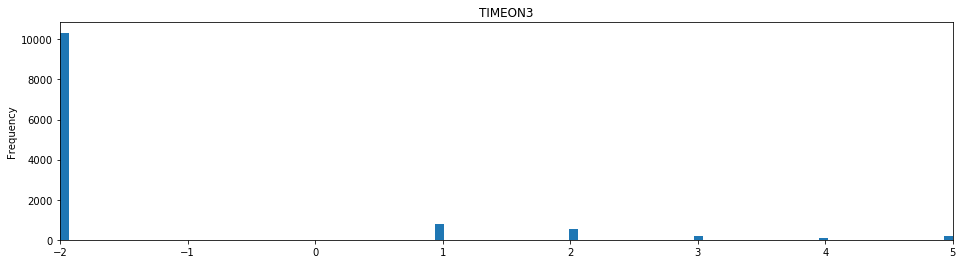

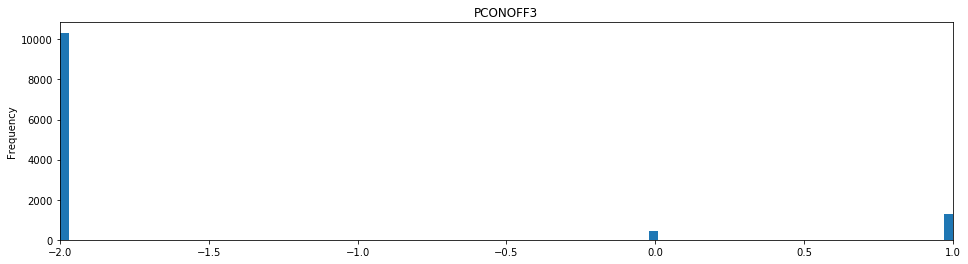

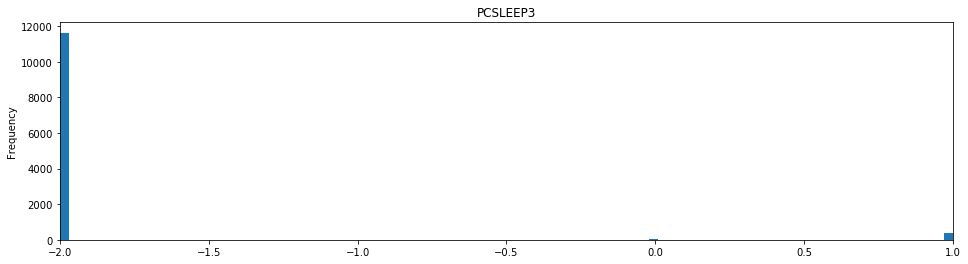

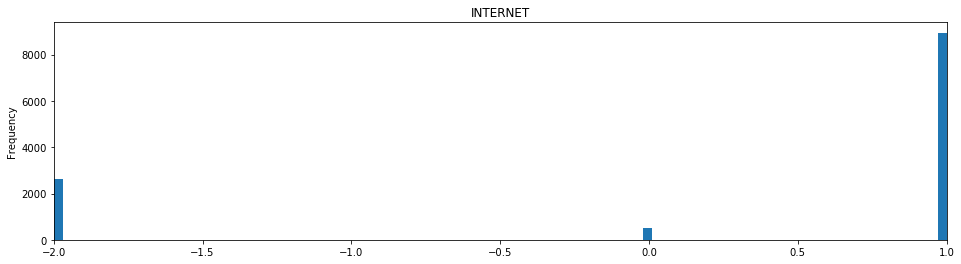

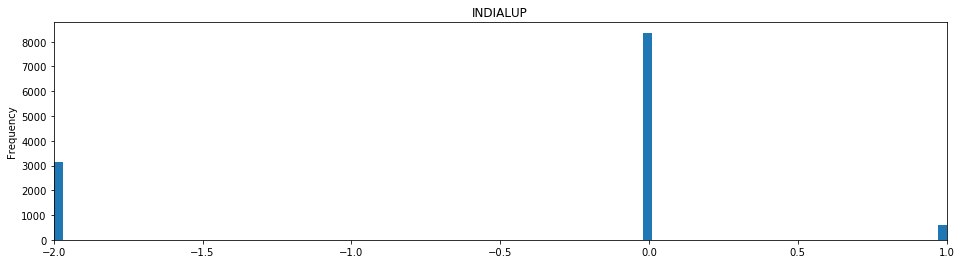

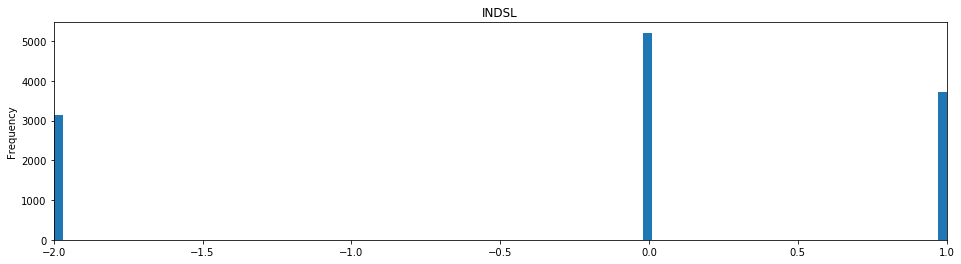

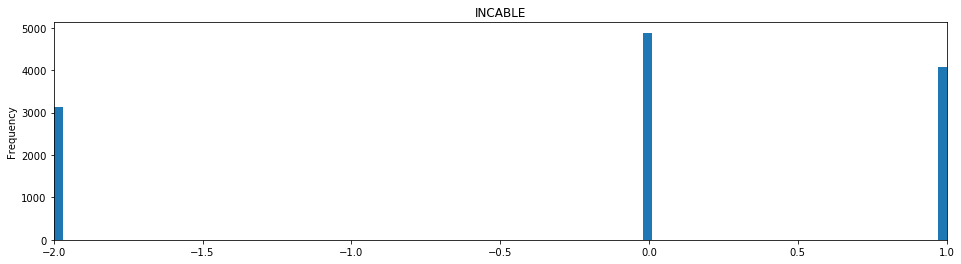

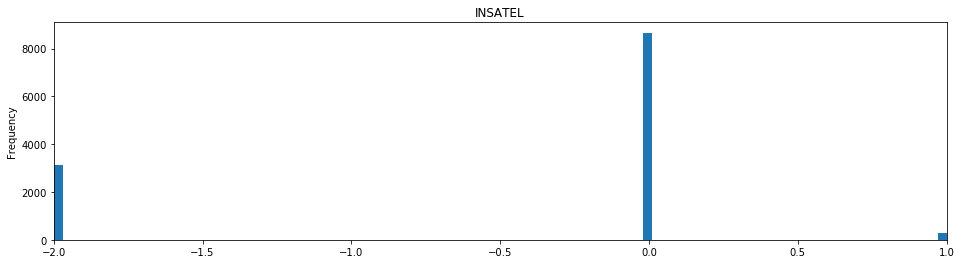

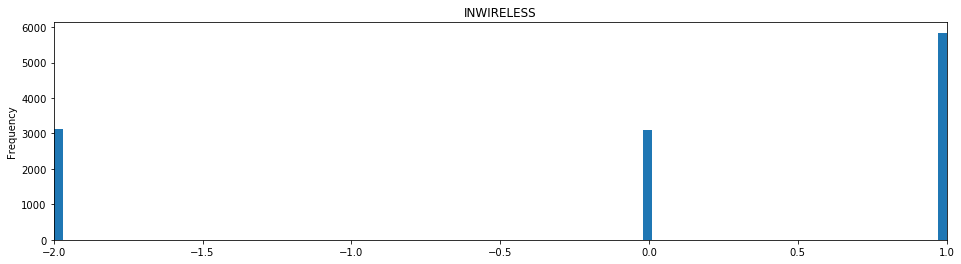

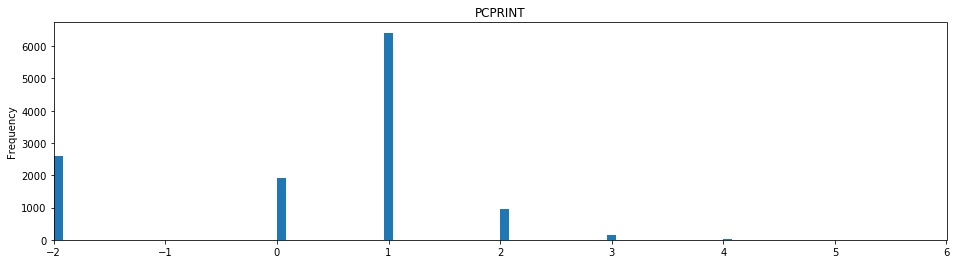

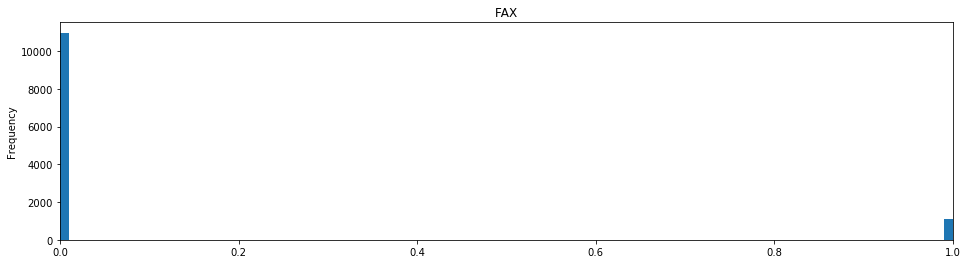

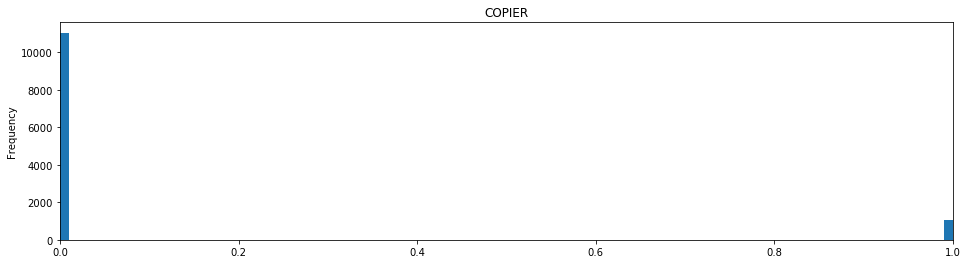

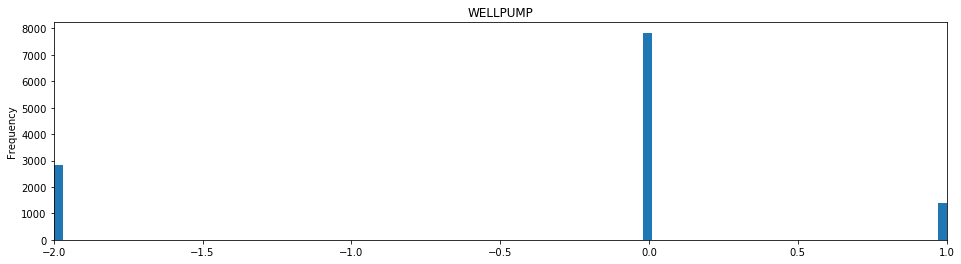

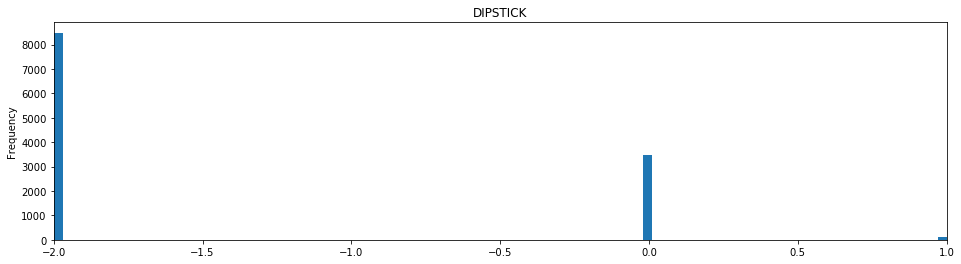

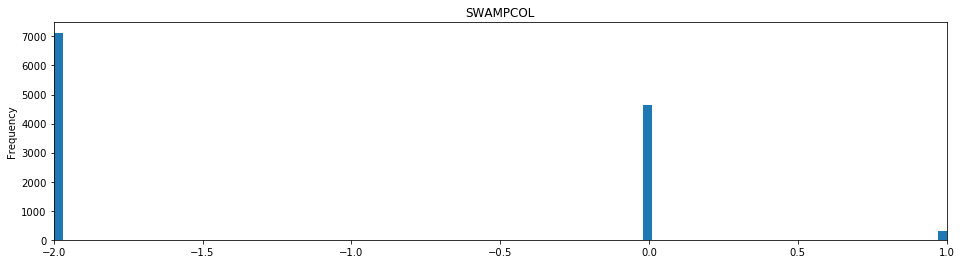

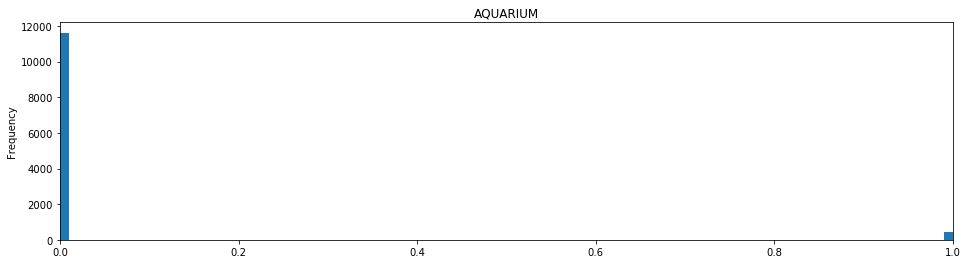

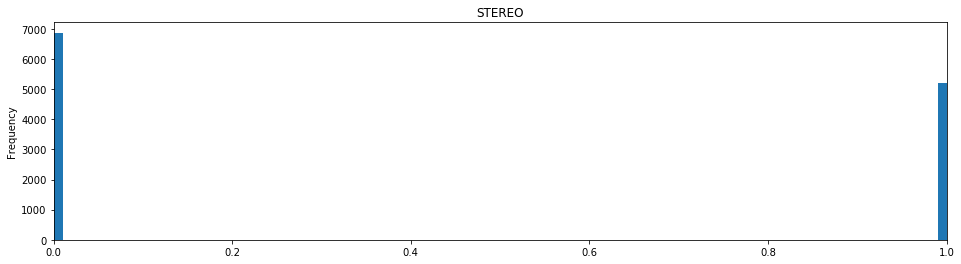

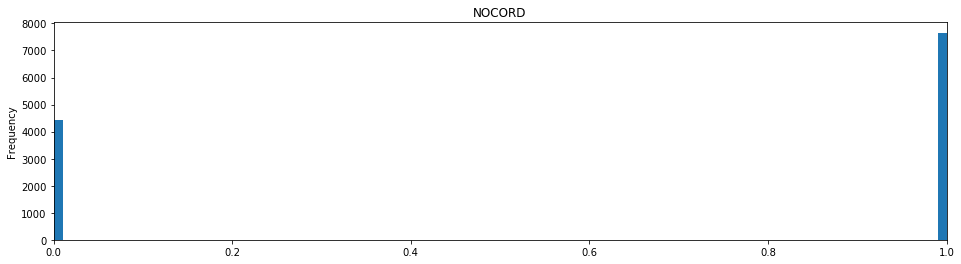

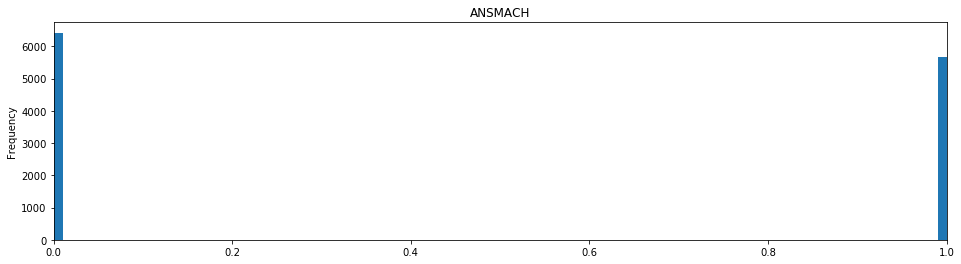

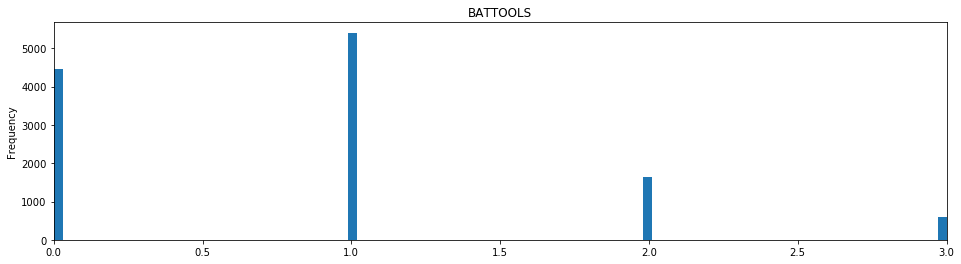

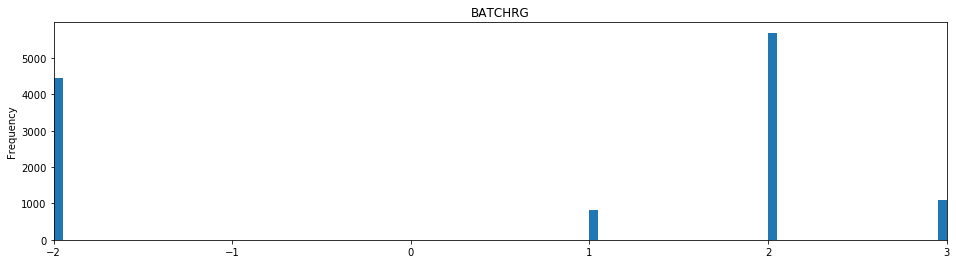

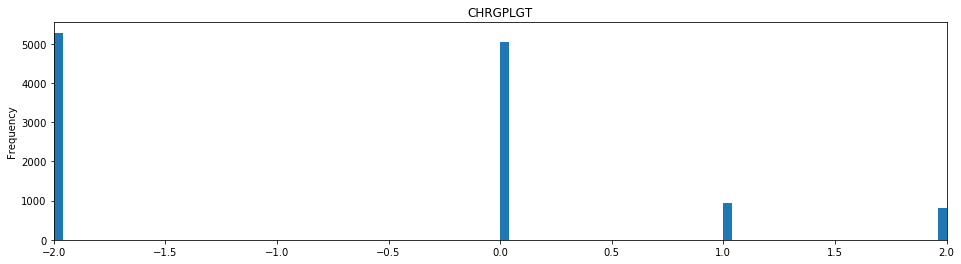

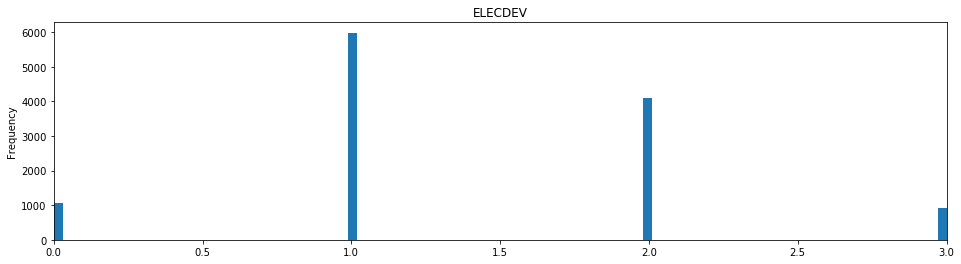

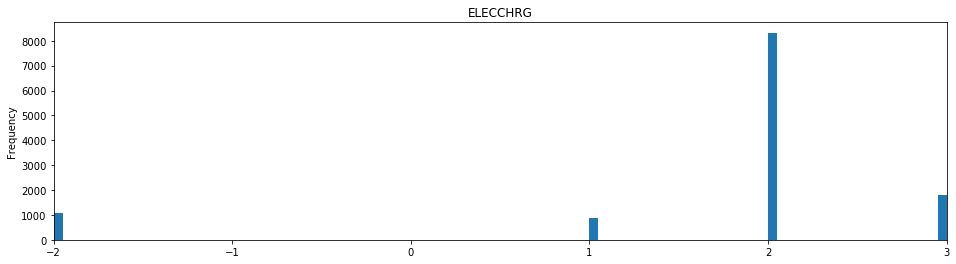

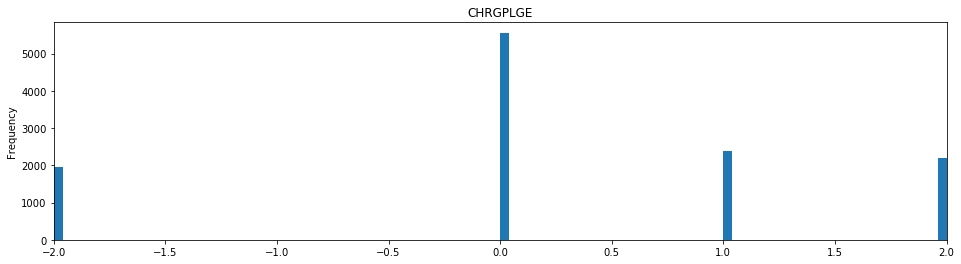

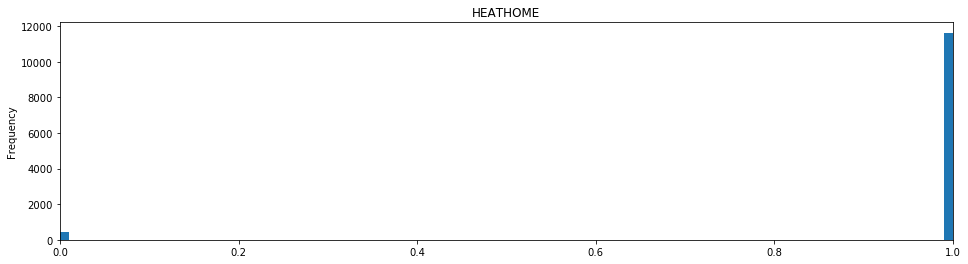

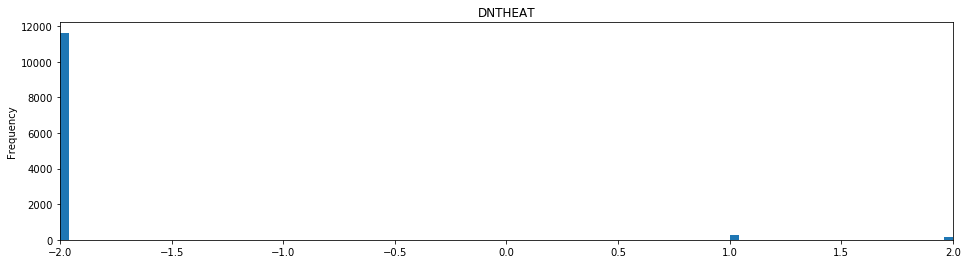

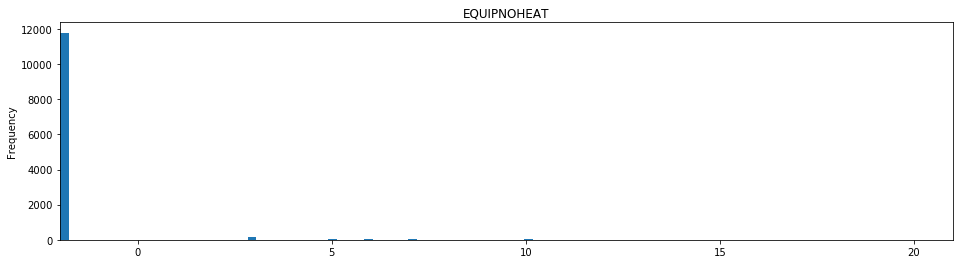

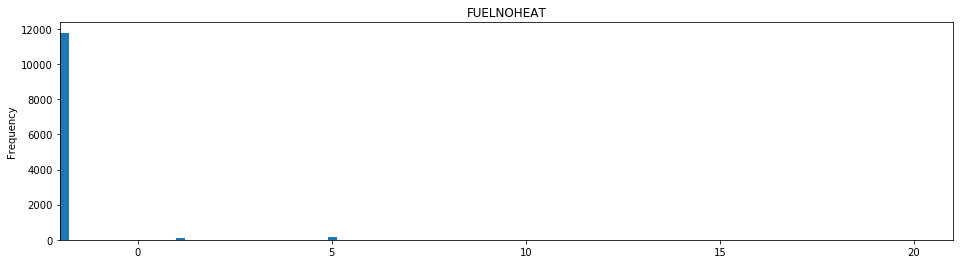

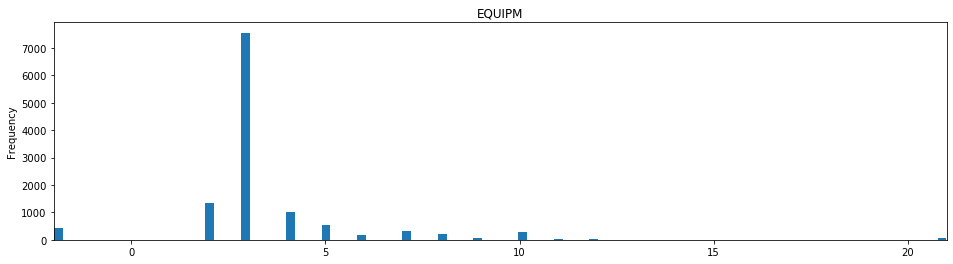

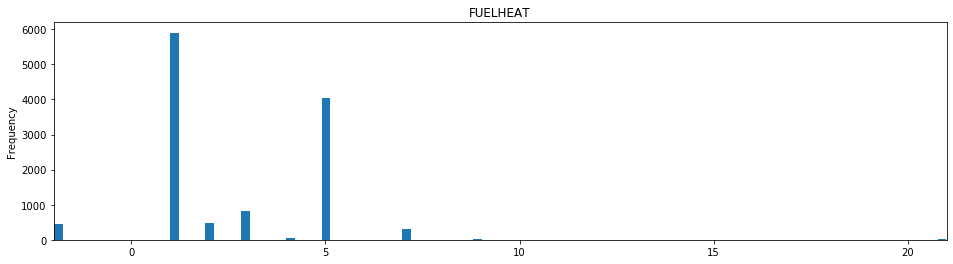

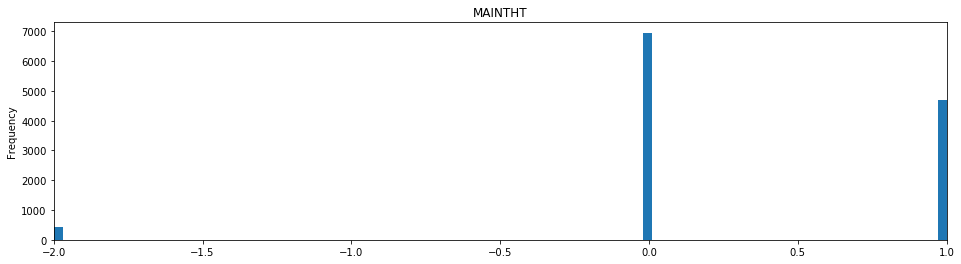

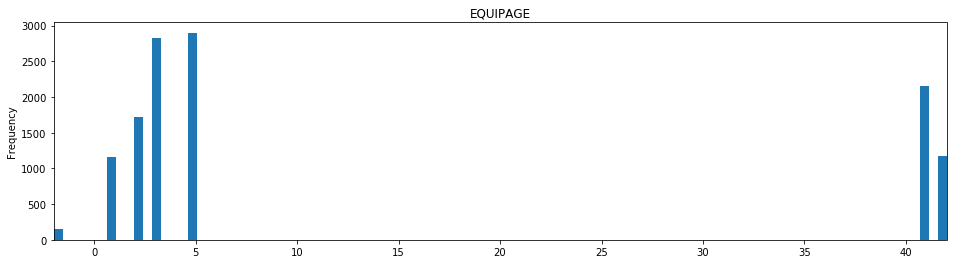

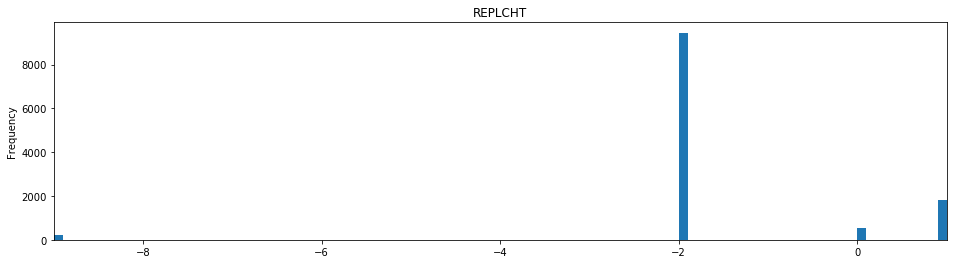

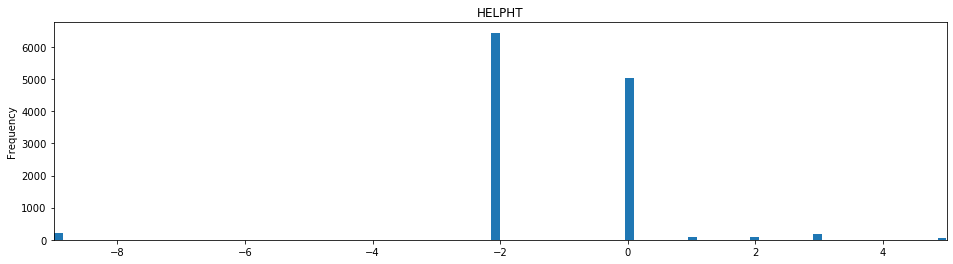

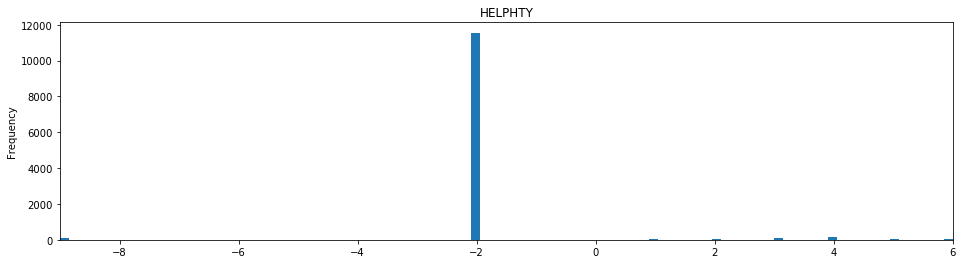

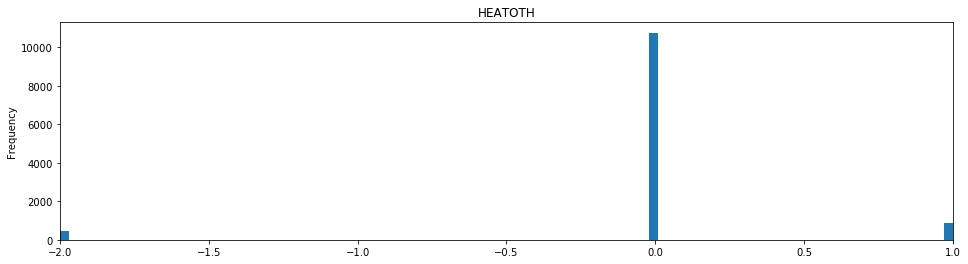

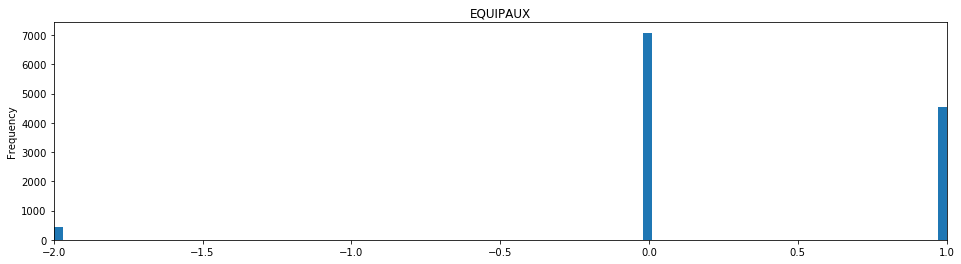

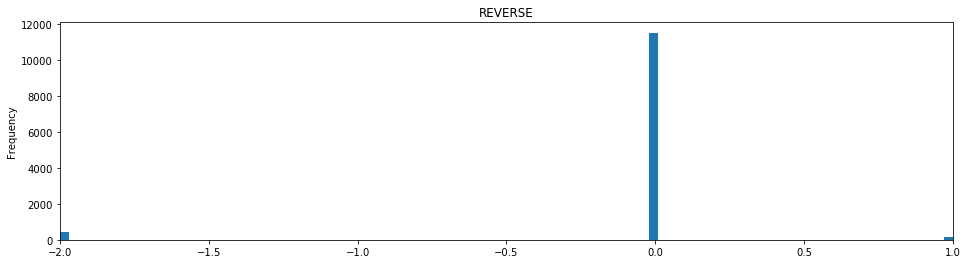

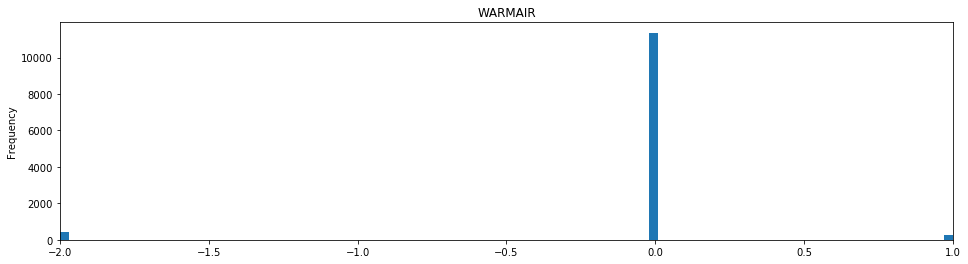

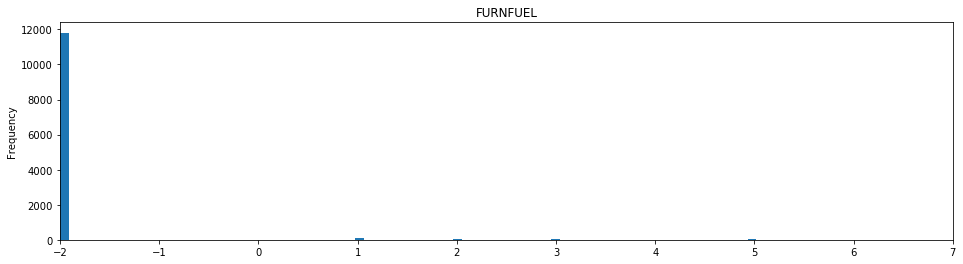

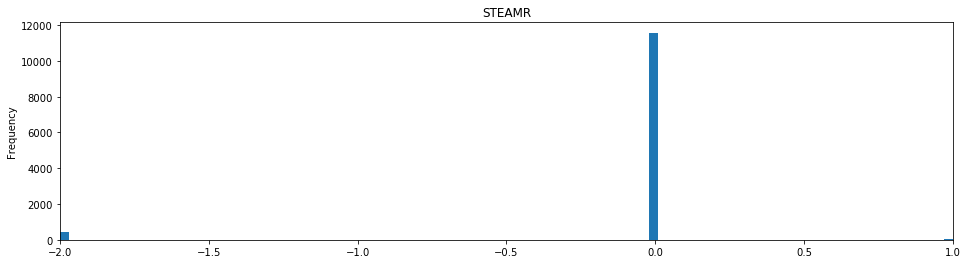

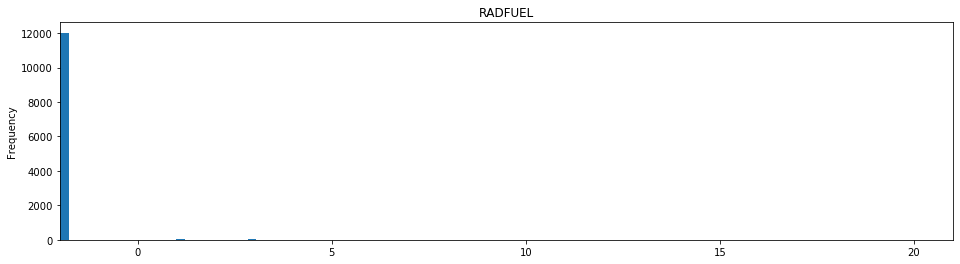

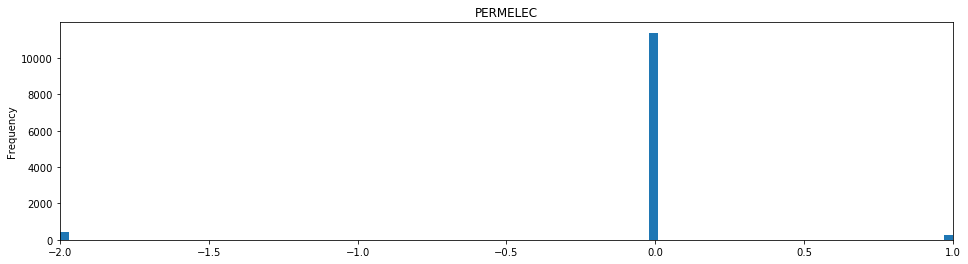

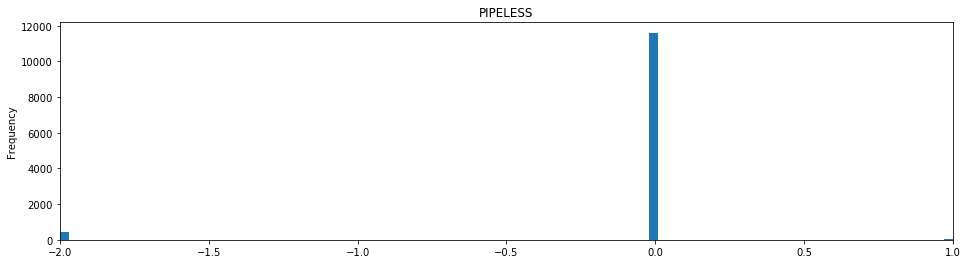

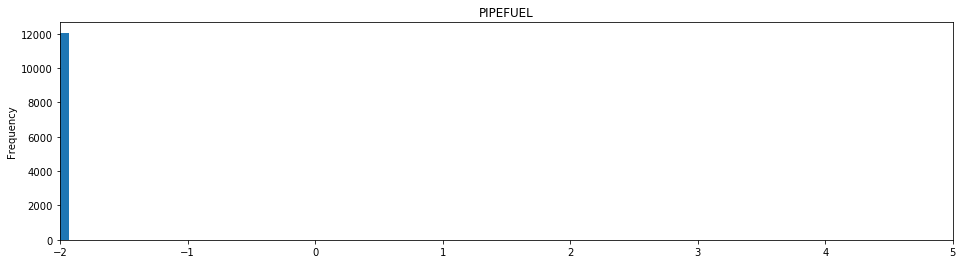

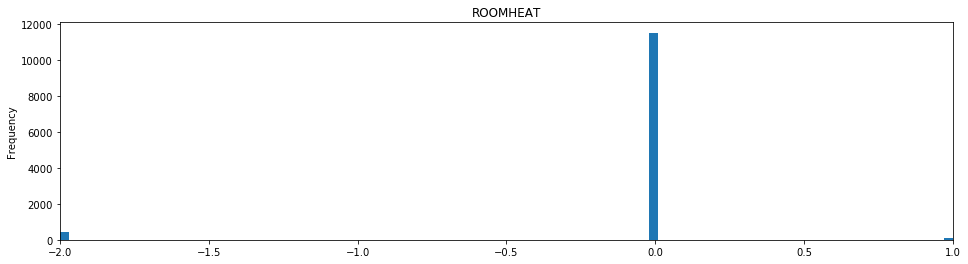

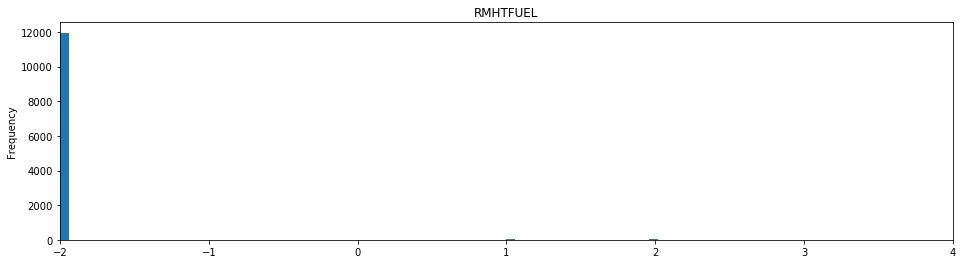

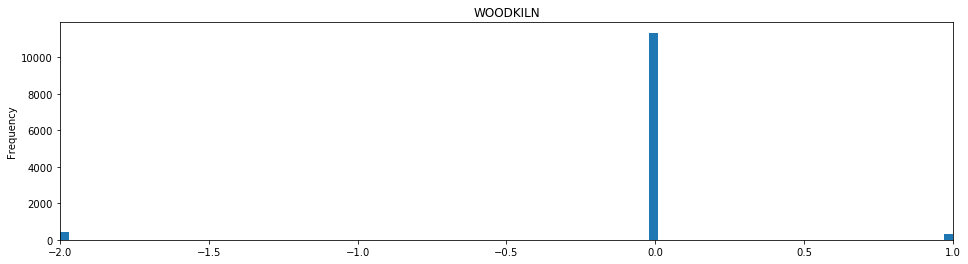

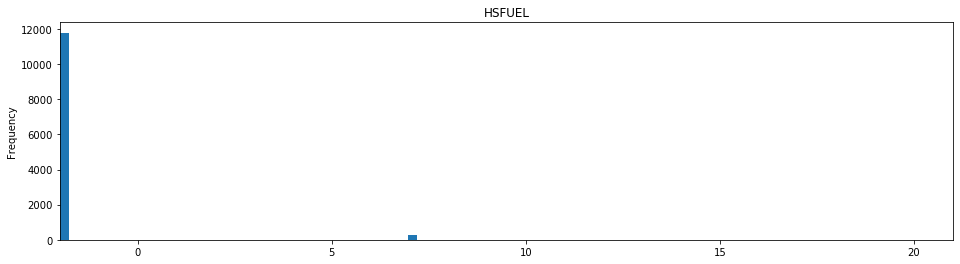

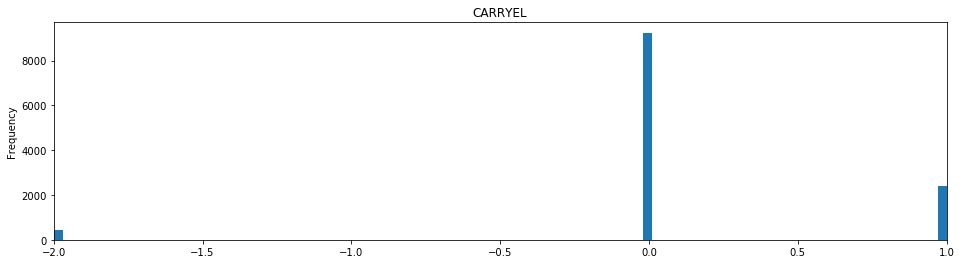

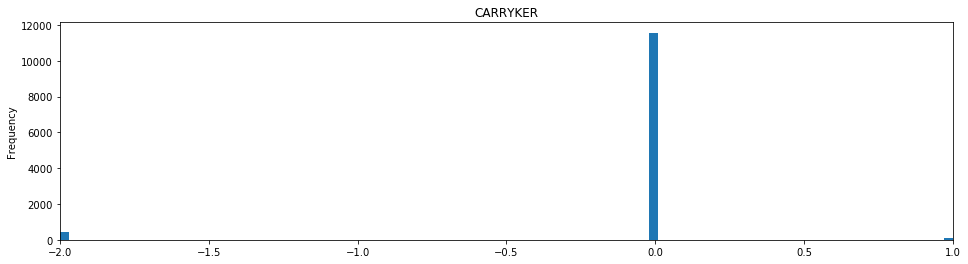

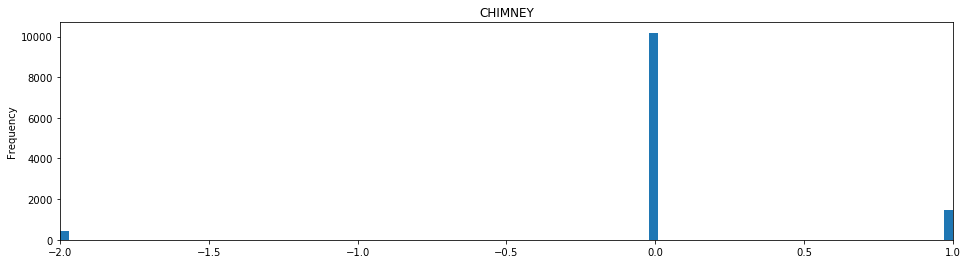

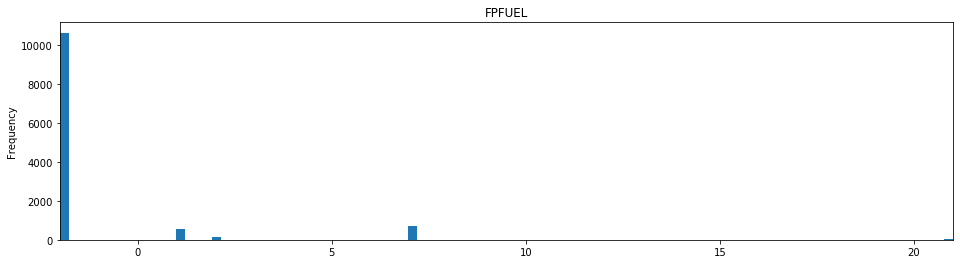

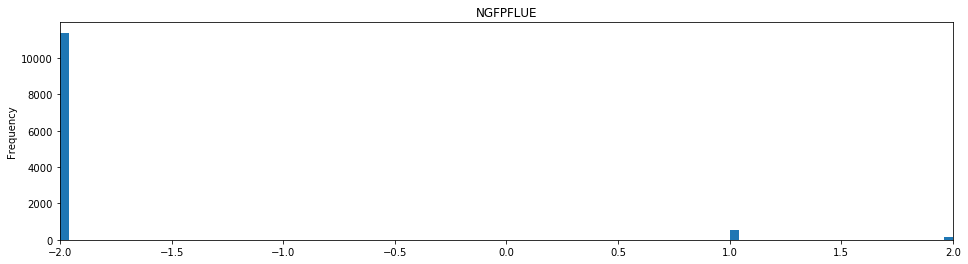

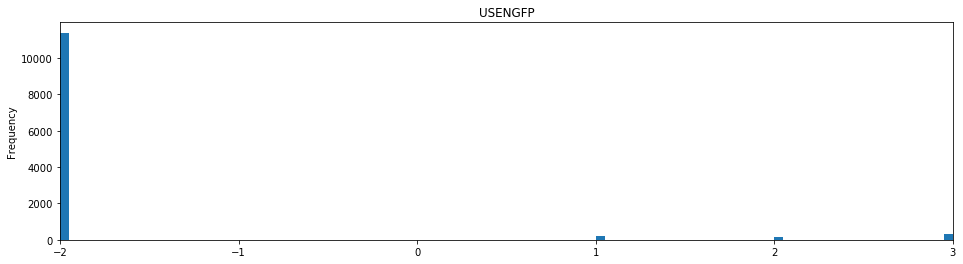

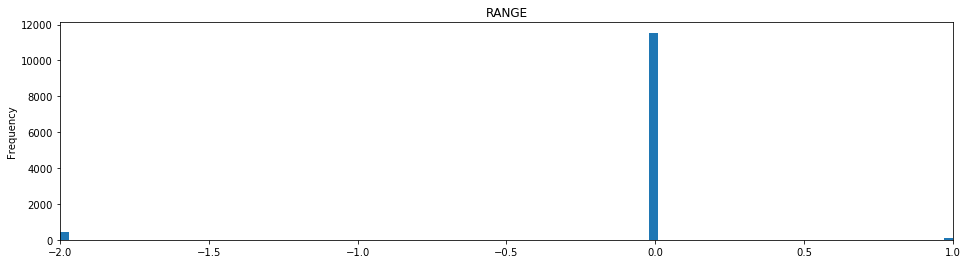

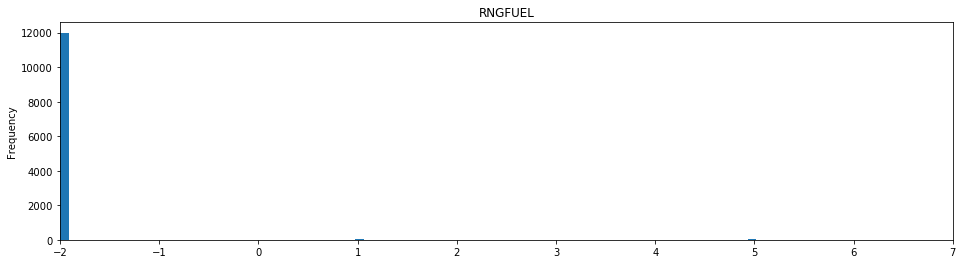

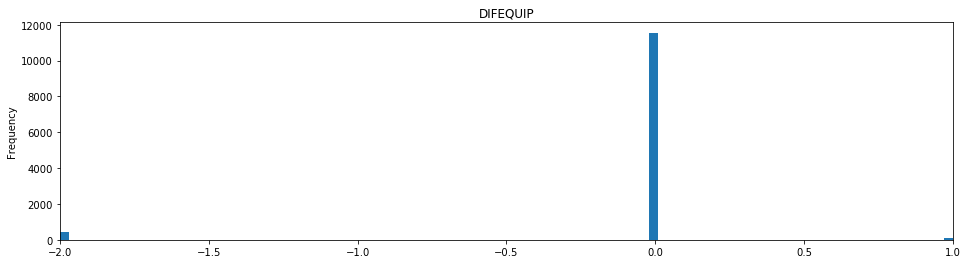

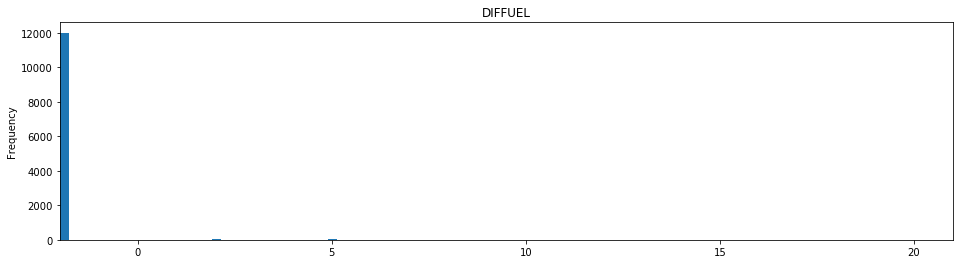

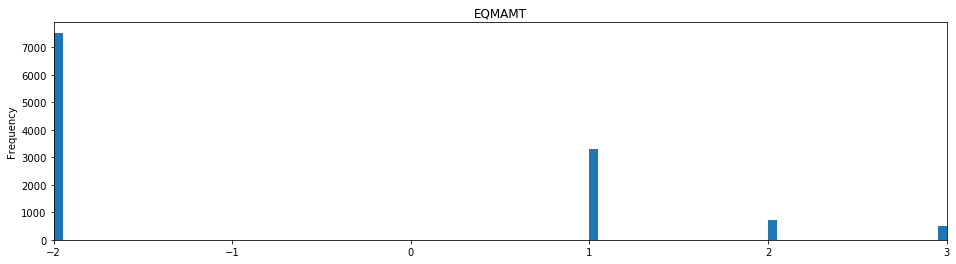

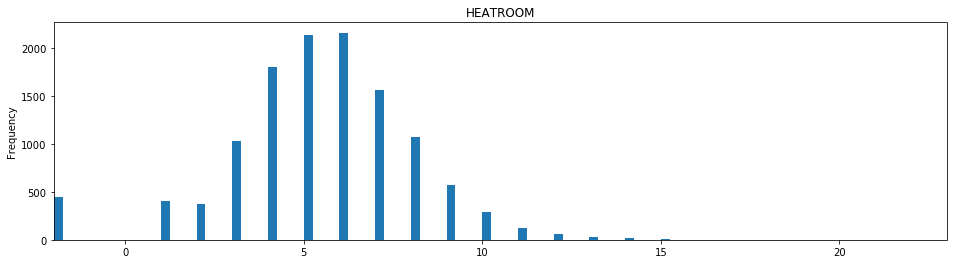

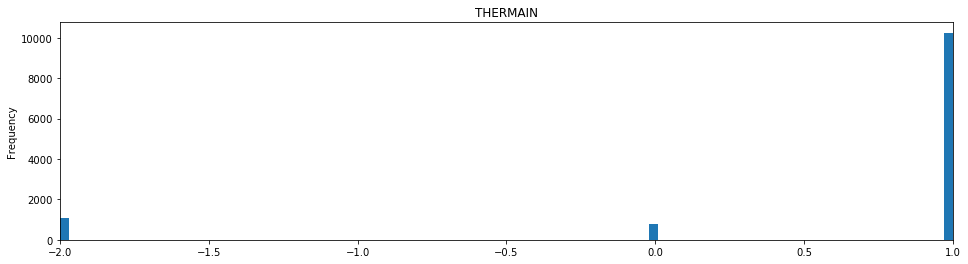

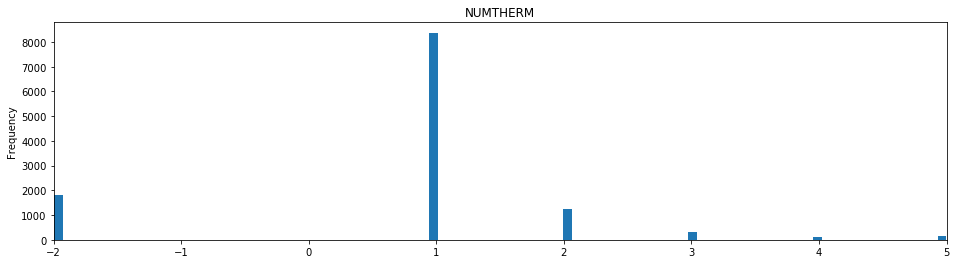

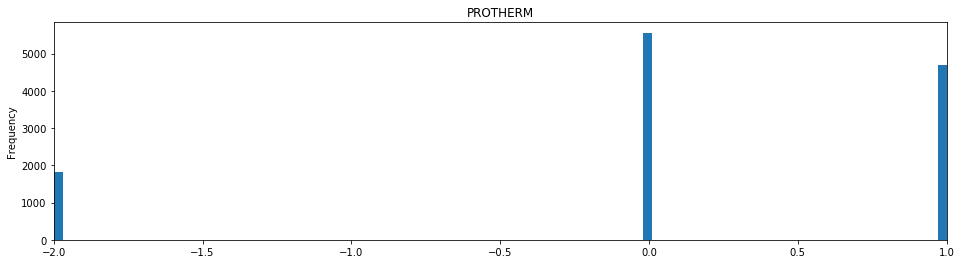

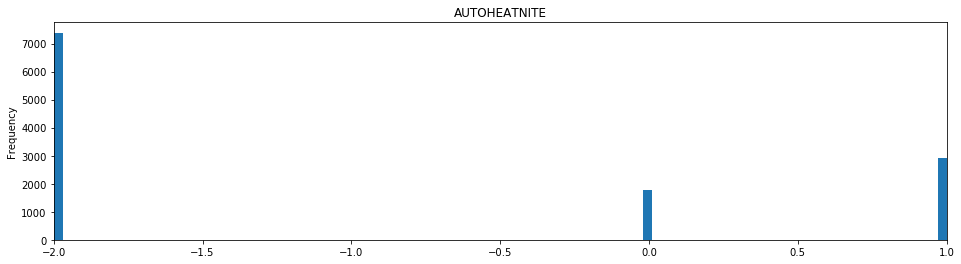

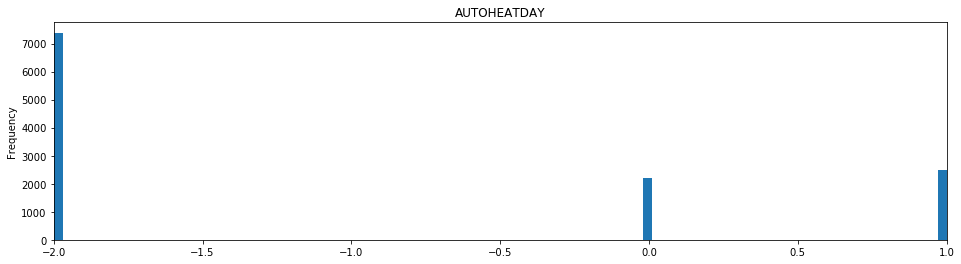

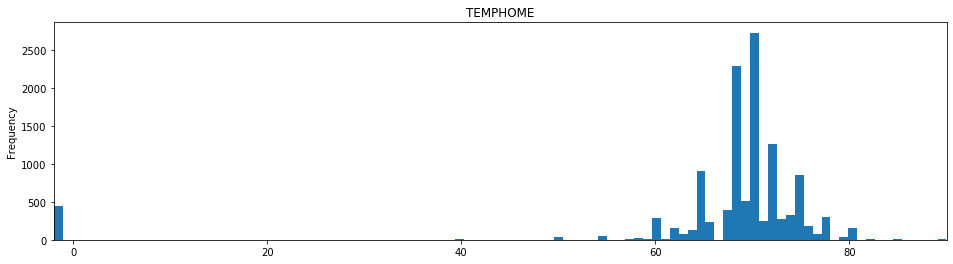

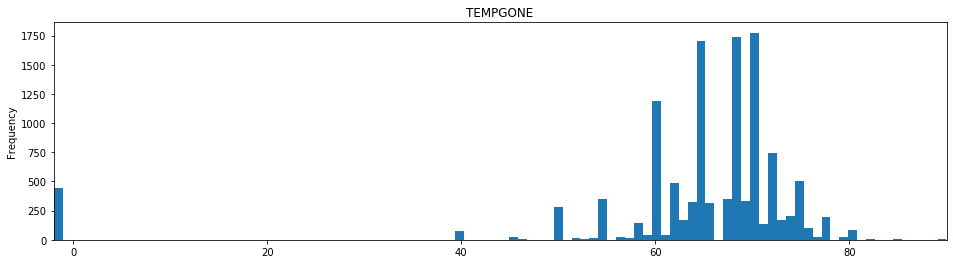

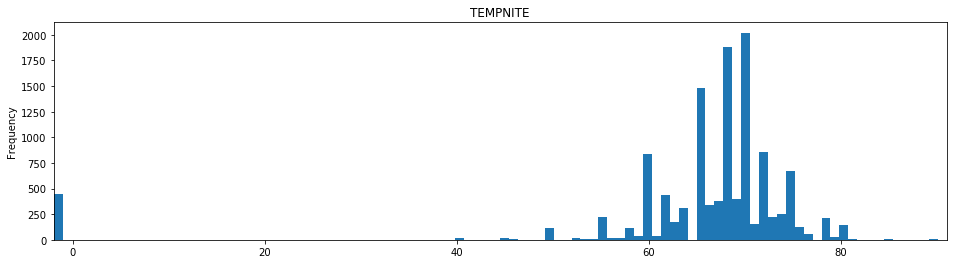

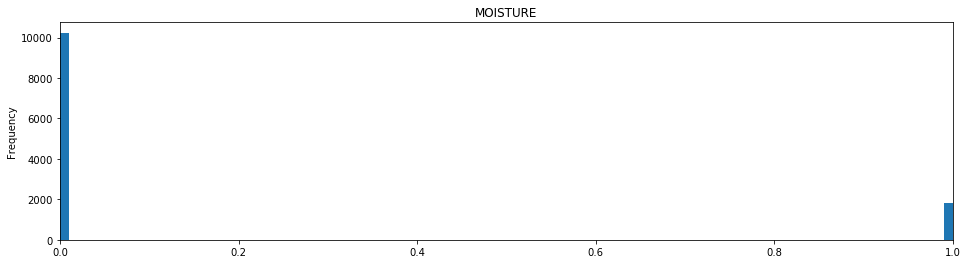

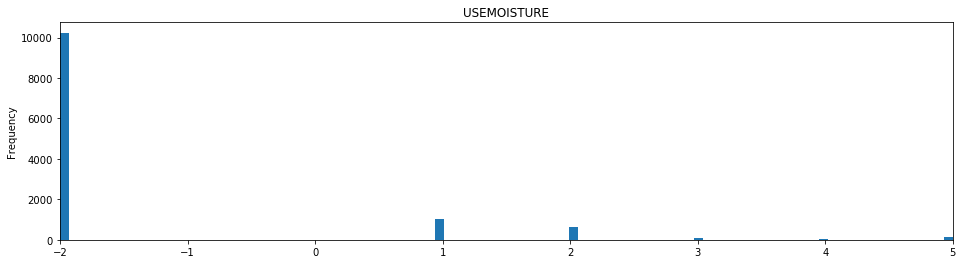

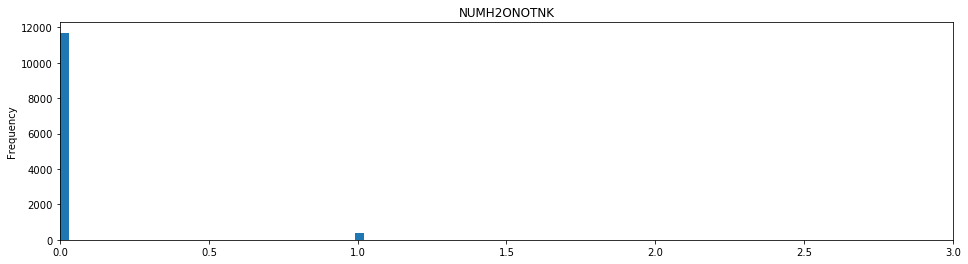

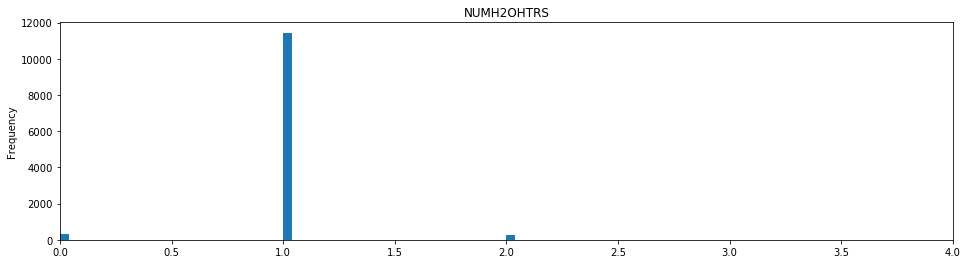

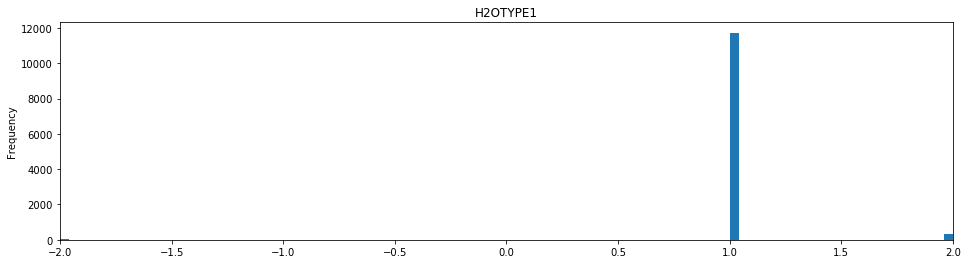

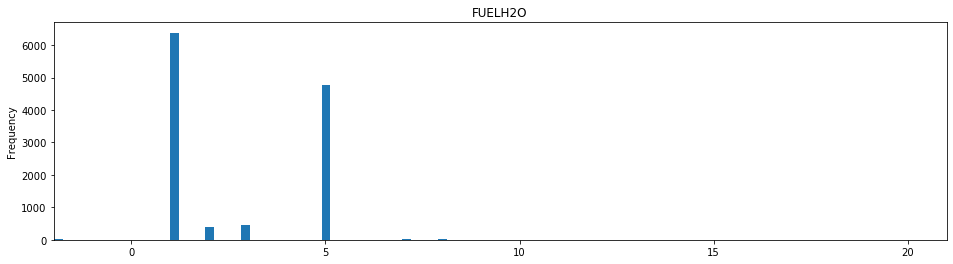

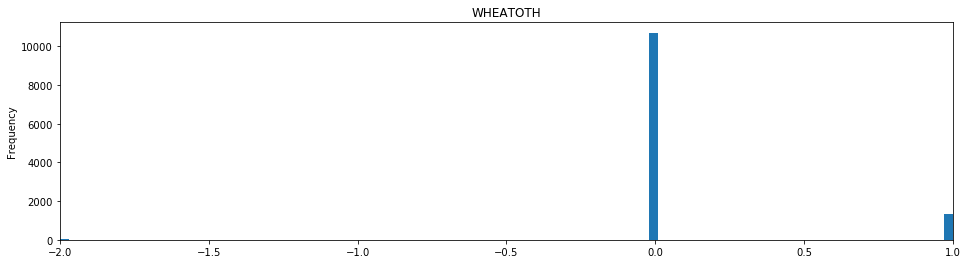

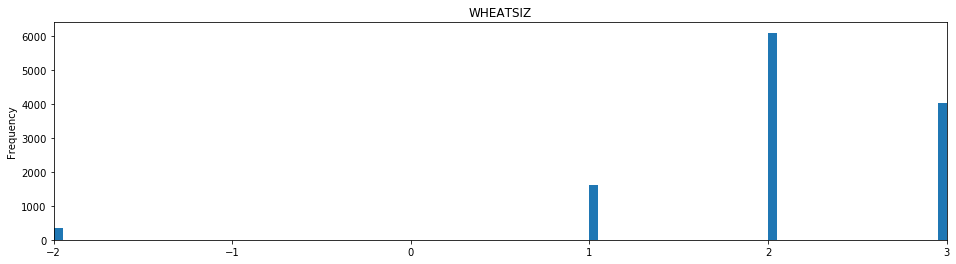

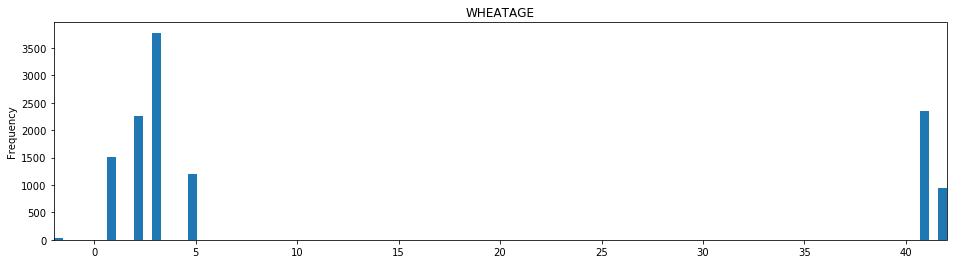

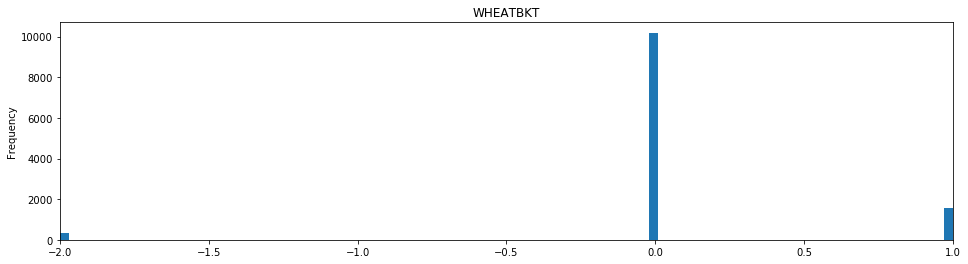

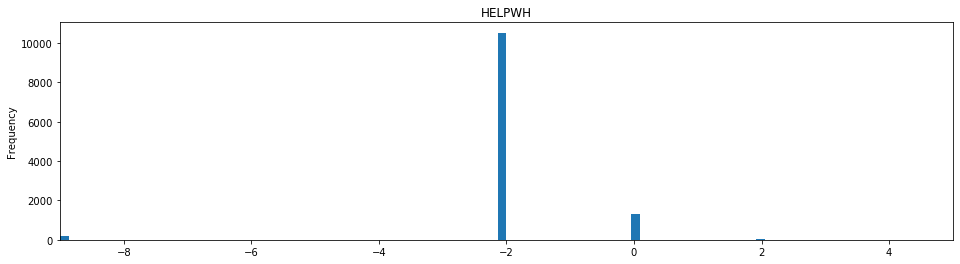

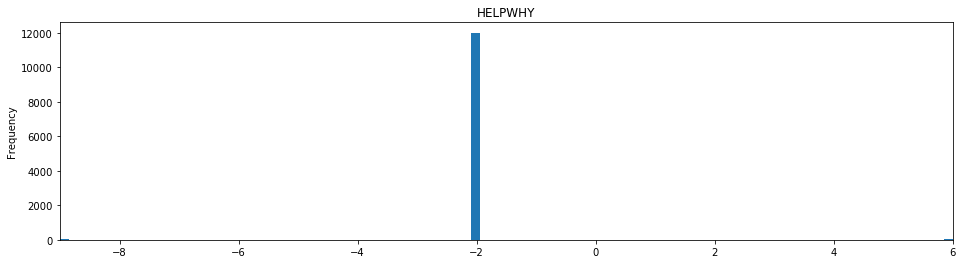

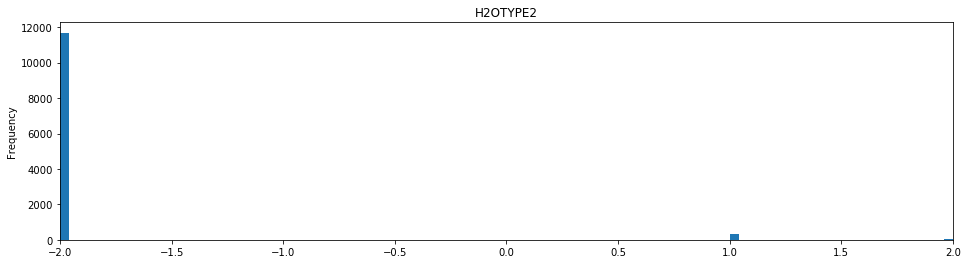

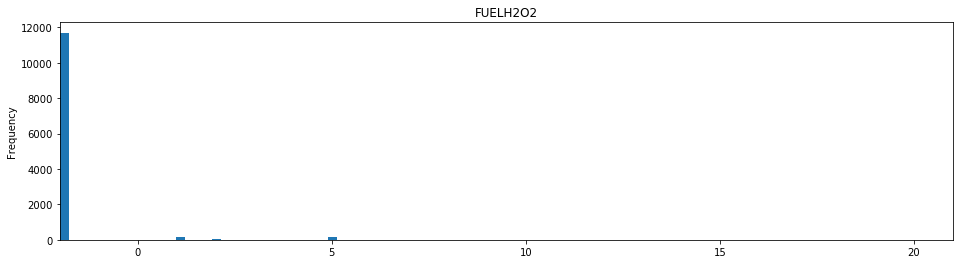

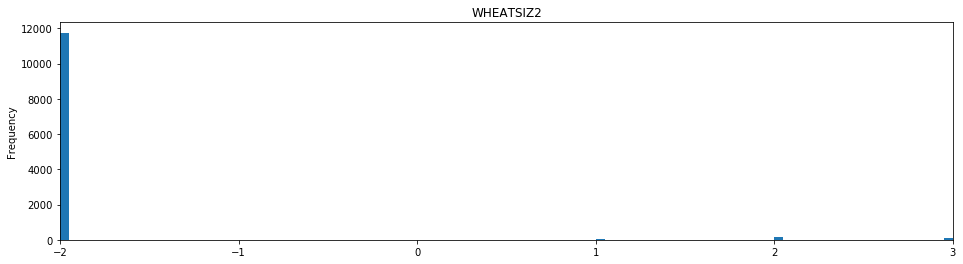

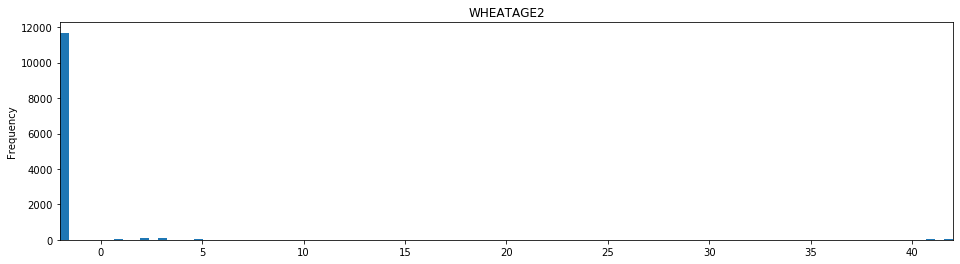

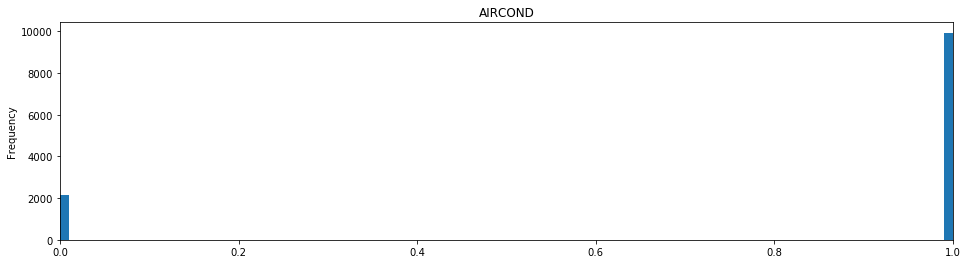

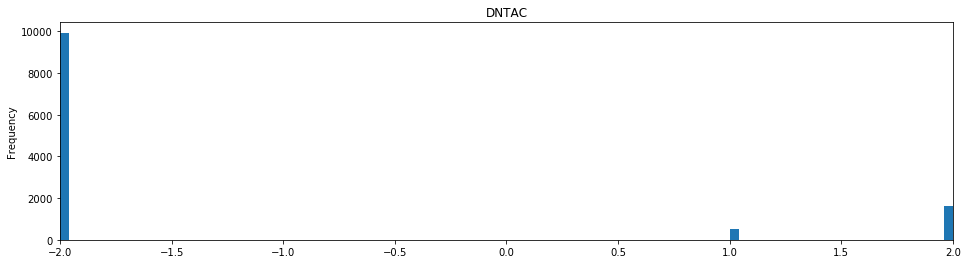

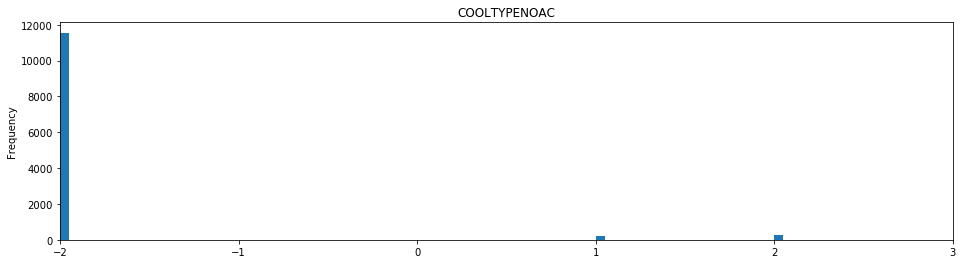

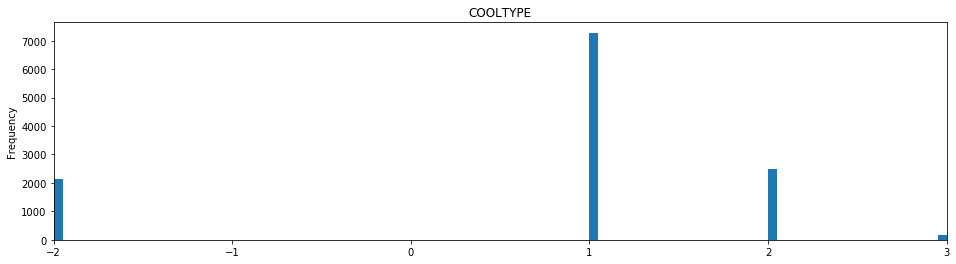

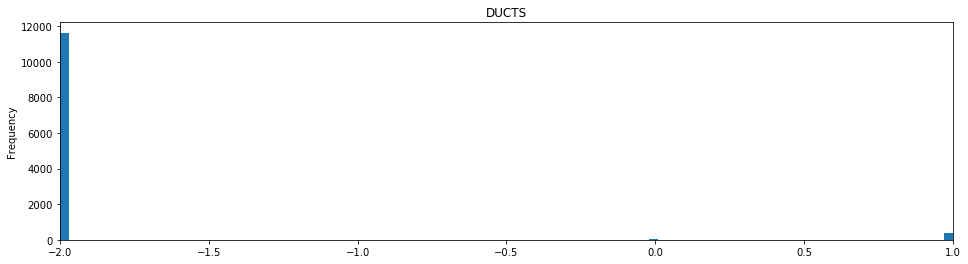

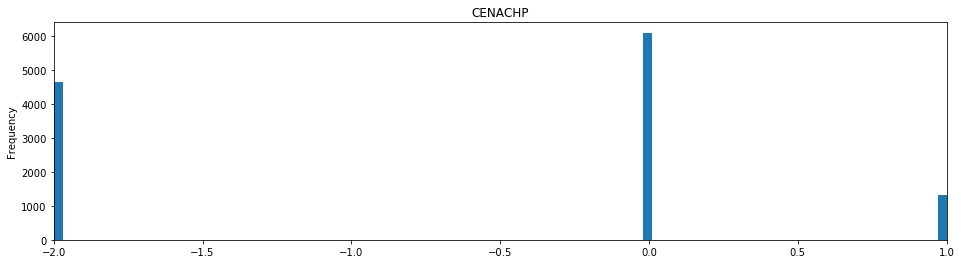

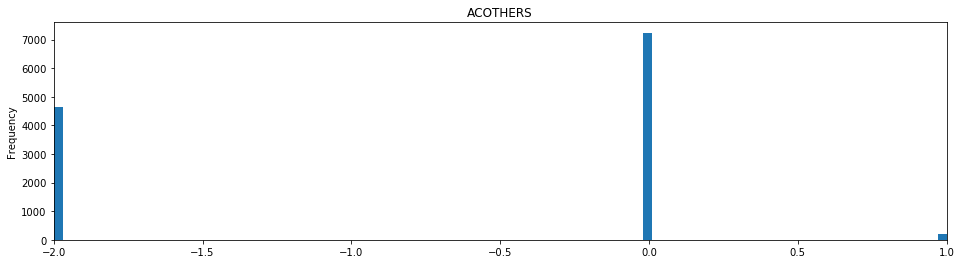

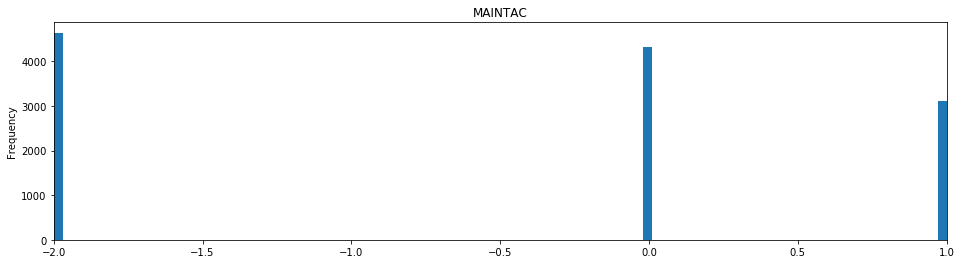

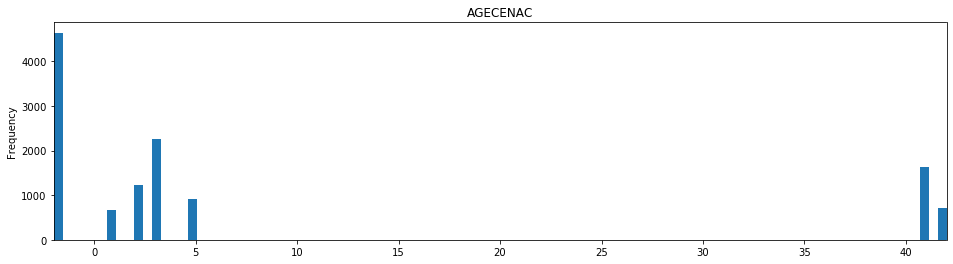

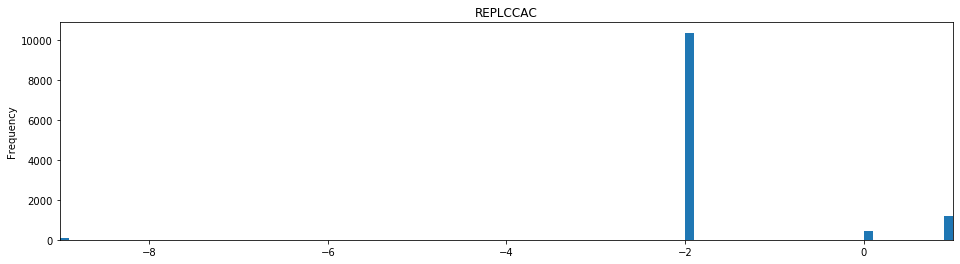

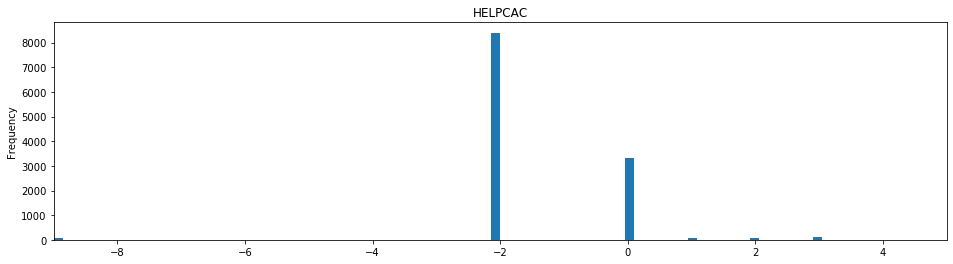

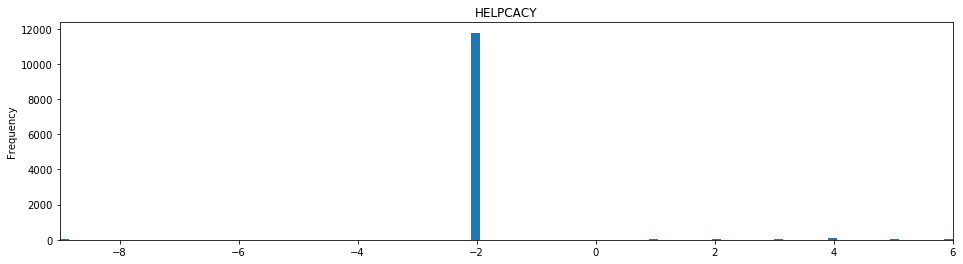

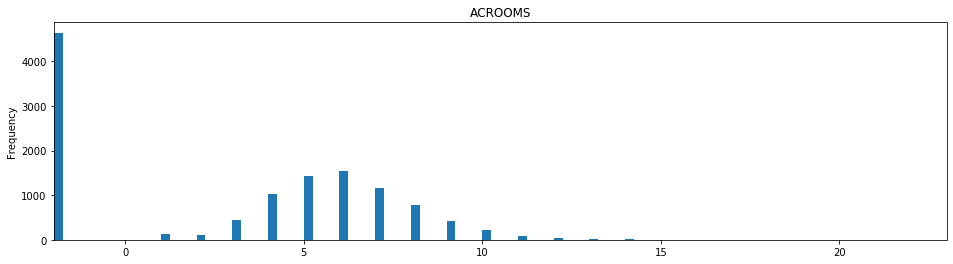

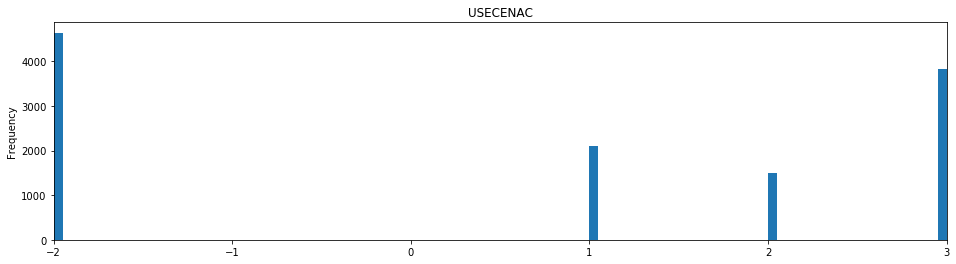

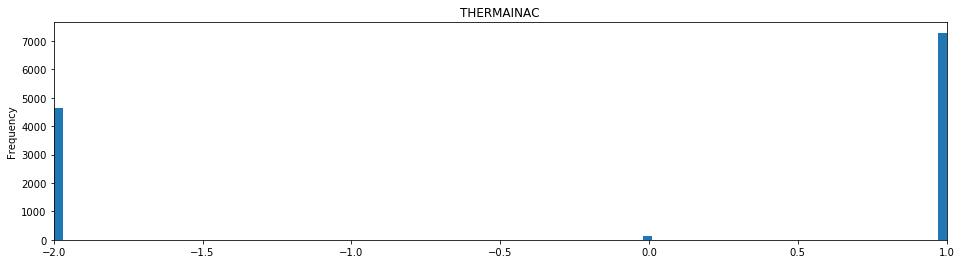

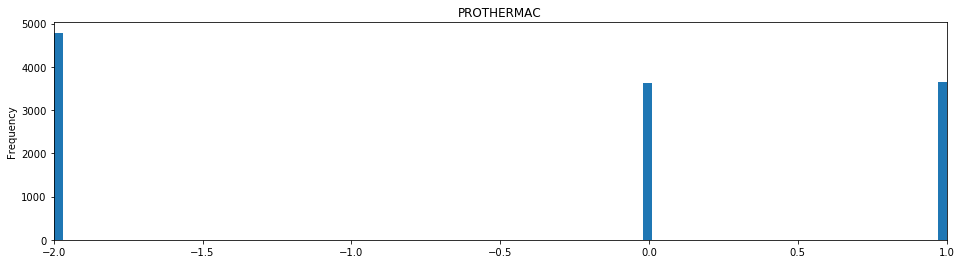

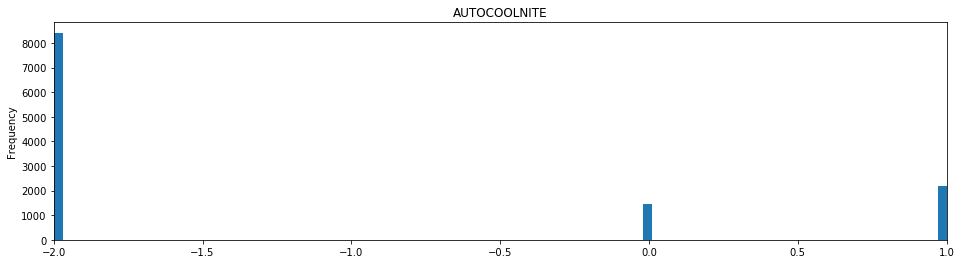

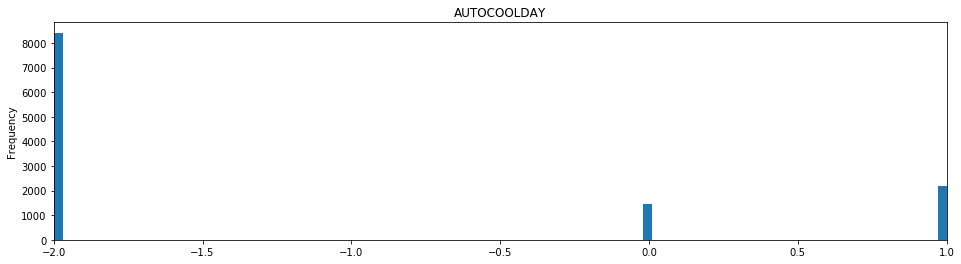

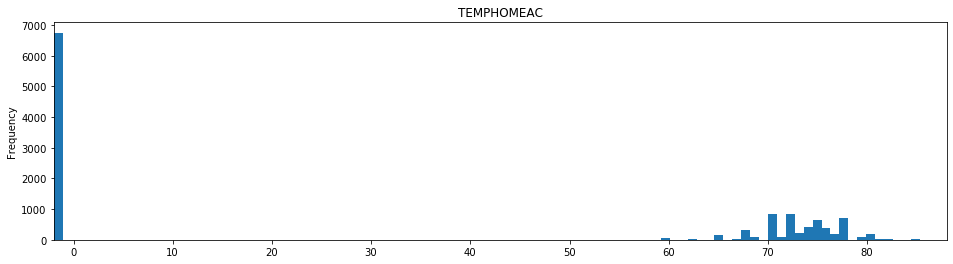

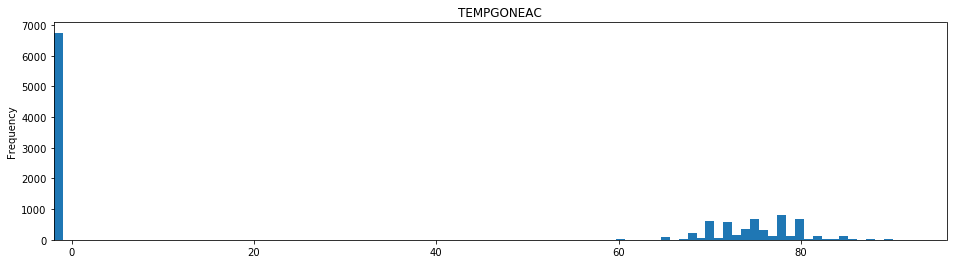

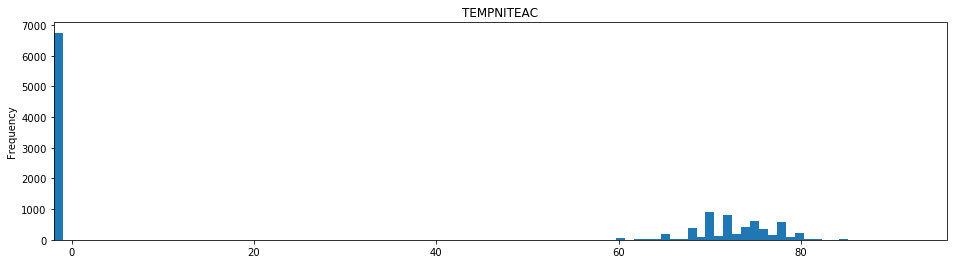

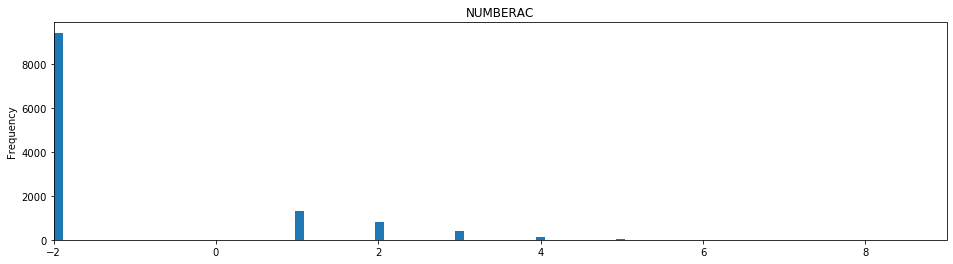

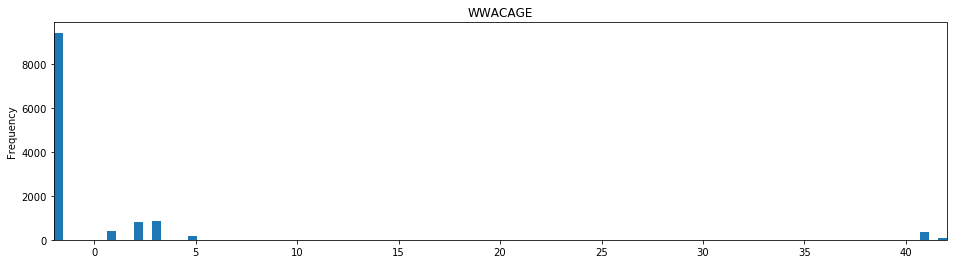

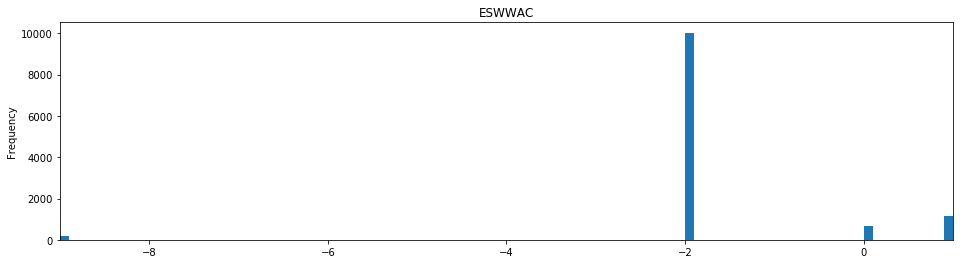

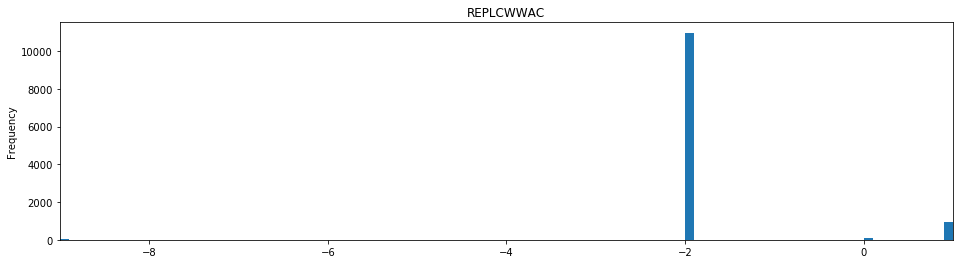

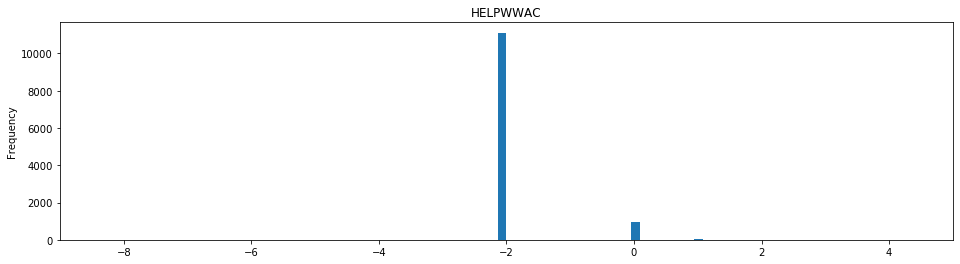

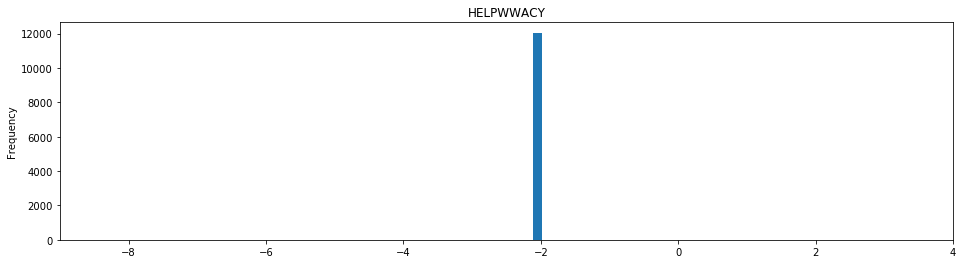

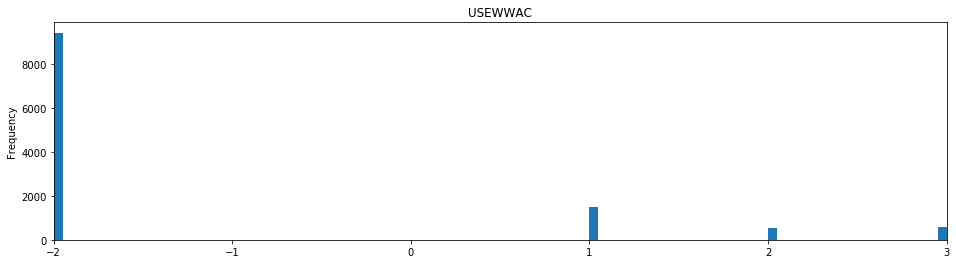

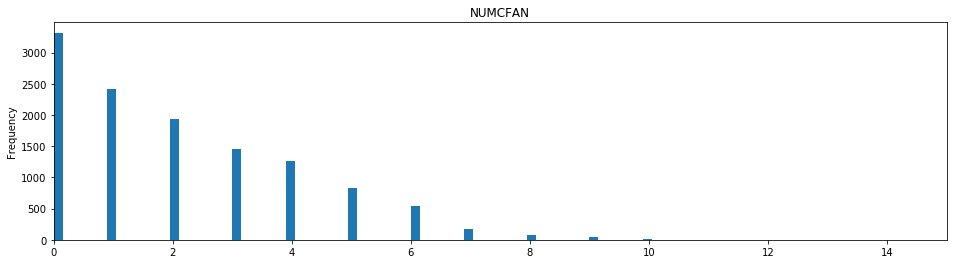

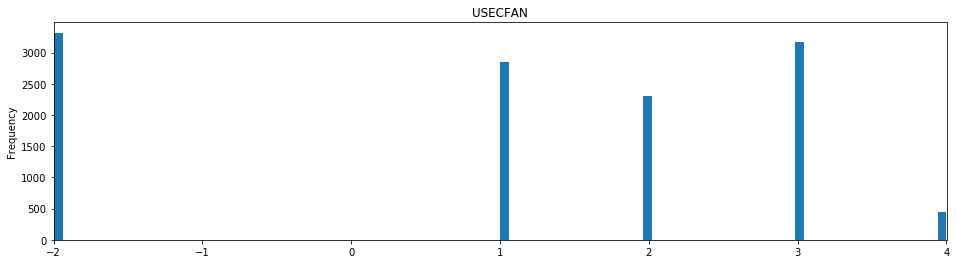

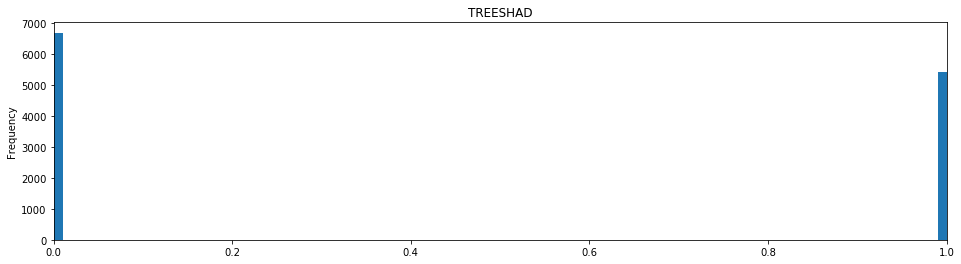

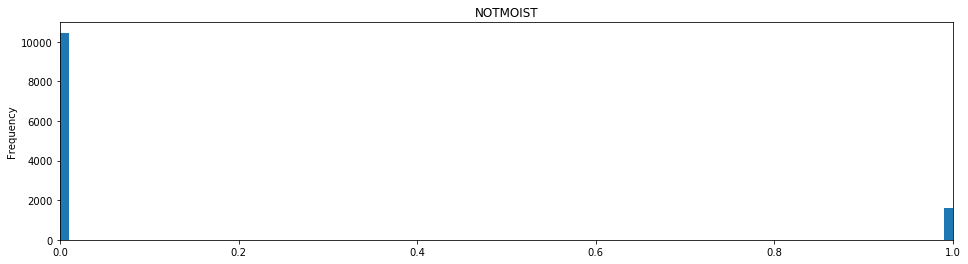

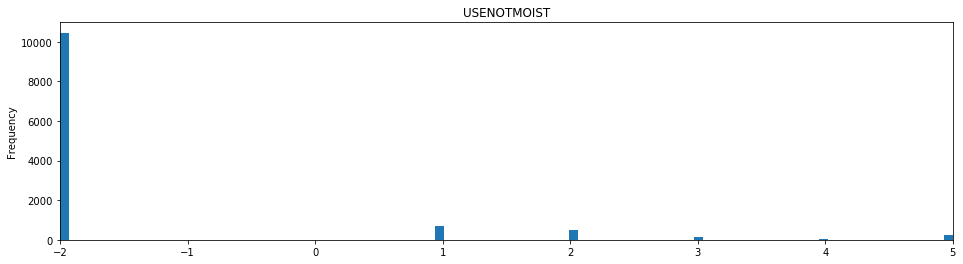

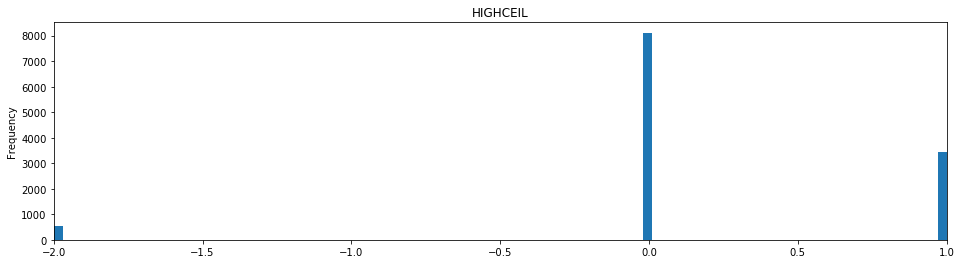

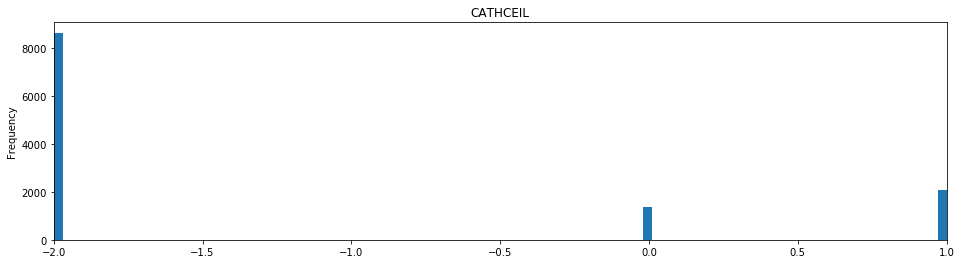

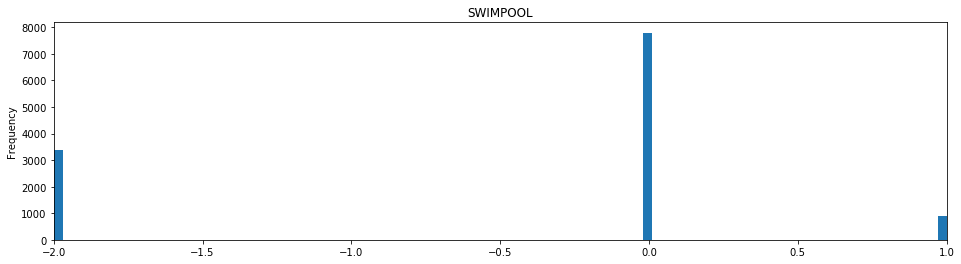

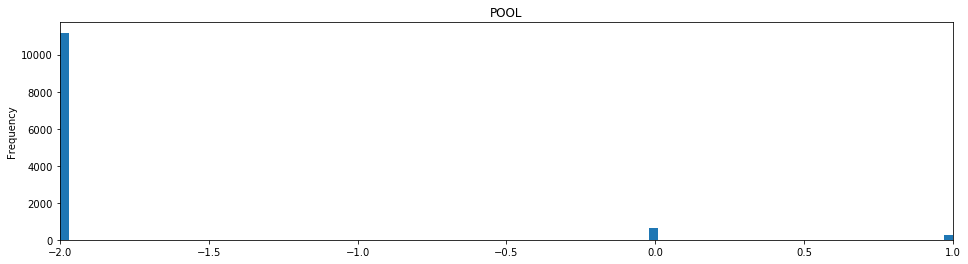

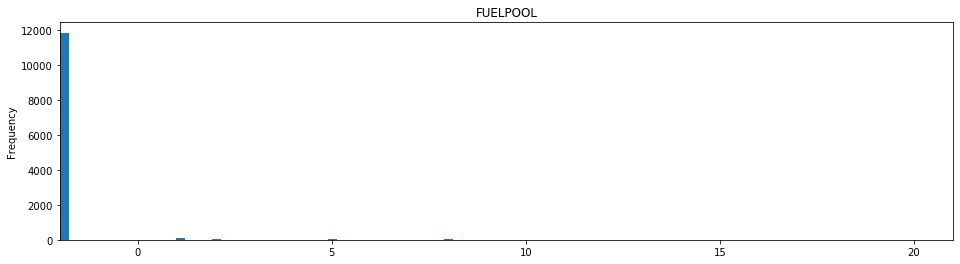

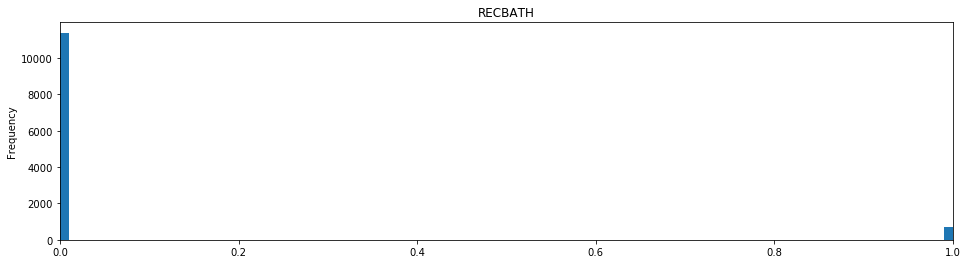

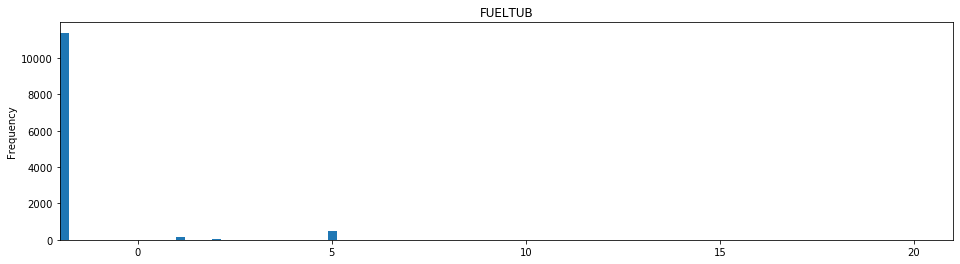

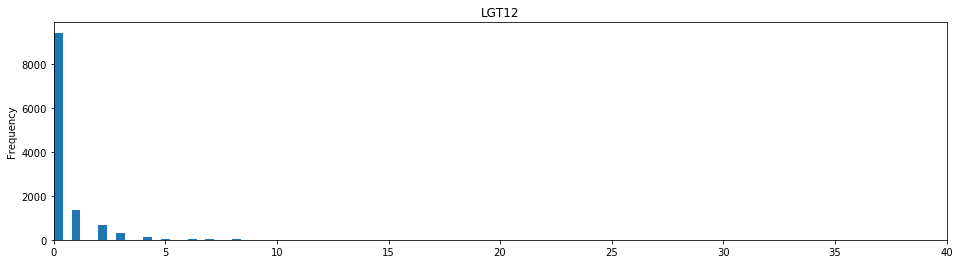

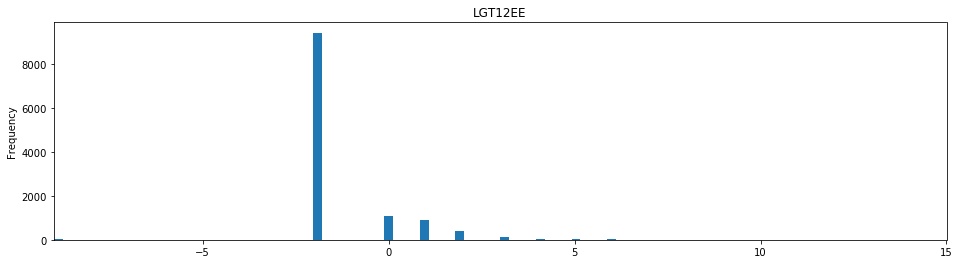

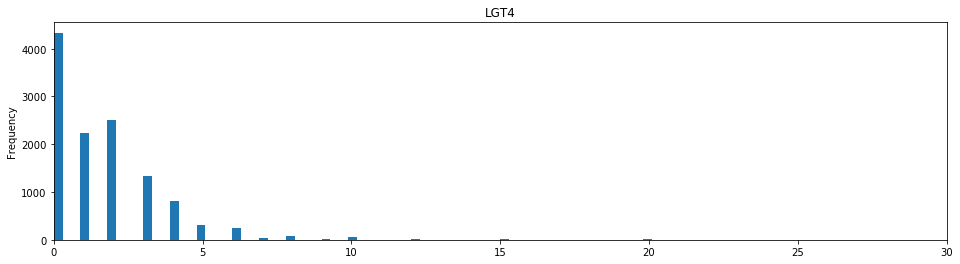

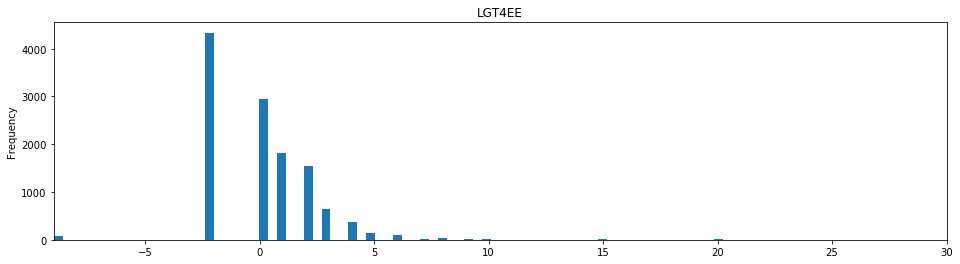

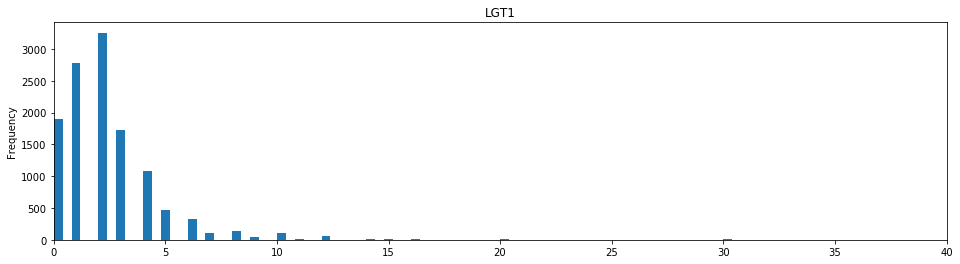

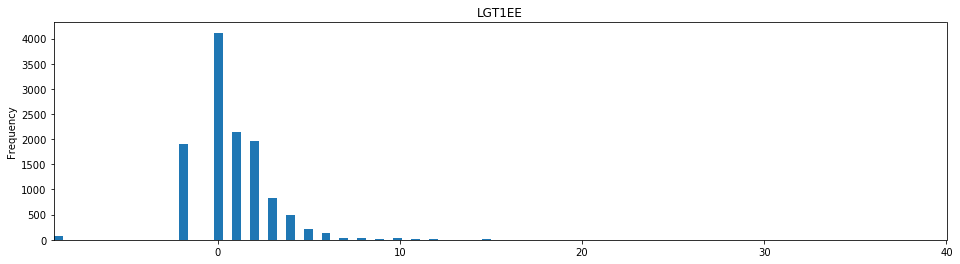

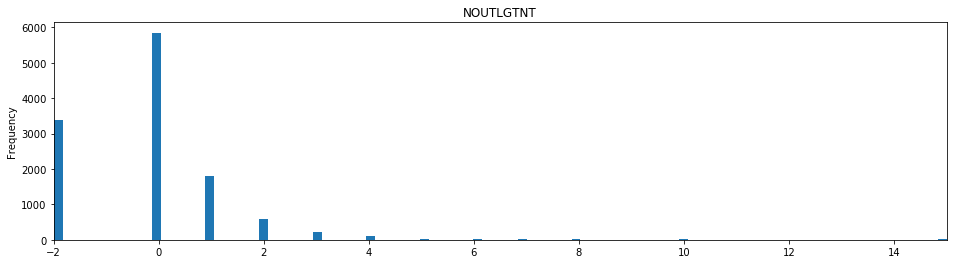

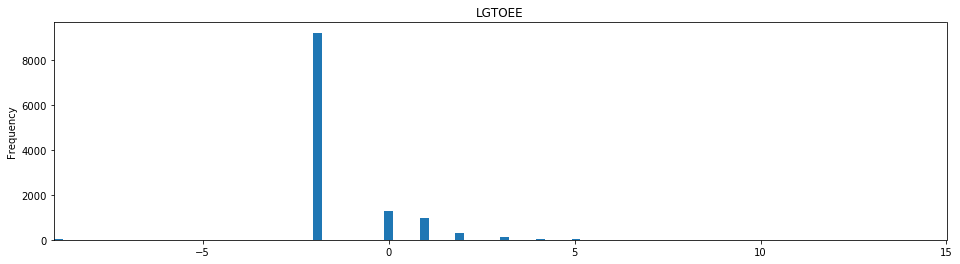

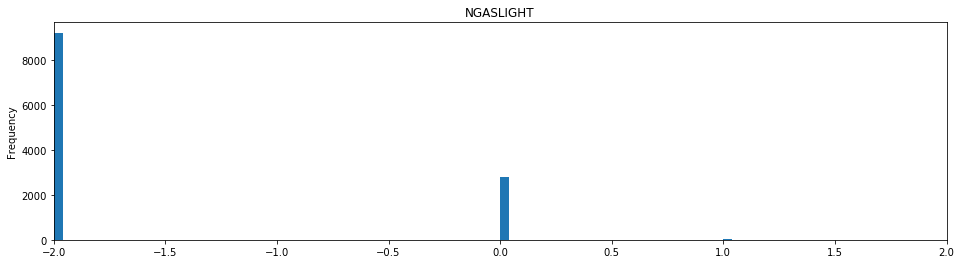

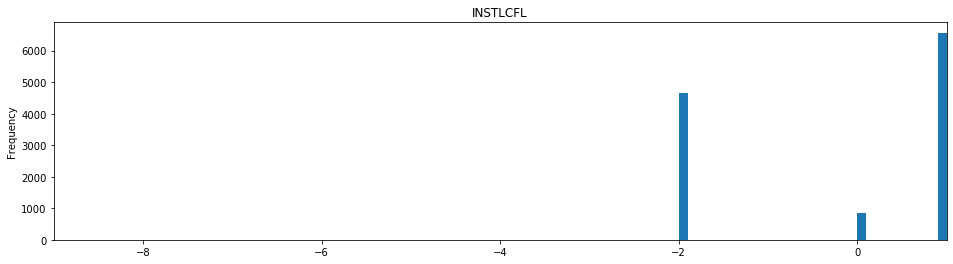

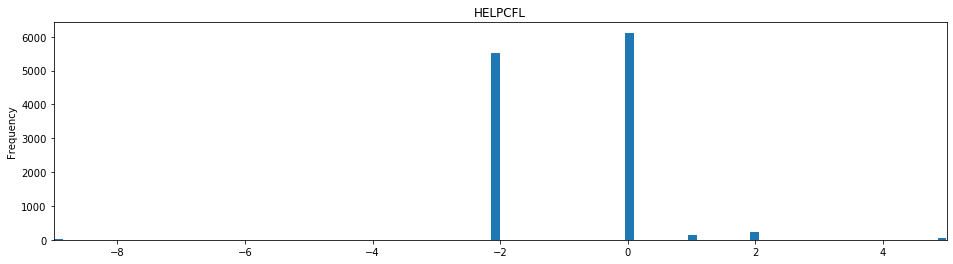

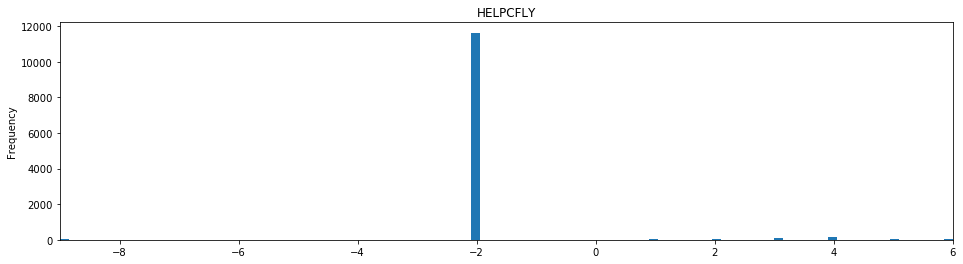

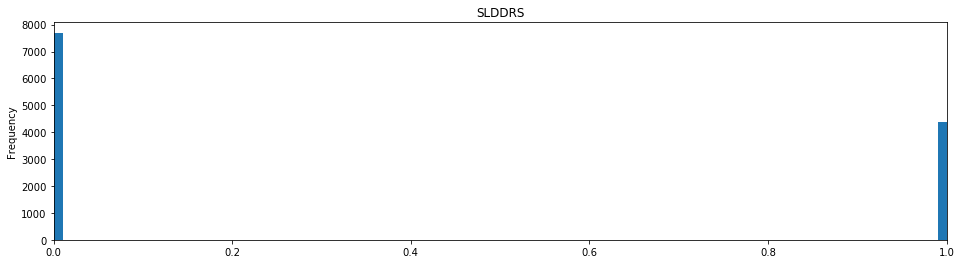

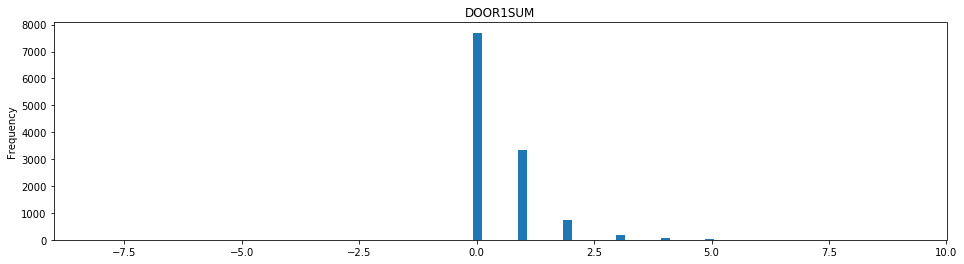

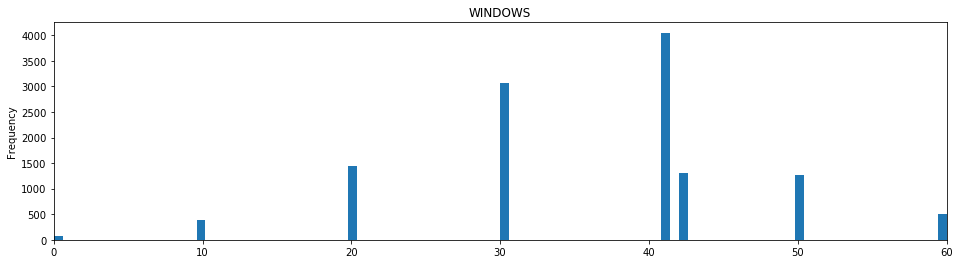

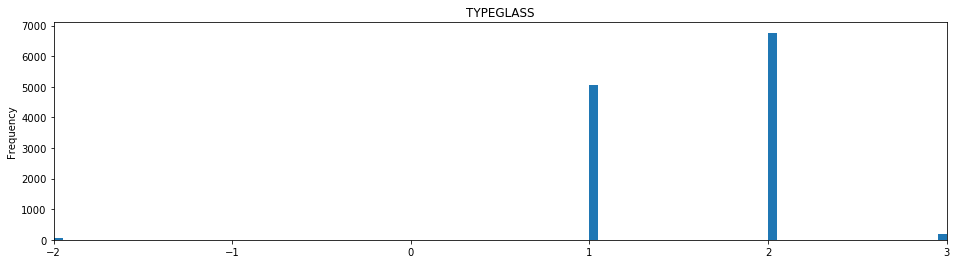

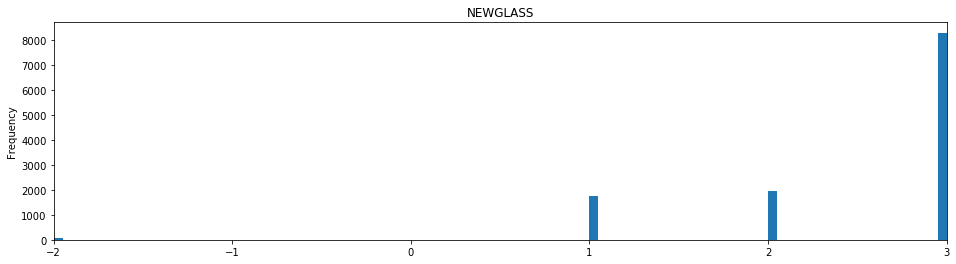

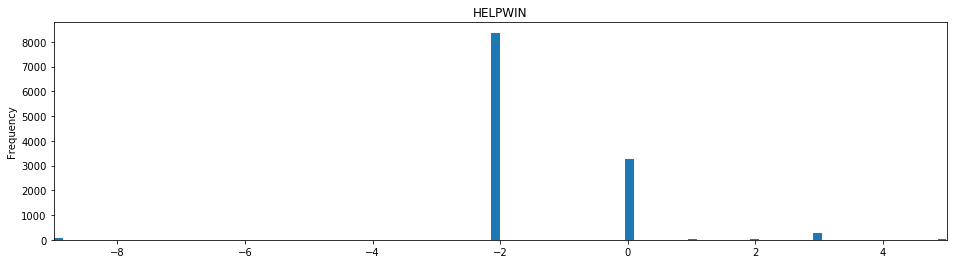

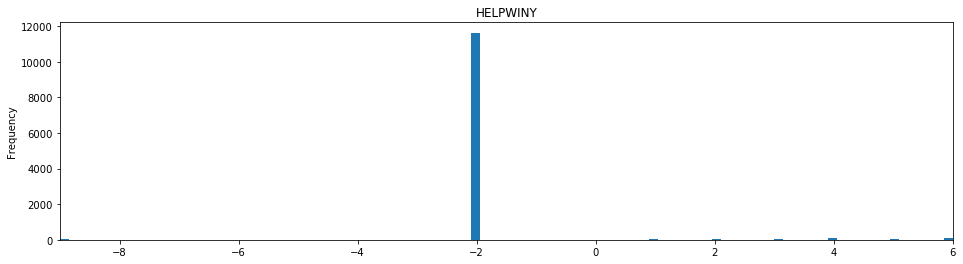

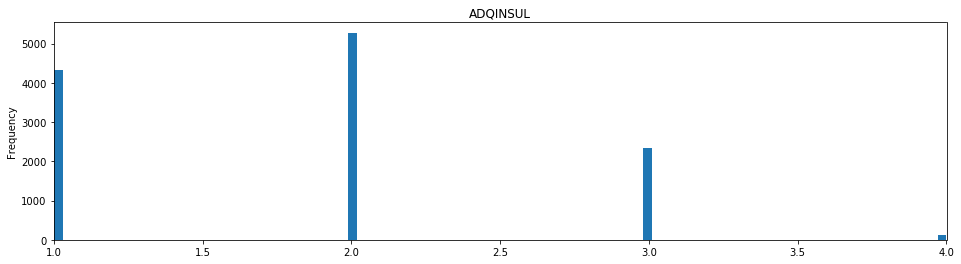

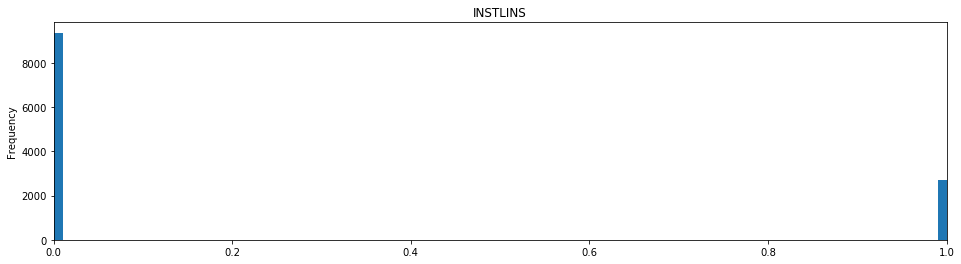

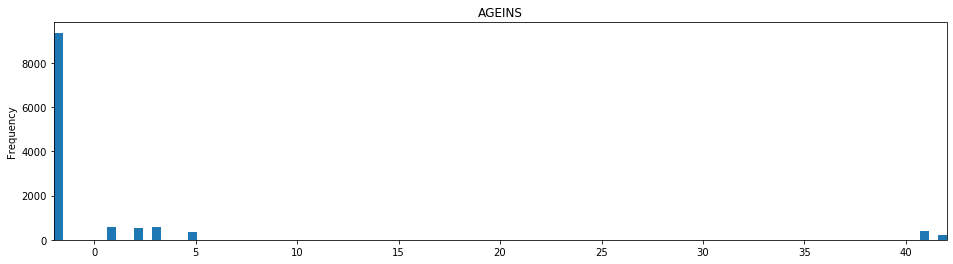

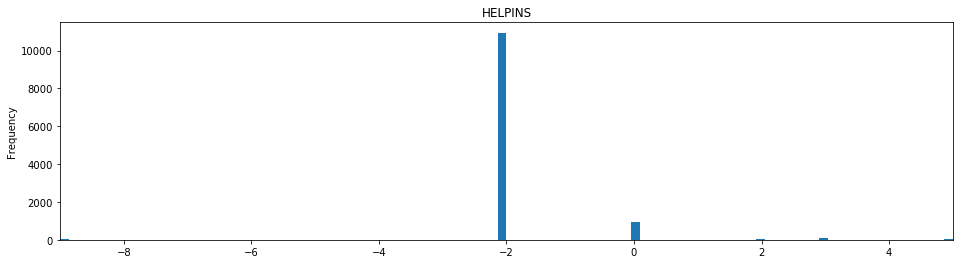

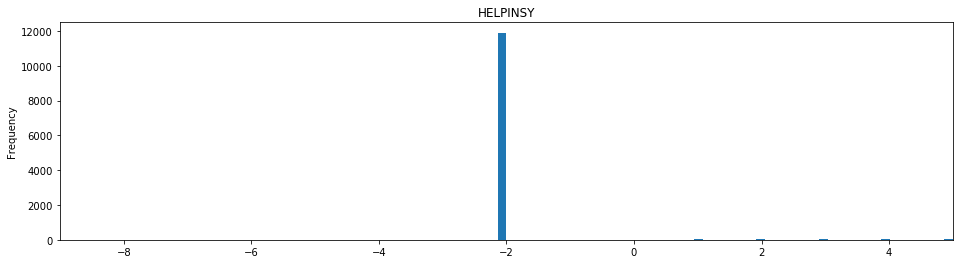

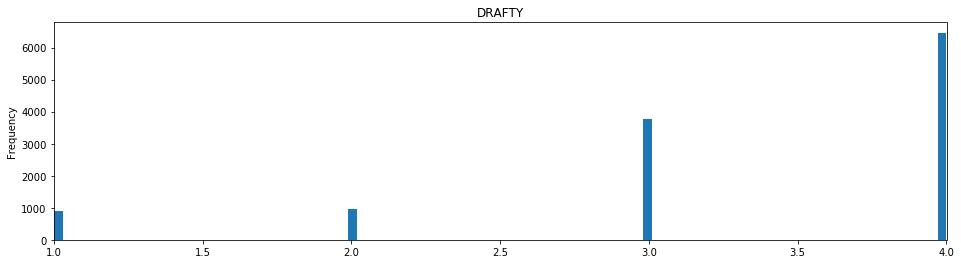

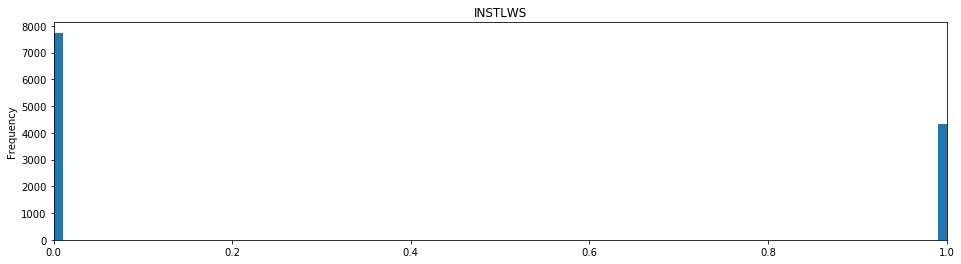

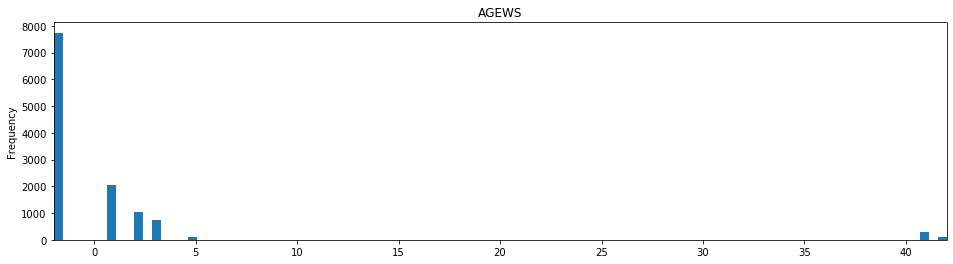

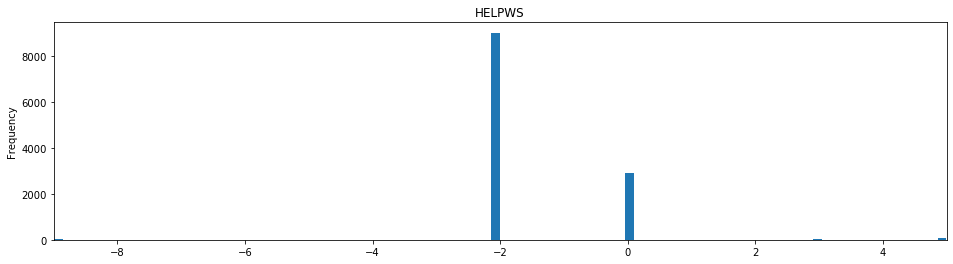

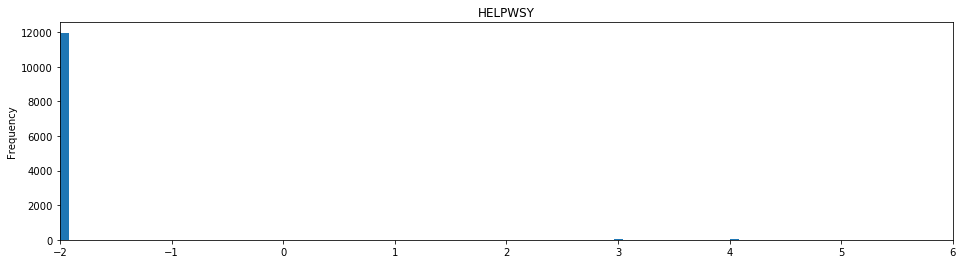

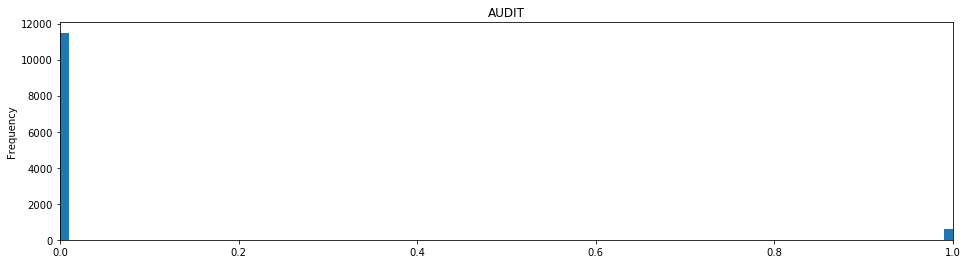

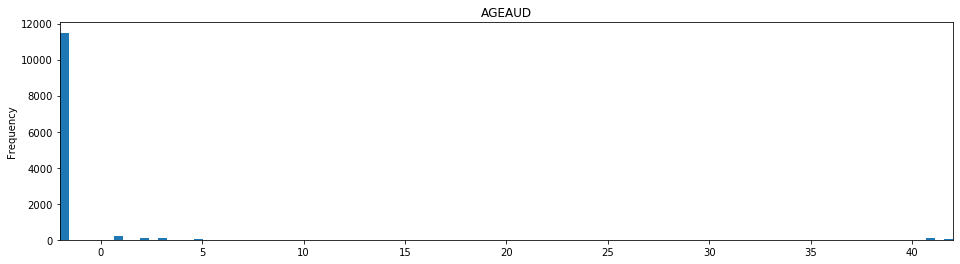

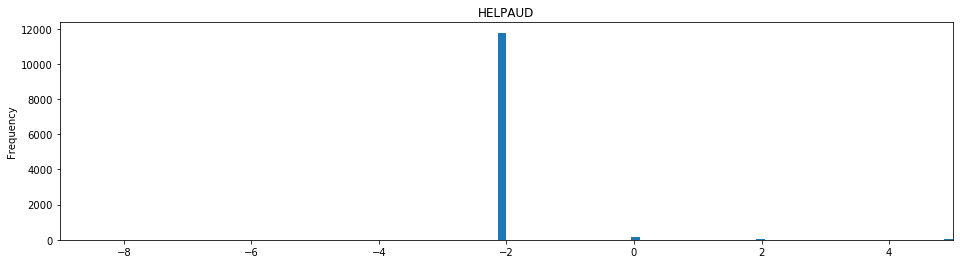

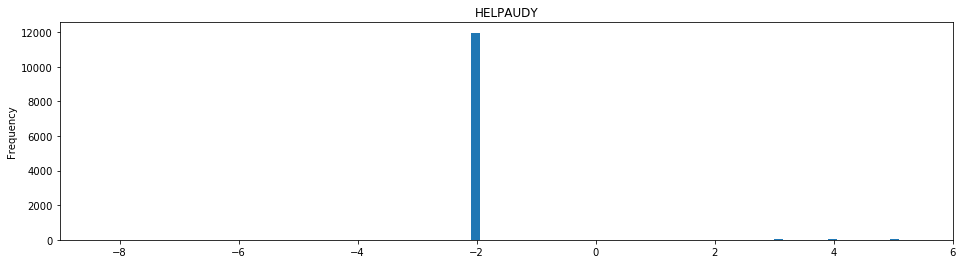

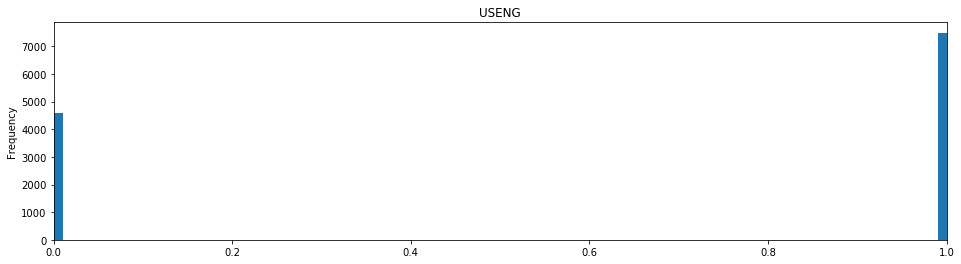

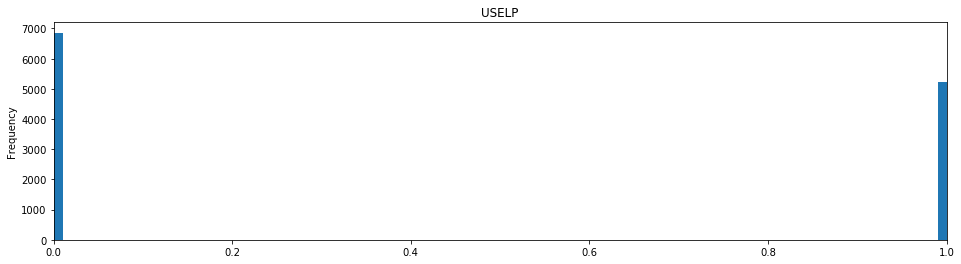

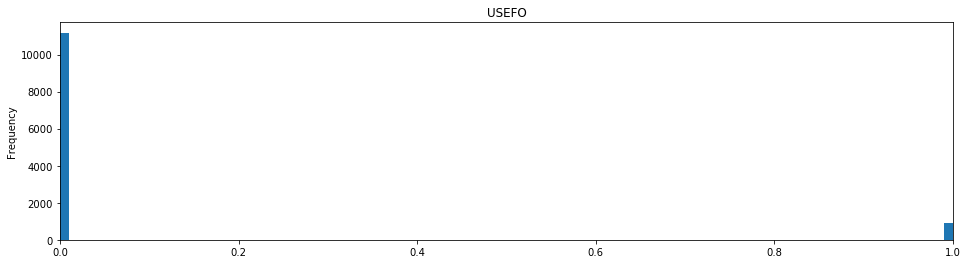

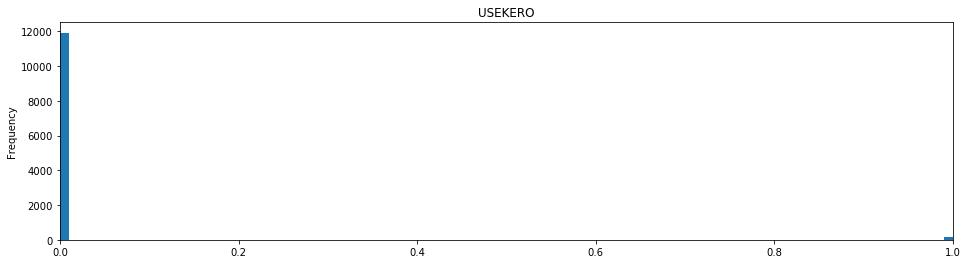

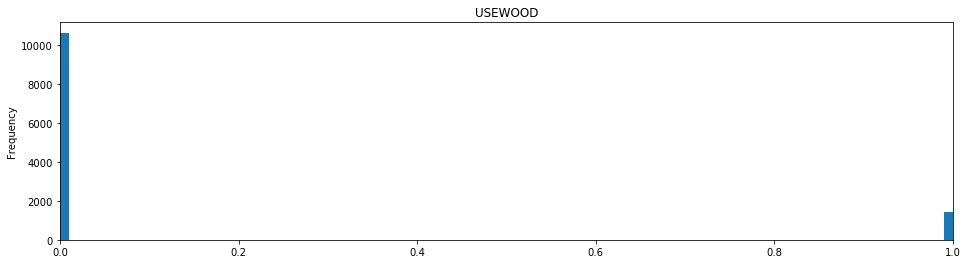

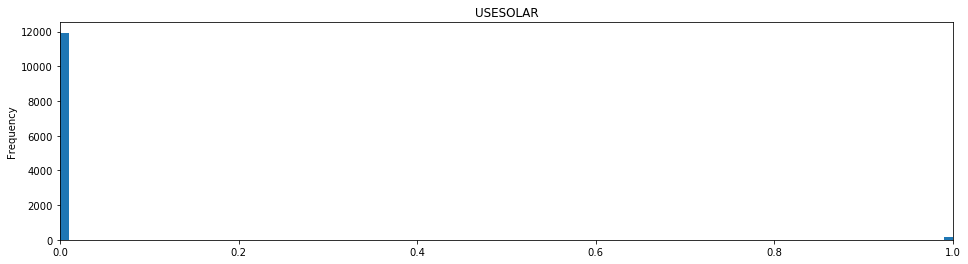

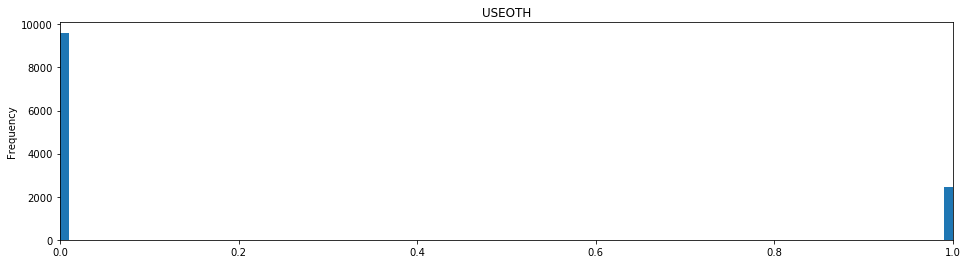

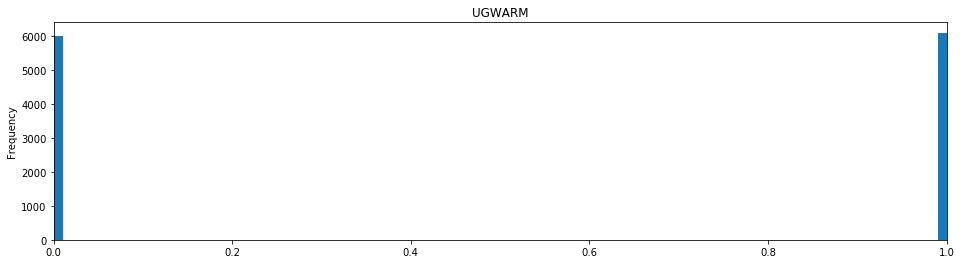

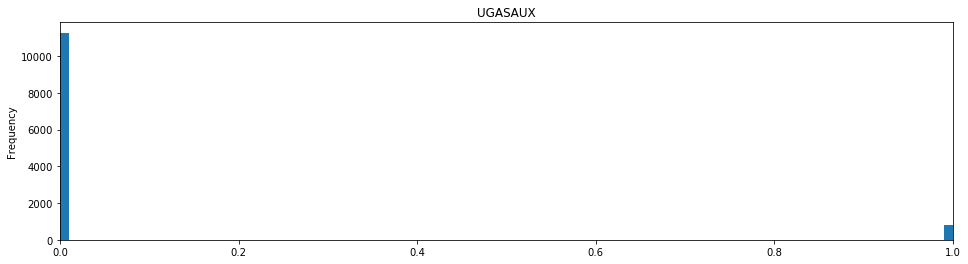

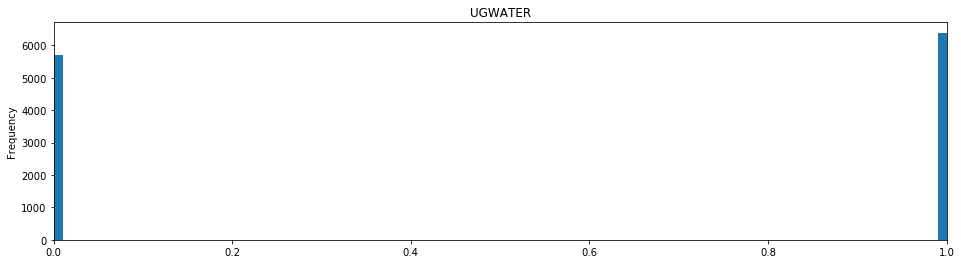

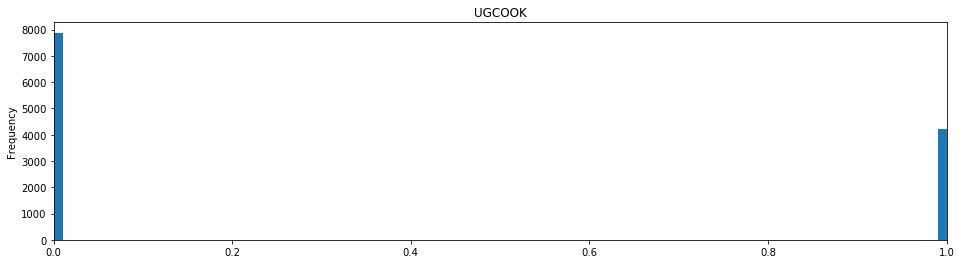

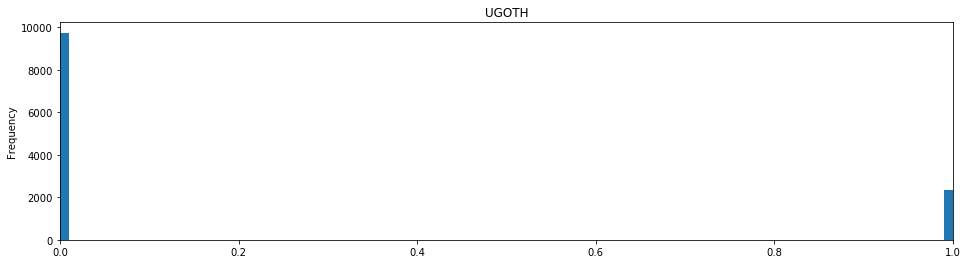

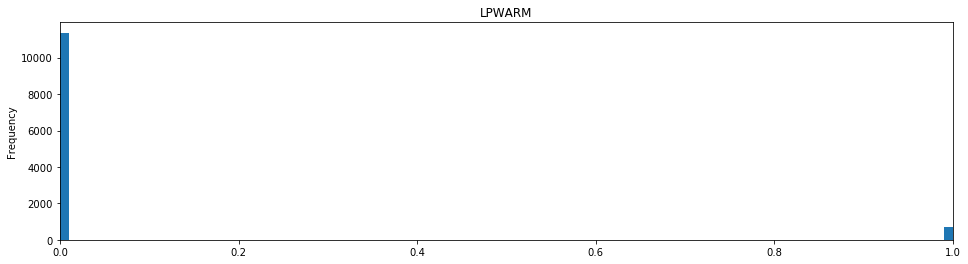

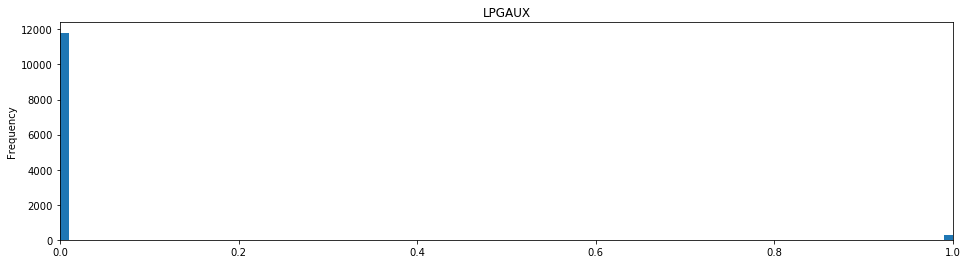

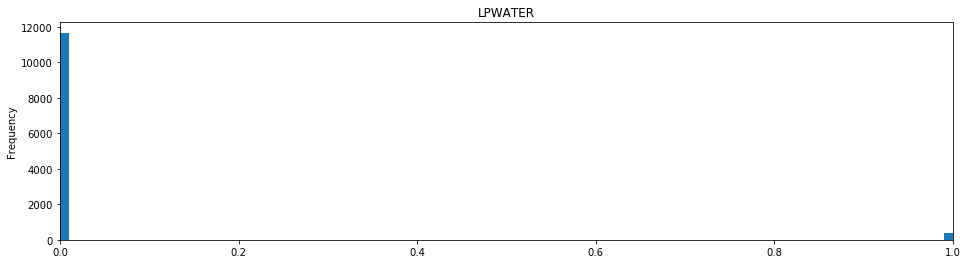

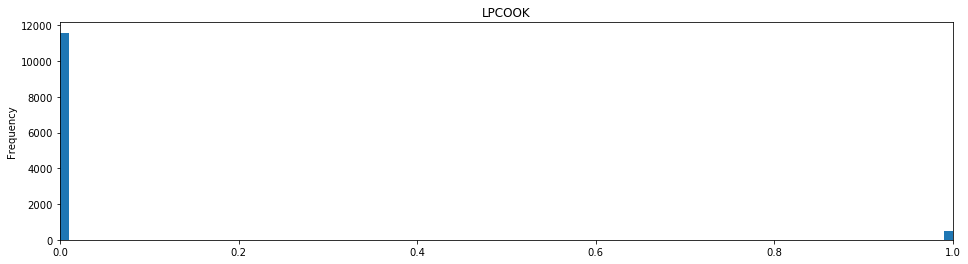

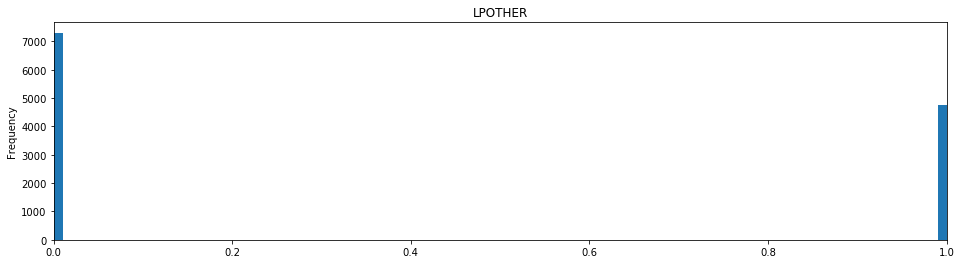

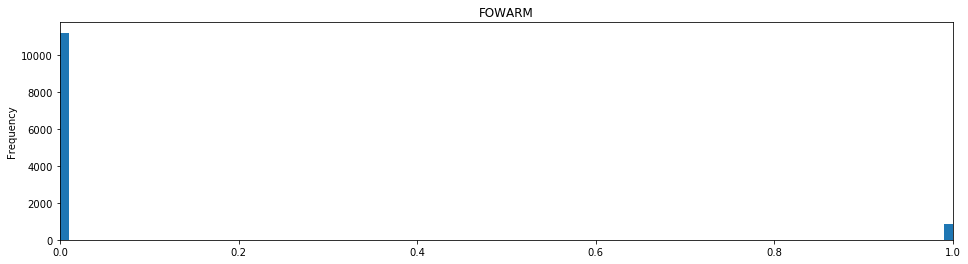

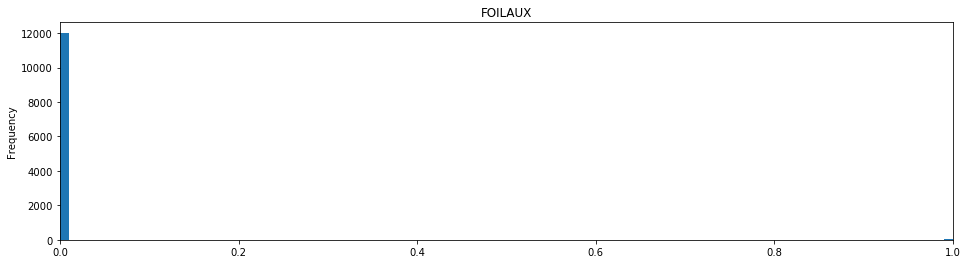

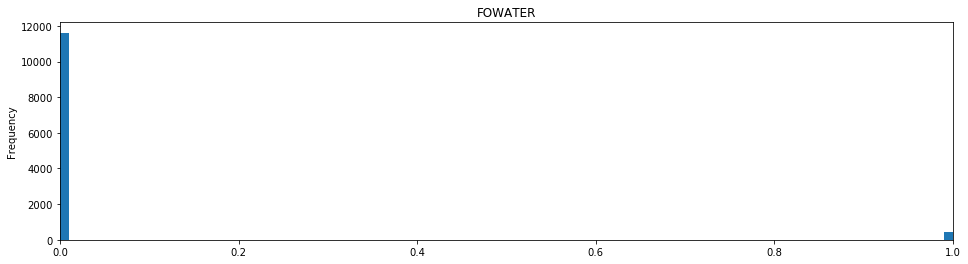

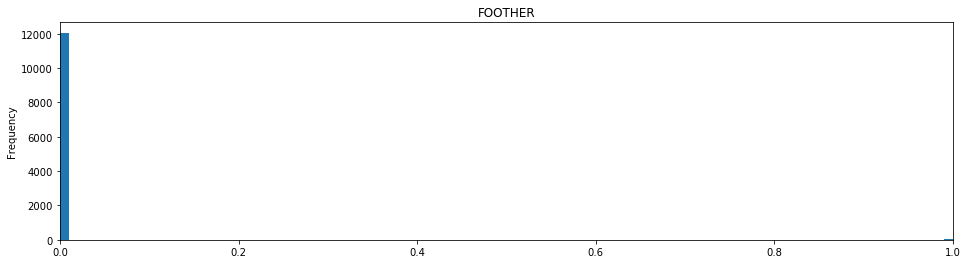

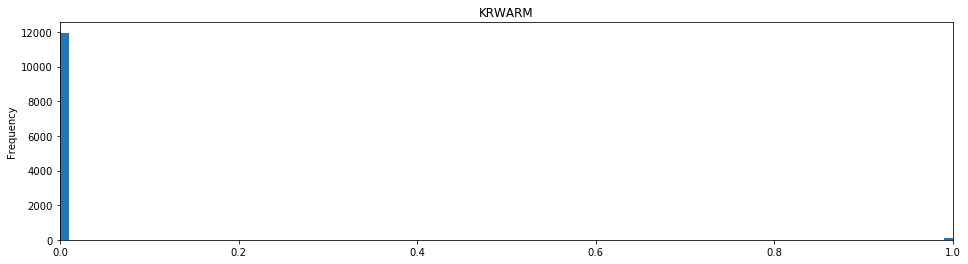

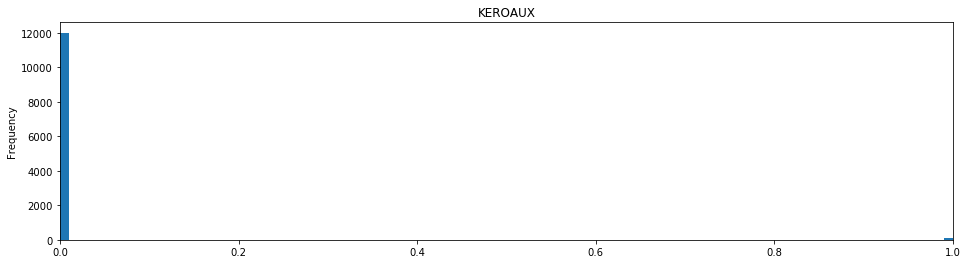

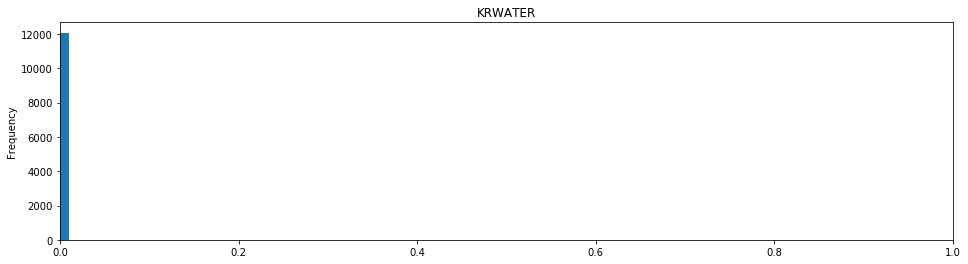

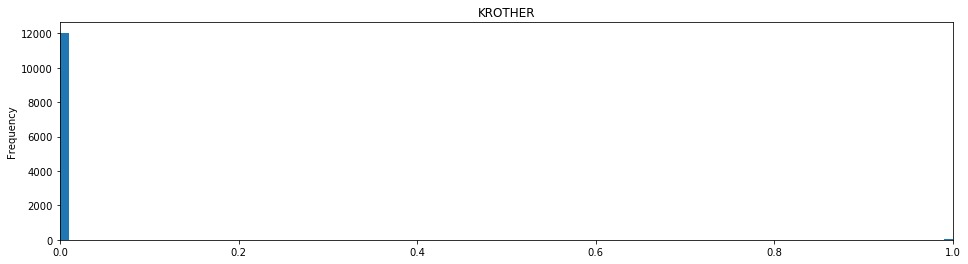

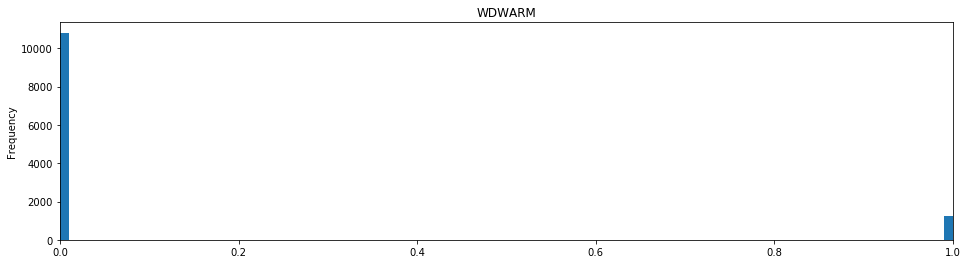

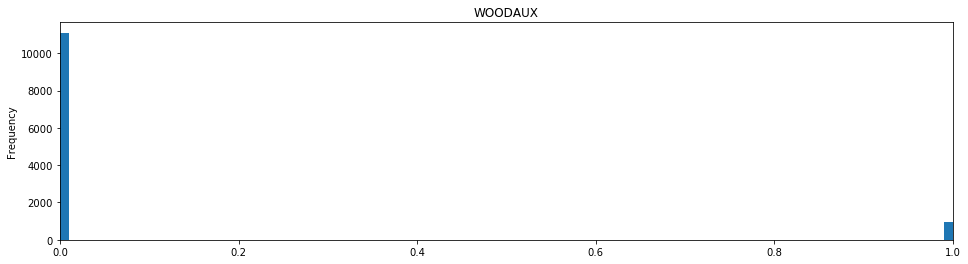

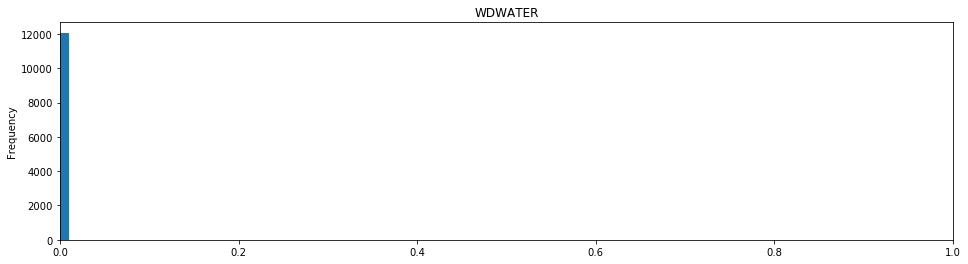

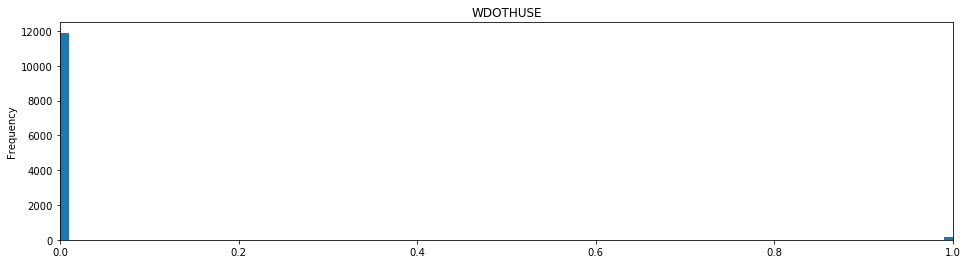

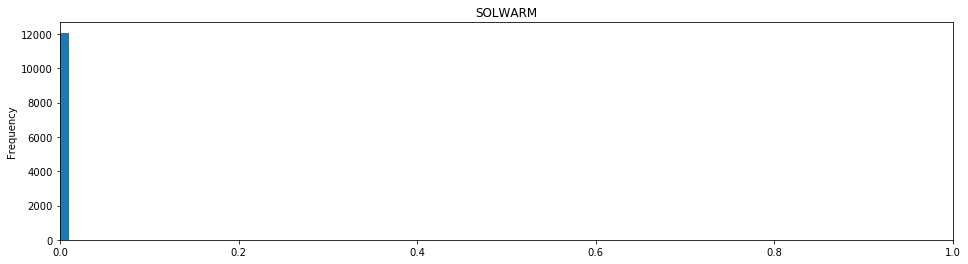

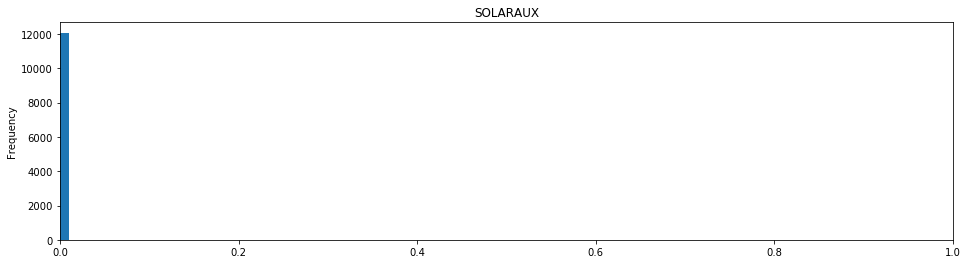

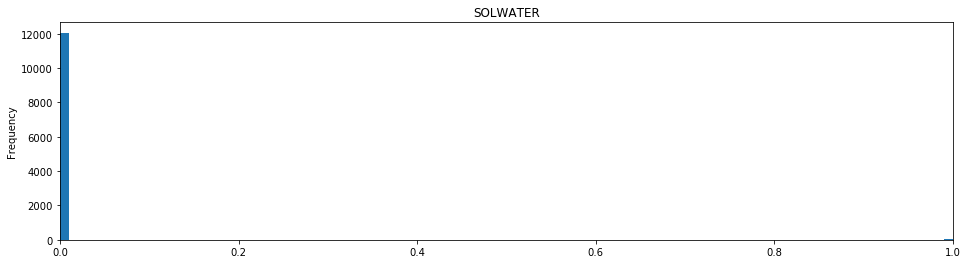

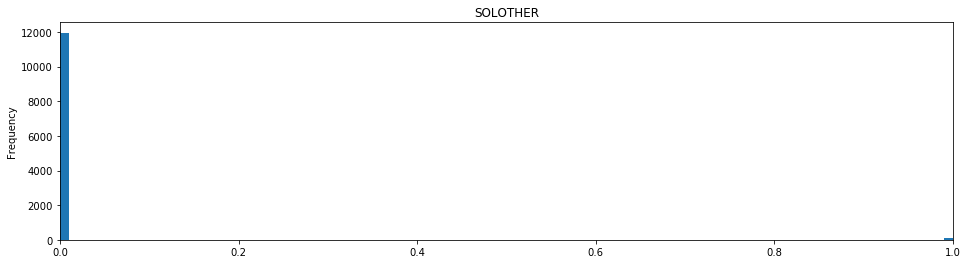

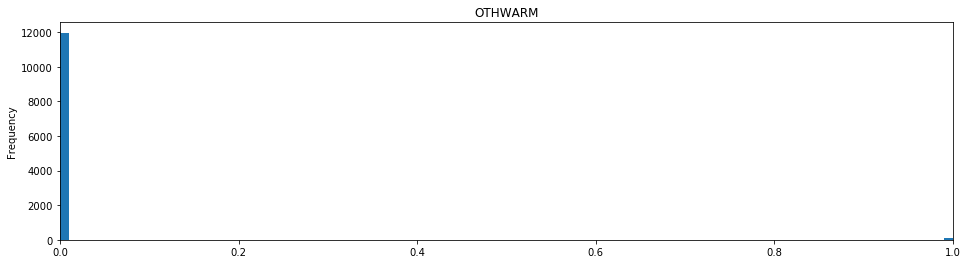

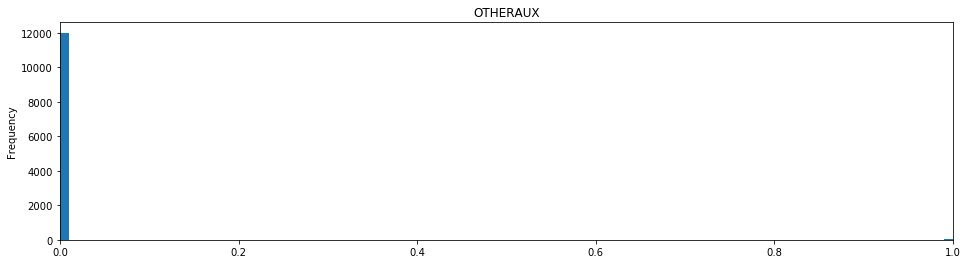

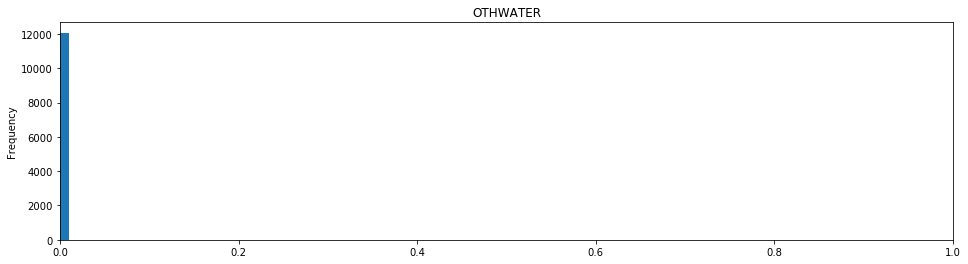

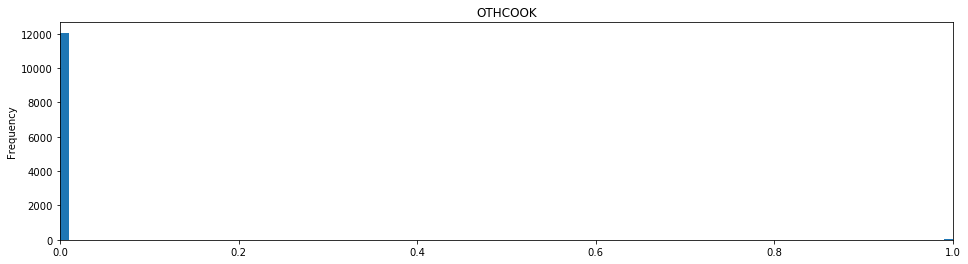

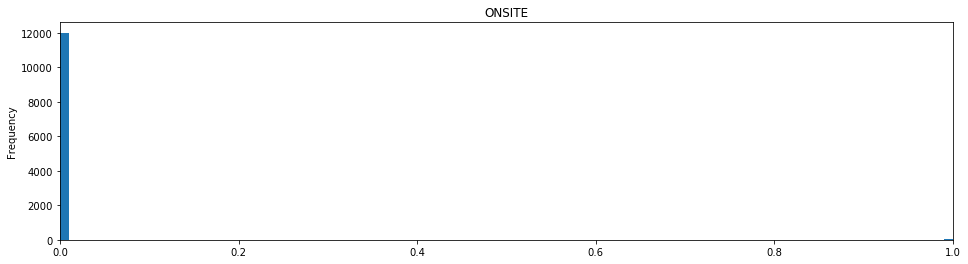

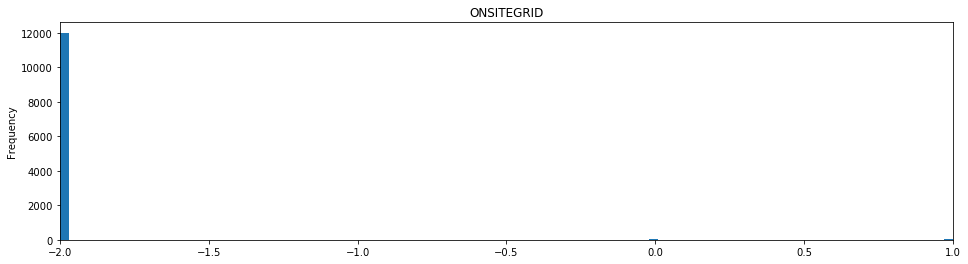

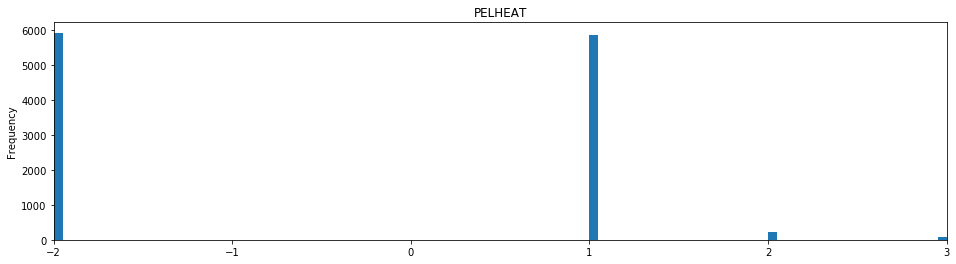

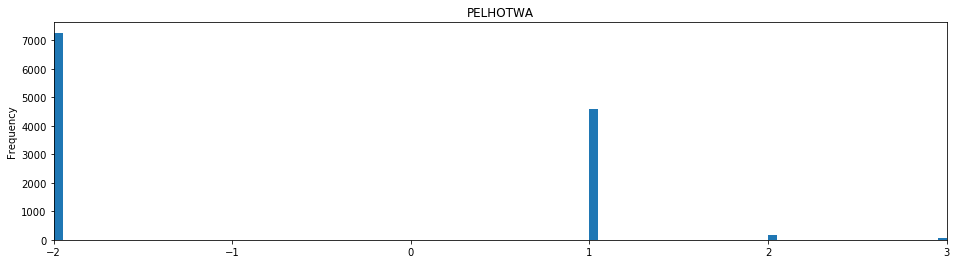

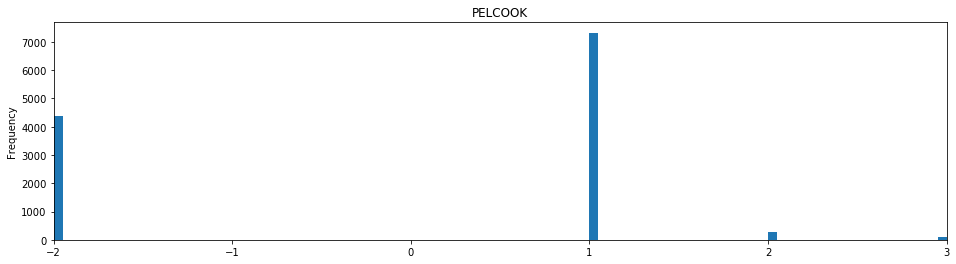

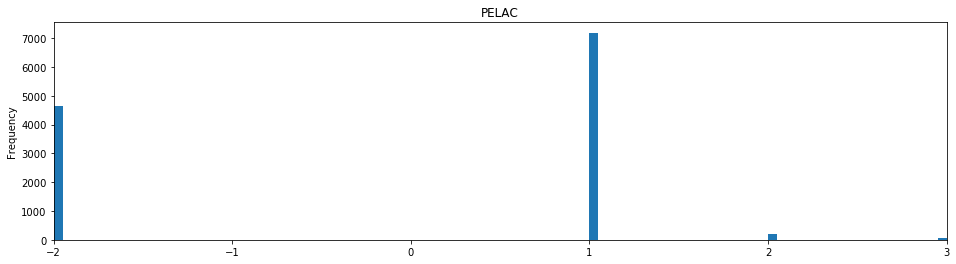

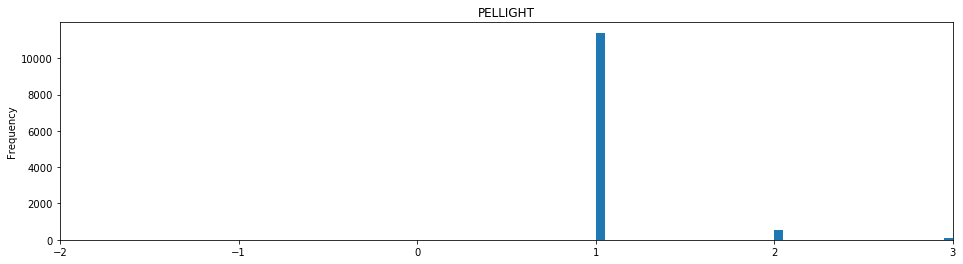

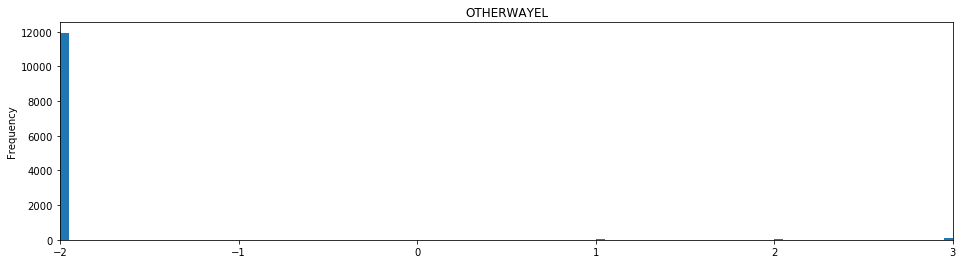

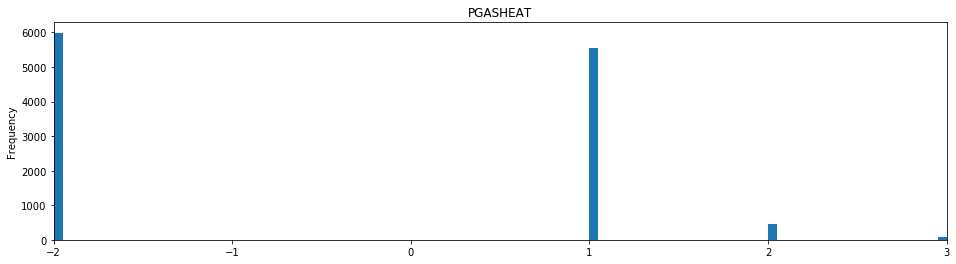

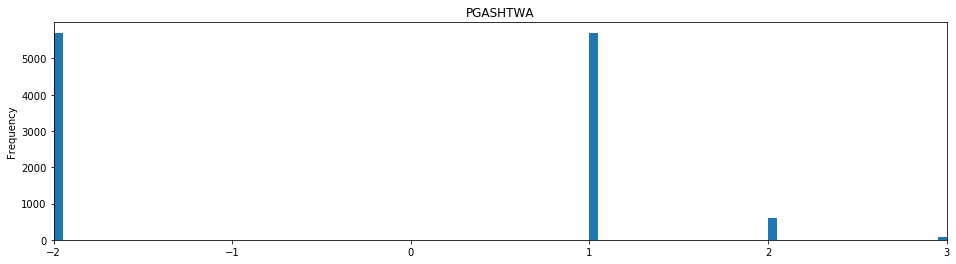

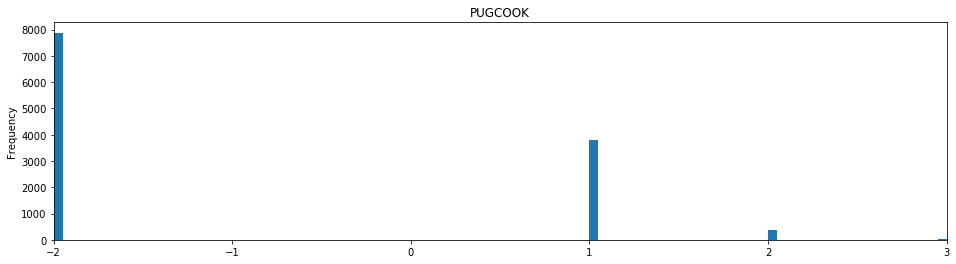

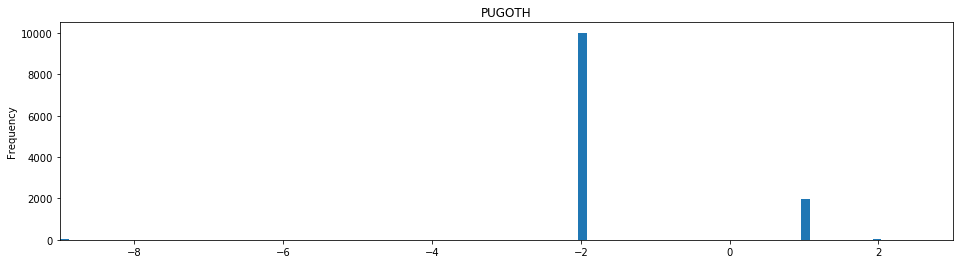

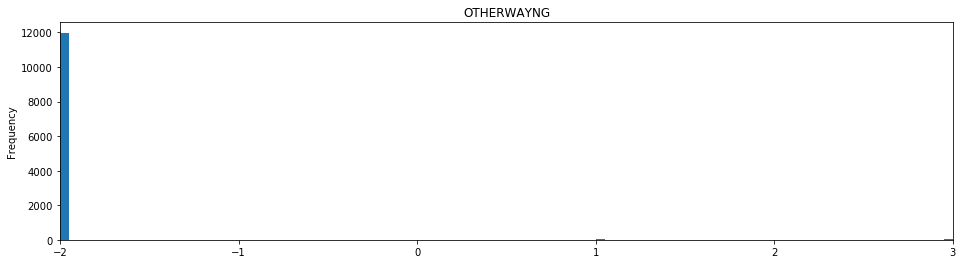

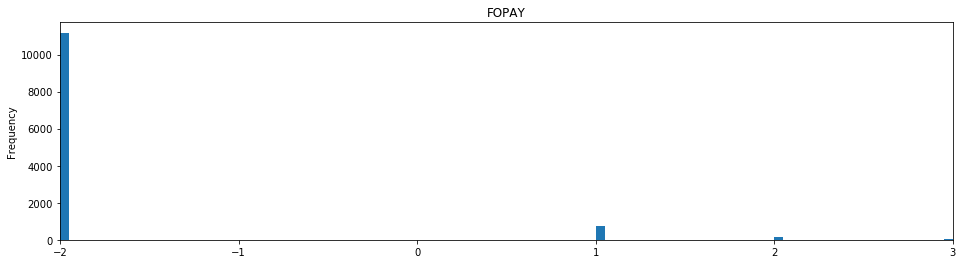

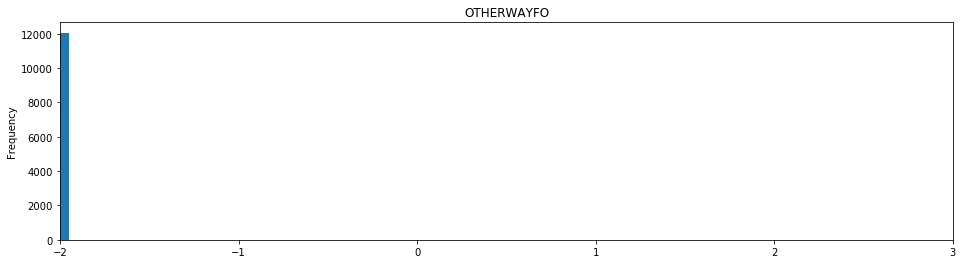

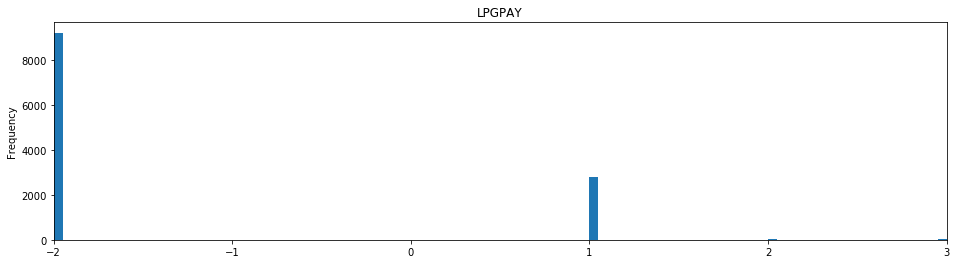

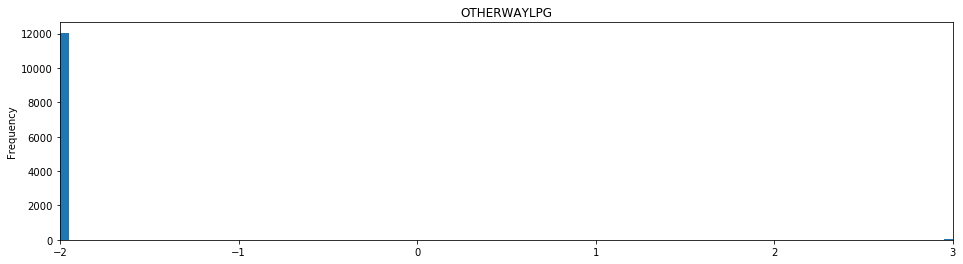

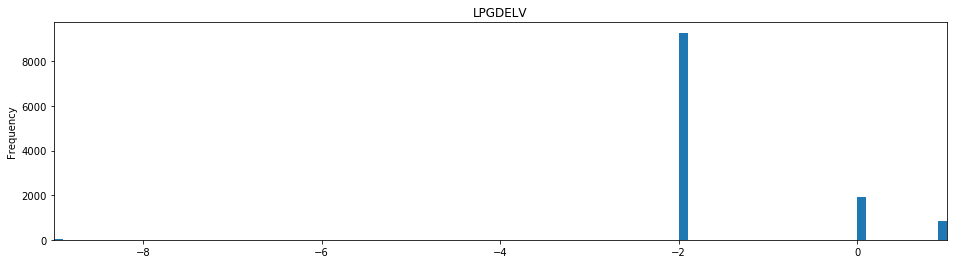

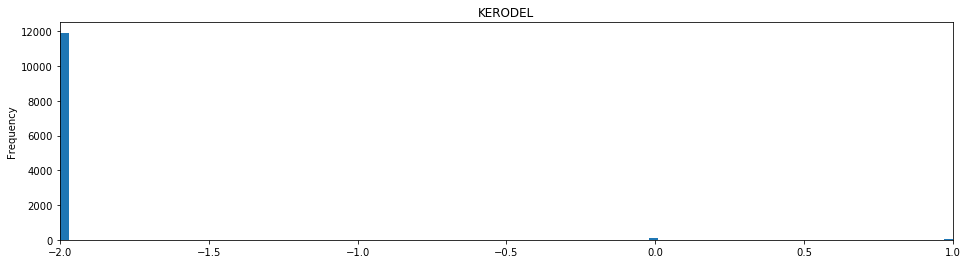

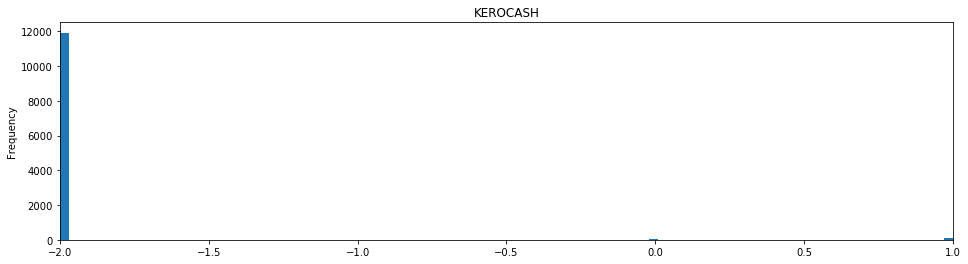

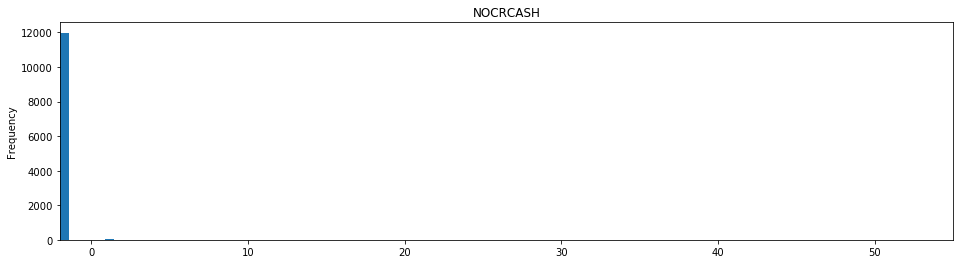

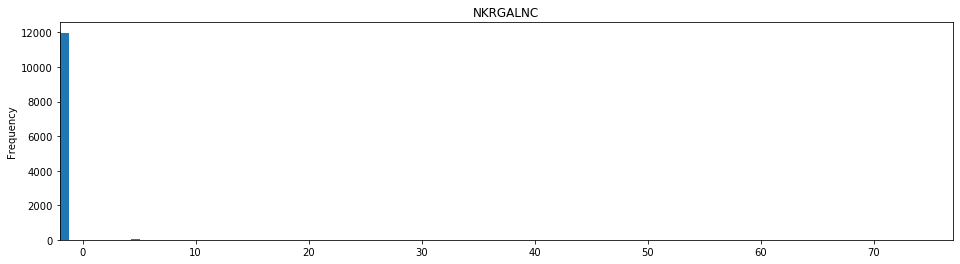

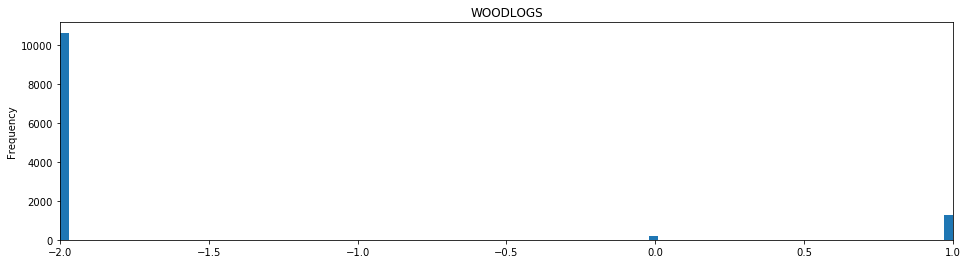

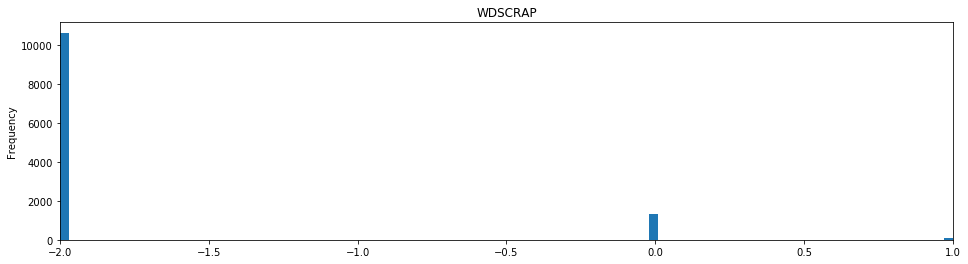

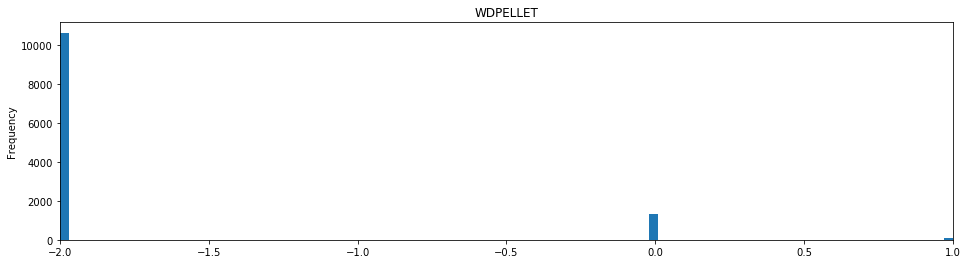

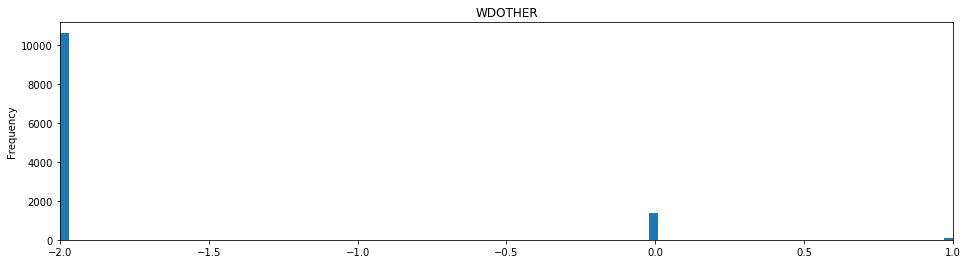

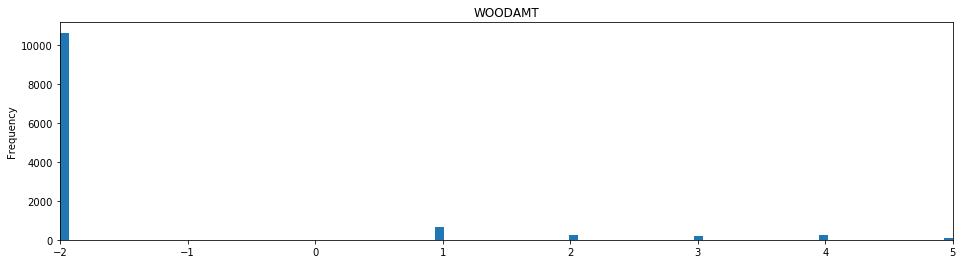

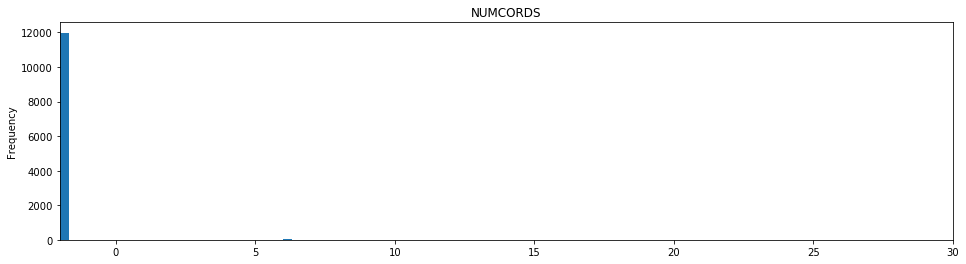

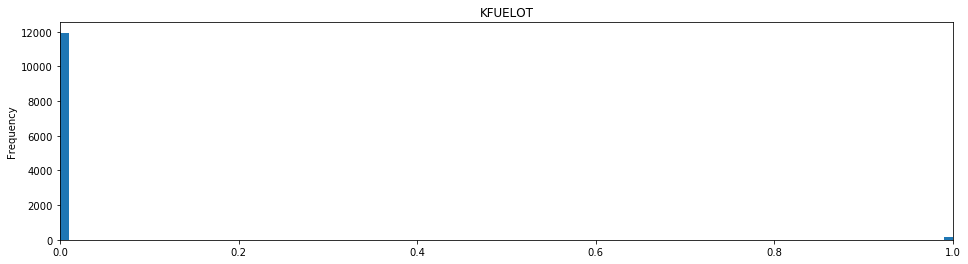

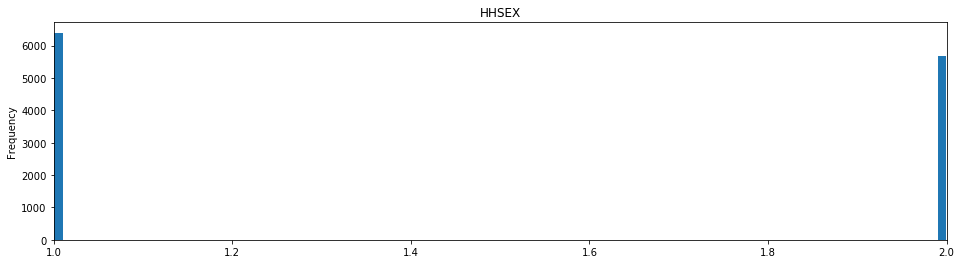

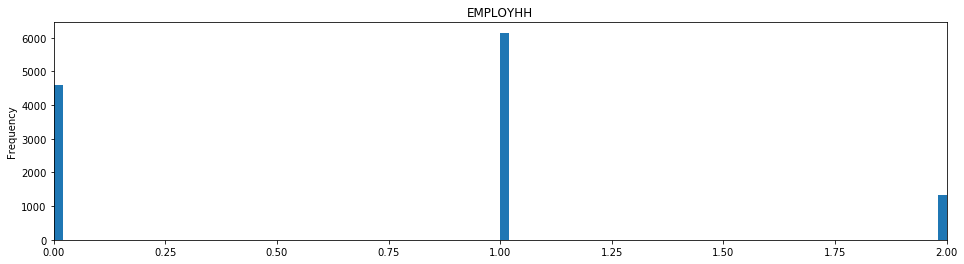

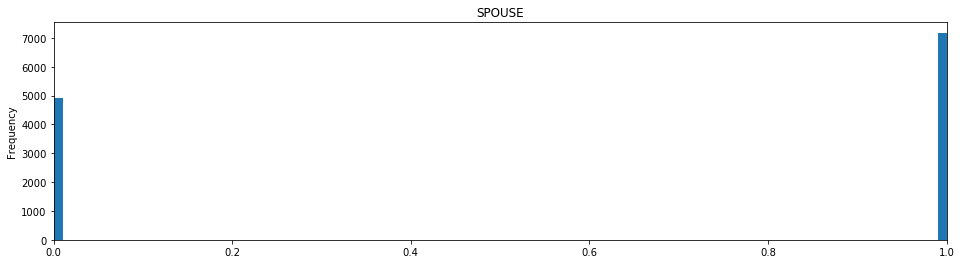

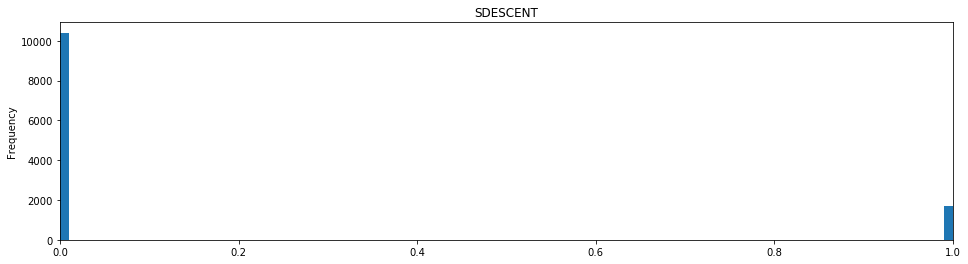

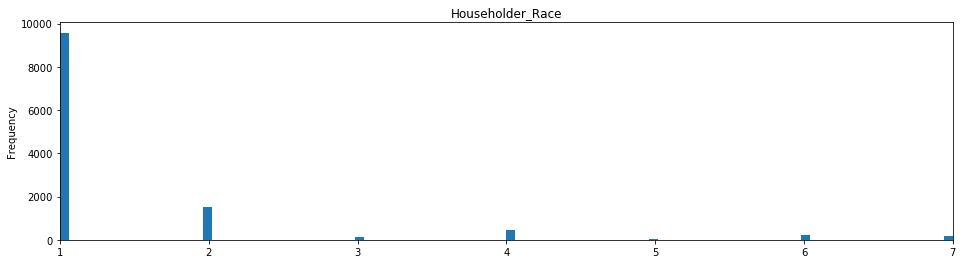

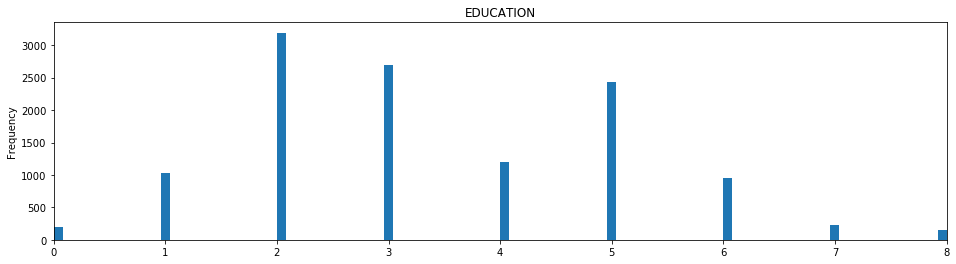

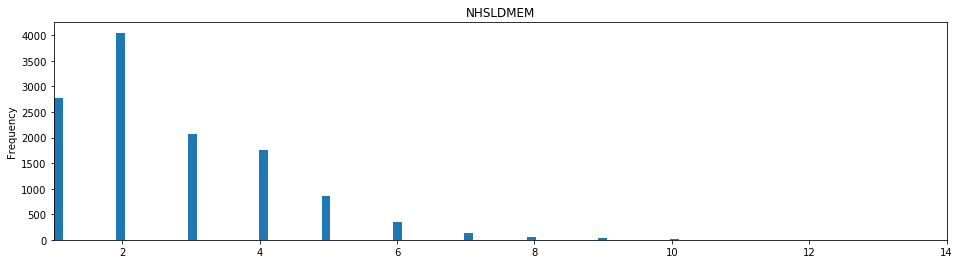

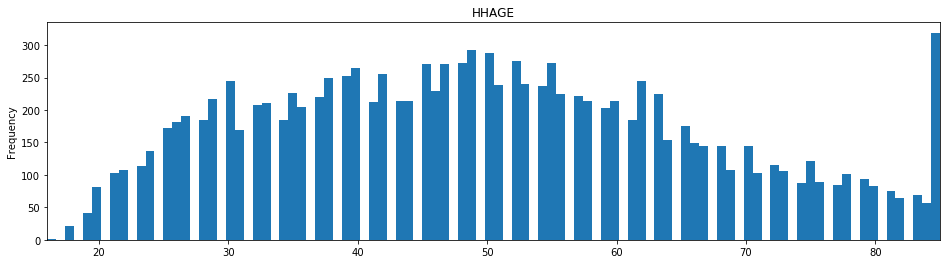

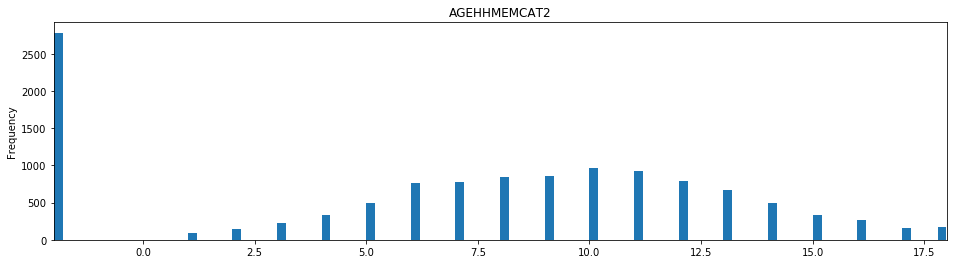

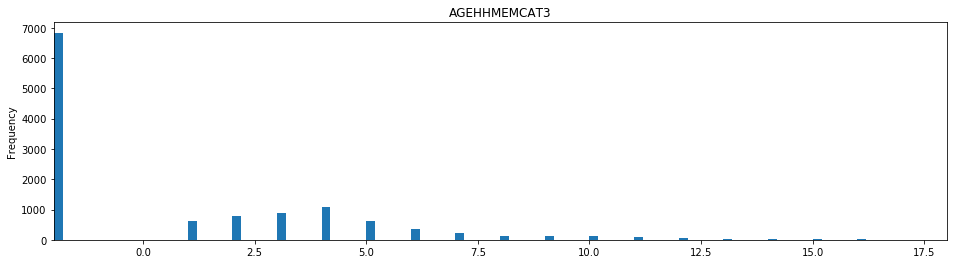

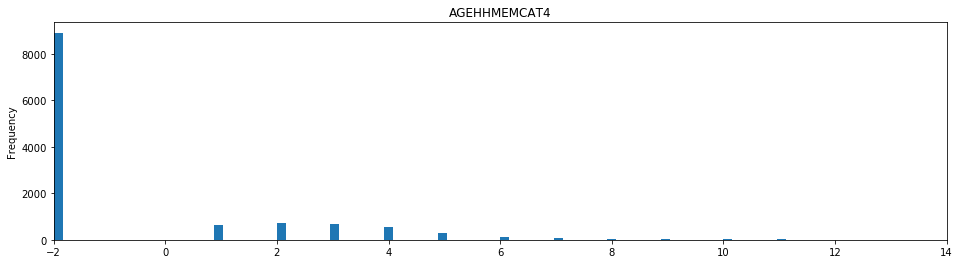

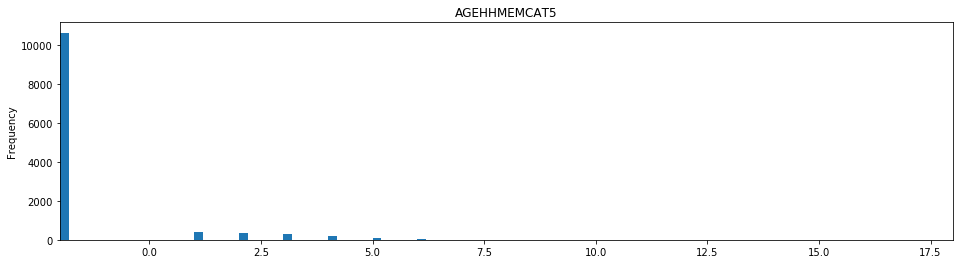

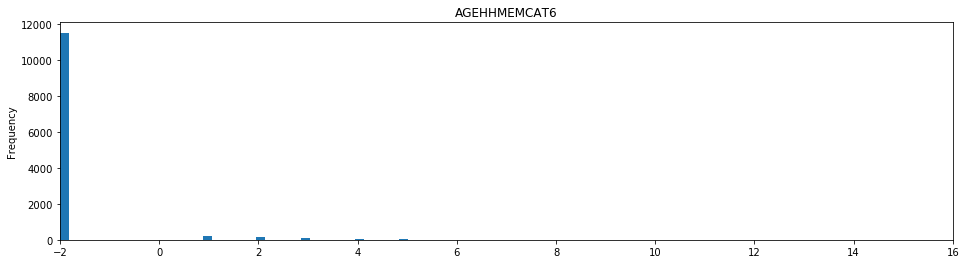

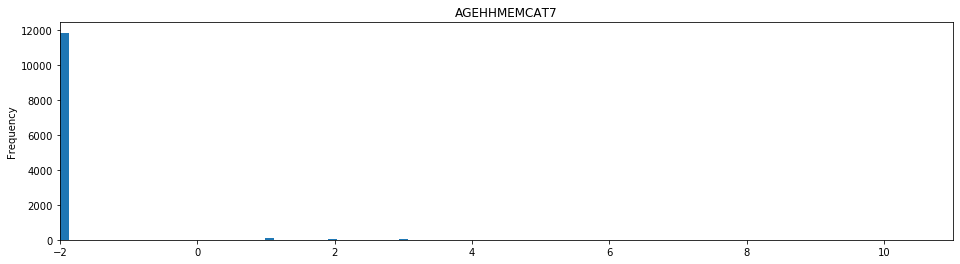

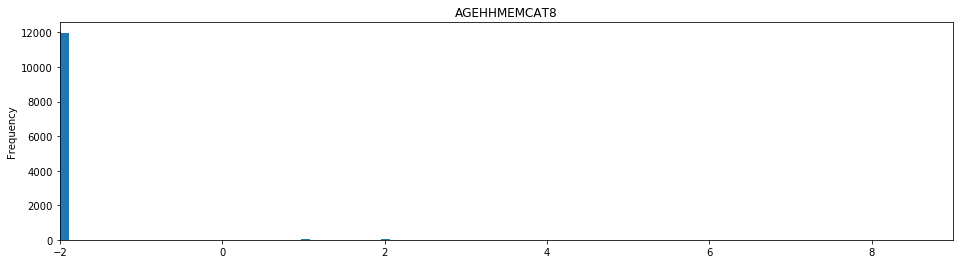

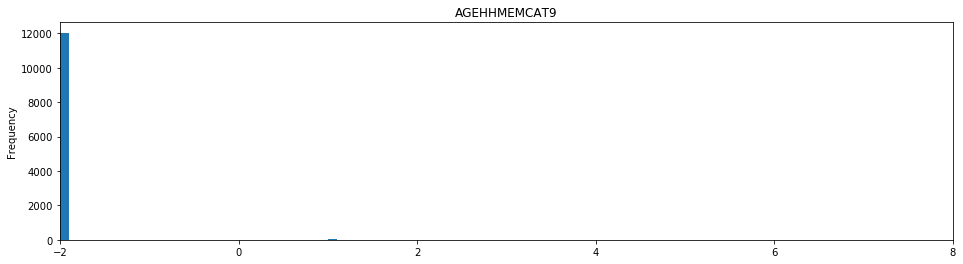

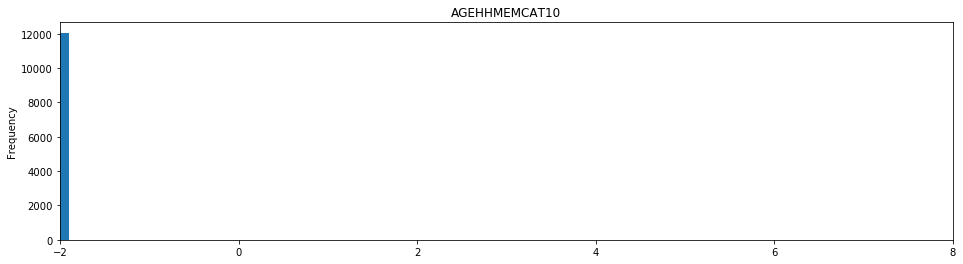

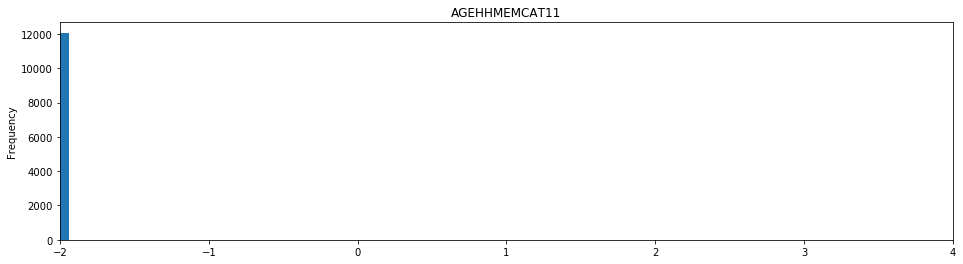

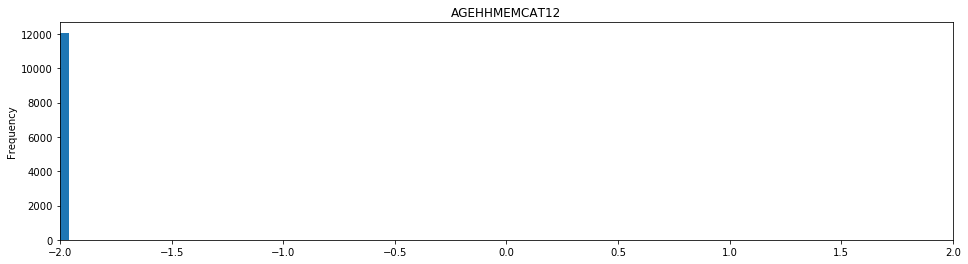

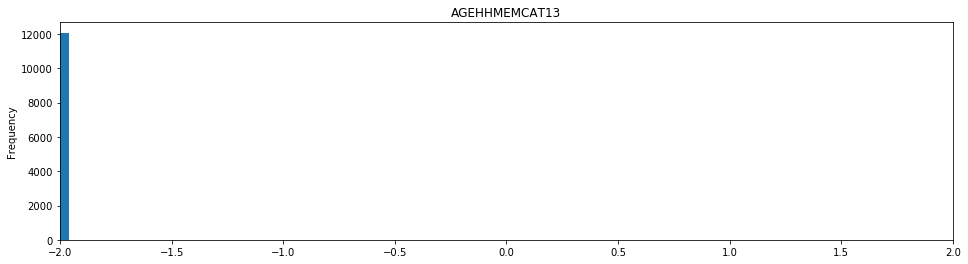

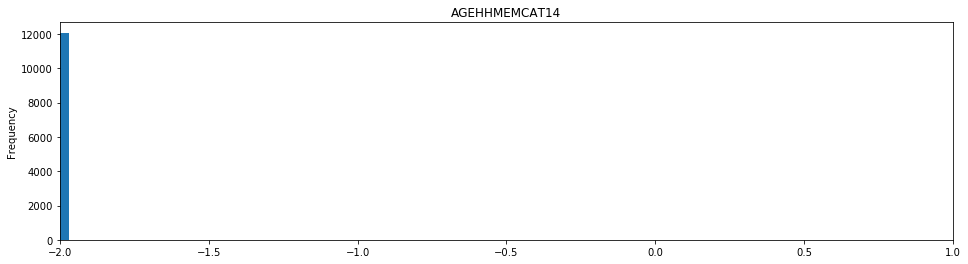

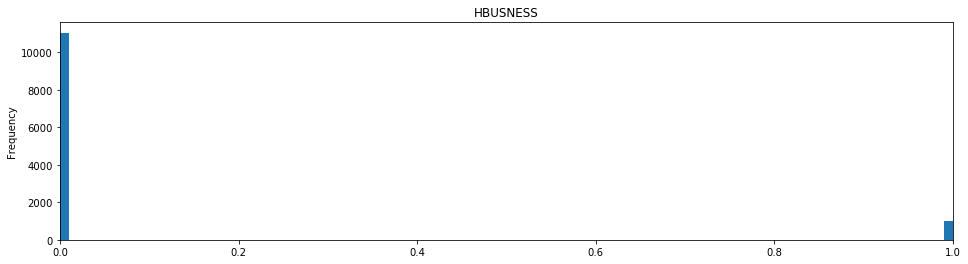

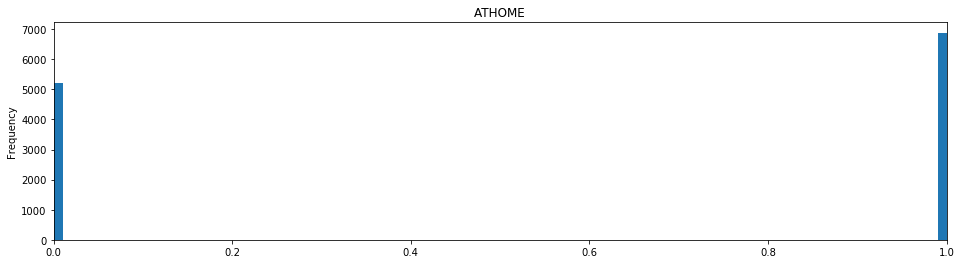

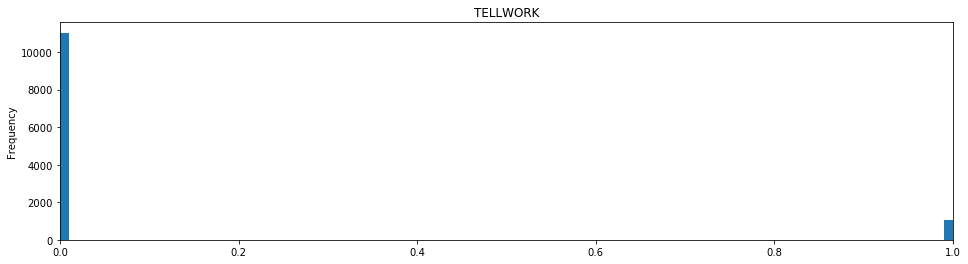

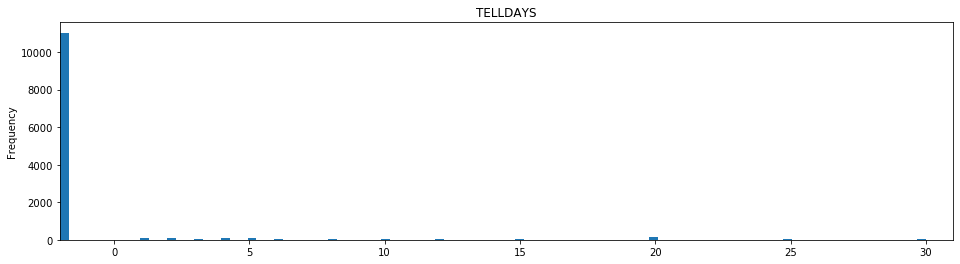

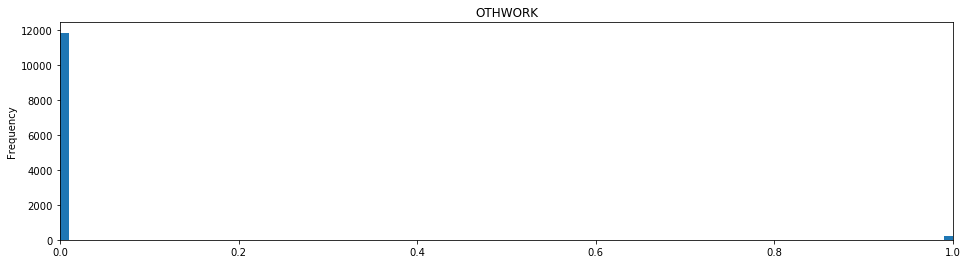

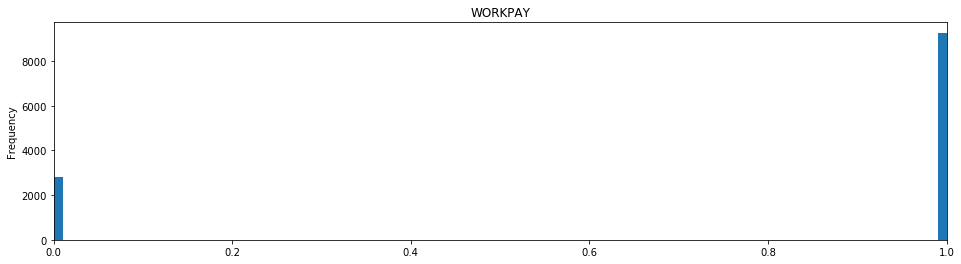

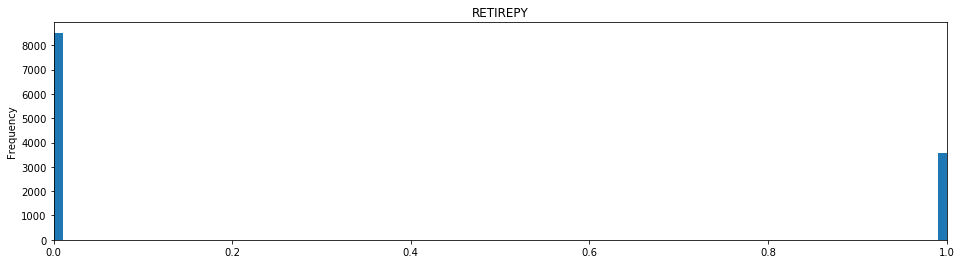

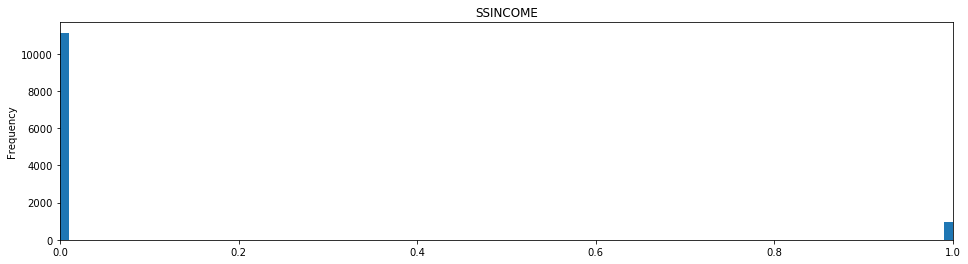

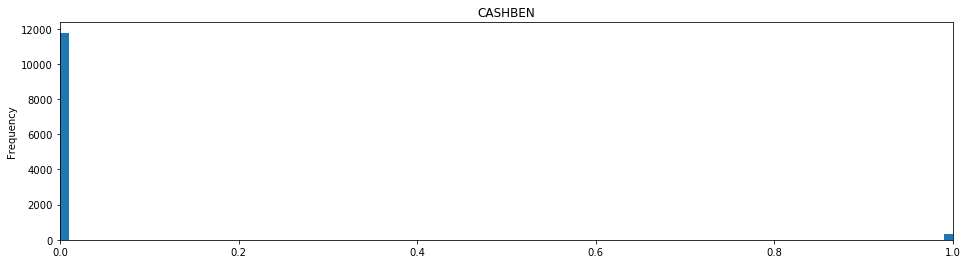

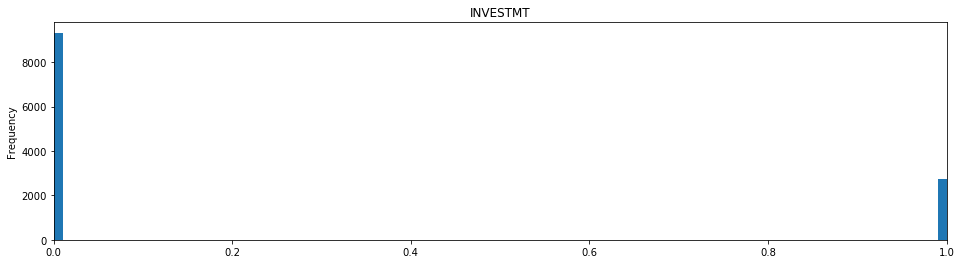

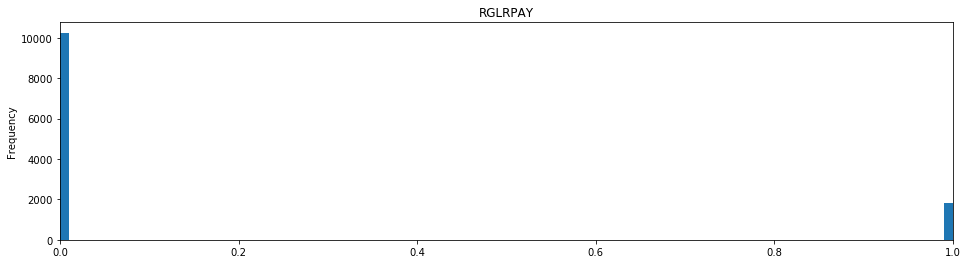

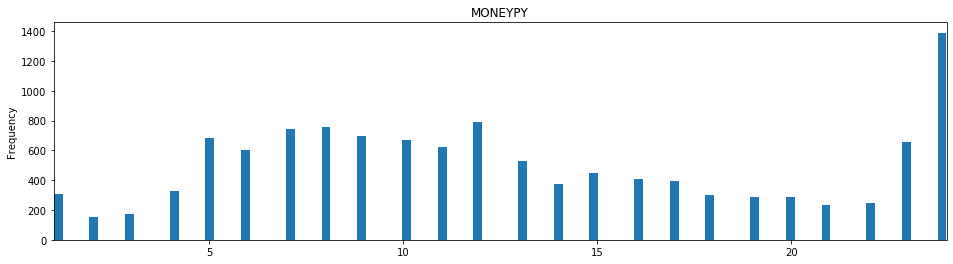

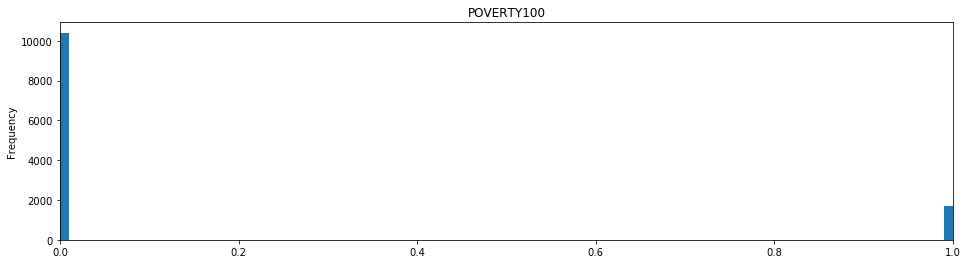

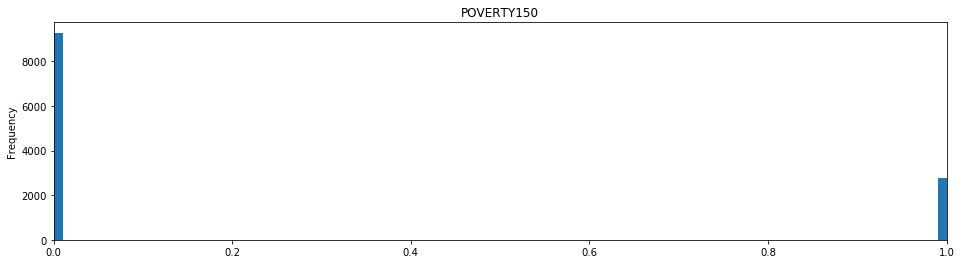

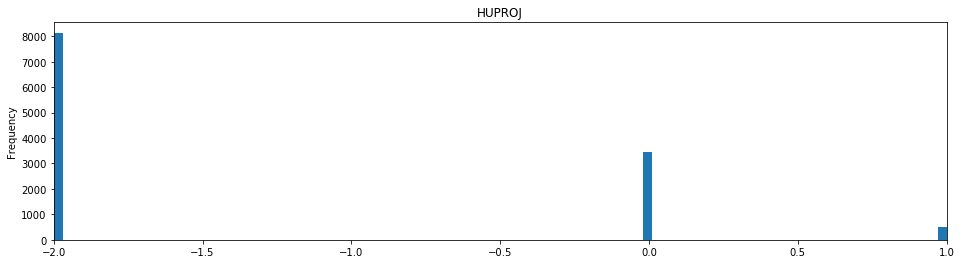

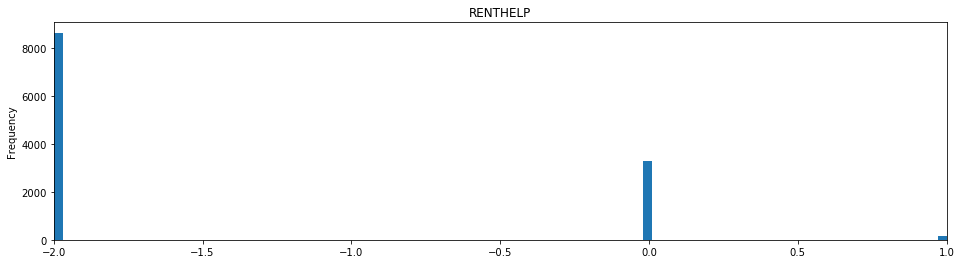

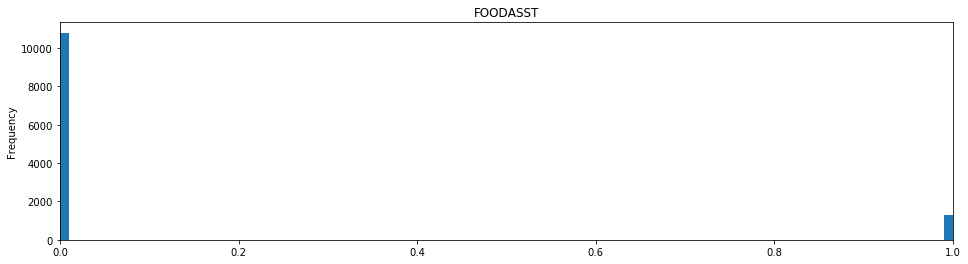

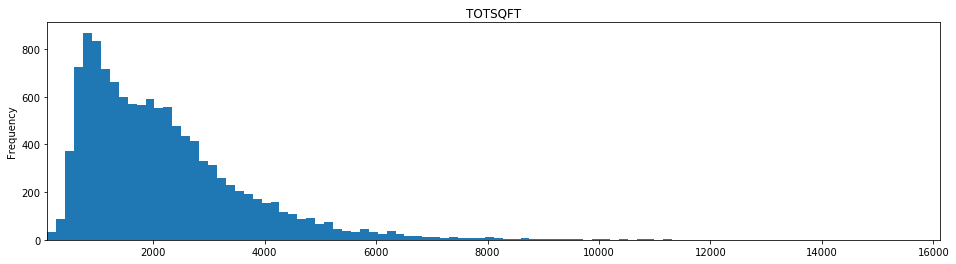

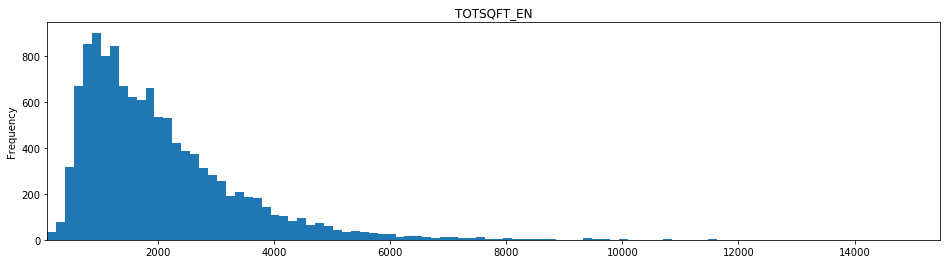

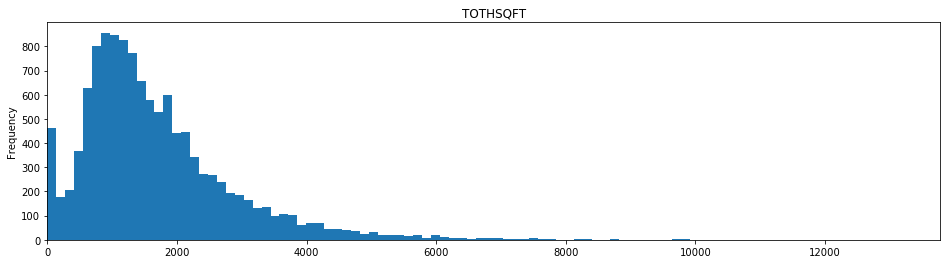

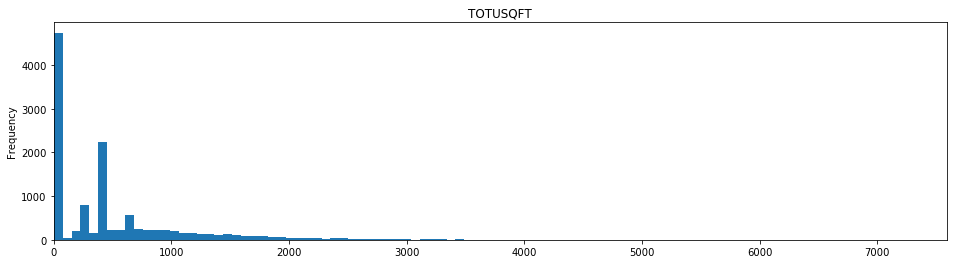

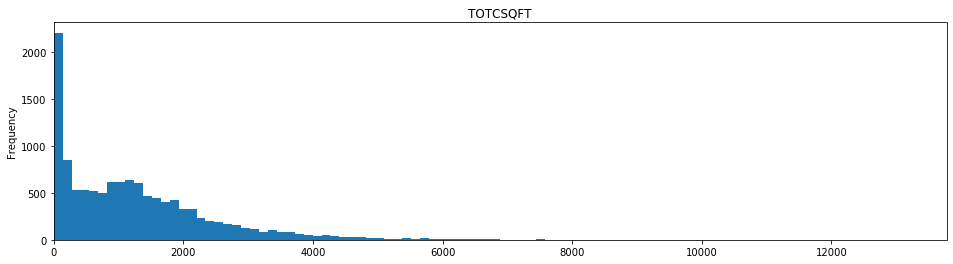

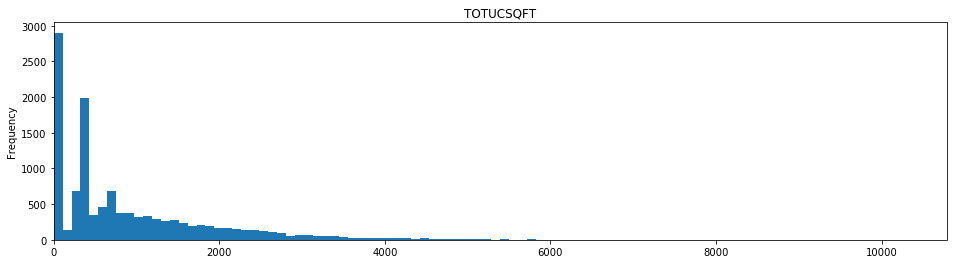

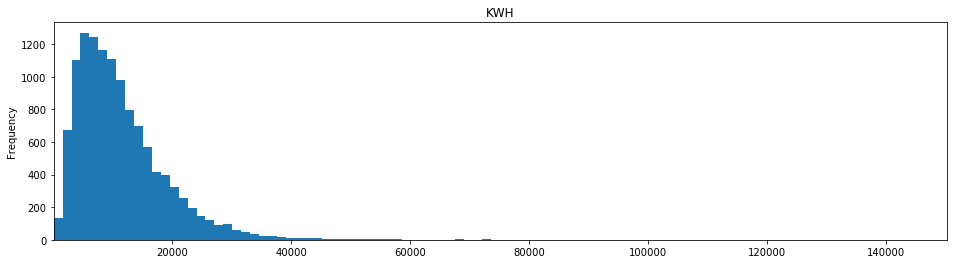

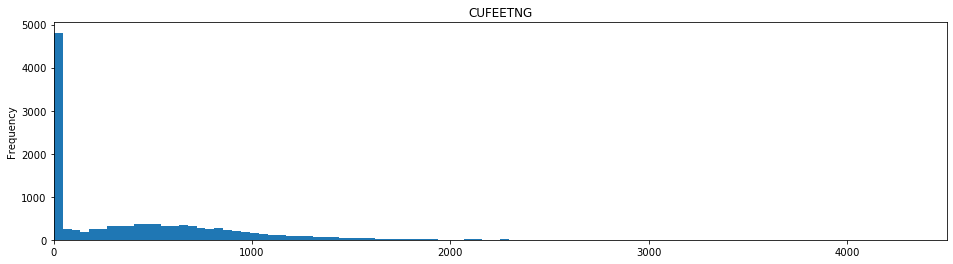

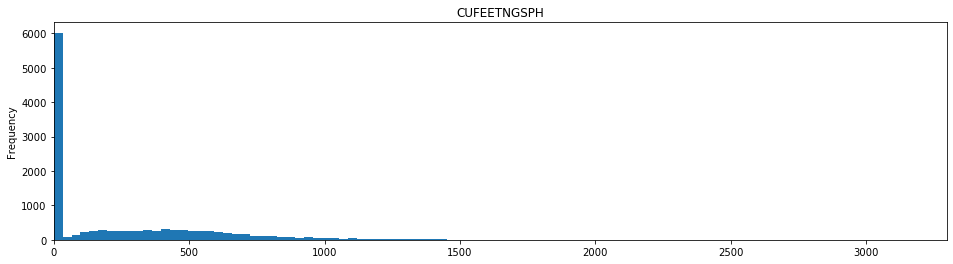

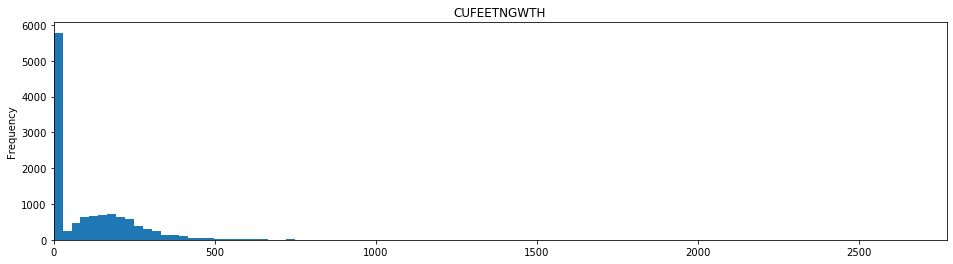

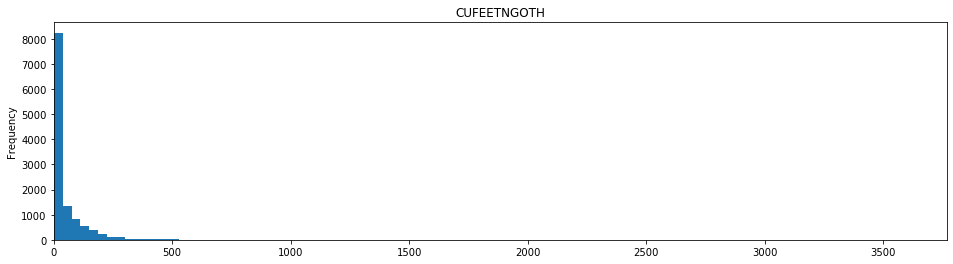

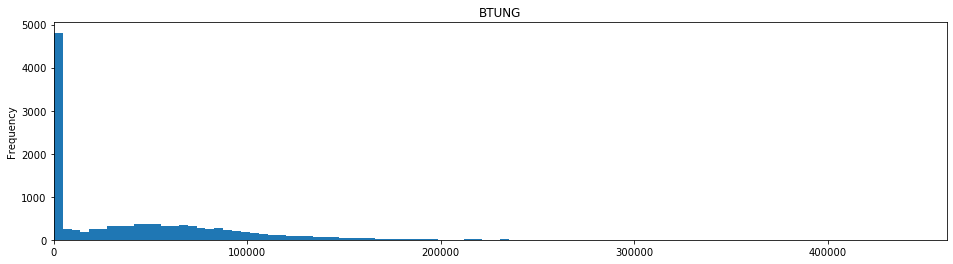

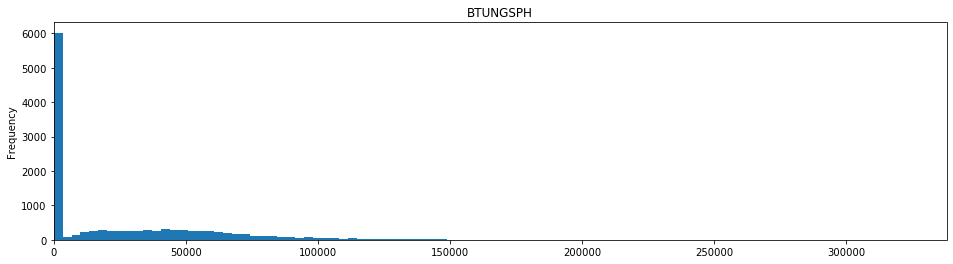

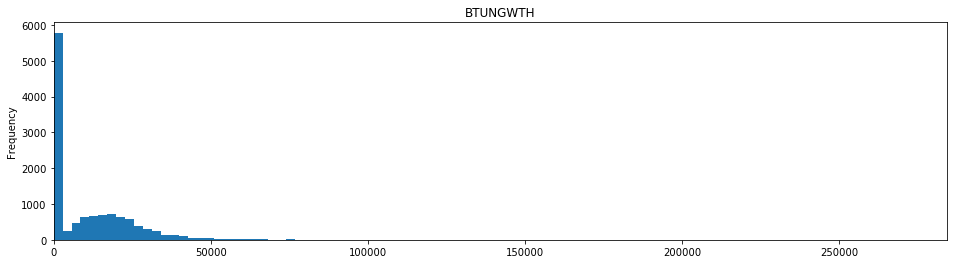

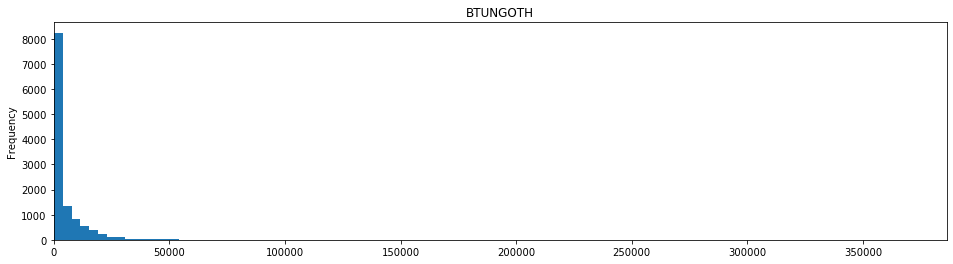

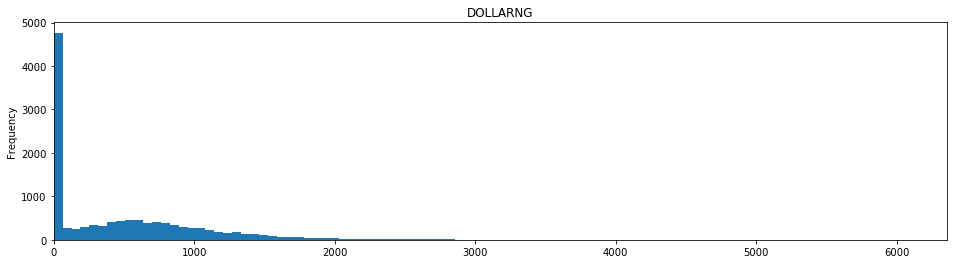

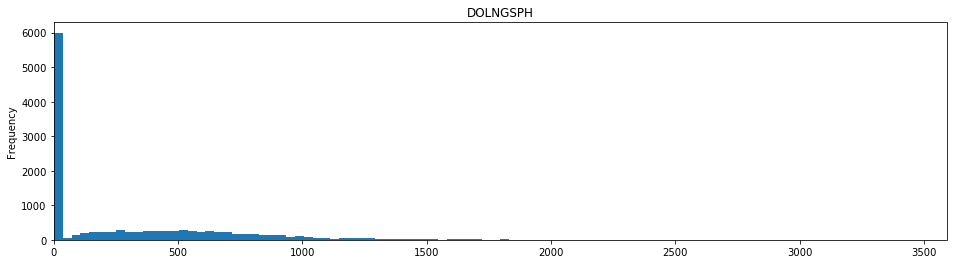

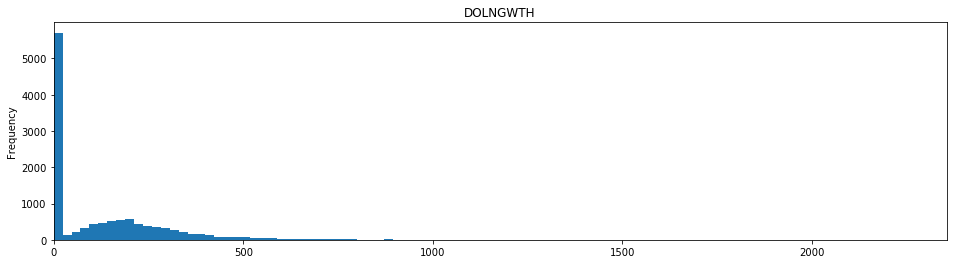

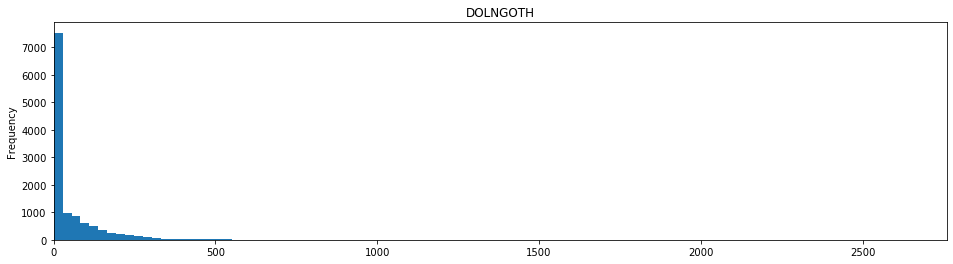

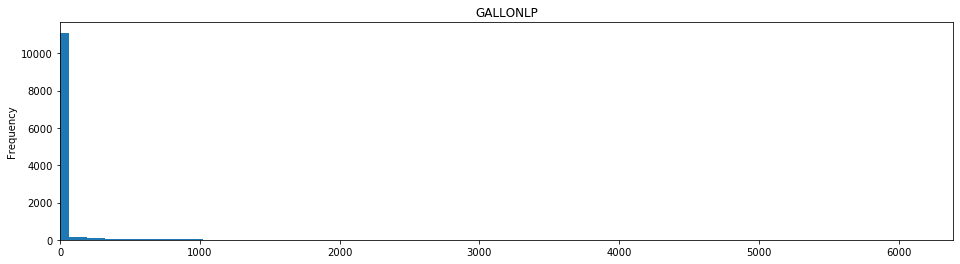

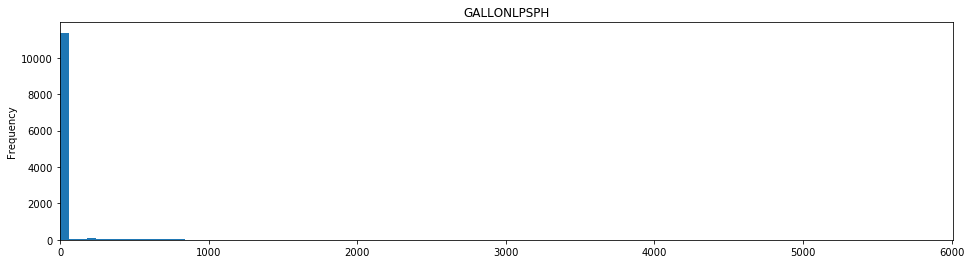

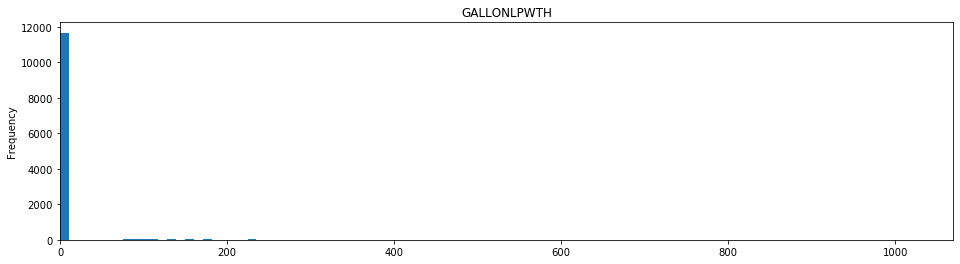

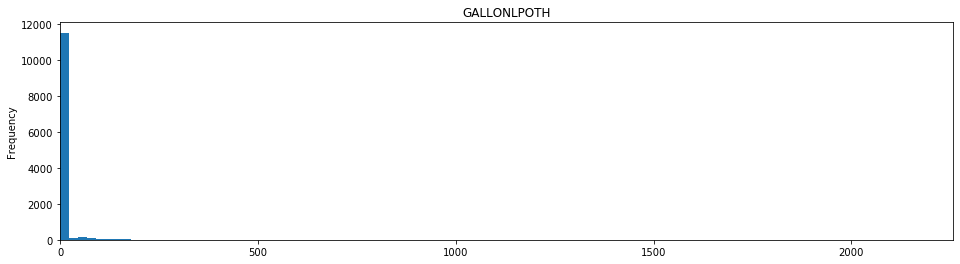

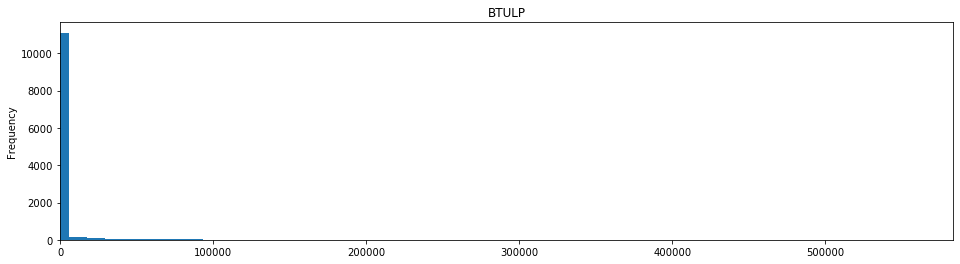

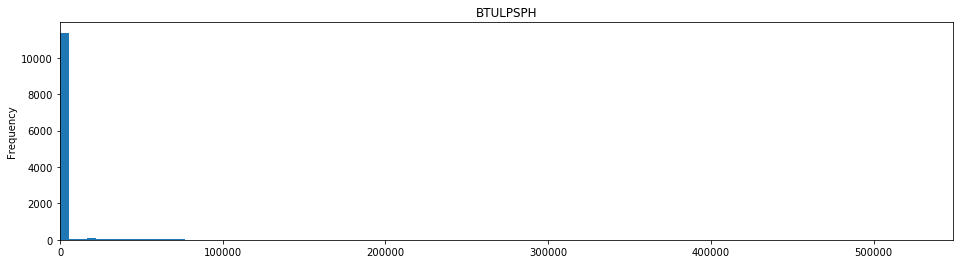

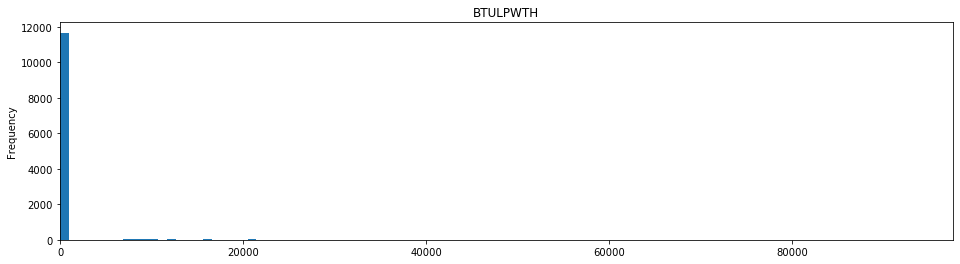

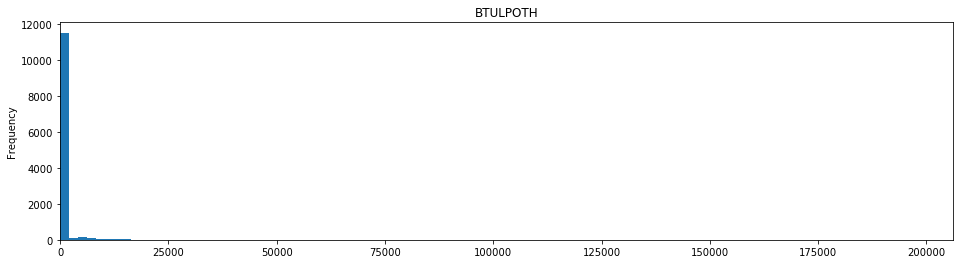

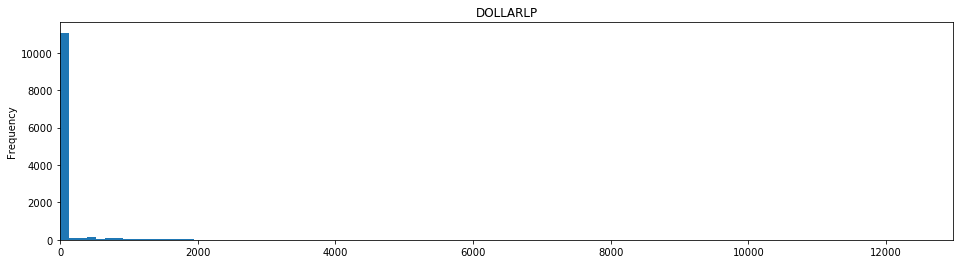

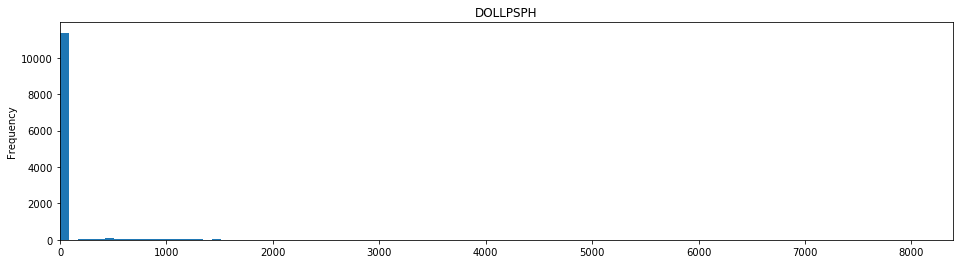

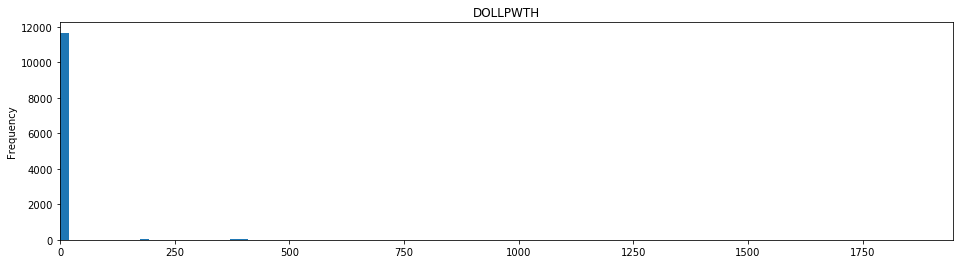

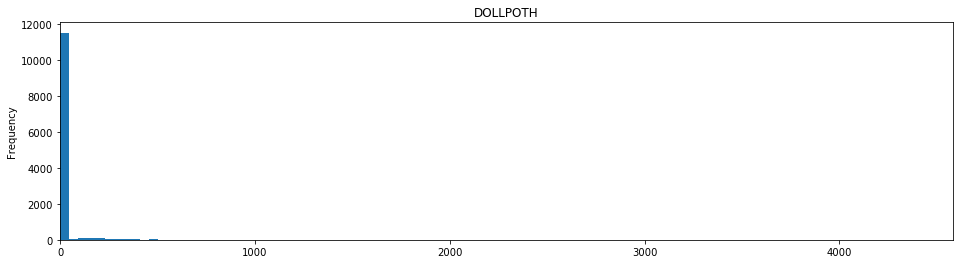

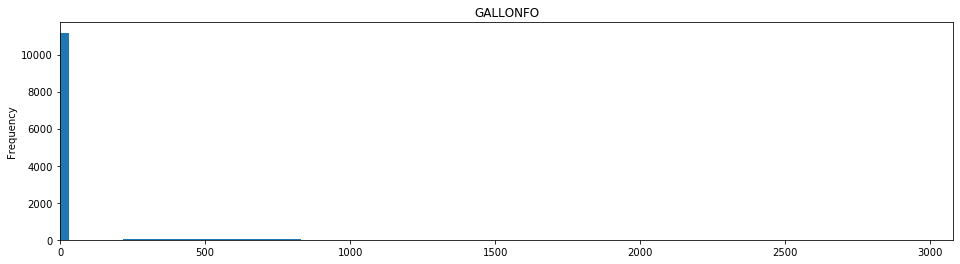

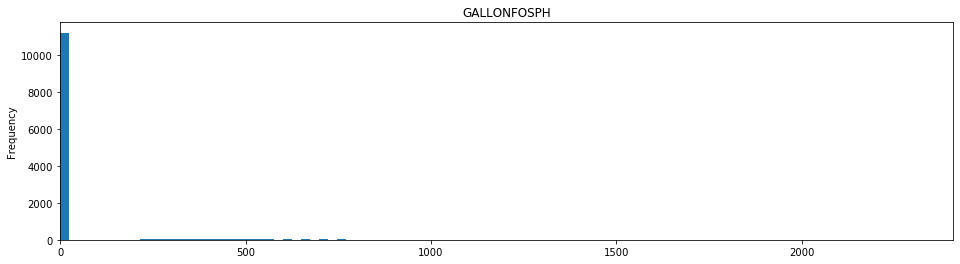

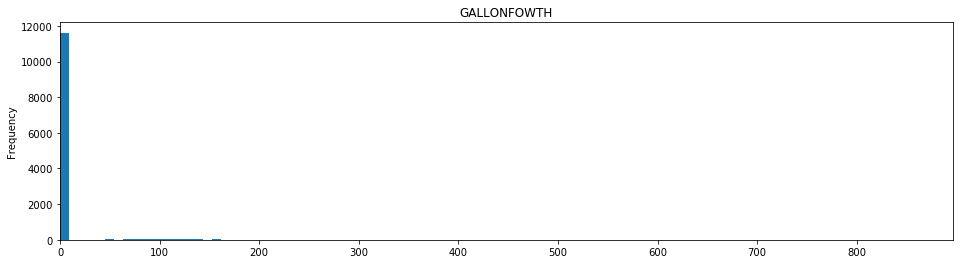

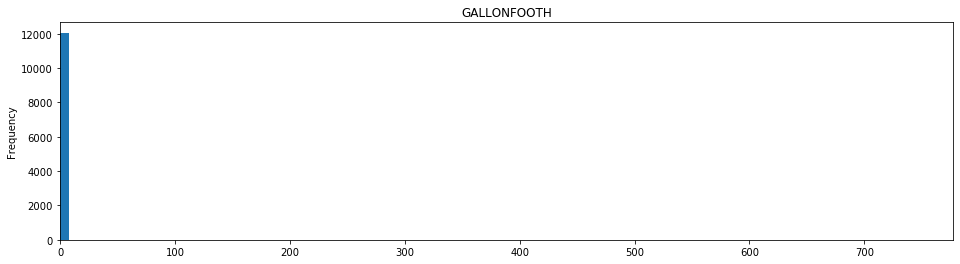

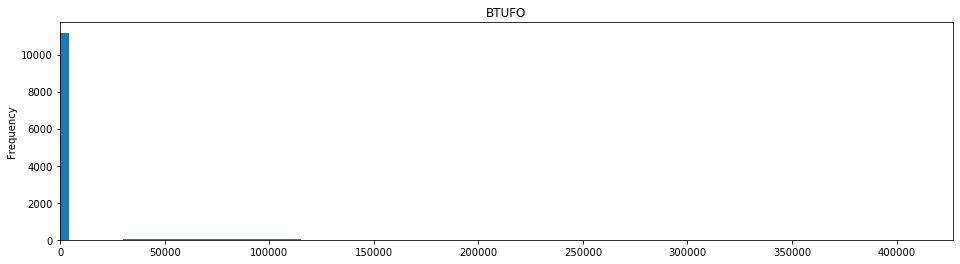

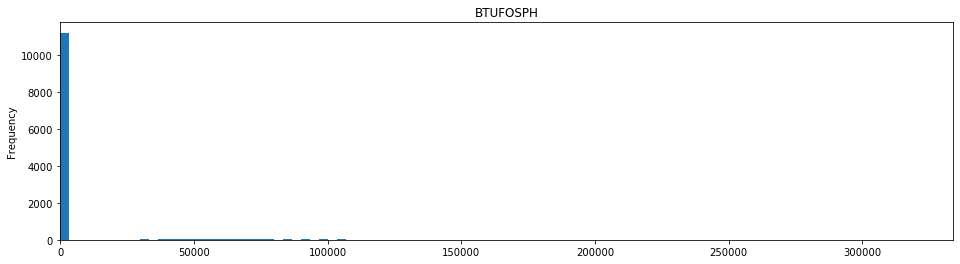

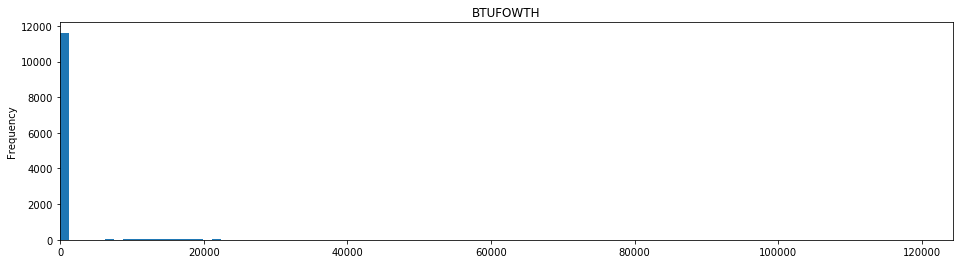

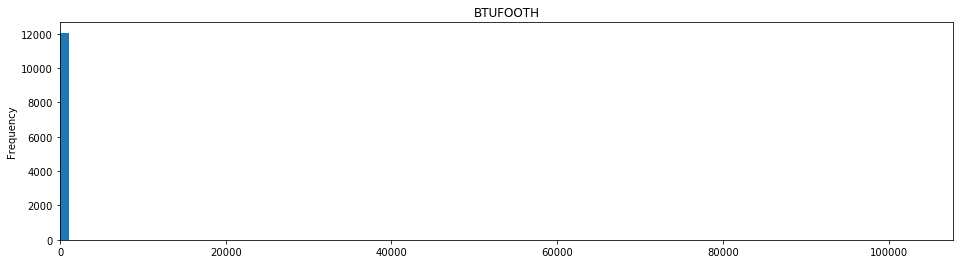

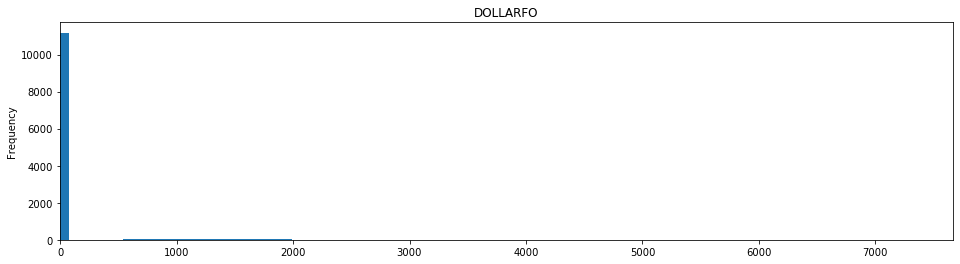

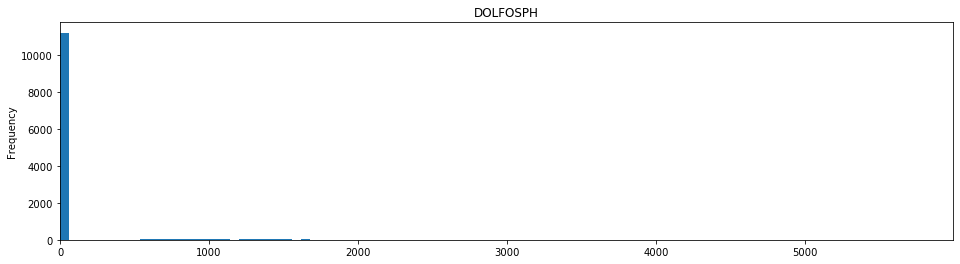

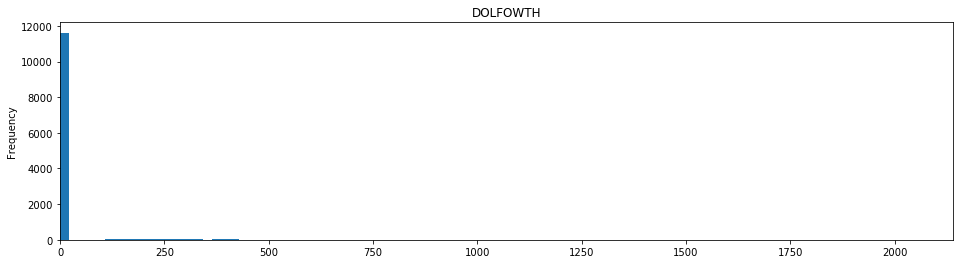

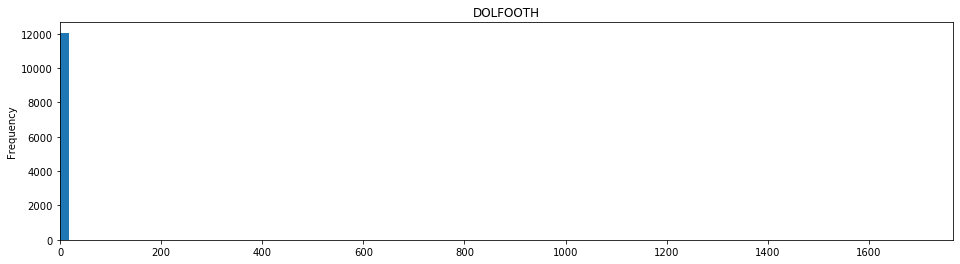

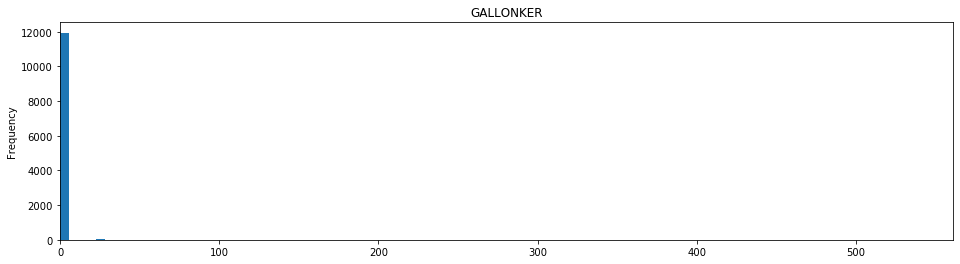

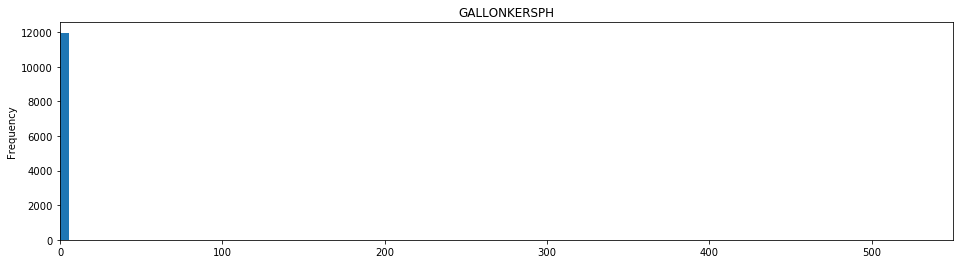

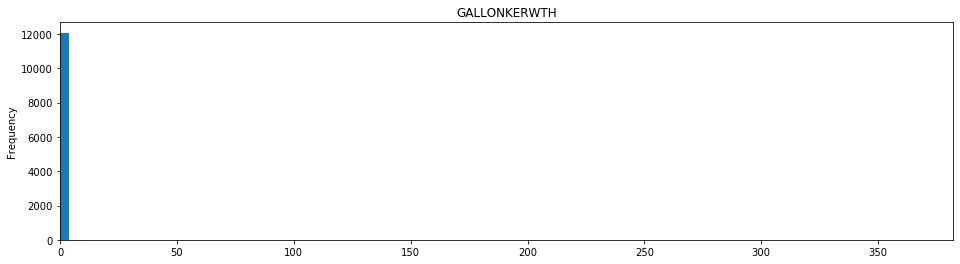

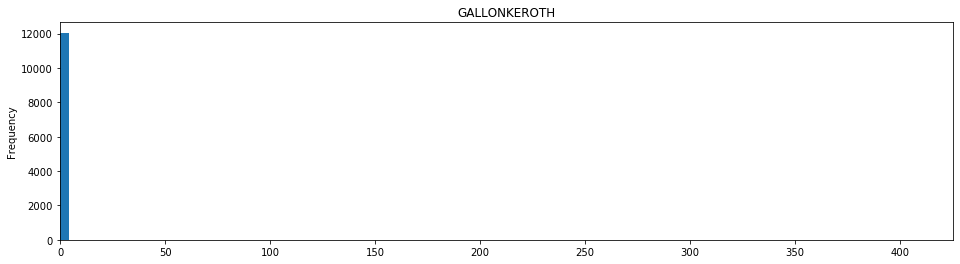

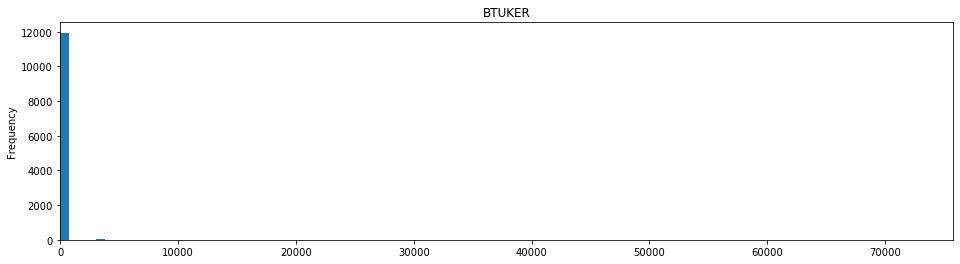

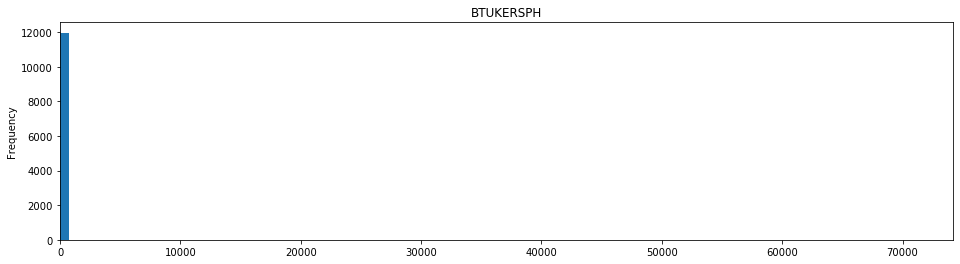

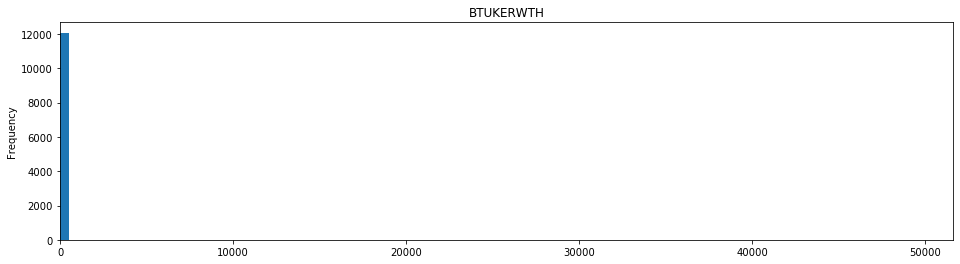

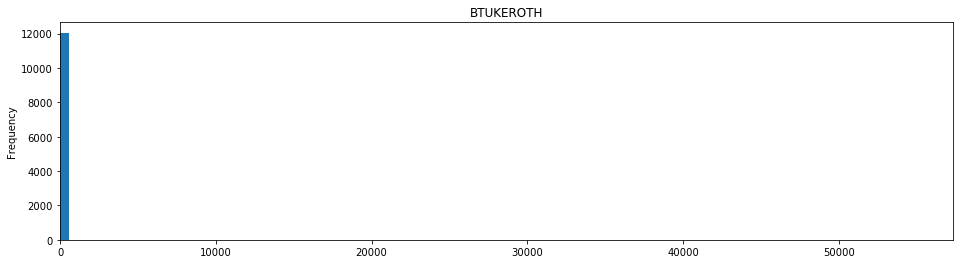

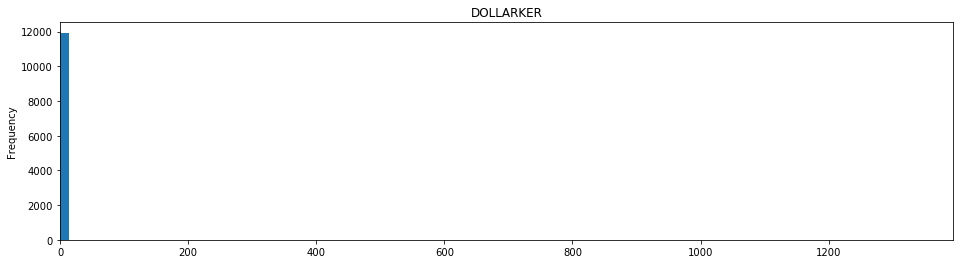

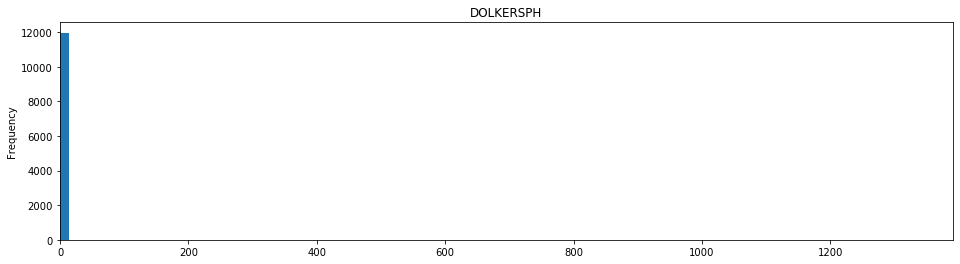

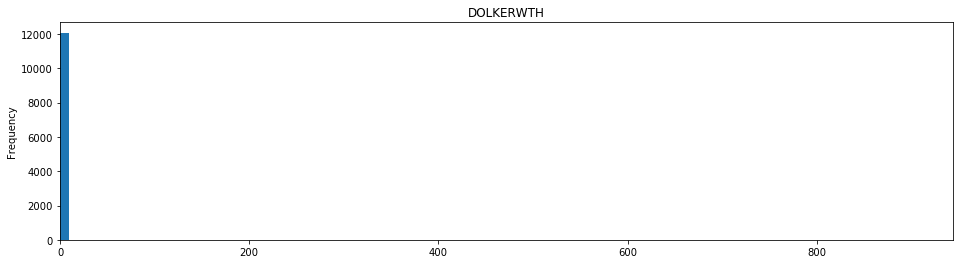

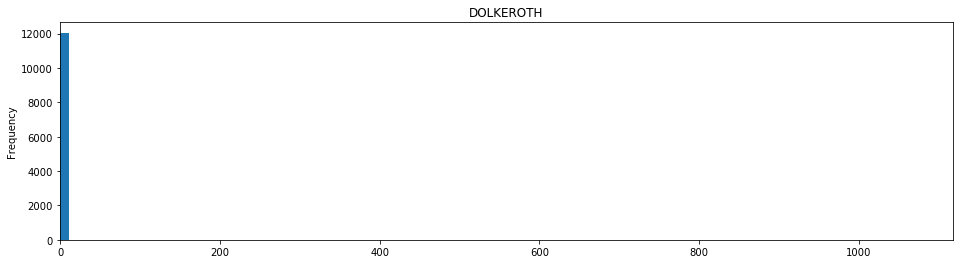

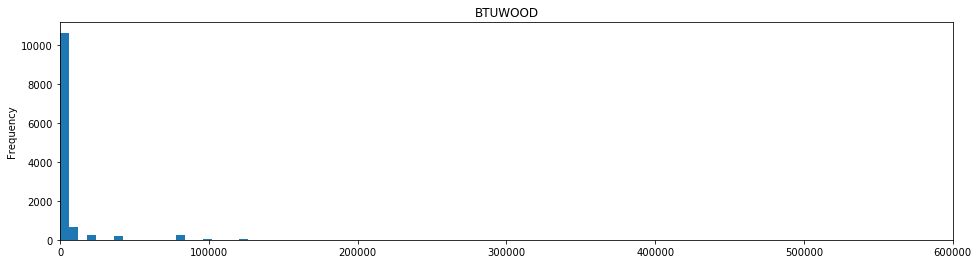

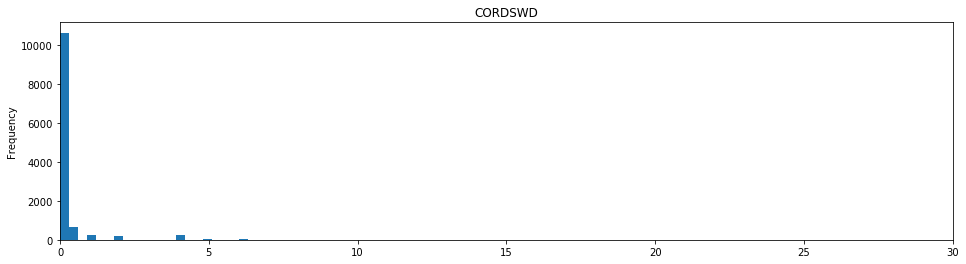

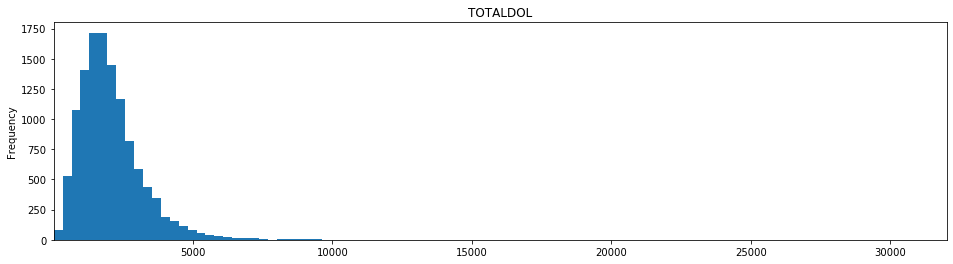

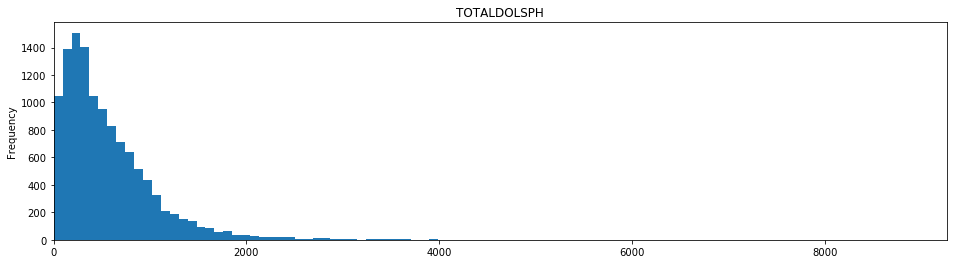

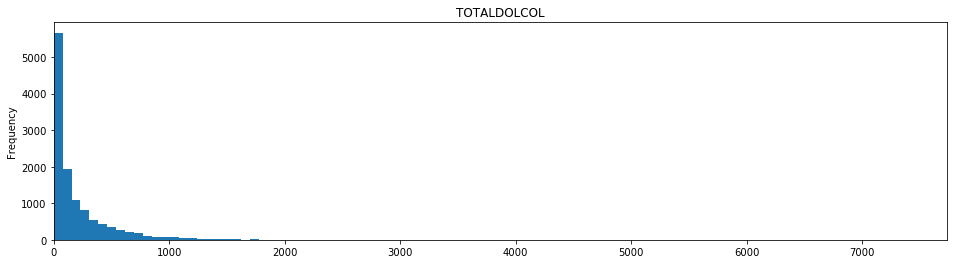

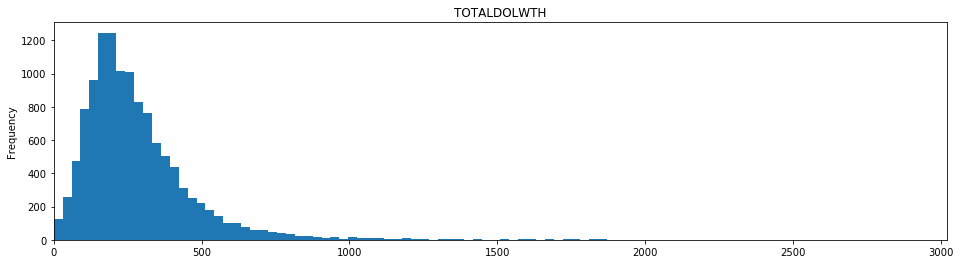

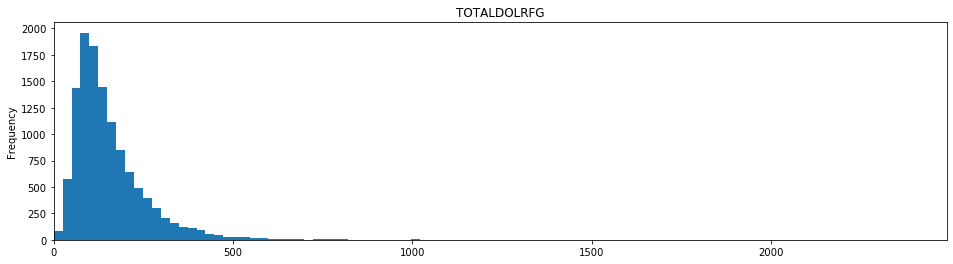

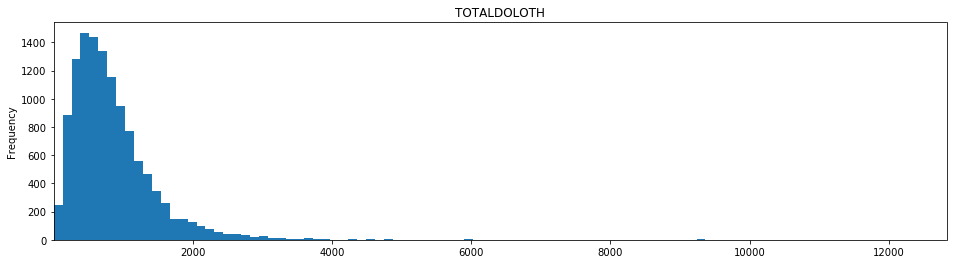

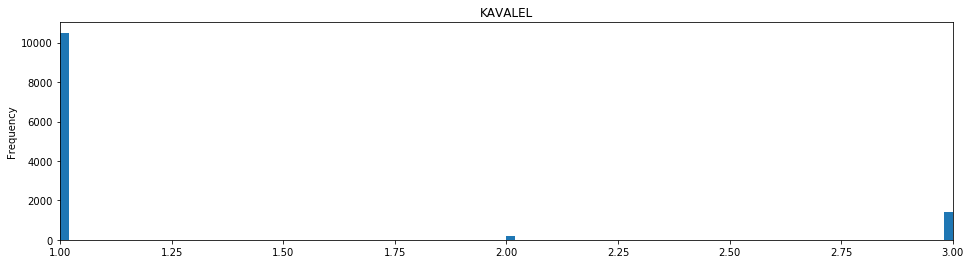

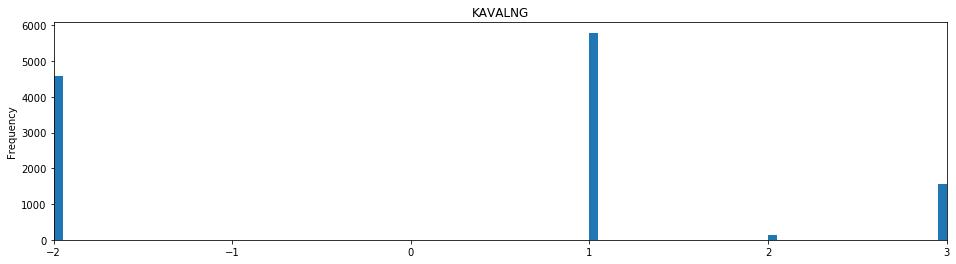

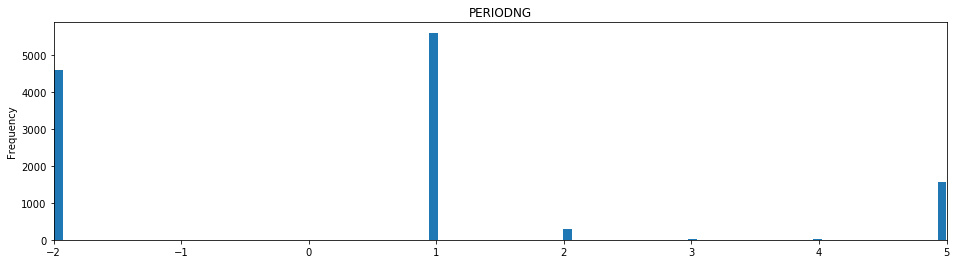

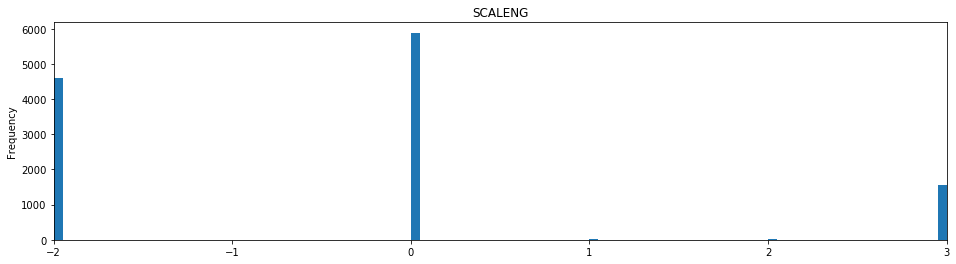

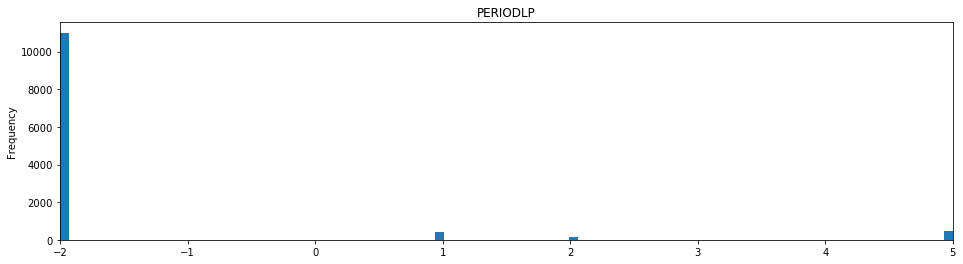

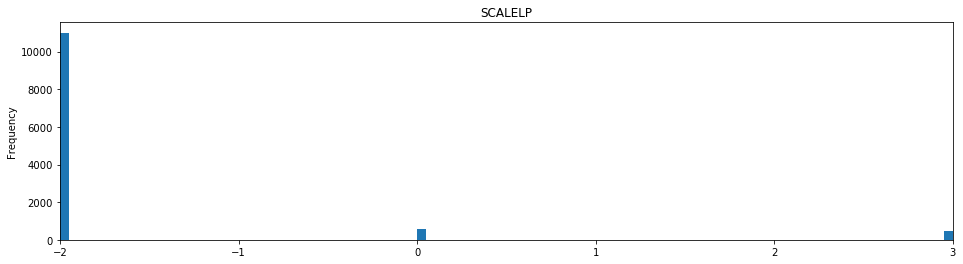

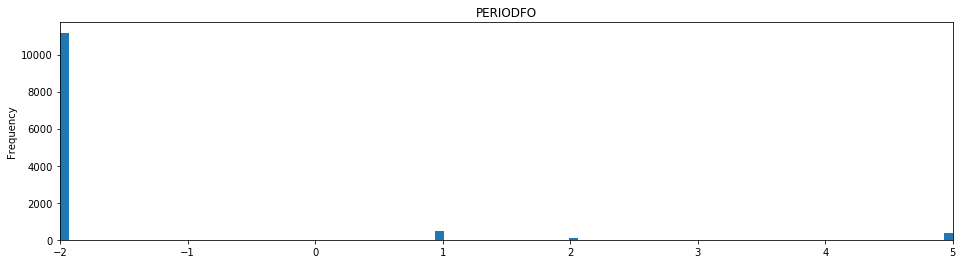

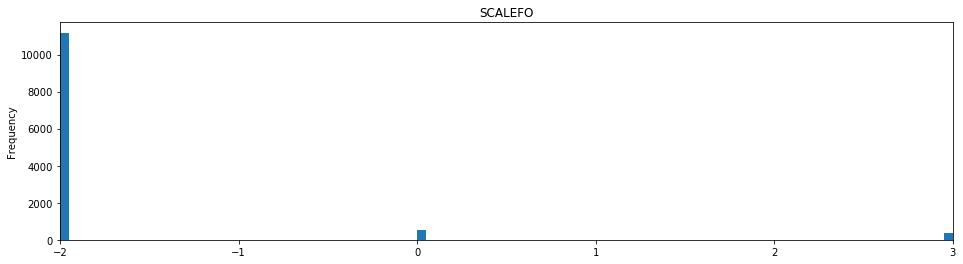

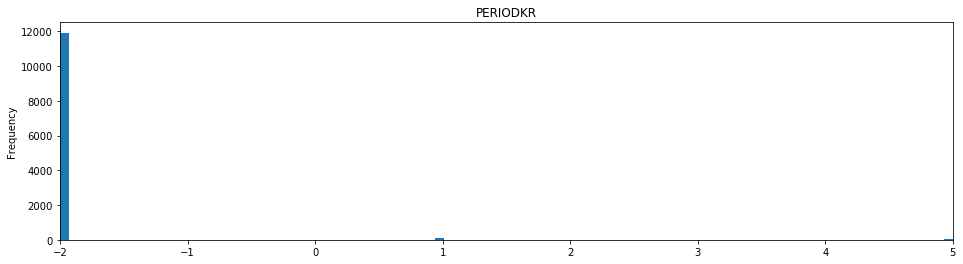

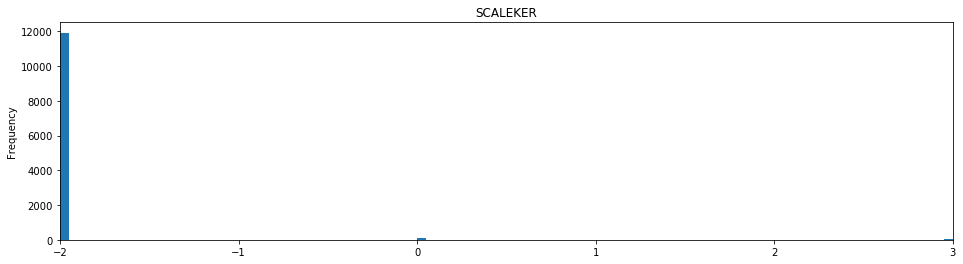

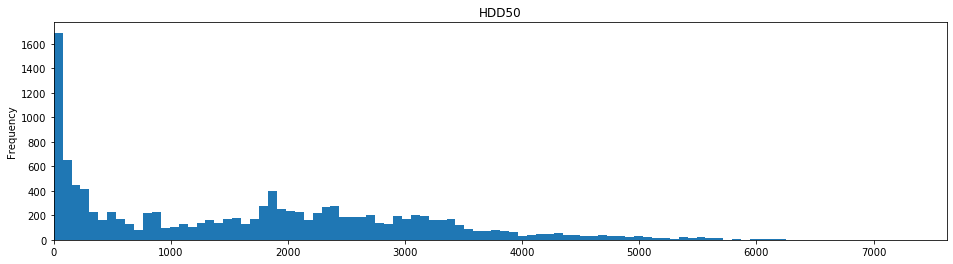

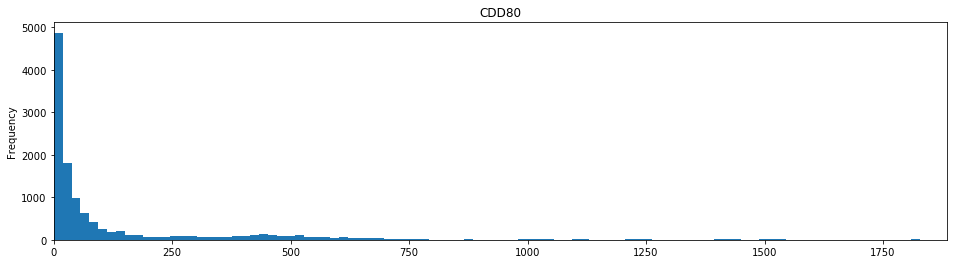

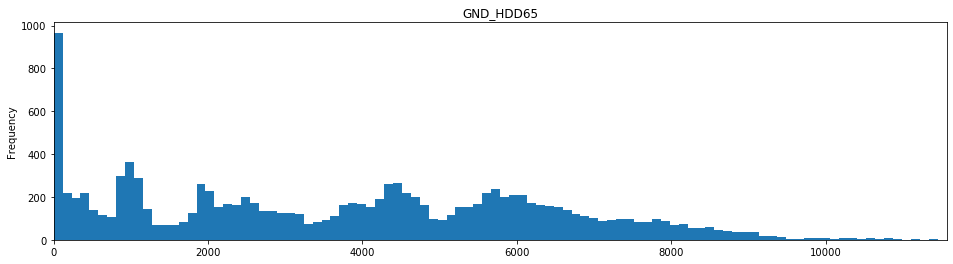

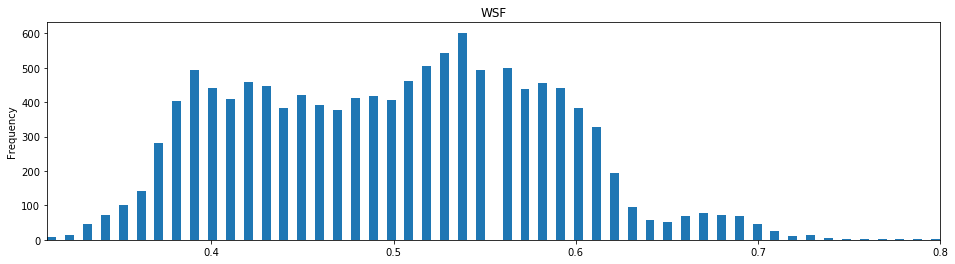

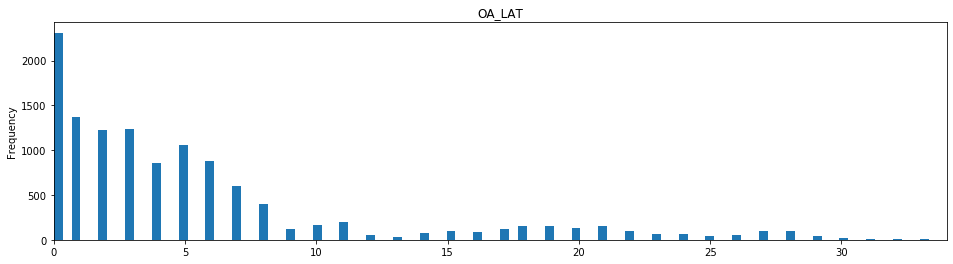

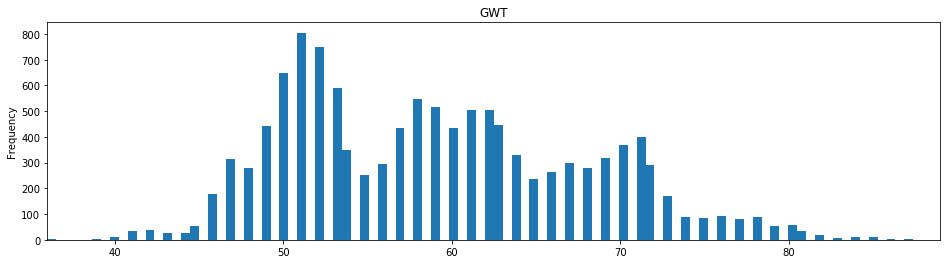

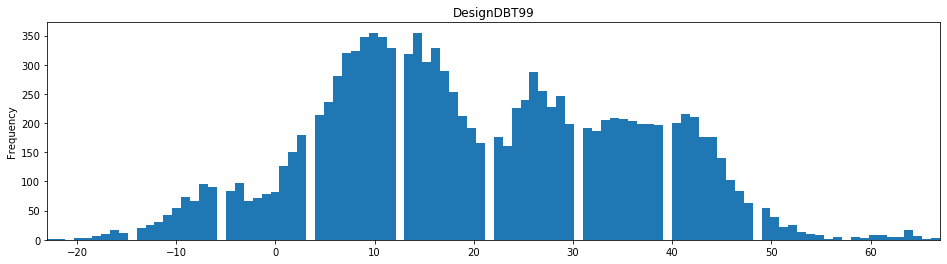

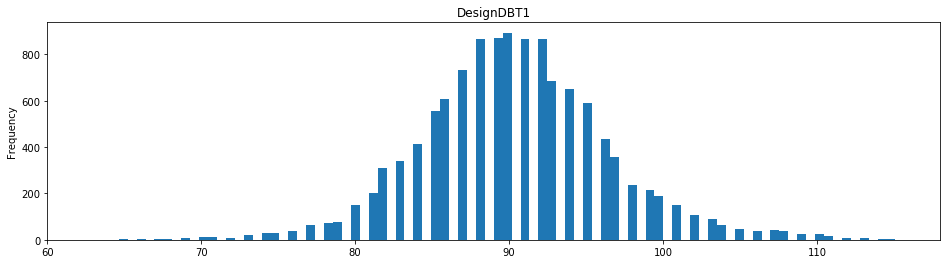

In [31]:
for i, c in enumerate(plot_data.columns):
    fig, axes = plt.subplots(nrows=1, ncols=1)
    plot_data[c].plot(kind='hist', figsize=(16, 4), title=c,
                       ax=axes, bins=100,xlim=(plot_data[c].min(),plot_data[c].max()))

Most features appear to actually be categorical, albeit encoded as numeric, some of them with very skewed binary selections. Could mean a good scenario for a Random Forest model.

Also a few of them seem to have a large number of zero's, despite the other values forming an actual distribution of some sort. Might be missing data disguised as zero - something to keep in mind for modeling.

Other than this, hard to grasp anything relevant visually from so many features. 

Finally we may save the cleaned dataset for preprocessing:

In [29]:
clean_data.to_csv('data/clean_data.csv', index=False)

In [30]:
# Save list of columns to dump
with open('data/dump_columns.pkl', 'wb') as list_file:
    pickle.dump(dump_columns, list_file)
    
# Later read with:    
# with open ('data/dump_columns.pkl', 'rb') as list_file:
#     dump_columns = pickle.load(list_file)